In [1]:
# June 12, 2019
# with Sergey
# compartments by distances

In [2]:
import os
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

from cooltools import numutils
import bioframe
from cooltools import saddle
from cooltools import eigdecomp

import matplotlib as mpl
mpl.use('Agg')  # savefig only for now:
import seaborn as sns
from functools import partial

from bioframe.tools import intersect

In [3]:

# a bunch of saddle-related functions, stollen from cooltools
# they are modified (simplified mostly) to speed up the analysis
def saddle_strength(S, C, k):
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    intra_sum = S[0:k, 0:k].sum() + S[n-k:n, n-k:n].sum()
    intra_count = C[0:k, 0:k].sum() + C[n-k:n, n-k:n].sum()
    intra = intra_sum / intra_count

    inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
    inter_count = C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
    inter = inter_sum / inter_count

    return intra / inter


def AA_strength(S, C, k):
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")
    # AA reside in the bottom right corner:
    intra_sum = S[n-k:n, n-k:n].sum()
    intra_count = C[n-k:n, n-k:n].sum()
    intra = intra_sum / intra_count
    # taking 2 corners or 1 should not matter - as we're taking
    # ratio of those anyways ...
    inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
    inter_count = C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
    inter = inter_sum / inter_count
    # return
    return intra / inter

def BB_strength(S, C, k):
    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")
    # BB reside in the upper left corner:
    intra_sum = S[0:k, 0:k].sum()
    intra_count = C[0:k, 0:k].sum()
    intra = intra_sum / intra_count    
    # taking 2 corners or 1 should not matter - as we're taking
    # ratio of those anyways ...
    inter_sum = S[0:k, n-k:n].sum() + S[n-k:n, 0:k].sum()
    inter_count = C[0:k, n-k:n].sum() + C[n-k:n, 0:k].sum()
    inter = inter_sum / inter_count

    return intra / inter



def make_cis_obsexp_diagband_fetcher(clr, expected, name, band_width_bins, inside=True):
    """
    Given a cooler object 'clr',
    cis-expected dataframe 'expected',
    and a column-name in cis-expected 'name',
    this function yields a function that
    returns slice of OBS/EXP for a given 
    chromosome.
     Custom one with an additional band selector ...
    """
    full_obsexp = clr.matrix().fetch(chrom) / \
                toeplitz(expected.loc[chrom][name].values)
    i,j = np.indices(full_obsexp.shape)
    i = i.flatten()
    j = j.flatten()
    # fill NaNs outside of the desired selection:
    nan_band_selector = (np.abs(i-j) > band_width_bins) \
                     if inside else (np.abs(i-j) <= band_width_bins)
    full_obsexp[i[nan_band_selector],j[nan_band_selector]] = np.nan
    return full_obsexp

def _accumulate(S, C, matrix, digitized):
    # based on same function from cooltools.saddle
    # this one takes an entire matrix as an argument
    n_bins = S.shape[0]

    for d in [-2, -1, 0, 1, 2]:
        numutils.set_diag(matrix, np.nan, d)

    for i in range(n_bins):
        row_mask = (digitized == i)
        for j in range(n_bins):
            col_mask = (digitized == j)
            data = matrix[row_mask, :][:, col_mask]
            data = data[np.isfinite(data)]
            S[i, j] += np.sum(data)
            C[i, j] += float(len(data))

def make_saddle(matrix, binedges, digitized, trim_outliers=False):
    # compute saddles right here:

    digitized_df, name = digitized
    digitized_track = digitized_df[name]

    # n_bins here includes 2 open bins
    # for values <lo and >hi.
    n_bins = len(binedges) + 1
    interaction_sum = np.zeros((n_bins, n_bins))
    interaction_count = np.zeros((n_bins, n_bins))

    _accumulate(interaction_sum, interaction_count, matrix,
                digitized_track)

    interaction_sum += interaction_sum.T
    interaction_count += interaction_count.T

    if trim_outliers:
        interaction_sum = interaction_sum[1:-1, 1:-1]
        interaction_count = interaction_count[1:-1, 1:-1]

    return interaction_sum, interaction_count


def take_genomic_band(mat,band_start_bins,band_end_bins):
    mat_copy = mat.copy()
    ###########################
    # taking interactions within a certain band (symmetrically though ...)
    # OR in other words
    # filling in NaNs everywhere outside of the desired bands:
    i,j = np.indices(mat_copy.shape)
    i = i.flatten()
    j = j.flatten()
    # fill NaNs outside of the desired selection:
    nan_band_selector = (np.abs(i-j) > band_start_bins) & (np.abs(i-j) < band_end_bins)
    nan_band_selector = ~nan_band_selector
    mat_copy[i[nan_band_selector],j[nan_band_selector]] = np.nan
    return mat_copy



def saddleplot_simple(binedges, counts, saddledata, cmap='coolwarm', vmin=-1, vmax=1,
               color=None, title=None, xlabel=None, ylabel=None, clabel=None,
               fig=None, fig_kws=None, heatmap_kws=None, margin_kws=None,
               cbar_kws=None, subplot_spec=None):
    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    import matplotlib.pyplot as plt
    from cytoolz import merge

    n_edges = len(binedges)
    n_bins = n_edges - 1
    lo, hi = binedges[0], binedges[-1]

    # Histogram and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    hist = counts
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        hist = hist[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=1,
        ncols=1,
#         width_ratios=[0.1, 1, 0.1],
#         height_ratios=[0.1, 1, 0.1],
        wspace=0.001,
        hspace=0.001,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(
            fig_kws_default,
            fig_kws if fig_kws is not None else {}

        )
        fig = plt.figure(**fig_kws)

    # Heatmap
    grid['ax_heatmap'] = ax = plt.subplot(gs[0])
    heatmap_kws_default = dict(
        cmap='coolwarm',
        rasterized=True,
        vmin=vmin,
        vmax=vmax)
    heatmap_kws = merge(
        heatmap_kws_default,
        heatmap_kws if heatmap_kws is not None else {})
    img = ax.pcolormesh(X, Y, C, **heatmap_kws)
    vmin = heatmap_kws['vmin']
    vmax = heatmap_kws['vmax']
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(
        edgecolor='k',
        facecolor=color,
        linewidth=1)
    margin_kws = merge(
        margin_kws_default,
        margin_kws if margin_kws is not None else {})
    # left margin hist
#     grid['ax_margin_y'] = plt.subplot(gs[3], sharey=grid['ax_heatmap'])
#     plt.barh(binedges[:-1],
#              height=np.diff(binedges),
#              width=hist,
#              align='edge',
#              **margin_kws)
#     plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
#     plt.ylim(hi, lo)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['bottom'].set_visible(False)
#     plt.gca().spines['left'].set_visible(False)
#     plt.gca().xaxis.set_visible(False)
    # top margin hist
#     grid['ax_margin_x'] = plt.subplot(gs[1], sharex=grid['ax_heatmap'])
#     plt.bar(binedges[:-1],
#             width=np.diff(binedges),
#             height=hist,
#             align='edge',
#             **margin_kws)
#     plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().spines['left'].set_visible(False)
#     plt.gca().xaxis.set_visible(False)
#     plt.gca().yaxis.set_visible(False)

#     # Colorbar
#     grid['ax_cbar'] = plt.subplot(gs[5])
#     cbar_kws_default = dict(
#         fraction=0.8,
#         label=clabel or '')
#     cbar_kws = merge(
#         cbar_kws_default,
#         cbar_kws if cbar_kws is not None else {})
#     grid['cbar'] = cb = plt.colorbar(img, **cbar_kws)
#     if vmin is not None and vmax is not None:
#         # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
#         # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
#         decimal = 10
#         nsegments = 5
#         cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments)*decimal)/decimal
#         cb.set_ticks(cd_ticks)

    # extra settings
    grid['ax_heatmap'].set_xlim(lo, hi)
    grid['ax_heatmap'].set_ylim(hi, lo)
#     plt.grid(False)
#     plt.axis('off')
#     if title is not None:
#         grid['ax_margin_x'].set_title(title)
#     if xlabel is not None:
#         grid['ax_heatmap'].set_xlabel(xlabel)
#     if ylabel is not None:
#         grid['ax_margin_y'].set_ylabel(ylabel)

    return grid



def _accumulate_mask(S, C, matrix, mask):
    # based on same function from cooltools.saddle
    # this one takes an entire matrix as an argument
    n_bins = S.shape[0]

    for d in [-2, -1, 0, 1, 2]:
        numutils.set_diag(matrix, np.nan, d)
        
    # a ridiculous version of the saddle with just Yes/No kind of
    # input:
    i,j = 0,0
    row_mask = mask
    col_mask = mask
    data = matrix[row_mask, :][:, col_mask]
    data = data[np.isfinite(data)]
    S[i, j] += np.sum(data)
    C[i, j] += float(len(data))

    i,j = 0,1
    row_mask = mask
    col_mask = ~mask
    data = matrix[row_mask, :][:, col_mask]
    data = data[np.isfinite(data)]
    S[i, j] += np.sum(data)
    C[i, j] += float(len(data))

    i,j = 1,0
    row_mask = ~mask
    col_mask = mask
    data = matrix[row_mask, :][:, col_mask]
    data = data[np.isfinite(data)]
    S[i, j] += np.sum(data)
    C[i, j] += float(len(data))
    
    i,j = 1,1
    row_mask = ~mask
    col_mask = ~mask
    data = matrix[row_mask, :][:, col_mask]
    data = data[np.isfinite(data)]
    S[i, j] += np.sum(data)
    C[i, j] += float(len(data))


def make_twobytwo_saddle(matrix, mask, trim_outliers=False):
    # compute saddles right here:

    # n_bins here includes 2 open bins
    # for values <lo and >hi.
    n_bins = 2
    interaction_sum = np.zeros((n_bins, n_bins))
    interaction_count = np.zeros((n_bins, n_bins))

    _accumulate_mask(interaction_sum, interaction_count, matrix,
                mask)

    interaction_sum += interaction_sum.T
    interaction_count += interaction_count.T

    if trim_outliers:
        interaction_sum = interaction_sum[1:-1, 1:-1]
        interaction_count = interaction_count[1:-1, 1:-1]

    return interaction_sum, interaction_count

In [4]:
# let's load cLAD-s here as well
# just to compare them to B compartments:
lads = pd.read_csv('/mnt/dekkerlab_genomics/kristin/cLAD_GSE22428.bed', sep='\t', header=None)

lads = lads.rename({0:"chrom",1:"start",2:"end"},axis=1)

# lads[lads['chrom']=='chr14'].head(50)

In [5]:
# TB-HiC-Dpn-R3-T05-R3-T1__hg19
# TB-HiC-Dpn-R3-T0-R3-T1__hg19
# TB-HiC-Dpn-R3-T15-R3-T1__hg19
# TB-HiC-Dpn-R3-T1-R3-T1__hg19
# TB-HiC-Dpn-R3-T25-R3-T1__hg19
# TB-HiC-Dpn-R3-T2-R3-T1__hg19
# TB-HiC-Dpn-R3-T35-R3-T1__hg19
# TB-HiC-Dpn-R3-T3-R3-T1__hg19
# TB-HiC-Dpn-R3-T45-R3-T1__hg19
# TB-HiC-Dpn-R3-T4-R3-T1__hg19
# TB-HiC-Dpn-R3-T5-R3-T1__hg19
# TB-HiC-Dpn-R3-T6-R3-T1__hg19
# TB-HiC-Dpn-R3-Tasyn-R3-T1__hg19

# TB-HiC-Dpn-R3-T175-R2-T1__hg19
# TB-HiC-Dpn-R3-T225-R2-T1__hg19
# TB-HiC-Dpn-R3-T275-R2-T1__hg19
# TB-HiC-Dpn-R3-T325-R2-T1__hg19

# the most complicated replicate ...


/home/abramok/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in log2


Text(0, 0.5, 'genomic coordinate')

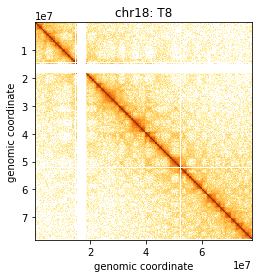

In [67]:

replicate="R2"
chroms=["chr3","chr4","chr5","chr6","chr10","chr11","chr12","chr14","chr15","chr16","chr17","chr18"]



# this would depend on the replicate :
# tcs_ordered_keys = ['Tasyn','T0','T05','T1','T15',
#                     'T2','T25','T3',
#                     'T35','T4','T45','T5','T6']
# tcs_ordered_keys = ['Tasyn','T0','T05','T1','T15',
#                     'T2','T25','T3',
#                     'T35','T4','T45','T5','T6','T7','T8',
#                     'T9','T10','T11','T12']
tcs_ordered_keys = ['Tasyn','T0','T05','T1','T15','T175',
                    'T2','T225','T25','T275','T3','T325',
                    'T35','T4','T45','T5','T6','T7','T8',
                    'T9','T10','T11','T12']

# array of times for R3
# tcs_ordered_keys = ['Tasyn','T0','T05','T1','T15','T175',
#                     'T2','T225','T25','T275','T3','T325',
#                     'T35','T4','T45','T5','T6']

# 
# a particular time point for us to use:
t8 = 'T8'
############################


if replicate == "R2":
    get_tp = lambda T: 'TB-HiC-Dpn-R2-{}'.format(T) 
if replicate == "":
    get_tp = lambda T: 'TB-HiC-Dpn-{}'.format(T)
if replicate =="R3":
    get_tp = lambda T: 'TB-HiC-Dpn-R3-{}-R2-T1'.format(T) if len(T)==4 else 'TB-HiC-Dpn-R3-{}-R3-T1'.format(T) 
# read the data in:
# just some funcs to autmate location of the files:
path_tcs = lambda tp: "/mnt/dekkerlab_genomics/kristin/distiller_mapped/FILES/{}__hg19/200kb".format(tp)
get_fname = lambda tp,chrom: os.path.join(path_tcs(tp),"{}__hg19.200000.{}.matrix".format(tp,chrom))

# generate a dict with all of the matrices (turned pandas.df), extracting the "name" from the filename
tcs_dict = {}
tcs_dict_dfs = {}
lads_binned = {}

# turned out matrix files in here /mnt/dekkerlab_genomics/kristin/distiller_mapped/FILES/TB-HiC-Dpn-R2-T8__hg19/200kb
# have an additional tab-symbol before the newline - pandas interprets it as a data-column ... we had to circumvent this
# get_fname(tp,chrom)

coars_factor = 1
coars_dict = {0:coars_factor,1:coars_factor}


for chrom in chroms:
    # tcs_dict[chrom] = {t:pd.read_csv(get_fname(get_tp(t),chrom),skiprows=1,header=None,sep='\t',index_col=0,comment="#").iloc[:,:-1] \
    #           for t in tcs_ordered_keys}
    tcs_dict_dfs[chrom] = {t: pd.read_csv(get_fname(get_tp(t),chrom),
                                             skiprows=1,
                                             header=None,
                                             sep='\t',
                                             index_col=0,
                                             comment="#").iloc[:,:-1] \
                          for t in tcs_ordered_keys}

    tcs_dict[chrom] = {t:numutils.coarsen(np.sum, tcs_dict_dfs[chrom][t].values,
                                          coars_dict,trim_excess=True) \
                      for t in tcs_ordered_keys}
    
    # let's generate dataframe with bins - cooler style
    t = tcs_ordered_keys[0]
    chrbins = tcs_dict_dfs[chrom][t].index.str. \
                    split(':').str[1].str. \
                    split('-').tolist()
    chrbins = pd.DataFrame(chrbins)
    chrbins['chrom'] = chrom
    chrbins = chrbins[['chrom',0,1]]
    chrbins = chrbins.rename({0:"start",1:"end"},axis=1)
    lads_chrom = lads[lads['chrom']==chrom].iloc[:,:3]. \
                    rename({0:"chrom",1:"start",2:"end"},axis=1).reset_index(drop=True)
    lads_binned[chrom] = intersect(chrbins,lads_chrom)
    #
    lads_binned[chrom] = lads_binned[chrom].iloc[:,:4].drop_duplicates(). \
            rename({_:_.split("_")[0] for _ in lads_binned[chrom].columns[:4]},axis=1)
    
    
# # 
# tcs_dict_coarsed = {tp:numutils.coarsen(np.sum, tcs_dict[chrom][tp].values, coars_dict) for tp in tcs_dict[chrom]}


# just show one of the heatmaps t8 for example:
coords = tcs_dict_dfs[chrom][t8].index.str.split(':').str.get(1).str.split('-').str.get(0).astype(int)[::2]
chromlen = int(tcs_dict_dfs[chrom][t8].index[-1].split(':')[1].split('-')[1])
plt.imshow(np.log2(tcs_dict[chrom][t8]),cmap='YlOrBr',extent=(1,chromlen,chromlen,1),origin='upper')
plt.title(chrom+": "+t8)
plt.xlabel("genomic coordinate")
plt.ylabel("genomic coordinate")

In [185]:
chrom="chr4"

# now we choose the beginning of a large arm by picking it from print(np.argwhere(difference!=0)) and visual analysis:
centromeres_idxs = {"chr14":100,"chr4":262,"chr18":91,"chr17":125,"chr5":247,"chr10":210}

centro_idx = centromeres_idxs[chrom]
# centro_idx = 100 #chr14
# centro_idx = 262 #chr4
# centro_idx = 0 #chr4
# centro_idx = 247 #chr5 - bad chrom in HeLa
# centro_idx = 309 #chr6 - bad chrom in HeLa
# centro_idx = 91 #chr18


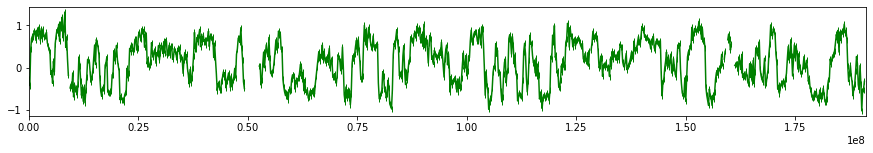

In [186]:
# read in a compartment track - precalculated by Kristin at 200kb
# and properly phased using actual gene density track ...

# we'll use this only to phase our recalculated 400kb eigen vector tracks here ...

# "/mnt/dekkerlab_genomics/kristin/sampling_validPairs/ANALYSIS/compartments/downsampled_originals/call_compartments/T8/TB-HiC-Dpn-R2-T8_33700000.200000.cis.vecs.tsv"
comp_file = "/mnt/dekkerlab_genomics/kristin/distiller_mapped/analysis/compartments/R2/call_compartments/TB-HiC-Dpn-R2-T8__hg19.200000.cis.vecs.tsv"
comp_df = pd.read_csv(comp_file,sep='\t')

nrows = 1
fig = plt.figure(figsize=(15,2*nrows))
gs = plt.GridSpec(nrows=nrows, ncols=1)
# fig = plt.figure(figsize=(5*(num_bands+1), nrows*5)) #width, height


# extract only one chromosome
eig_old = comp_df[comp_df['chrom']==chrom]
ax = plt.subplot(gs[0])
ax.plot(eig_old['start'],eig_old['E1'],'g|-')
ax.set_xlim(eig_old['start'].iloc[0],eig_old['end'].iloc[-1])
# lo,hi = eig['E1'].min(),eig['E1'].max()


# prepare a phasing track by trimming 200kb, just like we trimmed the matrix:
ind = tuple(slice(0, -(d % coars_dict[i]))
                if d % coars_dict[i] else slice(None, None)
            for i, d in enumerate(eig_old['E1'].values.shape))
phasing_track = eig_old['E1'].values[ind][::coars_dict[0]]

/home/abramok/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


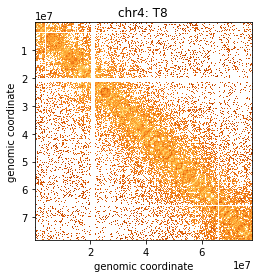

In [187]:
# let's just check how Obs/Exp looks like and get our 400kb EVs:
# matrix = np.nan_to_num(tcs_dict[chrom][t8],0)
matrix = tcs_dict[chrom][t8]
mask = numutils.infer_mask2D(matrix)
OE,_,_,_ = numutils.observed_over_expected(matrix, mask)

plt.imshow(np.log2(OE),cmap='YlOrBr',extent=(1,chromlen,chromlen,1),origin='upper')
plt.title(chrom+": "+t8)
plt.xlabel("genomic coordinate")
plt.ylabel("genomic coordinate")

###################################
# do eigen decomp the exact same way that it is done on coolers:
evals,evecs = eigdecomp.cis_eig(matrix,#[centro_idx:,centro_idx:],
                                n_eigs=3,
                                phasing_track=phasing_track,#[centro_idx:],
                                ignore_diags=2,
                                clip_percentile=0,
                                sort_metric=None)

[[ 45]
 [ 46]
 [246]
 [262]
 [640]
 [641]
 [792]
 [793]
 [795]
 [797]
 [802]
 [805]
 [954]]


(0, 956)

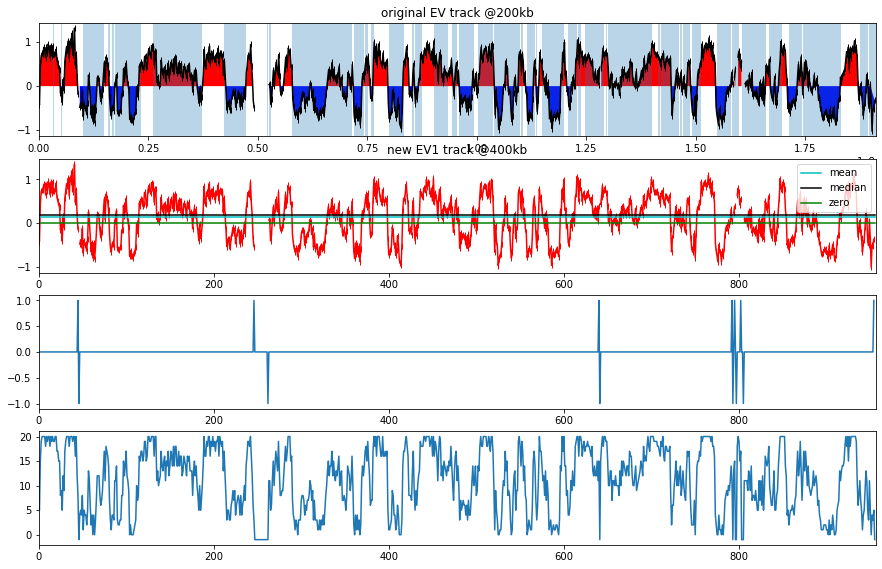

In [188]:
# let's just look at the newely calculated and phased EV1 track:

nrows = 4
fig = plt.figure(figsize=(15,2.4*nrows))
gs = plt.GridSpec(nrows=nrows, ncols=1)
# fig = plt.figure(figsize=(5*(num_bands+1), nrows*5)) #width, height


ax = plt.subplot(gs[0])
xx = eig_old['start']#.iloc[centro_idx:]
yy = eig_old['E1']#.iloc[centro_idx:]
ax.plot(xx,yy,'k|-')
ax.set_xlim(xx.iloc[0],xx.iloc[-1])

ax.fill_between(xx,yy,0, where=yy >= 0,
                 facecolor='red', interpolate=True)
ax.fill_between(xx,yy,0, where=yy < 0,
                 facecolor='blue', interpolate=True)

ax.set_title("original EV track @200kb")
# let's add cLADs here:
for start,end in lads_binned[chrom][['start','end']].itertuples(index=False):
    ax.axvspan(start,end,-1,1,alpha=0.3)


ax = plt.subplot(gs[1])
ax.plot(evecs[0],'r|-')
ax.set_xlim(0,len(evecs[0]))
ax.set_title("new EV1 track @400kb")


# now we should make it suitable for the downstream analysis - i.e. saddling:
# now the new EV1 (PC1) goes official:
eig = pd.DataFrame({"E1":evecs[0]})
if replicate == "R3":
    eig = eig_old

median_ev = saddle.quantile(eig['E1'].values, [0.5,])
mean_ev = np.nanmean( eig['E1'].values)
# saddle.quantile(eig['E1'].values, (qlo, qhi))
ax.plot(np.zeros_like(evecs[0])+mean_ev,'c-',label="mean")
ax.plot(np.zeros_like(evecs[0])+median_ev,'k-',label="median")
ax.plot(np.zeros_like(evecs[0]),'g-',label="zero")
plt.legend()


# now find centromeres the "new" way - i.e. @400kb ...
#########################################################
# finding centromeres:
nans = np.isnan(eig['E1'].values).astype('int')
ax = plt.subplot(gs[2])
# a derivative of the Nans array - give spikes where Nan switches to
# real values and back:
ax.plot(nans[1:] - nans[:-1])
ax.set_xlim(0,len(nans))
difference = nans[1:] - nans[:-1]
print(np.argwhere(difference!=0))



########################################################
# we need to try several ways of digitization ...
# digitize it:

nbins = 20
quants=False

if quants:
    #(1) quantiles - bins with 
    qlo, qhi = 0.03, .97
    q_edges = np.linspace(qlo, qhi, nbins)
    binedges = saddle.quantile(eig['E1'], q_edges)
    # edges that would go to saddle plotting 
    edges = q_edges
else:
    # (2) linear range
    # pick a way to get lo and hi
    qlo, qhi = 0.03, .97
    # lo, hi = eig['E1'].values.min(), eig['E1'].values.max()
    lo, hi = saddle.quantile(eig['E1'].values, (qlo, qhi))
    #     lo,hi = -1,1
    # make them symmetric around 0:
    lo_hi = np.min(np.abs([lo,hi]))
    lo,hi = -lo_hi, lo_hi
    binedges = np.linspace(lo, hi, nbins)
    # edges that would go to saddle plotting 
    edges = binedges


# binedges = np.linspace(-0.95,0.95,16)
eig_dig,hist = saddle.digitize_track(binedges, (eig,'E1'))
ax = plt.subplot(gs[3])
ax.plot(eig_dig['E1.d'].values)
ax.set_xlim(0,len(eig_dig['E1.d']))


In [189]:
!pwd

/mnt/dekkerlab_genomics/kristin/SSH_plumbing/saddles_by_distance


In [190]:
#!rm 2019July29_saddlesByDistance_chr*
!ls
#!rm 2019Ju`ly_saddlesByDistance_{}arm_quantDist.pdf

2019July_saddlesByDistance_chr10arm.pdf
2019July_saddlesByDistance_chr10arm_quantDist.pdf
2019July_saddlesByDistance_chr10arm_quantType.pdf
2019July_saddlesByDistance_chr10_schematic.pdf
2019July_saddlesByDistance_chr14arm.pdf
2019July_saddlesByDistance_chr14arm_quantDist.pdf
2019July_saddlesByDistance_chr14arm_quantType.pdf
2019July_saddlesByDistance_chr14_schematic.pdf
2019July_saddlesByDistance_chr17arm.pdf
2019July_saddlesByDistance_chr17arm_quantDist.pdf
2019July_saddlesByDistance_chr17arm_quantType.pdf
2019July_saddlesByDistance_chr17_schematic.pdf
2019July_saddlesByDistance_chr18arm.pdf
2019July_saddlesByDistance_chr18arm_quantDist.pdf
2019July_saddlesByDistance_chr18arm_quantType.pdf
2019July_saddlesByDistance_chr18_schematic.pdf
2019July_saddlesByDistance_chr4arm.pdf
2019July_saddlesByDistance_chr4arm_quantDist.pdf
2019July_saddlesByDistance_chr4arm_quantType.pdf
2019July_saddlesByDistance_chr4_schematic.pdf
2019July_saddlesByDistance_chr5arm.pdf
2019July_saddlesByDistance_chr

(0.0, 4000000.000000001)
(4000000.000000001, 8458970.107524516)
(8458970.107524516, 17888543.819998324)
(17888543.819998324, 37829664.36012705)
(37829664.36012705, 80000000.00000003)
(0, 20)
(20, 42)
(42, 89)
(89, 189)
(189, 400)


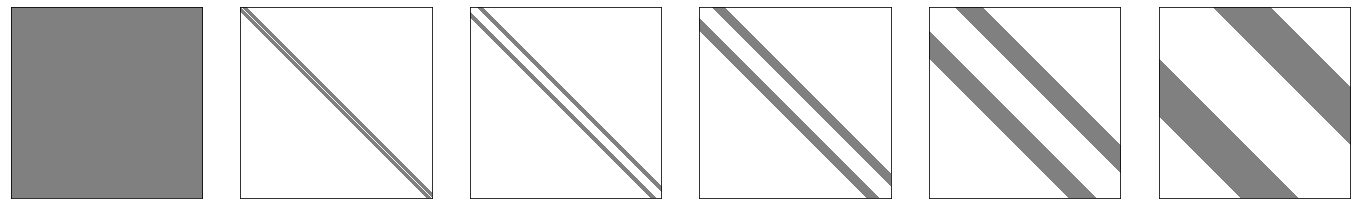

In [191]:
###########################################################
def take_genomic_band_mock(mat,band_start_bins,band_end_bins):
    mat_copy = np.ones_like(mat)
    ###########################
    # taking interactions within a certain band (symmetrically though ...)
    # OR in other words
    # filling in NaNs everywhere outside of the desired bands:
    i,j = np.indices(mat_copy.shape)
    i = i.flatten()
    j = j.flatten()
    # fill NaNs outside of the desired selection:
    nan_band_selector = (np.abs(i-j) > band_start_bins) & (np.abs(i-j) < band_end_bins)
    nan_band_selector = ~nan_band_selector
    mat_copy[i[nan_band_selector],j[nan_band_selector]] = np.nan
    return mat_copy

###########################################################

binsize=200000
mb = 1000000
num_bands = 5
bind_width = 60
gs = plt.GridSpec(nrows=1, ncols=num_bands+1)
fig = plt.figure(figsize=(4*(num_bands+1), 4)) #width, height

bandedges = np.concatenate([[0],np.geomspace(4*mb,80*mb,num=num_bands)])
bands = list(zip(bandedges[:-1],bandedges[1:]))
for band in bands:
    print(band)
bands = list(zip((bandedges[:-1]/binsize).astype(int), \
                 (bandedges[1:]/binsize).astype(int)))
for band in bands:
    print(band)

ax = plt.subplot(gs[0])  
tp='T6'
matrix = tcs_dict[chrom][tp][centro_idx:,centro_idx:]
mask = numutils.infer_mask2D(matrix)
OE,_,_,_ = numutils.observed_over_expected(matrix, mask)
#     the_index = (num_bands+1)+band+1
###########################
# taking interactions within a certain genomic band:
mmm = np.ones_like(OE)
ax.imshow((mmm),cmap="gray",vmin=0,vmax=2)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for band in range(num_bands):

    tp='T6'
    matrix = tcs_dict[chrom][tp][centro_idx:,centro_idx:]
    mask = numutils.infer_mask2D(matrix)
    OE,_,_,_ = numutils.observed_over_expected(matrix, mask)


    #     the_index = (num_bands+1)+band+1
    ###########################
    # taking interactions within a certain genomic band:
    band_start_bins, band_end_bins = bands[band]
    mmm = take_genomic_band_mock(OE,band_start_bins,band_end_bins)
    ax = plt.subplot(gs[band+1])
    ax.imshow((mmm),cmap="gray",vmin=0,vmax=2)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

plt.show()
#plt.savefig("2019July_saddlesByDistance_{}_schematic.pdf".format(chrom))

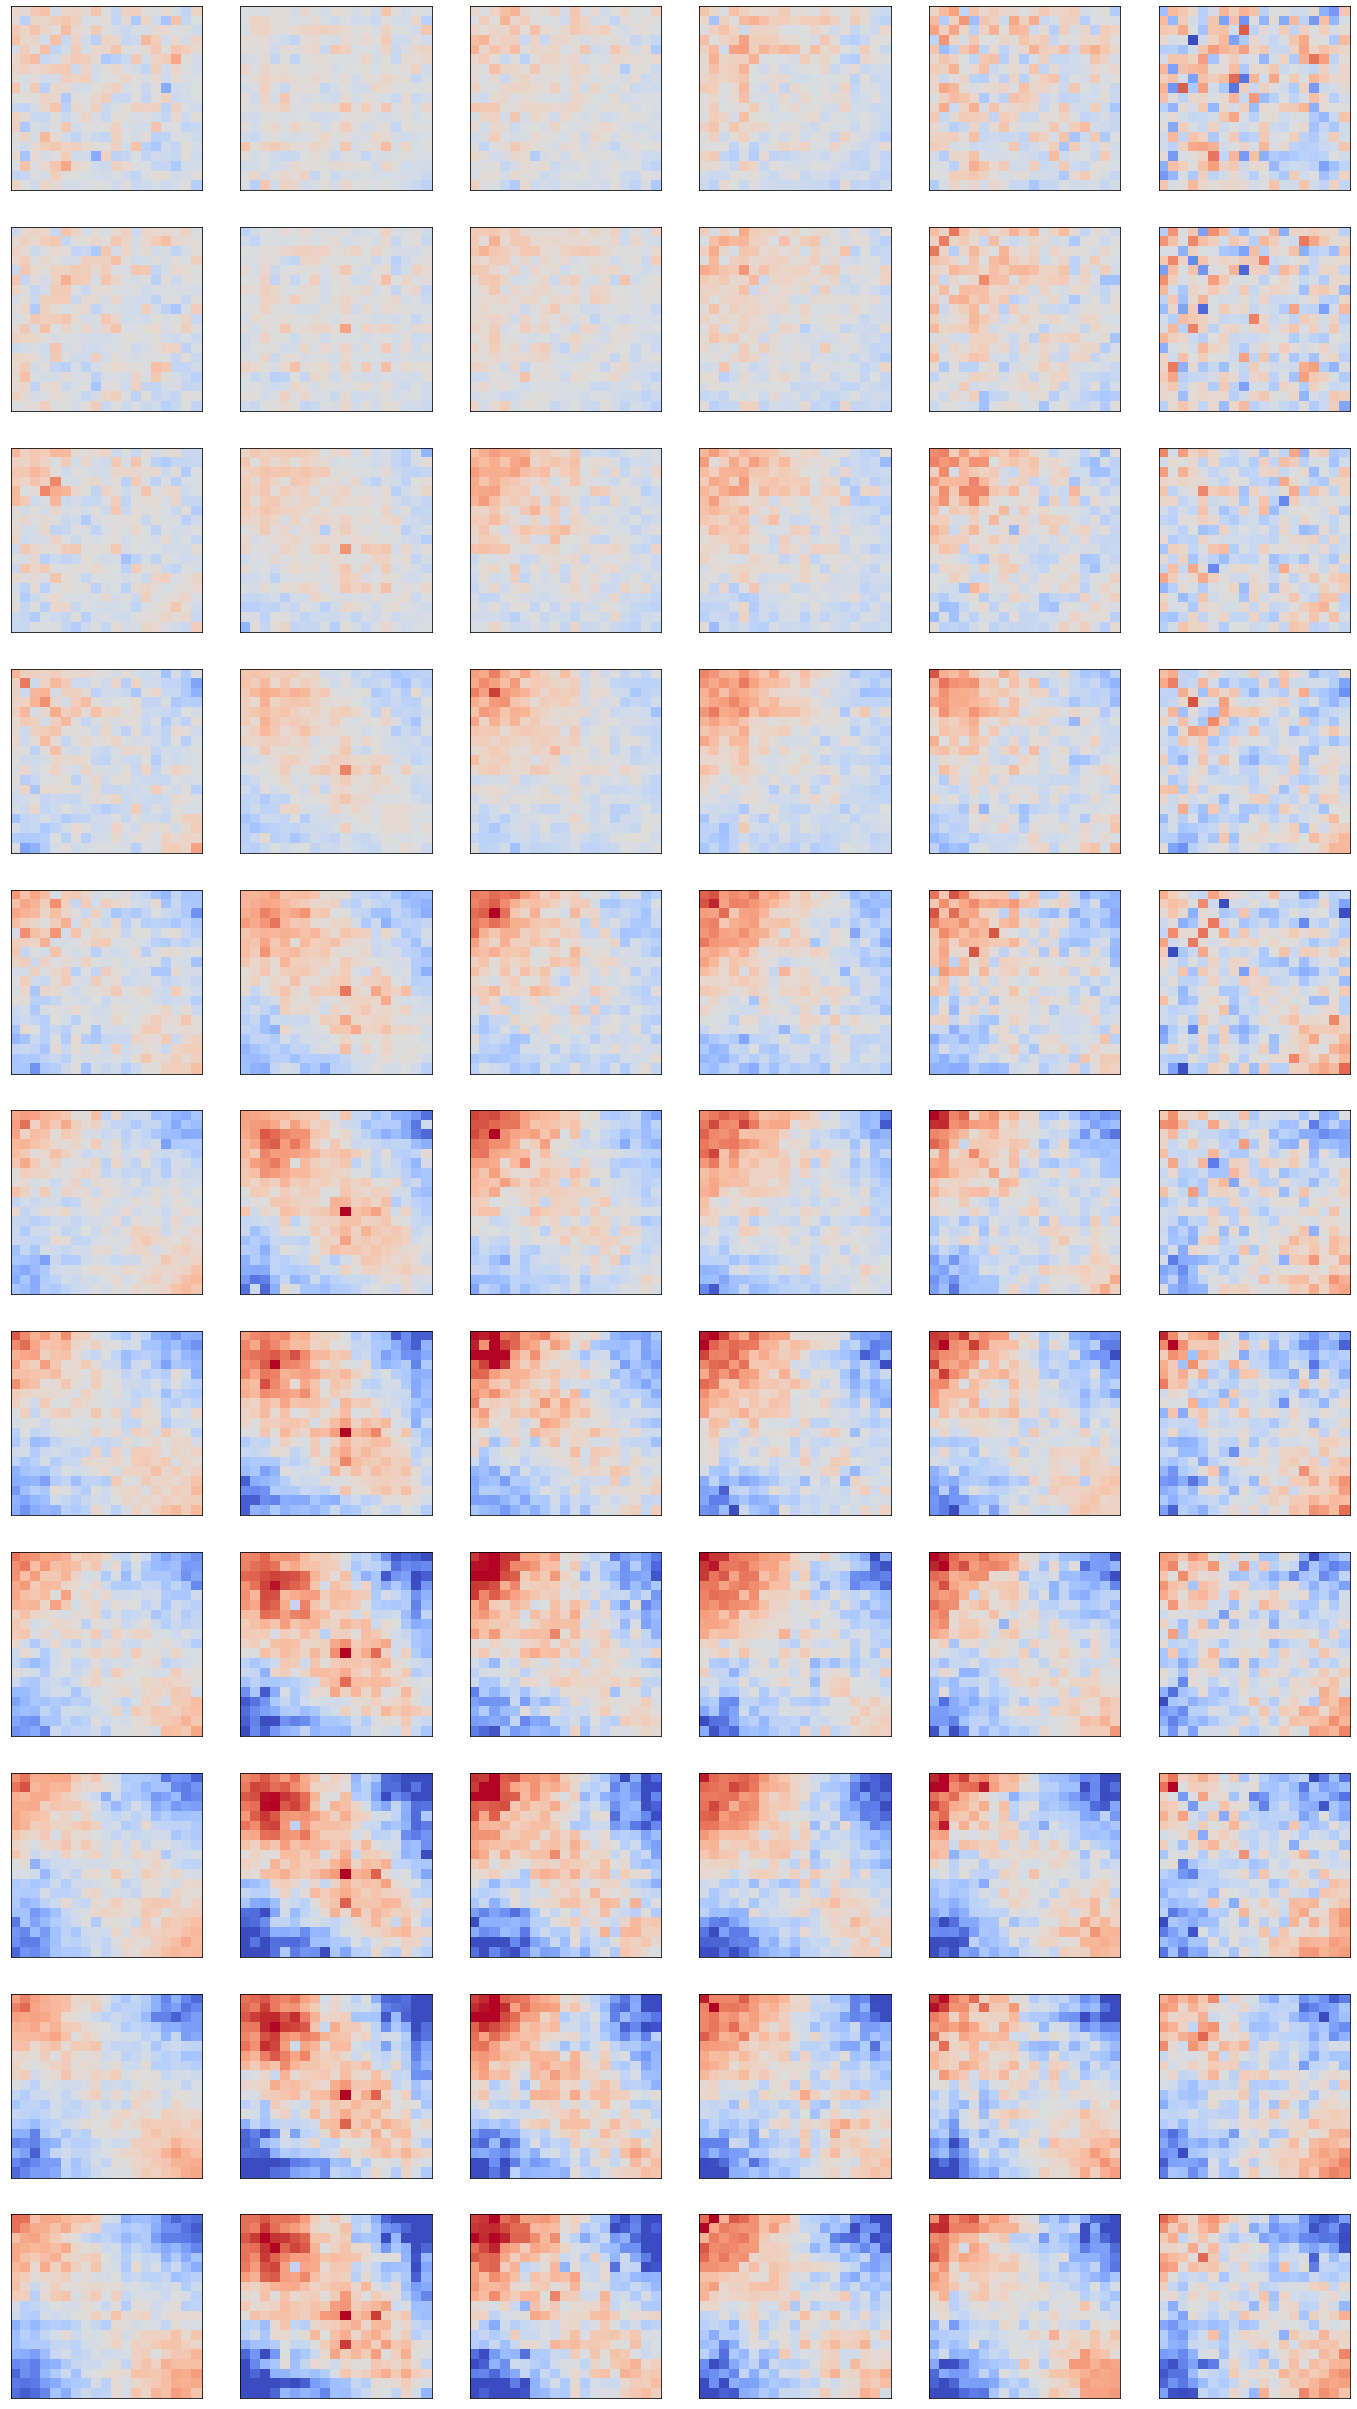

In [192]:
# calculate strength , separate from plotting saddles ...

# now prepare to plot this huge panel of saddle plots:
tcss = ['T0','T05','T1','T15','T2','T25','T3','T35','T4','T45','T5','T6','T7', 'T8']
# tcss = ['T0','T05','T1','T15','T2','T25','T3','T35','T4','T45','T5','T6']

# one we used for the paper:
tcss = ['T0','T2','T25','T3','T35','T4','T45','T5','T6','T7', 'T8']

binsize=200000
mb = 1000000
num_bands = 5
bind_width = 60
nrows = len(tcss)
gs = plt.GridSpec(nrows=nrows, ncols=num_bands+1)
fig = plt.figure(figsize=(4*(num_bands+1), nrows*4)) #width, height
eig_for_saddle = eig_dig.iloc[centro_idx:]

lads_index_adjusted = lads_binned[chrom]['index']. \
                        values[lads_binned[chrom]['index'].values>centro_idx] \
                            - centro_idx
# it is going to be a LADs based mask: True - LAD, False ciLAD
lads_for_saddle = np.zeros_like(eig_for_saddle['E1.d'].values,dtype=np.bool)
lads_for_saddle[lads_index_adjusted] = True



# some plotting preparations:
scale='log2'
vmin,vmax = -1,1
track_name='E1'
title='saddle'
#
color = sns.color_palette('muted')[2]
heatmap_kws = dict(vmin=vmin, vmax=vmax)
track_label = track_name
clabel = '(contact frequency / expected)'
if scale in ('log2', 'log10'):
    clabel = scale + ' ' + clabel



for row,tp in enumerate(tcss):
    the_index = row*(num_bands+1)+0
    # define the input matrix:
    matrix = tcs_dict[chrom][tp][centro_idx:,centro_idx:]
    mask = numutils.infer_mask2D(matrix)
    OE,_,_,_ = numutils.observed_over_expected(matrix, mask)
    S,C = make_saddle(OE, binedges, (eig_for_saddle,'E1.d'))
    saddledata = getattr(np, scale)(S/C)
    # plotting:
    ##############################################
#     saddle.saddleplot(
    saddleplot_simple(
        edges,
        hist,
        saddledata,
        color=color,
        title="arm-wide" if row==0 else "",
#         xlabel=track_label,
        ylabel=tp,
#         clabel=clabel,
        heatmap_kws=heatmap_kws,
        fig=fig,
        subplot_spec=gs[the_index])
    # #########################################
    # now the banded saddles ...
    ###########################################
    for band_idx,band in enumerate(bands):
        the_index = row*(num_bands+1)+band_idx+1
        ###########################
        # taking interactions within a certain genomic band:
        band_start_bins, band_stop_bins = band
        # saddle data reusing the same OE
        S,C = make_saddle(
                take_genomic_band(OE,band_start_bins,band_stop_bins),
                binedges,
                (eig_for_saddle,'E1.d'))
        saddledata = getattr(np, scale)(S/C)
        # plotting
        saddleplot_simple(
            edges,
            hist,
            saddledata,
            color=color,
            title="{}-{}M".format(band_start_bins*binsize/mb,band_stop_bins*binsize/mb) if row==0 else "",
#             xlabel=track_label,
#             ylabel=track_label,
#             clabel=clabel,
            heatmap_kws=heatmap_kws,
            fig=fig,
            subplot_spec=gs[the_index])
        
plt.show()        
#plt.savefig("2019July_saddlesByDistance_{}arm.pdf".format(chrom))

In [193]:
# now prepare to plot this huge panel of saddle plots:

# tcss = ['T0','T2','T25','T3','T35','T4','T45','T5','T6','T7', 'T8']
#  use more timepoints for the "kinetic" curves ...
tcss = ['T0','T05','T1','T15','T175','T2','T225','T25','T275','T3','T325','T35','T4','T45','T5','T6']
# tcss = ['T0','T05','T1','T15','T2','T25','T3','T35','T4','T45','T5','T6','T7','T8','T9']
tcss = ['T0','T05','T1','T15','T175','T2','T225','T25','T275','T3','T325','T35','T4','T45','T5','T6','T7','T8','T9']

# num_bands = 4
# bind_width = 75
nrows = len(tcss)

###########################################
# some strength calculations preparations:
saddle_bins_AA = 9
saddle_bins_BB = 9
saddle_bins_AABB = 9
###########################################
sad_str = {}
sad_AA = {}
sad_BB = {}
s_lad_ilad = {}
s_ilad = {}
s_lad = {}

###########################################
for r in range(num_bands+1):
    sad_str[r] = {}
    sad_AA[r] = {}
    sad_BB[r] = {}
    s_lad_ilad[r] = {}
    s_ilad[r] = {}
    s_lad[r] = {}

###########################################

for row,tp in enumerate(tcss):
    the_index = row*(num_bands+1)+0
    # define the input matrix:
    matrix = tcs_dict[chrom][tp][centro_idx:,centro_idx:]
    mask = numutils.infer_mask2D(matrix)
    OE,_,_,_ = numutils.observed_over_expected(matrix, mask)
    S,C = make_saddle(OE, binedges, (eig_for_saddle,'E1.d'))
    Slad,Clad = make_twobytwo_saddle(OE, lads_for_saddle)
    # strength calculations:
    # saddle.saddleplot(binedges, C, S, cmap='coolwarm', vmin=-1, vmax=1)
    sad_str[0][tp] = saddle_strength(S,C,saddle_bins_AABB)
    sad_AA[0][tp] = AA_strength(S,C,saddle_bins_AA)
    sad_BB[0][tp] = BB_strength(S,C,saddle_bins_BB)
    # strengths of lad and inter-lad interactions:
    s_lad_ilad[0][tp] = saddle_strength(Slad,Clad,1)
    s_ilad[0][tp] = AA_strength(Slad,Clad,1)
    s_lad[0][tp] = BB_strength(Slad,Clad,1)
    # #########################################
    # now the banded saddles ...
    ###########################################
    for band_idx,band in enumerate(bands):
        the_index = row*(num_bands+1)+band_idx+1
        ###########################
        # taking interactions within a certain genomic band:
        band_start_bins, band_stop_bins  = band
        # saddle data reusing the same OE
        OE_band = take_genomic_band(OE,band_start_bins,band_stop_bins)
        S,C = make_saddle(OE_band, binedges, (eig_for_saddle,'E1.d'))
        Slad,Clad = make_twobytwo_saddle(OE_band, lads_for_saddle)
        # calculate strength:
        sad_str[band_idx+1][tp] = saddle_strength(S,C,saddle_bins_AABB)
        sad_AA[band_idx+1][tp] = AA_strength(S,C,saddle_bins_AA)
        sad_BB[band_idx+1][tp] = BB_strength(S,C,saddle_bins_BB)
        #
        s_lad_ilad[band_idx+1][tp] = saddle_strength(Slad,Clad,1)
        s_ilad[band_idx+1][tp] = AA_strength(Slad,Clad,1)
        s_lad[band_idx+1][tp] = BB_strength(Slad,Clad,1)



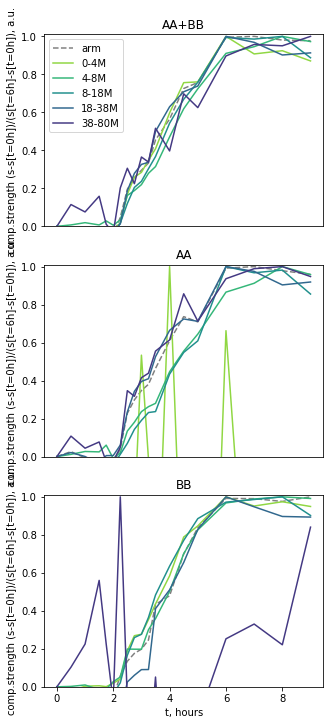

In [166]:
# this is all about LADs - useless stuff

def normalize_strength(strength,subtract_idx,divide_idx,divide_by_max=False):
    # Kristin's normalization - to make it fair to compare shape of the curves ...
    if not divide_by_max:
        return (strength - strength[subtract_idx])/(strength[divide_idx] - strength[subtract_idx])
    else:
        strength_divide = np.max(strength)
#         strength_divide = np.median(strength[-4:])
        return (strength - strength[subtract_idx])/(strength_divide - strength[subtract_idx])


# quantifying strength over time and with the distance ...
gs = plt.GridSpec(nrows=3, ncols=1)
plt.figure(figsize=(5, 12)) #width, height


#################################################################
band_names = ['arm']
# #########################################
# now the banded saddles ...
###########################################
for band_idx,band in enumerate(bands):
    band_start_bins, band_stop_bins  = band
    band_names.append("{:.0f}-{:.0f}M".format(np.round(band_start_bins*binsize/mb),np.round(band_stop_bins*binsize/mb)))
#################################################################


a_dfs = {}




titles = ["AA+BB","AA","BB"]
for i,a in enumerate([s_lad_ilad,s_ilad,s_lad]):
    ax = plt.subplot(gs[i])
    a_df = pd.DataFrame(a)
    a_df.columns = band_names
    # store dataframes ...
    a_dfs[titles[i]] = a_df
    
    # extracting float time from the label data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaYAAAFNCAYAAAD7K7jAAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nOzdd3hU1dbA4d+eyaT3DklI6L2HoohSVKQpKiKgUi1XvVdAUdR7UdSLYvsExasIKnYQsAGCDbDRCR0SQg8kJKT3MjP7+2MCJBBqMpkkrPd55pk5da8zCouzZp+9ldYaIYQQQgghhBBCCCGEEKK6GBwdgBBCCCGEEEIIIYQQQoirixSmhRBCCCGEEEIIIYQQQlQrKUwLIYQQQgghhBBCCCGEqFZSmBZCCCGEEEIIIYQQQghRraQwLYQQQgghhBBCCCGEEKJaSWFaCCGEEEIIIYQQQgghRLWSwrQQQgghhBBCCCGEEEKIaiWFaSFqOKXUGqXU/Y6OQwghhBBVS3K8EEIIUTtIzhbCPqQwLUQdopTqpZTSSqmnzrPdQymVq5T6sRJtHFZKFZSeJ0MptVwpFVFm+3ylVHHp9hyl1Bal1A1X2p4QQgghqifHCyGEEOLKKaXGKKUspfk4Vyl1UCn1cJntUaW5/NT2ZKXU/5RSJkfGLYQjSWFaiLplNJBe+l6RoUARcLNSqt75TqKUmqaUmnaBdgZrrT2BekAy8M5Z218r3e4DvAd8o5QyXtolCCGEEKICVZLjhRBCCGFX67TWnqX3w0OB15RSHc/ax7d0e1vgGuDR6g5SiJpCCtNC2JFSaopS6nhpz+E4pVRfpVRXpdQ6pVSmUipJKTVbKeVc5piblFKxSqkspdRsQF1iW+7YEt+jQFOlVHQFu40G3gd2APdU9vq01oXAYqDVebZbgS8BfyCksu0JIYQQNUVdz/FCCCFEXVGdObssrXUMsBdoeZ7tKcAvnOd+WoirgRSmhbATpVRz4J9AF621F9APOAxYgElAILZfR/sCj5QeEwgsAf5Tuv0A0OMSm7wTyAUWAT8Bo86KpwHQC/ii9DWKSiq9Ub4bWH+e7cbSdg5h61kthBBC1HpXQ44XQggh6gIH5OyybXcBmgGbz7O9fmk8Fd5PC3E1kMK0EPZjAVyAVkopk9b6sNb6gNZ6i9Z6vdbarLU+DMwBTo3BPADYo7VerLUuAWYCJy6xvdHAQq21BVsv5RFnjVU1Ctihtd4DfAW0ruCRokv1nVIqE8gGbgJeP2v75NLteaXXMLU0LiGEEKIuqMs5XgghhKhLqjtndy/thZ0LbAQ+A+LP2ie19H75OLZ75sWVukIhajEpTAthJ1rr/cBEYBqQopRaoJSqr5RqppRappQ6oZTKBl7G9issQH0gocw5dNnl8ymdfLA3tl5SAN8DrsDAMruNOrVda50I/E6ZcSpLY8osTZBPA0+fWlZKLTurySFaa19sCf6fwO9KqdAy298o3e4GRAOvK6X6X+w6hBBCiNqgtuV4IYQQ4mpVnTm71Hqt9akxpEOB1qXnLiuw9H7ZHfgbWHmFlydErSeFaSHsSGv9pdb6OiAS0MCr2CYDjAWaaq29gWc5M15VEhBx6nillCq7fAH3YfvzvFQpdQI4iO2mdVTpea4FmgLPlCbeE0A3bD2unEpjHVSaQH2BGcCMU8ta60HnuT6L1vobbL9CX1fBdq213oUt2Q48e7sQQghRW9WmHC+EEEJczaoxZ5/dbjK2IUEGn2d7ATAfuKZ0+BAhrjpSmBbCTpRSzZVSfZRSLkAhUICtgOuFbQiMXKVUC+DhMoctx/b47R2lN5OPYfuV9WJGAS8AHcq87gQGKqUCsPWaOjWpwqntbbD9QnvFPZmVzW2AH7ZJHSrapwW2ovXuK21HCCGEqEmuhhwvhBBC1AXVnLPPbjsAuJ3z3AuXxnQftmFC0i73/ELUBVKYFsJ+XLD1PE7FlmiCsf0KOxkYCeQAc4GFpw7QWqcCd5Uel4atB9TfF2pEKdUdiALe1VqfKPP6AdgPjACGAe+ctf0QtvGuruRR36WlY2ZlA9OB0Vrrssn2KaVUrlIqD/gZ+BjbmF1CCCFEXVCXc7wQQghRl1RLzi7jmtJ74VxsnbdOAv86a59TY1AnY5t48dbS4UKEuOoo+X9fCCGEEEIIIYQQQgghRHWSHtNCCCGEEEIIIYQQQgghqpUUpoWoJZRS7596JOis1/uOjk0IIYQQV05yvBBCCFE7SM4WomrJUB5CCCGEEEIIIYQQQgghqpX0mBZCCCGEEEIIIYQQQghRrZwcHcDlCgwM1FFRUY4OQwghRB21ZcuWVK11kKPjqAskZwshhLAnydlVQ/K1EEIIe7pQvq51hemoqCg2b97s6DCEEELUUUqpI46Ooa6QnC2EEMKeJGdXDcnXQggh7OlC+VqG8hBCCCGEEEIIIYQQQghRraQwLYQQQgghhBBCCCGEEKJaSWFaCCGEEEIIIYQQQgghRLWqdWNMV6SkpIRjx45RWFjo6FBqLFdXV8LDwzGZTI4ORQghxFVMcvaFSb4WQghRE0i+vjjJ2UIIUXl1ojB97NgxvLy8iIqKQinl6HBqHK01aWlpHDt2jIYNGzo6HCGEEFcxydnnJ/laCCFETSH5+sIkZwshRNWoE0N5FBYWEhAQIAnzPJRSBAQEyK/dQgghHE5y9vlJvhZCCFFTSL6+MMnZQghRNepEYRqQhHkR8v0IIYSoKSQnnZ98N0IIIWoKyUkXJt+PEEJUnt0K00qpj5RSKUqpXefZrpRSbyul9iuldiilOtkrFkeKiooiNTUVAE9PTwdHI4QQdc93W4/TY8YqGj69nB4zVvHd1uOODknUQpKvhRDCznZ8DW+1gWm+tvcdXzs6IlFLSc4WQgj7qs57bHuOMT0fmA18ep7t/YGmpa9uwHul70IIIezk08nPUpjWkRJnf0zF6bgGbGXUGy87Oqwr9t3W4zzzzU4KSiwAHM8s4JlvdgIwpGOYI0MTQgghxCk7voalj0FJgW05K8G2DNBumOPiqmWUUh8Bg4AUrXWbCrYrYBYwAMgHxmitY6o3SiGEELVZdd9j260wrbX+QykVdYFdbgM+1VprYL1SylcpVU9rnWSvmE75butxXv8pjsTMAur7uvFkv+ZV8uUOGTKEhIQECgsLmTBhAg8++GAVRCuEEFXj08nPkpfVE6uLCwAlLgFYsnoy/4lnufXFaVi1RmvbZC5WDRrbu9WqAbCWrq9wP6ttfdn9dJl3je08p/bXuvx+usx5T62H8u2dbrdMe9N/3Hs6YZ5SUGLh9Z/ipDBdR9gjZ0u+FkKIaqQ1/DrtTFH6lJIC+O1FKUxfnvnU0M5fco8thLga1dSOX1prLFZNiUVTbLFSYrFSbLa92z7rM58tVkosmpLS7S8s3U23gxsZs2cFQQWZnHTzZX6r/rz+k3PtKkxfgjAgoczysdJ1di1M27Py/9FHH+Hv709BQQFdunThzjvvrHS8QghRVQrTOp4uSp9iNbpQlNGVbi/8TImh7oyTl5hZcPGdRI1nr5wt+VoIIaqQ1pCfDplHbD2hM4+Wvsp8Ls6p+NisY9Ubay1XUzt/yT22EOJqdN6OX48+SdtxD1Bs1ZRohdmqKbFqiq1QohUlVislVii2aIo1FJuhRGuKrZpii23fEguni8ZnCspniswlFislpcXl8+1T2m/ssvVK2MKEbYtxtZQAEFKQyYRti3kbgD5V8t2V5cjCdEUVkAq/NqXUg8CDAA0aNLjgSV9Yups9idnn3b71aCbFFmu5dQUlFp5avIOvNh6t8JhW9b15fnDrC7YL8Pbbb/Ptt98CkJCQQHx8/EWPEUKI6lLi7F/herOzNxOzrLhYMnD2AkOYL7p5OKYgdwxGA0qBQaly70opDKXLtnr2meXz7acos2wov1x2Pyg9r+Hc487eb+j7a0nOLjrnmur7utnlOxRVy1E5W/K1EEJcBq0hL7W0yHx28bm0AF2SV/4YF2/wbQB+kdCwJ2xfAIWZ557bJ7x6ruHqYZfOX3KPLYQQ5zpfxy9zXnfc77kN90qc24pCl97zamVAq9Llc94Np5dtN+KGM5+VAWWwvWNQqLPfDQplMNhe6sznkvh9mKzln0p2tZQwLnYl8FwlrqpijixMHwMiyiyHA4kV7ai1/gD4ACA6OvoKa/42ZyfMi62/VGvWrOHXX39l3bp1uLu706tXLwoLCyt1TiGEqCrJMTtAW0EZz9nmVJKNpeQvTOZICq0NKCkwwv4kDNqCr1sRwQ08qd85itDmQfgGu9uSWw3xTP+W5XroALiZjDzZr7kDoxJVxR45W/K1EEKcxWqFvJTSHs5HbMXms3s+m896EsnV11Z4DmgCjfvYPvtE2N59G4Cbb/n9wzqXH2MawOQGfav+BvcqZ5fOXxcj99hCiKtNYdLx83b8KnL147dejxOkdtHMIxsP/zAs3uEYDUaMgBGNUYEBbVtWoNBoq5XSMSxBW0uXseVpbUWf2ma1ovXFtp1ZBo0+9Vlr2/YLbMuN21vhdQXkV/ADcxW4osK0UipGa92pkm3/APxTKbUA27hXWVXxiNHFfnXtMWMVxyt4xDvM142FD11zxe1mZWXh5+eHu7s7sbGxrF+//orPJYQQVanweBI/vbkePKJQ1hK0wXR6m8FShJvfRu74xy38te1D1h1+l+zkIBqcbEBQXiQWYyTxeQ2I3XcQOIiTMhMYoAhpHky91vUIjvLG088FpRxTrD71eKg9xjSsKy4lZztqMiVH5GzJ10KIq47VCrknygyvceRM0TkrwbbOctbTR+4BtkJzUAtoevOZgvOpArSr9+XFcGoc6d9etA3f4RNuK0pfReNLV9E99MXYpfOX3GMLIYSNtaiI+P+9QeHHX+DS6QWKXAPO2cdgzifDxw2VdxupuZBvPUC9gs30bVBAvdZdoVEvCG5l691cA8X36Ys58dzUYapXzy7tXVFh+lISqlLqK6AXEKiUOgY8D5hKj38f+BHbDe5+bDe5Y68klsv1ZL/mduldd8stt/D+++/Trl07mjdvTvfu3SsbqhBCVJo5M5PvJ39Ojk9ncvy/pn6x/3knZ7ilyY3cYi6mJP5nNu2Yz6qTX/O30YRvspE2x0JomtMMU1E9crIi2JGi2f53GgCuJgtB4R7Uax1KcEMfQiK9cfU0XSisKjWkY5gUoi/gEm+C51MDJ1OyR86WfC2EqA0uazIlqwVyks4a27lM8Tn7OFiKyx/jEWQrMoe0geYDzi08u3hW+TUt9/RgVkR9TvgbCPUIZYKnBwOrvJWaqxqK0mCnzl8XI/fYQoi6TmtN5i8/c2j687glZ7G7KSin71HW0WjDmaeSDZYiPHzX8o/Xp7M5bgd//xFD8T43sk7ezTcnoWDPQcLcZtLHYychzVvbitSNetnybw0RPGkiSVOfQ5d5QkW5uhI8aaJd2rPbUB5a6xEX2a6BR+3V/vnYq3edi4sLK1asOGf94cOHT3/Ozc2tVBtCCHE5rIWF/PToLFJ9epLh/iMTnn0ZL8+zHze6q/yikzOmloO4tuUgri3KRccuZ8/Oz1jlt5Ov3I9x0MlEZAr0TAmkdVoTnNK8yDEGkZYZScLBfNv4VYCXlyKkiT8hjf0IjvQmqIEXJpdzhxERNUNNnUzJHjlb8rUQoqY732RKX0ycxD1jupw1vnNp4dlqLn8SzxDbTW5YJ2g9pHSYjcjSwnM4OFdm5MvLt/zgcqatnUahxXaTm5SXxLS10wAY2OhqKk9XTk3t/CX32EKIuqxo/34OTvs3bN7ByUDYc1sxLVyDsPaaTOHCYyirE1qZzvkhuUuL9nRp0R6rtrIhdivr/t5FYZwr6ekjWZwORWlHCIv5k97G6QQHup0pUje8HtwrHiakOvgMHgxAylszMScl4VSvHsGTJp5eX9UuWphWSuVwZlwqZ2yJL09rfZnPb9Uc0rtOCFHXabOZ9Y+9ymGvnuQ4bWbQ/YMqKEpfhIsnqv3dtG5/N63zUvnX7m9J2LmAVaY4VjUr4nOXNKxoWhUFMCivKd2Ou2I9ZCE9x4ls7ygSTkayf6utTYXGL9SNkEZ+BEd5ExLljX+YB0ZjzXx8qbayY862y2RKl0JythDianO+yZSy8m5m6qLNWAzFWI0+WJxaYXVqgdXditWksZg0VhNYTKBNVixGM1ZtxpJ9BJ13EGuypfwIxGeNwqUqGJ747HUVDd1V0XFn25W6iwbJbel2dBCexX7kOmewocEyZsXMqpOFaXvl45ra+QskXwsh6h5LVhbJ77xNxpdfke+s+fEmJ64LO0lgbg9O3jSDm+sHs4R0+oxrSYvup4a5uOuc8xiUgWtaduaalp2xWC2sjd3M+rW7KYgzkZo+gkWMoDg/kYiT6+i1YQqBTslQr92ZQnWDa2zzMlQjn8GD7VaIPttFC9Naa6+yy0qpIUBXu0UkhBCiUrTW7PnPm2zX3ShUh4i4sYgOrXpV7qQegdD1ASK6PsDojCOM3rWE9J1f83v+UVZ5FDIrIIOiAI1XZy9u8utOn2xFjyP7yd0ez8mEPLLcw8lJi2T/8UbsXWtLqkajIjDCi+CG3oREehEc5V3jJlesbeyYsx0ymZIQQlyNzjeZkjY445XVDidtwslqwqgv/0kkq9GM1cmM1Wgp/Vz6bixd52Q+d32Z/S1OZ60zmM8cY7SAQaPPSg8aTYPkttxwcDgmqzMAXsX+3HBwOL+z4PK/oFpA7qGFEKL20hYLmYsWk/TWm+jsHH7toMi6xoXHMo/yVs69NBn0OKOuieLPhfswOhlo1D7oks9tNBjp2aobPVt1w2w182fsejb8vZeifc4kp97JQu6kxPMkDU7u4vrj3xL49ywwukBE6djUjXpD/Q5gqDtPI1/2UB5a6++UUk/bIxghhBCVd/T/3mNtclNKnHPJabeSJ4YsqtoG/CKh5+P493yc25N3c/vOReTvXMy6klRWexayqmQ132DGVM9E907d6RPalx7ZoZh2HyB/yzLSdx8mE3+yvSPJyW7CnsPh7CxNR86uRoIivQmJshWqgyMdO7libVeFOdsukykJIYQoT2uNwVqE1eh6zjaXonTaJS5iTaf+/OIeSUJ6ASbApMHTyUgTf3ca+rnTwMedcE9XQjyccTcaKCmyYi62UFJswVxsxVxkKbdccnrZijmvzOdiy3l+gjw/g5PC5GzEydmIk7MBk4sRJ5OR44dTMVrLzz9hsjpz7bHbKvFt1R5yDy2EELVD/qZNJE2fTnFsHHsjFD8M92O8IZXojEweKnqSm28dyX3dI7FaNfu3pBDZNgBntysbJdnJ4ETvVtfRu9V1lFhK+D12LRv+3kvxfhdMx3qzkN6YvTOJDEnguoxVBK56CVa9BC4+0LDnmR7VAU2gFt8vX8pQHneUWTQA0Vz2P1GEEEJUh5RPv+T3GHeKPV3Z3eJtZo//zr4NhrSGkNa493mOvgkb6LtzEebd37JN57HK249VbOLP43+iULQNa0uf7n3oFf4ELVM1+VtiKNgaQ96WBWRmmMn2iiTHrzG5+c1JivPDim2YDzdvZ0KivAmO9Cp9Lz+54r4NJ1j3/QFy04vw9Hfhmtsa06xbqH2vu4ayY852yGRKQghxNdFa8+fXsViNriir5ZzJlAJKfic0K5mhC1/jnlYt8Rw1luPtu7MvtYDYEznEnchhRWIGafHJp48L8HCmeagXzUK8aBHqdfqzh8vFb6K11lhKrOcUsE8XrovKF7Ft20/tX/4Yo7Xi9twLa+3okBck99BCCFG7lCQmkvz66+SsWEmGjxPzhxgI69GJd7b/RAEBDC6cxrgh/binWyQAifsyyM8upml0SJW0bzKauLH1DdzY+gaKLEWs3vsXG9fuxbzfHaf4tiykLRaf+4lqmMO1njsJTFoGsctsB3uHQcMbSgvVN4BX7boXvpSyftlBRczAYWyTIAkhhKhBslasZM33J8gJbMf6JnN46c7XMDmf2+PKLgwGiLwGIq/Bqf+rRB9YTfTORTwZu5x4ilnlH8LqzKPMPDmTmTEzifKOok/TPvTuM4J2Qa9gSTlJQUyMrVgds4C8uP3kutcnxyeKvLC2pOU34PAON06NKOEd6EpIlDcY4MDmZKxW2/rc9CJWfbob4GotTl9Rzq6pkykJIcTVZPOPh9m5Oomw47+T5XGEIreBlDj7n55M6fa5s7EWF5O9dClp8z4k7emn8IqI4KaxY7jrjjswuNpyfmpuEXEncog9kcO+EznEJuewcFMCBSWW021F+LvRPMSb5qGeNA/1pkWoFw0DPTCVmftBKVXa87nyjwt/8uzf5KYXnbPe07+a/p1S/eQeWgghagFrYaEtp86bi9li5pvrDGzqE8q/vZvSffMX7HVpz4isR5hyx7WM6HpmmML4TcmYXI1EtQ2o8phcjC7c0qYvt7TpS35JPqti/2Dz2jjMB9wxbGtIAjdh9b2Ohq2c6R5ygoDMX1H7VsD2L20nCGppK1A36gWRPcC1Zv8IrGzzI9Qe0dHRevPmzeXW7d27l5YtWzoootpDvich6q689RtY/d/vORJ+I5vClzDsmlYM6OuQuW/KK86DuBWwcxHs/5UTSrM6JIpVPoFsLkrBrC0EuAbQK6IXfRr0oVu9brgYXbDk5lGwfRsFW2LIj4mhYPt2Soo1OV4R5Ia3Iy+0FZnGIPKLKr5Z9nCzMuatG68oZKXUFq11dGUuW9hIzr4y8h0JcfXZ/lsCfy2KJ/DkOjzTv6L3yvW4u3ied39ttZK7ahWpc+dSuH0HRn9//Efdh9+IERh9fM7Z32rVHMsoIPZEtq1onWwrWh9MzcNitd0PmoyKxkGeNC/tWd08xPYe5utW6SG19m04weovYjEXW0+vc3I20PueFpX6IVlydtWQfH3l5HsSonbSWpPz008kv/Ya5sQktrVx54Pri7i5yzAmHN6De9wKVnv056H0Ebx0R0fu7nKmKG0xW/n4qb+IahvIjWNbVVvMucW5/Lp3DVvW78N6wJPQ7EYYMKB9CmnYMYCuTQ0EFqxFHVoDR9aBuQCUEcI6nxn2I7wLODlXW8ynXChfX9FAKEqpQVrrZZULq24ZN24cy5YtIzg4mF27dgEwbdo05s6dS1CQbSD0l19+mQEDBrBmzRp69+7NvHnzGD9+PABbt26lU6dOvP7660yePNlh1yGEqH0K9+xh43MfcaTR3ewL+Iu24Wk1oygN4OwBbYfaXvnphO7+lhE7FzNi71qyDYo/w1qz2uTHikM/siR+Ce5O7vQI60GfBn3oGd2ToB49ANAlJRTGxlEQs4X8LTHkx7yHJTWVVTfMrnA8rbz82jvGVlWTnH0uydlCiJpkz1+J/LUoHq/8GJrHfkn2u89esCgNoAwGvG68Ec++fcnftIm0efM4OXMWaR/MxXfYMPzHjMYUeqbgazAoGgS40yDAnZtbn1lfZLZwICWPfck5pcOBZLP5cAbfbzszjYCXixPNzhoOpHmIF34el35je6r4fDUPvSX5+PJJvhZC2ENhXBzJ018mf+NGMiN8mTnSQG6bUN5o/y86//JfdPJuPvf9B1OTe/LqHe0Z1iWi3PEJe9IpyjfTJDq4WuP2dPZkSPtBDGkPWUVZ/LJ3NVvW70Md8kavcebwGgP4NKNRpx5E39OQQL0bdeh3OLgG/nwD/ngNTO4Qee2ZQnVwa9vTzw50ZSN0QxdAkmoZY8aM4Z///CejRo0qt37SpEkVJsG2bduycOHC00lzwYIFtG/fvlpiFULUHcUJCWyf+DJ7o0aR7BGHJXwZk+7929FhVczdH7qMt70yE/DetYSBOxczcMcqipWRjQ27sMonhNXJMfxy5BeclBOdQzvTO6I3fSL6UK9tG9zatsF/9Gi01pQkJPD3cxsocj338SmXonQHXGCNJTn7LJKzhRA1RfymZFZ/EYun2kfnTfPZcEsDxvW655KPV0rh0bUrHl27UhgbS9q8D0n/7DPSv/gCn8GDCRg/DpfGjc97vIuTkVb1vWlVv/xjvtmFJew7kUNccs7pYUF+3JnEVxuPnt4n2MulXM/qFqHeNA3xxNVU8dNMe5wtfOBdRKK1gPre4ONsodklX2mdIPn4Mkm+FkJUJXNGBifffpvMhV9j9XBj0WAfvm+dx71txvFI0DW4LRqDLs7jDf8X+V9iI167sx13RUecc559m5Jx9TAR0crfAVdh4+Piw9AOQxjaAdIL0/l572/EbNiP8ZAv1tVOHFydDd7FNOk8kI43TyAoyII68jecKlT//B/bidwDoeH1ZwrVfrYxtNnxNfz2ImQdA59w6PsctBtml2u5osK01vr5qg6kWtnhC77++us5fPjwJe/foEEDsrOzSU5OJjg4mJUrVzJgwIBKxSCEuLqY09KI/cdktje4l1yXNHY3mcecOxdjcDJd/GBH842A6ybaXil7cd65iOt2LuK6g+v5j5Mru5pczyr/UFbnHWHGxhnM2DiDlv4t6d3AVqRu5tcM5wYNaJrxOnuCB2A1upw+tcFSRNOMP4C7HHd9NYjk7HNJzhZC1ASHdqTy68d78PLMpPmqdzkSorn9pc+u+HyuLVoQ9sbrBE2cSPrHH5O5ZAlZ33yDZ9++BNw/HveOHS/5XN6uJqKj/ImOOnPTrbUmJafodM/quBO5xCVn89n6IxSZbUN0GBREBnicLlafem0/msm/v9t1epzr45kFPPPNTgCGdAy74muuTWp9Pr4YyddCiBpKm81kLFjIyXfewZqbS2yvKF5td4SQ0MZ80uMl2p3YB5/djtUzhCnuL7I4wYs3hrbnzs7h55yrpNjCoR2pNO8agtHo2J7Gp/i7+jO8410M7wgn80+yMvYXtm7Yj/PhAKyrjexfnYnyLqFJp3Dad59KcP/XUDlJcLC0SH1wDez+xnYyv4a2v8MTNoCl2LYuKwGWPmb7bIfi9CUVppVSbYBWwOnZKbTWn1Z5NNVhx9e2L7SkwLZs5y949uzZfPrpp0RHR/Pmm2/i5+d3etvQoUNZtGgRHTt2pFOnTri4uFzgTEIIcYYlN4+DD/2LLYFDKDDBL63e54WOTxIY3NDRoV2+4Ja2m5c+U+HYJgw7vqbd7m9oF5vGRFcfDje/idUBYazKPcR720zRCfUAACAASURBVN7jf9v+R5hnGL0jetOwr6bxt19yNPJWilz8cSlKp8GRH9D3NnX0VTmM5OwrJzlbCFFdEmLT+emDXfgEKcI2P49boRnjq0/g5xlY6XM7h4cROvU/BD76CBmff0HGF19w5LffcIvuTOADD+Bx/fVXNGa0UooQb1dCvF25oVnQ6fUWq+ZIWt7pntVxJ3LYl5zDz3tOYL3AdEYFJRZe/ymuzham61Q+vhjJ10KIGipv/XqSp79MUXw8RR2a8VoPJ/b4HGdcmwf5R9sHcf7r/+D3V7FEXMPDxZP49aiZ/xvWnts7nluUBji8IxVzkYWm0SHVfCWXJsg9iPs6jeS+TpCUm8RPsb+ybeN+XI4GYf7dQPyadJSXmSadQmjXfQAhtw9HAZyMO9ObOm4FcFYCLymw/fjoiMK0Uup5oBe2pPoj0B/4C6iZSXXF03Bi5/m3H9sElrNmhC4pgO//CVs+qfiY0LbQf8Zlh/Lwww8zdepUlFJMnTqVJ554go8++uj09mHDhnH33XcTGxvLiBEjWLt27WW3IYS4+ujiYhIee4zNxuvIcwtkect3Ge7bkmu7D3d0aJWjFER0tb1uecX2C+7ORUTtXcbY4lzGetUnteUAfg+MYFV2PF/HfU2xTzE9ulgYuWYzAdmQ5g1f9lIc9Emml6OvxwEkZyM5WwhR4yUdyOLH/+3AJ8iFxomP4XXAzB/9w3mw7/gqbcfJ35+gx/5FwPhxZC5eTNr8T0h46B+4NGtGwP3j8e7fH2Wq/FNWRoOiUZAnjYI86d+23un1hSUW4pNziUvOYfKi7RUem5hZUOn2a6Jal48vRvK1EKKWKT52jJRXXyPnl18w1K/Hb/+IZo7vVpr7t+CrHi/R0isSvn0I9nyHud1IRqcMZ93RXP5vWIcL/mAavykZDx9n6jX1rcaruTL1POsxJvo+iIaEnARWxv7C9k0HcD8aivkPiP89DYOXhaadQmjTLZKQLg+iuj0E03zZl9+Tdbn3kmsNxNOQyjWen9OMv+wS56X0mB4KtAe2aq3HKqVCgHl2iaY6nJ0wL7a+EkJCzvyC8sADDzBo0KBy20NDQzGZTPzyyy/MmjVLkqYQ4qK01crxKc+w7WQDMsJasKbxl0Q7n2T88G8dHVrVMpqg6Y22V3E+7FsBOxcTuPkT7rSWcGdAU/Lb3EG3owv4u7WRv1uXP1zlJTkmbseTnH2FJGcLIarDyaM5LJu9HQ9fFxq5z8e4MYeDoQYGPv/hFfVivhQGDw/8R4/Gb+RIspYvJ23ePBKfmkLKzJkEjB2H7513YHB3r/J2XU1G2ob70Dbch7d+2cfxCorQ9X3dqrzdGqJu5eOLkXwthKghrPn5pM6dS/qHH4HRSMboAUyN2ES63sWj7f7J+DbjMeWdhI/7Q9J2ivq8wH17urL5SAZv3d2B2zqcvyhdlF/Ckd1ptL0hHIPBPjnbXiK8InigyzjoAoeyDrEi7md2bDqI17EwSv7QxP2eisHTSrPOoXgW38+WnL5obXviJNcazK85j4J7gF3mhriUwnSB1tqqlDIrpbyBFKCRHWKpGhf71fWtNrZHi87mEwFjl1dpKElJSdSrZ+s18O2339KmTZtz9nnxxRdJSUnBaKx4khAhhDhFa03yjBns2ZHP8aYD2VnvV1y81/Hs8NW23sZ1lbM7tLnT9spPh70/wM7FuP/+OvXC65FkOjeVhVou8Oxw3SY5+wpJzhZC2Ft6Uh4/vL0NZzcj7XskUjjrV5yLnCmYMp5w3wZ2b1+ZTPgOGYLPrbeSu+Z30ubNI3n6dFLffRe/e+/F756ROJUZEqEqPdmvOc98s/P0GNMAbiYjT/Zrbpf2aoDalY8vRvK1EKKG01qTvfxHUt54A/OJE7j0v4kPexbzQ87PtPZtzXs9XqSZXzNI3ApfjYCiHAqGfs6ov/zZciSDmcM7cmv7+hds4+C2k1jNmqZdauYwHpeqoU9DHun6ELqLJj4znpVxP7Nt82F8jkdQ/IcFJ33u2Pxau7Aqe5jDCtOblVK+wFxgC5ALbLRDLNWj73Plx78CMLnZ1lfCiBEjWLNmDampqYSHh/PCCy+wZs0atm3bhlKKqKgo5syZc85x1157baXaFUJcPdLmzSN+WQzx7R4m0XcHcWHfM7vrW3j6BDs6tOrj7g+dx9heWceY8EEXpgX6U2g4M/GEq9XKhLQMh4XoYJKzL4HkbCFEdcs6WcAPM7eiDIqbRoVS8Oa9OB105bd+ITzcb2K1xqIMBrz69MarT2/yY2JImzuP1NmzSfvwQ3yHDiVgzGhMYVU77vOpx6Jf/ymOxMwC6vu68WS/5nV2fGnqWj6+GMnXQggHKti9m+TpL1MQE4NLq1YcfuIOpuUuoDCvkEmdJzGq1SicDE6w+1v49mHwCCL/vhWMWpbL1oRMZg3vyOCLFKUB4jen4B3kRnCkVzVclf0ppWjm14xm3Zuhu2n2pO/hp7hfMH7aFsW5Hd/M+a4VnKUK4tD60nuVKaWiAG+t9Q67RHMJoqOj9ebNm8ut27t3Ly1btrz0k9hhxuDa4LK/JyFEjZG55BviX55NTJcpZLqnsqj1mzzj148773jF0aE51lttWG5OY5afLyecjISaLUzIyGSgUwBM2nVFp1RKbdFaR1dxpNVOcnbtJflaiLolN6OIb9/cQlGBmdsndSDl49so+DaJE14GGi1aRIvg1hc/iZ0VxceTNu9DspYvB63xGTQQ//HjcW1mj75RVac25OyakI8vRvL1lZOcLYTjmNPSODlzJpmLl2D088PlkXG8FryZP5L+on1Qe17s8SKNfBqB1vDH67B6OkR0I3fIfEZ/fZhtCZm8PbwjA9vVu2hb+dnFzH/6bzr1a0D32xpXw9U5zozHFuNV7H/O+hzndJ5+e+gVnfNC+fpSekyfprU+fEUR1DTthl0VSVIIUTfkrF7NkZdeY2e3ZylytvBti/cYag7gzttfdnRojtf3OQYufYyBxxLPrDO5Qb/K9dCpCyRnCyGE4+VnF/PDrK0U5JZw28SOJK1/B8u6I5gKXUj6z50MqAFFaQCXpk2p/+oMgiY8Rvonn5CxaDFZ3/+A5w03EPDgA7h37uzoEGutOpOPL0bytRCimuiSEtK/+ILUd/+HtaAAv1GjWNcvnNdi38WcYmZKlymMaDECo8FYOhHro7BrCbQbTvbNbzD60x3sPJbF7BEdy03aeyEHYlLQ1to/jMeliGv6J+339sdkdT69rsRQTFzTP7FNoVC1DBffRQghhKPkb93K0cefYlfnxyh08uD7Zu/QwZLFE/ctqdvjSl+qdsNg8Nu2MQxRtvfBb8uNkRBCCIcryi9h6TvbyEkrZNCj7aBoL8E/zcb5oAu/9fblnlv/7egQz2GqX5+QZ56h6arfCHzsXxTs2MGRe+7l8IiR5KxahbZaHR2iEEKIq1jun39x8LYhpMx4Fbf27fH4ag5TOx/guZ2v0jKgJd/c+g33trrXVpTOOQHzB9qK0n2fJ7v/O4z6pLQoPfLSi9IA8ZuS8a/vQUB9TzteXc0wdODNrG2yhBzndDSaHOd01jZZwtCBN9ulvcvqMS2EEKL6FO3fz9F/PExc61FkmkL5s+FHuLoc5tne8zG5ezs6vJpDeugIIYSoYYoLzSybvZ30xDwGPtKOkAgTif8dx8ktPiQHw7VT3sTVyT5jNVYFo68vQY88QsDYsWQu+Yb0jz/m2COP4tykMQHjxuMzaCDK2fniJxJCCFGjZS1dSspbMzEnJeFUrx7BkybiM3iwo8M6R/GRIyTPeJXc1asxNWhA2P9ms7xeMm/FTEShmNp9KkObDcWgSvvfJm23TXJYkAF3f05W1C2M+mgju49n8e49nejXOvSS285JLyTpQBbdbqu9c9hejoGNBsIQmBUzixN5Jwj1CGVCpwm29XYghWkhhKiBSpKSOHr/AxwOu5Ekz9bEh/3CwYCtvFxvPA2adHN0eEIIIYQ4D3OJhR/f20ny4Rz6PdCaBq0D2D1nLComH1OhK3ufvInHG9SOydkMbm7433sPfsPvJnvFStLmzSPp2Wc5+fbb+I8eje9dd2H09HB0mEIIIa5A1tKlJE19Dl1YCIA5MZGkqbYhEWtKcdqSm0fanPdJn/8JymQi6InHybu9N49t/i9bNm7h2vrX8vw1z1Pfs8zkhXuXwTcPgJsfjPuJLN+WjPpwA3uSsvnfPZ24+TKK0gDxm5MBaBpd94fxOGVgo4F2K0Sf7bKH8lBK7S19/dMeAQkhxNXOkpnJ0QceINHUiAPBfcgKPsBvEcsYZ23GjbdMdnR4ohaRnC2EENXLYrHy09zdHI/LoO+oFjTuGMyhPxcQvnk56qArK3u6M/6Olxwd5mVTTk74DB5Ew+++JeKDOThHRJDy6qvs79uXlFmzMKenOzrEGk3ysRCiJkp5a+bpovQpurCQlLdmOiiiMnFYrWR+9x0H+/cnbe48vAcMIGrFcpZf68zQlSPYl76PF699kfdvfP9MUVpr+PNNWHgPBLeCB1aT5dOS+0qL0u/d0/myi9JgG8YjOMobnyC3Kr5KAVfQY1pr3VIpFQB0t0M8QghxVbMWFJDwyKOkpin2droH5V/AwobvMiDfyEMPfOXo8EQtIzlbCCGqj9Wq+e3jPRzekcr1w5vRvHs98k8ewXfFZA5uCSA5CNo+8QI+Lj6ODvWKKaXwvP56PK+/noLt20mbN4+09+eQ/tHH+N55J/7jxuIcHu7oMGscycdCiJrInJRU8frERLJ/+hn3Th1xCgqq5qigYMcOTkyfTuH2Hbi2a0f47HdIivRi3Non2HFyBzeE38DU7lMJ8SjTg7mkEJY+BjsWQpuhcNtsMkuM3PvhevadyOX9ezvTt+Xl93jOOJFHakIu193VtAqvUJR1yT2mlVIeSikjgNY6TWu93H5h1T7jxo0jODiYNm3anF43bdo0wsLC6NChAx06dODHH3+s8NipU6fSrl07OnTowM0330xiYuLpba+88gpNmjShefPm/PTTT6fXR0VF0bNnz3Ln6dChQ7n2hRC1izabOf74E2TsOcyurhNx8jLwVcRLtCgu4skhC1CmmjsWpahZJGdfmORsIURV01rz+xexxG9O4ZrbG9O2VzhYLSTNH0PyNmdMBbBhXBf6Na2ex2Krg1v79oS/8w6Nli/He/AgMhYt4kC/Wzj+xGQKY2MdHV6NIPm4ciRfC2FfTvXOP/nf8QkTiO95PftvupnEKVPIWLCQwn377DoJrvnkSRKfeZbDw+6mJDGReq+8QviXn/GFYRNDlw7lSPYRXun5Cu/0ead8UTo3BT4ZbCtK9/4P3DmPzBIj98zbwL4Tucy578qK0gDxm1NAQZPOwVV0leJs5y1MK6UMSqmRSqnlSqkUIBZIUkrtVkq9rpSSnwvKGDNmDCtXrjxn/aRJk9i2bRvbtm1jwIABFR775JNPsmPHDrZt28agQYN48cUXAdizZw8LFixg9+7drFy5kkceeQSLxXL6uJycHBISEgDYu3evHa5KCFFdtNYkPf88mX+sZU/f57AoJ1aEvwZO2Uxu9SSB9Vs4OkRRg0nOvjySs4UQVUlrzd+L9rPn7ySiB0TRqV8kAHHfTCc4fjf6oAvLezjz0LDXUEo5ONqq59KoIfX/+1+a/PoL/qNHk7t6NYeG3M7R+x8gb/0GtNaODrHaSD6uWpKvhbCv4EkTz5nIVrm6EvrKy0R+9SXBTz2Fa4vm5P71NyemTePQrbexr/s1HH3wQVLff5+8DRuxFhRUOg5dXEzahx9y4Jb+ZC1bRsD942m8YgXJN7TknhX3MitmFr0ievHdbd8xqNGg8rn0xC6Y2wdO7IS7PoEbniQjv4SRczcQn5LLB6M607vFlRWVtdbEb0omrJkvHr4ulb5OUbEL9ZheDTQGngFCtdYRWutgoCewHpihlLq3GmKscssPLufmxTfT7pN23Lz4ZpYfrPwP19dffz3+/v5XdKy3t/fpz3l5eaf/kH3//fcMHz4cFxcXGjZsSJMmTdi4cePpfYcNG8bChQsB+OqrrxgxYkQlrkAI4UgnZ84ic8m37O8/jawCZ3Y1XEK851EedupCl57jHB2eqPkkZ18GydlCiKq0cekhtq9KoF2fcLoObghAatw6ImNmsX9LEEcDIeKxxwn1uPxxLWsTU0gIIU89SZM1qwmaNInCvXs5OmYMh4fdTfbPP5P5/ffE9+nL3patiO/Tl6ylSx0dsj3U2Xx8MZKvhah9fAYPxrlpEzAYQCmc6ten3ksv4nf77bh37EjAuLGEv/MOTf/6k8Y/raTeK6/g3a8fJYmJnJw5i6OjRxPXpSuH7hpG8iuvkL1yJSXJKZcVQ86aNRwcfCspr7+Be5cuNF76A36TJjBn/6cMXzac5Pxk3rzhTf6v1/8R6BZY/uC4FfBRP7CaYdwKaD2E9LxiRs7bwP6TucwdFU2v5lfe0zk1IZfM5PyratJDR7jQGNM3aq1Lzl6ptU4HlgBLlFImu0VmJ8sPLmfa2mkUWmwDvCflJTFt7TQAu8w4OXv2bD799FOio6N588038fPzq3C/f//733z66af4+PiwevVqAI4fP0737meGIQsPD+f48eOnl4cOHcqYMWOYPHkyS5cu5YsvvuCzzz6r8msQQthX+mefkzZnDsf6P01irjdF7Q6y2mM1I3LdGfmPDx0dnqgdJGdXAcnZQojLFfPzETb/eJiW19bjuqFNUUphLczBvGgch7YFYMq38ssDzXm1TZ2sRVbI6O1N4EMP4j96FFnffUfaRx9z/LEJoJRtYips45cmTX0OsBVG6pA6mY8vRvK1ELVTSXIKRbFxBIwbS/DkyefdTymFc2QkzpGR+N4+BABLZib527ZRELOVgpgYMhYsJP2TTwEwhYXh1qkT7p064tapEy5NmqCMRrKWLiXlrZmYk5JwCgrC4OdHcVwczg0bEjH3Azx79mR32m6mLr+b+Ix4BjYayJQuU/BzPevPuNaw9m345Xmo3wGGfwXe9UjLLeKeeRs4lJrHvFHRXN+scuNjx29OxmBQNO4ow3jY04UK020v4VGzEmBn1YVTea9ufJXY9POPabbj5A6KrcXl1hVaCnnu7+dYvG9xhce08G/BlK5TLjuWhx9+mKlTp6KUYurUqTzxxBN89NFHFe47ffp0pk+fziuvvMLs2bN54YUXKnzsrex/E39/f/z8/FiwYAEtW7bE3d39smMUQjhW9o8/kvzyy6T1GU98QQR+HRSvu75Ft3wzE4f/CMbLnqNWXJ0kZ5eSnC2EqC67/jjOum8O0CQ6mF73tkAZbH/m4z95lHpH08g4GMCya408dPfrGA1GB0db/QyurvgNH47vXXcRf11PLBkZ5bbrwkJS3ppZ1wrTtTIfX4zkayHqpqxvloDFgu9dd132sUZfX7x69cKrVy/ANhxHYWws+TExFMRsJW/9OrJLn4wxeHriVL8+xQcPgtkMgDklBVJS8Bo0iLCXp1Ns1MzcMpP5u+cT4BrAO33eoVdEr3MbNhfBskmw7QtoNQSGvAfO7qTmFnHP3A0cTstj3uhoejatXFFaWzXxm5OJaO2Pq2ed+z2xRrlQxeN3YBNwoczaEIiqyoDs7eyEebH1lREScqa7/wMPPMCgQYMAGDt2LFu3bqV+/frnTNYwcuRIBg4cyAsvvEB4ePjp8a0Ajh07Rv369cvtf/fdd/Poo48yf/78Ko9fCGFfeevWcXzK0+R1HchOOhPS3IN3nP5BkNnCU11m4B4Q4egQRe0hObuSJGcLIS5H3IYT/P5VHFFtA7hxbCsMpUXphD8/p8mRH9ge04DUwBI8/3E/Tf2u7mGFldGIJTOzwm3mpKRqjsbu6mQ+vhjJ10LUPtpiIWPRIjyuvQbnyMhKn085O+PWrh1u7drBmDForSk5doyCmBjyY7aSuWTJ6aJ0WQUxMWzP3MNza5/jUNYhbm9yO5O7TMbb2fvcRvJSYeF9cHQt3PA03DAFDAZSc4sYOXc9R9Pz+WhMF3o0CTz32Mt04mAWuelFdL+tcaXPJS7sQoXpTVrrPhc6WCm1qorjqbSL/ep68+KbSco79x9A9Tzq8fEtH1dpLElJSdQrneX022+/PT2b78cfl28nPj6epk1t/2D94YcfaNHCNsnZrbfeysiRI3n88cdJTEwkPj6erl27ljv29ttvJykpiX79+pWbaVgIUbMV7N7NsX/+C3OTDmz1H4SPrwsLPV8gx6mYKW430yx6iKNDFLWL5OxKkpwthLhUB7ee5LdP9hLWzI9+D7bBaLRN21N48jB+vz3F7u0RuOSV8N2ocN7q/LCDo60ZnOrVw1zB33tOpX/v1iG1Mh9fjORrIeqevL/+wpyYRMhTl//kwqVQSuEcEYFzRAQ+t91G5tdfV7hfSWIio1aMItQjlDk3zuHasGsrPmHKXvjybshNhjs/hLZDATiZYytKJ2Tk89HoLlxbBUVpgPjNKRhNBhq2r5rzifM7b2H6Ygn1UvepaSZ0mlBu/CsAV6MrEzpNqNR5R4wYwZo1a0hNTSU8PJwXXniBNWvWsG3bNpRSREVFMWfOnAqPffrpp4mLi8NgMBAZGcn7778PQOvWrRk2bBitWrXCycmJd999F6Ox/GOAXl5eTJlin79IhBD2UXz0KAkPPoTFL5jtrR7EUKTZ1XQpsSVHeSjPnwGj3nJ0iKKWkZx9eSRnCyGu1NHdafw0bxfBkV4MeLgtTqbSP+dWC8nz78M9yYDpgJnvuyvGDXsFF6OLYwOuIYInTSRp6nPowjN/nytXV4InTXRgVFWvrubji5F8LUTtk7Hwa4wBAXj16V0t7Z3vB8pUbxjWfBgTO03E09mz4oPjf4FFY8HZHcb8COGdAUjJKWTk3A0czyjg4zFduaZxQJXEarVY2b8lmai2gTi7ytCa9qYqGmPpnJ2UCgMiKVPI1lr/Yce4zis6Olpv3ry53Lq9e/fSsmXLSz7H8oPLmRUzixN5Jwj1CGVCpwl2mZShprnc70kIUfXMqakcHjESc24+ewa/RnJiET4Dc5iR/Cw35lmZMeoPnL3kV1lHUkpt0VpHOzqOKyU5u/aTfC1EzZQYn8nSt7fhG+rObRM74upxZszJA4ufI2rr2+z4pRFppgLWvjyU5254yYHR1jzlJr2qV4/gSRMrPb50Tc7ZNSkfX4zk6ysnOVvURiXJyezv3YeA8eMJfuLxamlzzYcv4jvzK1zKTA9b6ATxD/Zl2GOzKz5Ia1j/Hvz8bwhpAyMWgE8YACnZhYyYu57EzEI+HtuF7o2qpigNkLAnnR/e3sYtD7WRiQ+ryIXy9UVL/0qpV4G7gT2ApXS1BmpkUr0UAxsNvCqSpBCiZrHk5nL0wQcpSU3l2Oh3SIotpO1dwTx1ZAKNLWae6P2+FKVFpUjOFkII+0g5ks2yd7fjFeDK4H91KFeUzoj7i8hd7xCzswXuOVl8cb8/s6550oHR1kw+gwfXtYkOz6su5uOLkXwtRO2RuXgxWK34Drv8SQ+v1Ms+f9Gov2LkGk1ANqR5w5e9FAfr72NYRQeYi+HHyRDzCbQcDLfPAWcPwFaUHj53PSeyCpk/tgvdqrAoDbBvczLOrkYi21TteUXFLqVP+hCguda6yN7BCCFEXWUtLubYv/5FUdw+sh+bzb6tRXS4JZyXjoxFKQtPhAwnrFUvR4cpaj/J2UIIUcXSjufyw9vbcPUwceuEDrh7O5/epguzKFk0nmMnAvHcl8UP3RQjh06reNImcTWRfCyEqJG0xULm4iV49OiBc0REtbS5O3U3SXlJJLU28nfr8ttU3olzD8hPh69HweE/oedk6P1vMNjmc0jOLmTEB+tJzi7kk3Fd6RLlX6WxWkqsHNx6kkYdgs4M1yXs6lIK0wcBEyBJVQghroC2WkmcMoX8deuxPP46m7daadwpiE8KXuG4MZunCiK4bvDzjg5T1A2Ss4UQogplJufzw6xtGJ0M3DaxA55+ruW2H/zkYSLyT5K4vSnp/jmcGNGbGxvc6KBoRQ0i+VgIUSPl/vEH5qQkQp5+2u5tpRakMitmFt/t/w4DBqxYz9kn1CO0/IqT++DLYZCdCHfMhXZn+lOfyLIN35FSWpSOruKiNMCR3WkUF5hp2iWkys8tKnbewrRS6h1sjxvlA9uUUr9RJrFqrR+zf3hCCFG7aa1Jnv4yOStWYnr0Wf7Y7UVwA3cONtvAuiObuStbc8/9X4NSjg5V1GKSs4UQourlpBfy/aytWK2a2x/vhE+Qe7ntSX/Op3HScv6O7Ypf5jE+GuPBmz2fQ0lOv2pVRz5WSt0CzAKMwDyt9YyztvsAnwMNsN3vv6G1/riy7Qoh6obMhV9jDAq066SHxZZiPt/7OXO2z6HYWszY1mOJ9I5kxsYZF54kdf9vtkkOnZxhzDKI6Hp6U1JWASM+WE9qbjGfju9K58iqL0oDxG9OxtXTRFgLP7ucX5zrQj2mT81+sAX4oRpiEUKIOidtzgdkfPEFbvc+wJrERri6Q/0hJmasn0XHomL+NWgBBjd53FdUmuRsIYSoQvnZxfwwaxvF+WaGPN4J//oe5bYXnTyA929Psz25Cf57jrGsi2LwbU8S4iE9rK5yds3HSikj8C5wE3AM2KSU+kFrvafMbo8Ce7TWg5VSQUCcUuoLrXVxVccjhKhd/p+9+w6PqtoaOPzbyaRXkgAhBEjonQABBQSpFpqoiOWKCgIWVMCKBUTvVdSrn3ABFbAgYAEUBAQFpAjSpEonoab3Xiczs78/AoGQDums93l4wpyzzznrULIya/bZKycykrTt2/EcPx5lY1PyAWWktWZr6FY+3v8xoamh9PXty8vdXqaJaxMA7A32RTdJ3bsAfp8K9drAwz+Ae+O880YkZfLwwj0kXCpKd2lcMUXjnGwzF47E0frWBlhbW1XINURBRRamtdbfVmYgQghR2yT99BOxs2bhNPQe9lr3JjsjMtCA0AAAIABJREFUgzueb82Y7UNx1WZeaj6ROv6dqzpMUQtIzhZCiPKTlZ7DmtmHSEvMYvgLAdRt7JJ/gNlE7KLHcDYq1DEHoj2yODkygJdaVV4TKVE9VUI+7g6c0VqfA1BK/QjcQ26TxbwwABeVO3XfGUgATBUclxCiBkj66WfQGvcHyj9fBScG89G+j9gTuYdmbs2YP3A+PRv2zDem0Cap5hz47TXY/xW0Gpy7fIedc97u8KTcmdKJ6blF6c4VVJQGOH8kFpPRIst4VLIiPwJQSrkppT5QSp1SSsVf+nXy0jb3ygyyJhg7diz16tWjffv2edtmzJhBw4YNCQgIICAggPXr1xd7jo8//hilFHFxcQBcuHABBweHvOOffvrpvLF+fn707t073/EBAQH5ri+EqDqpW7YQOf1tHHv14kTzR4gJSWXQmDa8vvsZkqwymUw7Og2U1RVE+ZCcXTaSs4UQRTFmmVg75x8SozMY/ExHGjQv+C00ZNXb+KYf4+iF2zDExfPFEANv3v4uVkpmV93sKiEfNwRCr3oddmnb1eYCbYAI4CgwSWtdcGHXGkDytRDlR5tMJP30E0633Yat77XfNq5fcnYy7+99nwfWPsDx+ONM7T6VFcNXFChKFyozEZben1uU7jUJHlyarygdlpjBQwt2k5hhZMm4Wyq0KA0QvC8G5zp2NGjmVqHXEfkVt5THcmAL0FdrHQWglPIGngBWkPv4kLjkiSee4LnnnuOxxx7Lt33KlCm8/PLLJR4fGhrKpk2baNy4cb7tzZo14/Dhw4Uek5qaSmhoKI0aNeLkyZPXH7wQolxlHDxI+JQXsW/XjsjBr3B2Uzg972vOdzFfcdwSzLgUA8OfWVzVYYraRXJ2GUjOFkIUJsdoZt28I8SGpHLXhPY0alNw/cqU03/S8NhnbE24Fe+Dx1gXqOgz5CmauTergohFNVTR+biwBcz1Na/vBA4D/YFmwCal1A6tdUq+Eyk1AZgAFMhn1YXkayHKT9r27Ziio6n/1pvlcj6TxcSKoBXMOzyPVGMqD7R8gIkBE6ljX0zx+Mhy2PwuJIeBS32wWHKL0yM+h4BH8g0NTcjg4YV7SM7MYemTt9CpUcXOtclKzyHkeDwd+/mirKRXRGUq7mN9P631h5cTKoDWOupSc4XqmblKKXntWoL7D+Bkm7YE9x9A8tq1N3zOPn364OFx/YuvT5kyhY8++qhMzVJGjRrFsmXLAPjhhx94+OGHr/v6QojykR0cTOgzz2Lj7U3WM+9zYFM4bXo1ILrJOX6K+J6+6dlMGLUCZeNQ1aGK2kVydhlIzhZCXMtssvD7/GNEnEli4Jg2NA2oW2CMzkjEtGIcITn1qHc0h1gPA3uGN2Nch3FVELGopio6H4cBja567UvuzOirjQFW6lxngPNA62tPpLVeoLUO1FoH1q1b8N97WUm+FqJ6S1y2DEPdurj07XvD59odsZsH1j7A+3vfp3Wd1qwYtoK3bn2r5KL02hcgORTQkBoF6TFw25RCi9IPLdhDSmYO342r+KI0wLnDsVjMWpbxqALFFaYvKqVeVUrl/a0opeorpV4j/+NDRVJK3aWUOq2UOqOUmlrIfjel1Fql1D9KqeNKqTFlv4WySV67lshp0zFFRIDWmCIiiJw2vVwSZ2Hmzp1Lx44dGTt2LImJiYWOWbNmDQ0bNqRTp04F9p0/f57OnTtz++23s2PHjnz7Ro4cycqVKwFYu3Ytw4YNK/8bEEKUWk5kJCHjJ6BsbbCZMYdtK0PxaeFOy6F1eHfnFBqZcpgcMA0H7xZVHaqofW44Z1dHkrOFEJXBYraw6evjhByPp+8jrWjZzbvgIK0JXfIULjnxRMT0wSoykrl3a97s+y621raVH7Sorio6H+8DWiil/JVStsBDFGyyGAIMuHxtoBVwrhyuXSTJ10JUbzkREaRv34HbyPtvqOlhaEooL2x5gQmbJpBpymRWv1ksvGMhLeu0LPngze9CTmbB7f/8kO9lSHxuUTot28T342+lo2/lrEoYvC8at3oOBftKiApX3FIeDwJTgT8vJTQNRJOb+EaVdOKq6hgc9f77ZJ88VeT+zH/+QRvzn15nZRH55lskLV9R6DF2bVrj/cYbZY7lmWeeYdq0aSilmDZtGi+99BJff/11vjEZGRm89957bNy4scDxDRo0ICQkBE9PTw4cOMCIESM4fvw4rq6uAHh4eFCnTh1+/PFH2rRpg6OjY5ljFEKUD1NiIiHjxmNJS8Nj3jes/SkKlzr2DBrfhodWDidHGXnRvhfNeo6u6lBF7XRDObuqSM4WQlQ1bdFsXXKKswdj6TWyOe16F77uZsyOr2kcuYG1GSNo9tdOfu9qRcdBD9G5njQxFvlUaD7WWpuUUs8BGwBr4Gut9XGl1NOX9n8B/BtYpJQ6Su7SH69preNu5LqSr4Wo2ZJ++gmAOiNHXtfx6TnpLDiygCUnlmCwMjCpyyRGtx2NnbVd6U+SHFbi9tyi9G4ycsx8N+4W2jesnLWe05OzCT+dSNe7/cr0hIUoH0UWprXWicBrl35dj2rZMfjahFnS9htRv/6VRwDGjx/P0KFDARgzZgyHDh3Cx8eHDz/8kPPnz+d9khsWFkaXLl34+++/8fb2xs4u9z96165dadasGUFBQQQGBuad98EHH2TixIksWrSo3OMXQpSOJTOTsKefISc0lPqfLeC339OxmDVDJnbkra1vcVFF8XKKE/0nflHVoYpaqhxydrUkOVsIUZG01uxYFsSpPVF0G+pPwMDCV1owxgTjsuUN/ja1pcWhCOLrGNh4lyfLu0yq5IhFdVcZ+VhrvR5Yf822L676fQRwR0Vdv9CYJF8LUW3lNj38Gac+vbFpWLamhxZtYc3ZNcw+OJu4zDiGNxvOpC6TqOdYr2xBRB0FK2uwFFLuc/MF4GJ8Og8t2EPmpaJ0O5/Ka0B49mAMWiPLeFSR4mZM51FK9ddab7n8tZTnLqxj8C3XjJlL7qfHEYAL8GBhHYPL0pihpE9dg/sPyH3E6BoGHx+aLCnfZmSRkZE0aNAAgFWrVuV18/3mm2/yjYuJicn7vZ+fH/v378fLy4vY2Fg8PDywtrbm3LlzBAcH07Rp03zH3nvvvURGRnLnnXcSUch9CSEqls7JIXzyFDKPHKHBp7PYcciO5OhEhr7QifWRG9mctJERKdk8Mno9WF//Y1NClNZ15uwqITlbCFGV9qw+x9E/wwkY2IhuQ/wKH2QyEv/taBy0NVapPdBhvzHnEStevv0tXGzlcV9RtJqUj0si+VqImitt2zZMMTF4vz29TMcdjjnMB39/wPH443T06sj/+v2PDnU7lO3iWsOBRfDba2DjBKYsMGdf2W/jAAOmcyEutyidbTLz/bhbaevjWrbr3KDgfdF4+jrj0cCpUq8rcpWqMA18DHS56mtplFvHYK31AmABQGBg4LXnKJN6UyYTOW06OivrSqD29tSbMvlGTsvDDz/Mtm3biIuLw9fXl3feeYdt27Zx+PBhlFL4+fkxf/78Mp1z+/btTJ8+HYPBgLW1NV988UWB5g8uLi689lqtmiAnRI2htSZy+tuk/fkn3jPe5miyHyHHw+j7r1ZkeCUya+0M2uUYebb3/2FTp1HJJxSifFxPzq6WJGcLISrKgd8vcPD3i7Tt7UPP+5sX+ehu+C/TaJh+kpVWE2mz8Rc2dTXg02cQAxoPqOSIRQ1Ua/JxSSRfC1F9JS5bjqF+fZxvv73Q/evOrWP2wdlEpUfh7eTN4+0e52jcUdadW0c9h3q8f9v7DGk6BCtVXIu6QmSnwtrJcOwnaNYf7l0A57bmrjWdHJY7U3rAdM77DOGhBbvJMWu+H38rbRpUblE6JS6TqHMp3DqiacmDRYVQWpdc51VKHdRad1FKHdJal2ohNaVUD2CG1vrOS69fB9Baz7xqzDrgA631jkuvtwBTtdZ/F3XewMBAvX///nzbTp48SZs2bUoTFpDbnCHm01mYIiMxNGhAvSmTcbsJmhqU9c9JCFG8mE/+j/iFC/GaOJGoDiPY/mMQnQY2oss9DRm29A6ydQKfugym2wMfV3WoogyUUge01oElj6yerjNn3wXMJne9yi+11h9cs98NWAo0JvdD7Y+11t8UONE1JGdfH8nXQlSsI1tD2bEsmBbd6jNwTFusrAovSqed3ILjsvtYxwBa704nLjWKNyY4sHzUGuo61q3kqEVhqnPOvp58XFUkX18/ydmiOjOGhXN20CC8nnmGui88X2D/unPrmLFrBlnmrHzbrbFmbIexjOswDkeb61hnPeoYrHgcEs5BvzfgtpfAqmBh+2xsGg8v2IPZkluUbuVd+U8iHdxwkd2rzjL6Pz1w9XKo9OvfLIrL16WdMX098joGA+Hkdgx+5JoxlzsG76isjsEAbsOG3RRJUghRcRIWLyZ+4ULcH3yQjP4Ps2PeEfw6eNLj3maM/XkssSqJGeledHviw6oOVYhiVVWz4tKSnC2EKE8nd0WwY1kw/p28GPBEmyKL0jo9npyfx3NeN6CpqT2mi8uZ/bAVz/Z8U4rSQhRC8rUQ1U/STytAKdwfKLzp4eyDswsUpQE8HTx5ocsLZb+g1nBwMfz2Kti7w+Nrwe+2QoeeiUnjkYV7sGjNDxNupWX9qlkeK2hfNN5NXaUoXYUqrDBdVR2DhRCioiWvW0f0+zNxGTQQ2/Ev8uvHh/Bo4MSgJ9sxd89CDmYe4IkUEyPG/Jzb5EGI6q1aNisWQojyduZADFuXnKJRmzrcOa491tZFPJasNRFLJlA3J5G/vN6l+eefs62rLXbdA7i/xf2VG7QQQghxHXRODkk//4xznz7YXFqX/VpR6VGFbo/NjC37BbPTYN2LcGQZNO0L9y0E5/xNEn85FM5/N5wmIikTpcDR1ppVz/aiRRUVpRMi04kPS+O2US2q5PoiV0XOmK6WHYOFEOJGpO3cScTU13EMDKTOjJms/PQI1rbWDH62Awdjj7IoeC49M7MYe8eXWLnIjCpRI5Rbs2IhhKiuLhyNY9NXx/Fu6sbdT3fE2qbotTLjty+gYdQfLHEcS4/160l0t2NpP83SnjPKvsamEEIIUQVSt27FHBuH+6hRRY7xdvImMj2y0O1lEn0id+mO+DPQ703o/VKBCVq/HArn9ZVHycwxA7mTq3PMmuMRKVVWmA7eF41S0LxrvZIHiwpT2p+s0i59Ta2oQIQQorrLPHac8OdfwM7fnwb/m8OGb06TnmRk8DMdMDtm8/IfT1HXbGJSo8eo07rw5hJCVIKy5uyyNCv2AQKAuUqpQjuTKKUmKKX2K6X2x8Zex2wLIYQoZ+GnE/l9wTE8fZ0Z8lwnbOyKfprJFH0K563T2EVHehrrkXP+PJ/ekc1j3Z7G382/EqMWtYC8hxZCVJmkZcsxeHvj3Kd3kWNauBecKWxvbc+kLpNKdxGt4eASWNgfspLhsdVw+6v5itJaa46EJTHtl2N5RenLsk0W/rvhdOmuVc601gTvj6Zhqzo4udlVSQwiV6lmTGut+1z9VQghbjbGCxcInTABa3d3fBcsYPuaCCLPJHPHuHbU83Ph/u/vJ0NlMCPHj7ZD3qrqcMVN7DpydhjQ6KrXvuTOjL7aGHKbFWvgjFLqPNAaKNCsWGu9AFgAuc2Uyha9EEKUr6jzyaz77AiuXg4Me6ETdg7FvP0xZZOweDTW2paslpMwvvc2OwMdyezcmLHtx1Ze0KJWkPfQQoiqYgwLI33nTryeew5lKDzvbbiwge3h27nV+1Yupl4kKj0KbydvJnWZxJCmQ0pxkXRY9xL88wP43w73f5m3dEe2ycyecwlsOhHFHydiiEopuI71ZRFJmdd1jzcqNiSV5JhMutzZpEquL64osTCtlFqitR5d0jYhhKitTLGxhIwbDxYLjb78kqOHMzm9J4ruw/xpEVifaZve44zpDJOSLAx46gdQhTdSEqKiXWfOrrbNioUQ4kbEhaXy65x/cHC15Z5JATg42xY7PmrVG3inB/Flg3/T74dFJLnbs7CPkQU9Z2BjbVNJUYvaQN5DCyGqUtLyFWBlhfvIwvsinE06y7Sd0+hYtyOfDfys7Dku5iQsfxzigqDv69DnFZKzLGw9FM6mk9H8eTqWtGwTDjbW9GnpxcttW/HJxtNEJhcsUPu4V03TweB90VhZK5oGyPKbVa00S3m0u/qFUsoa6Fox4dR8ZrOZzp07M3ToUABmzJhBw4YNCQgIICAggPXr1xd57Jw5c2jVqhXt2rXj1Vdfzds+c+ZMmjdvTqtWrdiwYUPedj8/P3r3zv9YRkBAAO3bty/nuxLi5pO8di3B/Qdwsk1bgvv1Jyc6mkYL5hOW7MSeX87Rolt9Agf7se70FlaH/8jgtAweuXcpysG9qkMXN7cy52yttQm43Kz4JLD8crPiyw2LyW1W3PNSs+LN1IJmxZKvhajdEqPSWTP7MAZba+6ZFICTe/GP6Wac3Ij38S/52fpu7kwxYjxzllmDshnR6RE61e1USVGLWkTeQ5cTyddClI3OySFp5Uqc+/bFxrvgWtFpxjQmb52Mg8GB/7v9/8pelD70HSzoB5mJxN67jG9sHuSRr/bR9T+bmLzsMHvPJTCsUwO+fiKQQ9MHMX90ICO7+vLaXa1xsMm/lJaDjTWv3NnqRm73umiL5syBGBq388TeST54rmpFzphWSr0OvAE4KKVSLm8GjFx6RFcUNHv2bNq0aUNKSkretilTpvDyyy8Xe9zWrVtZvXo1R44cwc7OjpiYGABOnDjBjz/+yPHjx4mIiGDgwIEEBQVhbZ37Hzo1NZXQ0FAaNWrEyZMnK+7GhLiJJK9dS+S06eisS5/omkwoW1sij4Tyx94EvJu60v+x1oSmRvDOrpdoZjLybJspODbpUrWBi5vWjebsm7FZseRrIWqvlLhM1sw+DMA9kwNw9SphNlZ6HKafn+K0xZem3SeQ9vLz7A90I6qDC190eaESIha1hbyHLn+Sr4Uom9TNWzDHxeE+6oEC+7TWvLXzLUJTQ1l4x0LqO9Uv/YmNGej1L6EOf0+IWyBTmcSuH0zACZrXc2Z8n6YMalufAF93rKwKPkE8onNDAP674TQRSZn4uDvwyp2t8rZXpsizyaQlZtPjvmaVfm1RUJEzprXWM7XWLsB/tdaul365aK09tdavV2KM5S5obxTfvrGTeU9v4ds3dhK0N6pczhsWFsa6desYN25cmY/9/PPPmTp1KnZ2ubM56tXLXZtn9erVPPTQQ9jZ2eHv70/z5s35++8rS3qOGjWKZcuWAfDDDz/w8MMPl8OdCHHzsGRlkXX6NCm/byDui/lETH2dyDfevFKUviQLB7ZsM2HvYsPdT3dEW1kYv2oMVhh51aoTTfpNrKI7EEJydllJvhai9kpPzmb17MPkZJsZPimAOt5OxR+gNVFLnsQuJ5W/O87E7fNPyXZ3ZG7vNN665S2cbEo4Xoir1OZ8XBLJ10JUD0nLl2HwaYBz74JND7869hWbQzbzYtcX6ebdrVTnM5os7N+3i+j/64k+/AOzTffRP2YyJoe6vDm4DVtf7ssfL97Oa3e1pkvjOoUWpS8b0bkhO6f25/wHQ9g5tX+VFKUhdxkPg40Vfh28quT6Ir8iC9NKKW+A4hLo5TE1SdDeKLZ+d4q0hGwA0hKy2frdqXJJnJMnT+ajjz7Cyir/H+vcuXPp2LEjY8eOJTExsfC4goLYsWMHt9xyC7fffjv79u0DIDw8nEaNrvSk8vX1JTw8PO/1yJEjWblyJQBr165l2LBhN3wfQtQ22mzGGBJC2vbtJCxeTNS77xIydizB/ftzOqAz5+8ZQfjkycTOmkX6rl3onJx8x5utbPmnw9OYsGHoxE44utoy+ddXiSCSl5MN9Bj9jawrLaqU5OyykXwtRO1ydUFs8eu7SE3IYuhznfDydSnx2KTtn+EdtY3FLk8yKOQs2cFnmD3ISO/Wd3F7o9srIXpRm9TWfFwSyddCVA/GkBDSd+3GfeRIlHX+ZTN2RexizqE53OV3F6PbXlnu/pdD4fT6YAv+U9fR64Mt/HIonOTMHFYfDue57w/y9r+n0fbXERgy45nt/QE+I95l75t3sPzpHozv0xR/r5r1Aa7ZbOHMwRj8Onlha19i2z1RCYr7W1gPlPRcemnGVKody4OIC00rcn/0+WTMJp1vm8loYcuSkxz/K6LQY7waOdN7VMtir/vrr79Sr149unbtyrZt2/K2P/PMM0ybNg2lFNOmTeOll17i66+/LnC8yWQiMTGRPXv2sG/fPkaNGsW5c+fQWhcYq64qgHl4eFCnTh1+/PFH2rRpg6OjY7FxClHTJa9dS8ynszBFRmJo0IB6UybjNmwYWmvMcXEYL1wg+8IFjBcuYLxwEeOFC+SEhOQrNlu5uGDr749jYCC2fn7Y+flh6+eHbZMmWDk5Edx/AGEmH842HU62nQdWlhwsVgY6R6zAs+Fgvjm4nO1Jf/Cv5AyGP7webGtWMha1kuTsS0rK2ZKvhahdLhfETEYLABaLxtqgSInNxLupW7HHmqOO47h1Bn/qzgy8dSSJT43hSHcvglpbWN19amWEL2qfGpmPSyL5WoiaIWnFCrC2xv3+/E0PI9IieG37azR1a8o7Pd/J+zf/y6FwXl95lMwcMwDhSZm8uPwwWoMd2XzosIR71BYS63bH6eFvmOLhW+n3VN7CTyWSlZZDi8AyLGMiKlRxhelOl9bFUsDl796Xv2PrS79PKezA6uzahFnS9tLauXMna9asYf369WRlZZGSksKjjz7K0qVL88aMHz8+r2nDmDFjOHToED4+Pqxfvx5fX1/uu+8+lFJ0794dKysr4uLi8PX1JTQ0NO8cYWFh+Pj45Lv2gw8+yMSJE1m0aNEN3YMQ1d21az+bIiKImPo6MbP/hyUpCUvalR+YlY0Ntn5NsGvqj0v/frmF50u/rD088v0Aeq30US9x6oAVFmtbACzWtiiLCcch93As9jRz/nmPLsYsxnZ/B9v6ld+sQYhCSM4uJcnXQtQuu1efzStKX2Y2aXavPkvLW4qZmJqTSdKS0Vi0A8n9P0Z/9G9y3Bz5tGcirwX+Gy8HebxXXJdamY9LIvlaiKqnjUaSVq7KbXpY/0rRNduczZRtUzBZTMzqNwtHmysftvx3w+m8ovRlFg0d7KJZXucL7JOCoPfL1On7OljXjtnFwfuisXUw0KSdZ1WHIi4p8l+W1tq6qH3VWUkzm799Y2feI0ZXc/aw496Xrv+D65kzZzJz5kwAtm3bxscff8zSpUuJjIykQYMGAKxatSqvo+8333yT7/gRI0awZcsW+vbtS1BQEEajES8vL4YPH84jjzzCiy++SEREBMHBwXTv3j3fsffeey+RkZHceeedREQU/om0ELVBzKezCqz9jNmMOTYW95EjrxSf/f2xaeBd4PGl0vonxA2Ldf7vE9rKwOGLjny97klcLTm85NyXerc+er23IkS5kpxdepKvhahdCvseUdz2y+JWTcUr/SzzGn7IA//sIj4oiHkPOdHO/xZGNB9REaGKm0BNzcclkXwtRPWXunkz5vh46jw4Km+b1pr39rzHifgT/K/f/2ji2iTfMRFJmQy3+otXDcvxUXFEaC+2WAK4nx04GJ3h0Z+g+cDKvpUKY8oxc+5wLE271MPapsiVjUUlK/EjD6VUL+Cw1jpdKfUouY8dzdJah1R4dBWgxz3N8j3uB2CwtaLHPRXTjfPVV1/l8OHDKKXw8/Nj/vz5hY4bO3YsY8eOpX379tja2vLtt9+ilKJdu3aMGjWKtm3bYjAYmDdvXl7H4MtcXFx47bXXKiR+IaoTU2Rkodu10Yj3tLfK5RoZKcai3+QmZpNCEh+mOdPx8bnlcj0hypPk7Osn+VqImic+Ig1lBdpScJ+zh12Rx2WdWI/XiUX8aD2UUYE9iHvsUYJu8WF/syRW9phe7FNVQpRGbcvHJZF8LUTVS1y2HBsfH5x69crb9lPwT6w6s4oJHSfQr3G/Asc87vw3r+Z8iaMyAuCr4njM6g8u4IPT05vB1afAMTVZyLEEjFlmWsoyHtWKKmyNpXwDlDoCdAI6AkuAr4D7tNZV0g0kMDBQ79+/P9+2kydP0qZNm1KfI2hvFLtXnyUtIRtnDzt63NOs+Ef9aomy/jkJUd0E9e6DOTa2wHaDjw8ttmy+oXNnpho5uDGEY3+GFXgk+LJU2wTcm77G+Me2YO3RpNAxouZTSh3QWgdWdRzXQ3J27SD5WoiShQclsv7zo2itsZg0ZlP+gli/f7Uu/HtFajRps7oTkuNG8oNrqP/mFDJiIhj3WDrjek1mXIdxlXgX4kZV15xd3fJxSSRfXz/J2aI6MF64wNm77qbu5El4Pf00AEdij/DE70/Q3bs78wbMw9qq4AMdye+3ws1YsElphkMDHF87VeFxV7bfFxwjIjiRJz7ohZW1zJiuTMXl69IsEmPSWmul1D3AbK31V0qpx8s3xMrV8hbvmyJJClHbGLy9CxSmlb099aZMvu5zZqYZObQxhKPbwjDnWGjRvT5eDZ35+9fz+QrUOVZG0ur/zLP9ZklRWlRnkrOFELVe8P5o/lh0AjcvB4Y+14mos8mlK4hZLMR+9yTOpgx2dvqcEVvXEXfqFF8+4kFDn1Y83q5Gf7sU1Uuty8clkXwtRNVJvNT00O2++wCIz4xnyrYp1HOsx4d9Piy0KJ2VY8bFGF3o+RwzCxarazpjlokLR+No27OBFKWrmdIUplOVUq8DjwJ9lFLWgE3FhiWEEPllBQWRffQoTgMGkH3yJKbISAwNGlBvymTchg0r+/nScji0KYQj28IwGc20CKxPtyF+1PF2AuD38H2oQ1Y4G91Is03kWMPVvNO8Ia6dyn4tISqR5GwhRK2ltebwH6Hs+vkMDZq7MfiZjtg72eDq5VCqgljq9jnUjdrBPOdneayVH2Fvv8bFW/3Y6hfBdz2xMyBIAAAgAElEQVTfwcZKvl2KciP5WAhRKSxGI8krV+HSvx829ephsph4ZfsrJGcns+TuJbjZuRV63JwtwTxs8cTXKq7gTjffCo668p3/Jy53Ilo3WcajuilNYfpB4BHgSa11lFKqMfDfig1LCCHyi/9iPlaOjjR87z9Yu7tf93my0nM4vCmEI1vDyDGaadG1HoFD/PFo4JQ35p0tS1jJJ1i6XulQbGPRLHV/mbdv6C6EqHCSs4UQtZLFotm5IpgjW8No1qUuA8e0xWBT+j5zloh/sN/2b/7QgdzxyKvEPvck2tWJd24J5ZHWo2nv1b4Coxc3IcnHQohKkbppE+bERNxHPQjA7IOz2Re1j//0+g9tPAtfZiYoOpX5f56jpe8D+MZ8nn+njQMMmF7RYVe64P3ROHvY4d208EK9qDolFqa11lHA/wEopYZqrX8FFld0YGWltZZGJcUoaS1xIaqz7LNnSfntNzzHj7/uonRWeg7/bA7lny2h5GSbad6lHoFD/PD0cS4wdt35OVgM5nzbcqwU6y58xts8cV3XF6IySM6u+SRfC1GQyWhm0zcnOHcolk4DGtHr/uYoqzJ8DzFmkLz0cYzaiaSBn9Bp9Q/EnTzJ4tENcK3rxvOdn6+44MVNqabk45JIvi6e5GxRHSQtW46Nry9OvXqy4cIGFh1fxIOtHuSe5vcUOt5i0by56iiudorBhv1gcACHOpAamTtTesB06Diqku+iYmWl5RB6PIFOAxqV7ecHUSlKM2P6au8Cv1ZEIDfC3t6e+Ph4PD09JXEWQmtNfHw89vb2VR2KENcl7ov5KAcHPMY8UeZjszNyOLw5lCObQzFmmWnWpS7dhvjj2bBgQfqyTOsMoOD3kizrjDJfX4gqJDm7hpF8LURBWWk5rPvsCFHnk+k1sjkBAxuX+RwJq17BPf0C/9fgIybWc+DC518Q3bMl63zP8dmtn+Fo41gBkQuRp1rm45JIvi6e5GxRHWSfP0/G339Td8oUzqWcZ9rOaXSq24nXur1W5DErDoSy70Iiv3Q+iM3JfXDvAuj0YCVGXfnOHorBYtGyjEc1VdbCdLXMSL6+voSFhRF7TVM0cYW9vT2+vrVvnSBR+2WfP0/KunV4jh2DoU6d0h+XacqdIb05FGOmiWad6xI4xB8v36IL0tGpqTz167tQxA/f3iZzoduFqKYkZ9dAkq+FuCIlLpO1c/4hNT6LO8e1p3nXemU+h/HYGjxOLuVb6xE88dAjRI19HJydmH7LRQb7D6a3b+8KiFyIfKplPi6J5OuSSc4WVS1p+QowGDAMG8TkrS/gYHDgk9s/wca68CXt49OymfnbKUb4ptMpeC60GlLrZkcXJnh/NO71HfFqVHQtQFSdshamn6qQKG6QjY0N/v7+VR2GEKICxH8xH2Vnh8eYMaUab8w08c+W3IJ0doaJpgF16TbUDy9flyKPMVs0c3bs4Kugf4NtFN0ycjhqb02W1ZVuvfYWC0+n3/DtCFGZJGcLIWqsmIsp/DrvCBaTheGTAvBpcR1LeaVEYFo1kVMWf/wffB9+/I6sEyf4+fFmWNySeLXbq+UfuBAFVct8XBLJ10JUb5bsbJJXrcK5fz/ePjWL0NRQFt6xkPpORc8Kfm/9STKzjcy0+gxl4wBDPy1yUlZtkZ6UTXhQEt2G+MvTH9VUkYVppdSLRWy/7aqX6Vrr+eUelRBCAMaLF0n+9Vc8HnsMg6dn8WMzTRzZGsbhP0LIzjDh38mLbkP8qdu46II0wL4Lcby0YS4Jtr9gsHHi9bZv8eAfL/Orwcz/6rgRZbDG22TmueR0hg/6uDxvT4hyIzlbCFGbXDwWz+8Lj+HgZMPQKZ3zNSguNYuFhO+exN6UzfYOHzDOOp3z8+aR1Ksdy3xO85/A/+DpUPzPFkKUleRjIURlSd24CXNSEnu6u7IldDWvBL5CN+9uRY7fdSaOlQfD+bblbhxCDsH9X4FL7V/a4syBGNDQIrDsT12JylHcjOlXgM8p/tGjpwFJqkKIChE3fwHKYMBz7JXZ0kF7o9i9+ixpCdk4e9jRbbAfGak5uQXpdBN+Hb3oPrTkgnRMShYz1u9ma/wcDM7BtHG9lS8G/QfP5U+AxcTQW19l6P6vIDkstwnEoI9visecRI0lOVsIUSuc2BnBtu9O49nQiaHPdcLJze66zpO+7VM8onfxf44v8MzQfkSOfhTl5Mj0W0O4tcGtDG82vJwjFwKQfCyEqCRJy5ZhblCX98xruNvvbka3HV3k2GyTmbd+OUZv93j6hC+ANsOg/f2VGG3VCdoXjVcjZ+p4X8eH3KJSFFeYXqK1fre4g5VS8jcrhKgQxtBQklevxuPRf2GoWxfILUpv/e4UJqMFgLSEbLYuPQ1Akw6edB/qT70mrsWf12Rh0a7z/G/3Kqi7AjtnM68EvsUjbUehNr4FIbvgvi+h4wPQe0rF3qQQ5UdythCiRtNa8/ev59m/7gKN23pw54T22NqXddXBS+cKP4jd9vf4zXILgx97mfQli8k6dowN4zqQ5HCe6T2my+O8oqJIPhZCVLjsc+fI2L+fXwY64u/ejBk9ZxSb1z7fdpaLcSms9lmAynKBIbV/CQ+A5NhMYi6k0OO+ZlUdiihGkT/taa1LXHStNGOEEOJ6xC9YgLK2xmPsk3nbdq8+m1eUvpqjqy1DJ3Yq8Zx/BsUyY+1BIgw/Yuu9n+Zubfi030f4ufnB8VWwey50n5BblBaiBpGcLYSoycxmC9u+O82pXZG07tmAvv9qhbW1VckHFiY7jdTvHidVu5PQ/7/0T4/l/Jw5ZNwWwFd1j/FiwIs0cmlUvjcgxCWSj4UQlSHux+8xWSu2dzKwsN8sHG0cixx7LjaNz7aeZZbvn7jEHYUHFoFz3coLtgoF748GoEVg7V+ypCYrcRqCUsoOuB/wu3p8SZ8ECyHE9coJDydp1S/UeeghbOpfWQsqLSG70PEZKcZizxcSn8G/151g87l9uDRajp0hnnEdxvNMwDPYWNlA7Gn4ZSL4doc73ivXexGiMknOFkLUNMYsExsWHCPkRALdhvjRbeiNNSdKXvUSLumhzK3/X6b2asvFf+Uu4TGjZzhtPNoU+6izEOVF8rEQoqKYs7KI/XkFB1vAG3d9SBPXJkWO1Vrz1i/HaG8TxtCEb6Hdvbm/bhLB+6Jp0MwNFw/7qg5FFKM0z8etBpKBA0DhVSEhhChHcQsWopTCc9yT+bY7e9gVWpx29ih8/clMo5nPt53hi+3B2Hhuxdn/D+o71Wdm72/oWr9r7qDsVFj2KNg6wqhvwWBb7vcjRCWSnC2EqDHSk7P5de4/xIen0290a9r28rm+Ex1ZDpvfRSeH4gZsUd0YN3o0iYsXk3XkCLue6kGI4QDf9/wcg9X1LQ8iRBlJPhZCVIjN3/6bRulGbO8fTt9GfYsdu+pQOH+fjWZvva9QZncY/EnlBFkNxIenkRCRTp+HWlZ1KKIEpfnJzFdrfVeFRyKEEEBOZCRJK1fiPvJ+bLy98+3r1L8RO386k2+bwdaKHvfkXzNKa81vx6J4b91JItLD8Gn5Cyk6mMFNh/DmLW/iYutyeSCsfg7iz8Bjq8H1Ot8QC1F9SM4WQtQICZHp/DrnHzLTcxjybEeatPe8vhMdWY5p9fMYzFl53eZuU0fQf33F+dkLMPXuyqw6f/NE2zG082xXbvELUQLJx0KIcnck9gjpP60iqa4DDz38n2LHJmUYeW/dSd713Ihnykl4cCk4XWeurYGC90ejFDTrUq/kwaJKlWbxtl1KqQ4VHokQQgDxCxcC4DV+fIF9Gcm5S3Y4uefOkHb2sKPfv1rT8pYrBeyg6FT+9eVenv3uAFau+/FqNQ9tiOLD3h/yQe8PrhSlAfZ8Bid+gQFvg3+fCrwrISqN5GwhRLUXcSaJlf89gMlk4d4XO19/URrI+G06BnNWvm025mzC3p+DcnDg/d7xNHTx5dmAZ280bCHKosLysVLqLqXUaaXUGaXU1CLG9FVKHVZKHVdK/VkRcQghKldcZhwfLn+O1qGaxo8+icFgU+z4D347RYOsYB7O/BE6PABthlVSpFVPa03wvmh8W9fB0VWeiK7uipwxrZQ6CuhLY8Yopc6R+xiSArTWumPlhCiEuFnkREeTtOIn3O+9Fxuf/LOXc4xmTuyMoFmXutw1oeDP+cmZOcz6I4jFuy/i5GAksNvvnE7bSVevrrx/2/v4OF8zG/riLtg4DVoPhV6TKvK2hKhwkrOFEDXF2YMxbPr6BC6e9gx7vhOuXg43dD77zKgC2xKCnDDGKo5ODOSY/pP5PebjYLix6whRGhWdj5VS1sA8YBAQBuxTSq3RWp+4aow78Blwl9Y6RCkl0wWFqOFMFhOvbn+VwL2JYDBQ/4GHix2/70ICP+87z18eX6OUB9z9USVFWj3EXEglJS6LwMF+VR2KKIXilvIYWmlRCCEEEL/wS7TWeE6YUGBf8N/RZGeY6NjPN992i0Xz04EwPvz9FAkZRgZ1SeWMXsjZ9AQmdZnEmHZjsLayzn+y1ChY8QTU8YMRn8ENNFkSopqQnC2EqPb+2RzKXz8F4+3vxpBnO2LvXPxsr9KItHjQ0Co+73V2ijWxR13J9rUw0/UvhjUdRk+fnjd8HSFKqaLzcXfgjNb6HIBS6kfgHuDEVWMeAVZqrUMAtNYxFRyTEKKCzTowi8Ohf/PicVtc7+iLwcOjyLFGk4U3Vh7ldadfqZ8RDA99D45Fj6+NgvdHY2VQNA2oW9WhiFIosjCttb549WulVHOgE3Dy6k9khRCiPOTExJC0fDluI+7B1rdhvn1aa45sDcOzoTN7U9P5+INDRCRl4uVsh72NFaGJmXRu4swdbfax7uKPNHFtwpwB/yt8LUlzTm5ROjsVRv8C9m6Vc4NCVCDJ2UKI6kxbNDtXnuGfP0JpGlCXQWPbYrC1LvnAEuw6G8cZS2ces/rj0nUg8m93sNZMG+yFi501r3R75YavI0RpVUI+bgiEXvU6DLjlmjEtARul1DbABZittV5cDtcWQlSidefWMfvgbCLTIwEYE9kU6/Rg3Ec9WOxxC3ecwzb2KE/Y/wwdH4LWQyoj3GrDYtGc2R9Nk3ae2Dne+AfgouIVt5THVuABrXWcUmo0MA3YDsxQSi3QWs+prCCFELVfwldfo81mvJ56qsC+yDNJxIen4d6nPm+sOkZmjhmA2LTcJufDAxWRtnP59eIpRrUcxUuBL+Fo41j4hTa9DSG74f6voH7bCrsfISqT5GwhRHUTtDeK3avPkpaQjcHWCpPRQod+vtz2QAusrG78SaV1RyJ5edkBfrc5wfkLXmQfsUFnACj2tvHggmcKM7vPpI59nRu+lhClVQn5uLD/PPqa1wagKzAAcAB2K6X2aK2Drol1AjABoHHjxjcYlhCiPK07t44Zu2aQdVUPhWZ/nsXYsC6Ot3Qv8riQ+Aw+33yCDS5fYmVbF+7+oDLCrVYig5NITzbSolv9qg5FlFJxS3nU1VrHXfr9C0APrXW8UsoR2APIm1whRLkwxcWRuGwZbsOHY9uoUYH9R7aGYedoYP6F6LyidC6NTZ3dbE37DQ8HF+b0n0PfRn2LvtCxlbBnHnR/CjqMLPf7EKIKSc4WQlQbQXuj2PrdKUxGCwAmowUra0V9P5dyKUov3n2Bt9ccZ0rdQ7gfSST8QF1Ujilvf0BwAmPCWzPE/+aaJSaqhYrOx2HA1T8s+wIRhYyJ01qnA+lKqe3kztrOV5jWWi8AFgAEBgZeW9wWQlSh2Qdn5ytKN4rVtAyz8MtdRjoVsQyl1pq3Vh/jeeuVNDSeh5HLweHm+3A2eH80Bjtr/Dp4VXUoopSsitmXo5S6/Dx9GpB+6ffZwI0/eyeEEJfEf/0N2mjE6+mCs6VTE7I4dziOtr18CE3JxOB6CKdmH+DceirOraZh770GU3pTfh7+c/FF6djTsPo58O0Od/yn4m5GiKohOVsIUW3sXn02ryh9mcWs2bP63A2dV2vNxxtOM331cQa18uI565XEHPfMV5QGsDPB4I0JKOkhISpfRefjfUALpZS/UsoWeAhYc82Y1UBvpZThUkH8FuBkOVxbCFFJotLzN/YdeMhCjjX82iq9iCPg1yORJAXvYbzVGgh4FFreWdFhVjtms4WzB2Px7+iFjZ28BaopipsxPQXYqJT6GTgObFFK/Q70Br6pjOCEELWfKT6exB9+wG3YUGybNCmw//j2cLTWOLd3x3D6EHYNVqKscnJ3KhPaYo1TTje8HIr5RDQ7FZY9CraOMOpbMNhW0N0IUWUkZwshqo20hOwybS8Nk9nCm6uOsWx/KA8F+jLd+g/i1sRiSnUpdLyOjr3uawlxAyo0H2utTUqp54AN5Ba6v9ZaH1dKPX1p/xda65OXrnkEsABfaq2P3ei1hRCVY0vIlnyvbXM0fY5p9rZSONVtUOgxyZk5fLD2MD84LkQ5ecOd71VGqNVO6IkEstJzZBmPGqa45ofblFI9ye3q6wIcIPeT3ue11qcqKT4hRC2XsGgROjsbz6eeLrDPlGPm+F8R1G/lzrifDmNXf8OVovQlysqMfb2NwGuFX0Dr3JnS8WfgsdXg6lMBdyFE1ZKcLYSoTuwcDWRnmApsd/awu67zZRrNPP/9QUJ272euIZTW8/dzMTQUlAvK1hZtNBY4xtCg8DfvQlSkysjHWuv1wPprtn1xzev/Av8tj+sJISqH1polJ5bw8f6PaejUkNisWLLN2fQ4qXHKhj+72jOpy6RCj/14w2lGZ31PY0MIDP8ZHNwrOfrqIXh/NHaOBhq39ajqUEQZFDdjGq11MvB5JcUihLjJmBITSfjue1wHD8auqX+B/WcOxJCVlsO6xCRyrC0om6RCz5OSU8ysqN3z4MQvMOhd8O9TXqELUe1IzhZCVAeRZ5LIzjChVO5nw5cZbK3ocU+zMp1LWyzE7v6btXO+Y/Tp/dTLTAKDAdu2jfH0TsLluf/x17GTuM/6AburPrfOtoHof91Oi3K6JyHKQvKxEKKsTBYTH/z9ActOL2Ng44G83/t9toRsYfbB2Qw6FEZUXQMPP/QuQ5oW7J1wODSJY3//wTu266DL49B8YBXcQdUzGc2cPxxHi8B6WBuKW7VYVDel+ttSSr169VchhCgPCYu+RWdm4vVMwdnSWmsO/hFCig0Ek8O/BoUUeR5vJ+/Cd1zYCZumQ5th0POF8gpbiGpNcrYQoqqkJ2fz+4JjuNV14PZHWuXNkHb2sKPfv1rT8pYi8vVVtMlE+u7dRL7zDqd73078k2MIPLINp7ZtaDBzJi3/3ErjniHU6d0aQ/eRvOe6gy/uVsS65q5ZEOsKX9yteN/trwq+WyGKJ/lYCFEaacY0ntvyHMtOL2NMuzF80vcTHAwO3HbcwtzZWbSM0PhkO3LbiYI9Sk1mC2//vJ9PbefnPhl8E/dSunA0npxsM81lGY8ap9gZ01d5CPjoqq9CCHFDzElJJC5diuvdd2HXrOAMqqAT8SSGpXPI2cQjd1zg26C5tPVoy7nkc/k6FNtbF/FIU2oU/DQGPPzhns9AGiCJm4fkbCFEpTObLGxYcAxjtpnhkwLwbOhMu94NSz4Q0EYj6Xv2kLJxI2l/bMaclAT29uyr34adLQfzxIuP0qNDo9zBBxZBUggM/oTgpDNEZUQR1c6ane3yn1Nd0zhKiCog+VgIUayo9Cie3fws55LO8XaPtxnZciQAyWvXEjltOjor932vJSWFyGnTAXAbNizv+G92XmBI3Nf4GSLgnl/A3rXyb6KaCN4fjaOrLQ1b1qnqUEQZlbYwfVmZKjtKqbuA2eQ2ZvhSa/1BIWP6ArMAGyBOa317GWMSQtRACYsXY0lPx/PpgrOlkzNy+Pbbo3gpTYfB5/n+zFwGNh7IR7d/xMYLG5l9cDZR6VF4O3kzqcukgo80mXNgxRO5TQ8fW31TJ2hxU5NPY4QQlWbnimAizyZzx7h2eDZ0LnG8JSuL9L/+yi1Gb92GJTUVKycnnPv1I7ZzD8afsgV7e74d0522PpfyuMkI2z9GN+zKCksiH617AyussGApcP4in6YSovJJPhZCFHA8/jjPb36eTFMmnw38jJ4+PQGwZGcTPfODvKL0ZTori5hPZ+UVpsOTMtmyaS3fGdaju45FNetX6fdQXRgzTVw8Gk+73j5YWcm33JqmrIXpUlNKWQPzgEFAGLBPKbVGa33iqjHuwGfAXVrrEKVUvYqKRwhRfZhTUkhYvASXO+/EvmXLfPtSs3IYt2AvvVMsZLVMZHnoXAY1GcSHfT7ExsqGIU2HFLq2Vj6b3oaQ3XD/V1CvTQXeiRBCCCFO7Y7k6J/hBAxqTIvA3Edok9euJebTWZgiIzE0aEC9KZNx6d+ftO3bc4vRf25HZ2Rg5eaGy6BBuNwxCKeePdlyJpGJ3x/Ex92BxWO708jD8cqFDi8lOTWcGS068cfe/9DLpxd9G/Xlk/2flO5pKiGEEKIa2BKyhak7plLHrg7z756PX44biStWkLbtT9J37UJnZhZ6nCkyMu/37606wEyrz7G4+mK4493KCr1aOvdPLGaThRayjEeNVGGFaaA7cEZrfQ5AKfUjcA9w4qoxjwArtdYhAFrrmAqMRwhRTSQsXoIlLQ2vZ5/Jtz3TaObJRfuxvZiONTascfyMO/3uZGbvmdhY2ZTu5MdWwp550P0p6DCyAqIXQgghxGWxIals+/40DVvVoceIpkDBR5BNERFEvDY1d1ktsxlrT0/chg3LLUZ3746yyc3xy/eF8vqqo7T3ceXrJ7rh6Wx35UKmbA7s+oSpjRsTl3CCl7q+xGPtHsNKWeFi61Ly01RCCCFEFdNas/jEYj7Z9zEDspsyOfY2LBPe5MzRowAYfBrgfu+9pPz+O+aEhALHGxo0AGDD8Si6np2LnyES7l0Ldi6Veh/VTfC+aFw87anvL09K10QVWZhuCIRe9ToMuOWaMS0BG6XUNsAFmK21XlyBMQkhqpg5NZWExYtxGTQQ+1at8rZn5ZiZsGQ/By8k8LzFQIj7CXq2CeT93u9jsCrlt6qYU7D6OWh0y03d+EEIIYSoDJlpRn774igOzjbcOa4dVta5fdVjPp1V4BFkLBasnJzw/fwzHLt2RVlb5+3SWjNv6xk+3hhEn5Z1+fxfXXCyu5L7zRYzCzZM5AtXRUMHD5YMmEN7r/Z5+0v1NJUQQghRhYwZaSxe/Arpf/7JVxfscE4MIkMF49CxI3UnT8a5X1/sWrZEKYVD54B8H/ACKHt76k2ZTFq2iVWrlvOZ4XfM3cZj7d/nhuIK2hvF7tVnSUvIxtnDjh73NCtVs+LqIjPVSOjJRDoPaoySvlI1UmkL09sufd1ahnMX9i/i2jaiBqArMABwAHYrpfZorYPynUipCcAEgMaNG5chBCFEdZO4dCmWlBS8nrkyW9posjDxu4PsCI7j0WZRGA74Y3drBtPLUpTOToXlo8HWER5YBAbbirkBIaq/bZe+liVnCyFEmVjMFjZ+eZyMFCP3vdIFB5creffqR43zHZORgVP37vm2mS2ad9ce59vdF7m3c0M+GtkRm0sFbshtDDV1+6sciDvEEO3IWyPW4HyTzwwTNca2S18lHwtxk8qJiSFt2zaStmwmdedf9MqxYLIz4N7nNlz69sP59j4YvLwKHHd5Helrl8RyGzaMmb8c4PWcOeS4NsJu0Ds3FF/Q3ii2fncKkzG3V0NaQjZbvzsFUGOK02cPxaItmhbdZGXgmqrEio9Syk5r/SLA5a+XtmWXcGgY0Oiq175ARCFj4rTW6UC6Umo70AnIV5jWWi8AFgAEBgZeW9wWQtQQ5rR04hd9i3O/fti3bQuAyWxhyrLDbD4Vw+Dex1FbPclxSWfaA1NKX5TWGlZPhPizuc0OXX0q8C6EqL6uN2dLs2IhRFntXXOOsFOJ9H+sNfWa5H901lC/PqaoqALHXH4E+bJsk5kXl/3DuqORTOjTlKl3tc7XtGhLyBam75qO0ZjBe7HxDL/v+5v+cWVRM9zAe2ghRA2mtSbrxAnStm4jbds2so4dAyDR3cDfHaHVsMe4876XsLIteRKV27BheQXqy46FJ+Nz4AMaWcdiNXI92DrdULy7V5/NK0pfZjJa2L36bI0pTAfvi6aOt2OpGi+L6qk0VZ/dQJdSbLvWPqCFUsofCAceIndN6autBuYqpQyALblLfXxaipiEEDVQ4nffYUlOxuvZZwGwWDSv/nyEdUcjGdTzCCcvbGdk2iv0HNkMG0Mp15QG2D0PTqyGQe+Cf+8Kil6IGqHMOVuaFQshyurswRgObgihXZ+GtOlZ8MNgm8aNCxSmLz+CfFlKVg5PLT7A7nPxvDm4DeP7NM3bl23O5pP9n/DDqR9oU6c1H0Uexc8zAPzl8zBRY1zve2ghRDVWaGPfQYNI3707rxhtiokBpXDo2BHLhId532Yj5zxMfNLv/+jp0/O6r222aH5YtpT3rDeSHfgUdk2u/1yXpSUU/llZUdurm7TELCLOJNF9qL8s41GDFVmYVkp5k7tOtINSqjNXluZwBRyLOu4yrbVJKfUcsIHcGVhfa62PK6WevrT/C63/n737jq6i2h44/p170ytppJJAgNB7L0pRsaIidnwoz5/lWeHZUIqAT0FBBQUEURARKQJSBEWld0OTQICETkJ6Jf2W8/vjAiakEJKbkIT9WYuVl7kzZ84sH+w7e87srY5qmvYbcAgwY1mldbhSVySEqJHM2dmkzpuHc59bcWzTGqUUo1cdZsX+WPp2O8DutCUMzX4HG3sdLXsFln/gMzvgj7HQYiD0fK3qLkCIGqySMVuaFQshyi31QjYb5h/Ft5EbtzzatNjn2bt2kfvXXzj36UN+dHSxV5ABEi/m8czccKISLjL1sfY82OGfuH8q/RRvbn2T6LRohrYcyusGJ+z2/w4PzrE0TxSiBqvsPbQQouYqtbHvu++B0YjOyS5rxogAACAASURBVAnnXr1w6Wcp0bEl+yAjt47E08GTBbfNoIlHk0qdf/H2o7yY/jlZriG4DBhnhSsCF0/7EpPQLp72Jexd85zYlwgKmnb2vdFTEZVQ1orpO4FnsJTg+JR/gmom8F55BldKrQPWXbVt1lW/TwYml2+6QojaKm3xYkzp6fi89BJKKT745Sg/7jlLr8772Je5jEGBD+MaHkjznv7YO5azhEdmHPz0DHg2ggdmyg2ruJlVJmZLs2IhRLnk5xr5dXYENvZ67n6hDXobXZHPzTk5xI0Zi11ICEHTpqJzcCg2xunkbIbO3UNKVgHfPtOFPmE+gOX15xXRK5j01yScbJ2YcdsMbvXtAtPaQcNb5I0oUVtU+h5aCFEzldrY18GBwFmzcOraBZ2dHUopvo/8nk/3fkpr79Z80f8LvB2L15G+HvEZeeg3vE+gLhnt0V8tfZWsoMcDjdn0wzGMhn/KeehtdfR4oLFVxq9q0eEJ+AS7Us9XnvvVZqVmf5RS84H5mqYNVkotr8Y5CSHqGHNODinfzsW5d28c27VjyvrjzN1xiq4dwjmUvYJBTQZxf+ZQ9hhP06ZvUPkGNRksSemCLHh6NTi4XfMQIeqqSsZsqzUrBmlYLERdpcyKP+dFkpmUywMjOuBcr/hqqsSpUzHExBDyw4ISk9KHYtIZNi8cBSx6rjvtGtQDILMgkwm7JrD+zHq6+XdjYu+J+Dj5WEp1ZSXAw/Oq+vKEsAq5hxai7iq1sW9uLi69e1n2MRuZuGciS6OWckfIHXzY+0McbRwrfe4lS7/nde13Mjq8gHtIj0qPd1lYNz8yknL565fTV7b5NnStFfWl0xNySDx7kZ6DK7cSXdx4utI+0DTtPoCyAurlfYQQoixpS5ZiSk3F++WXmL4xmumbounQbg9H81YwuOlgxnYby5GtFwhq7oFnwDUaOBxaCp+3hg+84fxuaP8k1G9RPRciRA1VyZhd3mbFvymlspVSycDlZsXFKKW+Vkp1Vkp19vHxKe8lCCFquH2/neHMoWR6PdKEgKb1in2es38/aQt+wOPJJ3Hq3LnY51ujknj869042ulZ9mKPK0npg4kHeWT1I2w4u4HhHYfz9R1fW5LSBTmwfSo0uhUa9qry6xPCGuQeWoi6y8av5GTt5ca+WQVZvLLhFZZGLWVY62FM6TPFKknprREnGRzzMWmOIbjfM77S411Nb2tJCz7zcS9a9wkk/nQm2ek1v8Z09N4EAJp2ltY3tV1Z78tP1jQtlpJXUl32EfCLdackhKhLzLm5pHz7Lc49e/BjljtTfo+kTeudnChYY0lK9xjL6QPJZKXlc8tjYWUPdmgprHkNDLn/bDu4EBp0g7aPVu2FCFGzVSZmS7NiIUSZzh5OYc+a04R18y3xzSZzfj5xo0Zj6++Pz3//C8DKA7FMXn+cC+m51HOyJT3HQHN/N+YP60J9NwdMZhNzD89lxsEZ+Dn78d3d39HOp9Dzrr3fQnYi9JWqQaJWkXtoIeoox7ZtuXjVqunLjX3jsuJ4eePLnEo/xfs93ufhsIcrfb7w1bMJ2j+ZW1QSAJFBj+JhW/lE99Vio9Lx8HPC2d2eDncEc2TbBf7ecL5Gr0RWShEdnoB/E3dcPIq/oSVql7IS0wnAZ9c4PtqKcxFC1EHpP/2EKTmZ/S+M5H9rI2nRchtnTOt4JOwRRncfjU7TcWhTDK6eDjRse43aWxsmFE1Kg+X3DRMkMS1udhWO2dKsWAhRloykHP6YewTvIBf6DmleYtf75OkzKDh9mgbffIPexZmVB2J5d0UEuQYTAGk5BnQaDO0RTH03BxJzEnlv23vsid/D3Q3vZkyPMbjauf4zYEG2ZbV0aD+w4ivLQlQDuYcWog4qOHuWrE2bsG/bFlNycpHGvjE9Qnll3ZPkGfP46vav6BFQ+bgVvno2rfeNxlEruPKYKzTqG8JXN6TL/S9UevzLzCYzcSfSr5TucPN2pEmn+hzeGkvHu0JwcLa12rmsKSU2m7T4HPo8cY2FbaJWKKvGdN9qnIcQog4y5+eTMucbslu2Z0SkomnzLcSo33is2WO81+09dJqO5JgsLkSn02NQY3S6azQvzIi5vu1C3CQqG7OlWbEQoiSGfBO/zooADe5+oQ22dvpi++QePkLK3Lm4D37oSo3NyeuPX0lKX2ZWMH3jSQL8zzB6x2jyTflM6DmBB5s8WDzZ/dccyEmGftIrTtQucg8tRN2jlCJ+wgdotrY0+PJLbH3/KR2x4dwGRv72DJ4Onsy5ew5NPKyzyrjB/smWpHQhjloBDfZPBismppPOZWHINxEY9k+Jro53BhMdnsDhrbF0vruh1c5lTdHhCWg6jcYdpYxHXVBqjenLNE17XdM0N83iG03T9muaNqA6JieEqN3Sf1qGMSmJDzy706jpJuK133i82eOM6jYKnWb55ydicwx6Wx0tewVce0DH4jUtAXAvZ8NEIeo4idlCCGtRSrHph2OkXMhmwLOtcPMu/vqwKiggbtQobDw98X3nHQBMZkVsem6xfdGMJNsv5ZWNr+Dr5Mvi+xYzqOmg4knp/CzY+QU0vg0adK2KSxOiykk8FqLuuPjrr2Tv2IHP8OH8nh3OgGUDaDu/Lb0W9WL4puE09WjKwnsXWi0pDVD/UvmO4tuTrXYOgNioNIAivSO8g1wJbuXFoY3nMRaYSjv0hlFKEb03gQbNPXB0tbvR0xFWcM3ENPBvpVQmMACoDwwDJlXprIQQtZ65oIALM2dx2DuUtB6nSdL/zpPNn+S9bu9duQnNyzYQtSeesK6+OLhc4zWhjFgoyAXtqn+2bB3htrFVdBVC1DoSs4UQVnFoYwzR4Ql0fyCU4JZeJe6TPGcO+ceP4zd+HHo3N3aeSObeL7YBYON2AOfGk3BpPhLnJh/iHDoZO88dDGkxhIX3LiTUPbTkE//1NeSkyGppUdtJPBaiDjBdvEj8xIk4tGrFru7ujNs5jrjsOBSKzIJMdJqOR8IewdvxGiUpr8Pa/acwlFLcIFGz3nmgaH3pwjrdFUzuRQPHdsWVcuSNk3A6k4speTTt4nujpyKspDyJ6cvLGO4B5iml/qbsZg5CCMG+r+ajT03mt771SLPZwFMtnmJk15FFVkYd3RmH0WCmbb9rrHhWCtb+FzQNBnwA7g0AzfJz4BdSX1qIf0jMFkJUWuzxNHYsP0Foex863hlS4j55UVEkz5qN2733ktauOy8s2MuT3+whK9/IbZ3O4+C/Ap1dOpoGOtuLaLYZ9PR+iJFdR2Kvty9xTPIyLaulmw6AoM5VeIVCVDmJx0LUAUmfT8WUkorfuHFM+/tL8kx5RT43KzNf/f2V1c63ev9Z7H9+FlvNSIEqmpzOVXac7/iW1c51ub50YJhHsc/8m9TDt5EbB/44h9lktto5rSE6PAG9jY7Q9j43eirCSspqfnjZPk3TfgcaAe9qmuaKpfGREEKUaM/xePK/m0tcgDt/Nfmbp1r8i7e7vF0kKW02Kw5vicG/iTveQa5ljAYcXg5Rv8GAD6HHK5Y/QoiSSMwWQlRKVloe6785TL36jtz2dIsSmx0qo5G4UaPRubiwpPsjzPpsCzZ6jbfubMazvRtx/6pJaDpDkWM0DU7n7ir75H/Nhtw06DvSmpckxI0g8ViIWi43IoK0RYvwGDIExzatid8fX+J+8dklb79eqw7EYPj5Fe7X7yf/zskcSlI02D+Z+iqZRM2b853esmrjw8v1pQPCipfL1DSNjneG8OusCE7uT6oxq5PNZsWJfYmEtPHCzrE86UxRG5Tnv+SzQHvglFIqR9M0LyyvIgkhRDEHzqXx44SZvJibzuz7dQxt9Qxvdn6z2I3t2cMpZCbn0WPQNWpxZSfDr29DYCfo/p8qnLkQdYLEbCFEhZkMZn6dfRijwczdL7Yp9aYv5bv55EVEML33M6zdl8zgjkG8fVczfN0cMCszcdklv/pb5s17XgbsnA5hd1livhC1m8RjIWoxZTQS9/772Hh74/P6awC42buRkZ9RbF8/Z79Kn2/lgVgSl7/N8zZbKbjlHex7PE8XuNLo0O/SH2u6XF+6pBXTAI3aeuPh58S+9Wdp0rl+iQ+qq9uFqDRyMgto2rlmJMqFdZSamNY0raFS6oxSygzsv7xdKZUCpGiW/1cGKqViqmGeQogabOWBWCavP86F9Fz0ZgNzo1YTFQAd7xvGfzu/UWIQi9h0Hud69jRqf406Wb++Y3m194EZoNNX0RUIUbtJzBZCWMPWJVEknsnk7hfa4OHnXOI+e7cfxO7zaYT7tSK+Y29WDWxFuwaW1VZRaVFM2DWh1PHLvHnfMxvy0mW1tKjVJB4LUTek/biI/MijBH7+GXpXV/bG7yUzPxMdOsyFXn5w0DvwesfXK3Wunw/EcGz5/3jXZi2GTs9i1//dyk6/XC7Xl3ZyK7mBoKbT6DAghI3fH+VcZCohrUruN1GdosMTsLXX07DNjZ+LsJ6yVkxP1jRNB6wC9gFJgAPQBOgH3Aa8D0hQFeImtvJALO/9Ph/N61ec/dLpf1CHz8UCdj7eh3dKSUqnxWdz/mga3e4PRa8vo9T98V/h8DLo+x7Ub1GFVyFErScxWwhRKUe2xRK5/QKd7gohtEPxuo0xaTlMXBdJn5ljCdXb4Dt2DMv6tUXTNHKNucz6exbfH/keVztXHgl7hDUn1xSpxVnmzXtuOuyaDs3uhYAOVXWJQlQHicdC1HKGhASSpk3DuXdvXO+6i3OZ5xi+eTgN3RsytOVQvj70NfHZ8fg5+/F6x9e5N/TeCp9rxf4Ydi2fxmTbRRhbDML23imW2ldV7HJ96Wbdyl6HHdbVl7/WnOLA+rM3PDFtMpo5eSCJRu29sbGTBWt1SamJaaXUI5qmtQSGAP8G/IEc4CiwDvhQKZVX2vFCiJvDh1sWoqu/DE1nQG9SPLS7gBP+Gst0DRlZSlCN2BSDzkajZe+A0gfOTYdfRkD9VtB7RBXNXoi6QWK2EKIy4k9nsHVJFMEtPel6f2iRz3IKjHy1+SRfbz3FPSe30yblNF4TPqBz/3YAbIvZxod7PiQ2K5ZBTQbx307/pZ5DPTr5dmLa/mnlu3nfM8tSykNWS4taTuKxELVfwkcTUUYjfmPHcNFwkVc2WvobTe8/nWC3YB4Oe9gq51m2L4b1K+Yy2/YbTI36YTP4a9CVsWjLisqqL12Y3kZH+9uD2f5TNPGnMvALda+W+ZXkfGQq+TlGKeNRB5VVysNfKRUJjKrG+Qghapkc5zXccjSPJzcrvDMt7cZ3hylyXdYCxW8wC3KNHNsdT9POvqW+NgTAH2MhKwEeXwg2ZewnhJCYLYSosJzMAn6bfRiXevbc8WwrdDrLQ2WzWbHq71gm/XqMhMx8hoTY8tTaX3Hu1QufRwaTlJPEx+Efs/7Mehq5N2LunXPp4tflyrj3ht5bvlVkuWmwawY0vw/821bVZQpRLSQeC1G7ZW3ZwsX16/EZ/jpakD9v/vky5y+e5+s7vibYLdhq5/lp73mWrVjCArsvIKA9+sd/qNZ73mvVly6sRS9/wteeZv/6s9zznxsXp6PCE7B3tqFBC88bNgdRNcoq5TFX0zQPYDPwG7BdKWWsllkJIWqNW6JSeOFXhUOhfx3u3A9nfFNK3P/orjgM+Sba9A0qfdBTW2D/fOj5mjRAEqJ8JGYLIa6byWRm/ZzD5GcbeOjtTjg42wKWRsbj10Ry8Hw6bYPcmflkB3wmvE2upuE7fhxLjy9l6v6pFJgKeKX9KwxrPQw7fQVvqHfNhPxM6Fs9NTWFqGISj4Wopcy5ucR/8D/sQkPxGDaMiX99zK64XUzoOaHIg9fKWrr3PN+tWMMy+0+x8WyIbsgysHex2vjlca360oXZOdjQpl8Qe9eeITUuG0//kntQVCVDgYnTh5IJ6+qL3qZ6VpWL6lNWKY+7NU1zAPoCg4ApmqadwxJgf1NKnaueKQohaqozydk8uUXDwaiKbHcwwpCtxQOGMisOb4nFt5Ebvg3dSh60IBtWvwqeodDvvaqYthB1jsRsIURF7FpxkgvR6dw+rCU+DVyJz8jj49+O8fOBWOq72jPlkXY81CGQzJ9/Jm7nTrQ3X+Dfh97hUNIhuvl3Y0z3MYS4hVR8AjmpsPsraHE/+LW23oUJcYNIPBai9kqeNRtDTAzB8+ez+NQylhxfwrDWwxjUdJDVzrE0/DwzVvzBKsdPcHSuhzZ0JThXb+3m8taXLqxtvyAO/n6OA3+c47ah1d/76cyhZIz5JsKkjEedVNaKaS7Vv/rt0h80TWsE3A1M1zTNTynVteqnKISoiQqMZl5bvJeJmeYSP/fKNBXbdv5oKukJOdw+rGXpA2/8ENLPwjPrwNbRWtMVos6TmC2EuJaoPfHsWnWSrNR8HJxtyMs20rZfECEdffhiQzRfbT6JSSle7teYl/o2wdneBkNCIvGTJpLa3I9XbOfhmunOR70/4r7Q+0pscHxdds2AgixZLS3qFInHQtQ++SdOkDJ3Lu4PPsj+wHw+2fgJ/Rv0Z3jH4VY7x5Lwc0xZvo1fXD7B3VazJKXdy3iLuIqUt750YY4udrTsHcDhrbF0G9gIFw+HKpxhcdHhCTi52+HftPxzFrVHmYnpwjRNcwbOKaVmAjM1TZOir0LcxD7/M4pT2UvItwVHQ/HPbf2LNzY8tDkGRzc7mnSqX/Kg58Nh90zo/Cw07GXlGQtx85CYLYS4WtSeeP5ccBR16S2nvGxLdYEYjIz8dAux6bnc08aPd+9uQQNPJwCUUhwZ+Rpabjbj+uRyf9PBjOg4gnoOVrgxzE6xND1s9SD4lvHAWohaTOKxEDWfUoq4cePQOTmR9fxg3tr6CmEeYUy8ZSI6zTplIxb/dY6PVuxmjesU6pOJNmQN+DSzytjX63rqSxfW7vYGRGyJ5eCG8/R+uGlVTK1E+TkGzh5Joc2tQVf6YIi6pazmhzrgcSwdhbsABYCdpmlJWDoKfw1EV8ckhRA1y84TyazbsJjJezZZktI2NmD8p3ye5uBA/RFFny5nJOVw9nAKne9pWHJdKGM+rHoZ3ALh9nFVOn8h6hqJ2UKIa9n4U9SVpHRhpzdfwK25PZ8+2o7uof+8TpyUk8RPM1+n366/WXuPN5OenEonXyv2fdj1paV8V5/ijZKFqK0kHgtR+2T8vJLcvftwHfMO/3dgNE42TnzZ/0ucbJ2sMv6Pe84x/ud9rHL/gmDDebQnl0DQjeujdD31pQtz83IkrIsvR7ZdoPPdDa/0pahqpw4mYTYqmnaRMh51VVmPfzYBjYF3AT+lVJBSqj5wC7AbmKRp2lPVMEchRA2Sml3A0o+/YOpvS/DO1lN/1pcETPwIm4AA0DRsAgLw/2AC7gMHFjkuYnMsOk2j9S2BJQ+8dQokH4eBU8GhlPrTQojSSMwWQpTJmFVy/zU3pfHLq72vJKXNysySY0sYsvA+Ov14gMwmvrw26Q/rJqWzk2HP19D6Iajf3HrjCnHjSTwWohYxpqWR+Mkn2Hdoz7vuf5KSm8KX/b/Ez7n89ZfLsnDPWcb8fJDFHrNpln8Y7aHZ0OQ2q4xdEaZL9aWvd7X0ZR0GBGPMNxGxOcbKMytd9N5E3LwdqN/QtdrOKapXWaU8bldKFXtBXymVCiwHlmuaVj2PSIQQNYIpJ4cNw4bzwqFtHA3W0erLOXg16wFQLBFdWEGekaM742jc0QfnevbFd4iPgO2fQdvHoekdVTV9IeoyidlCiDJd1My4qeJrUjI1hf7Sq7HHU48zYdcEDiUfYsKmergV2BD6+Rzs7KxcS3LnF2DIgT7vWHdcIW68Ko/HmqbdBUwD9MA3SqlJpezXBUsy/DGl1LLKnFOIuipxyhRMWVn8fL8HB1O28WmfT2nl3coqY/+w+yyjV0awwPsHOmTtgnumQOvBVhm7opLOXbzu+tKFeQW60LCNF4c2xdD+jmBs7fRWnmFROZkFxBxLo+OA4Mr3tRA1VlmJ6Tbl+A9vACKsNx0hRE2VHx3NkRdeoeWFcyzvqdHkjVE0u5SUvpaovxIoyDXSpl+D4h+ajLDqFXD0gLsmWnnWQtw0JGYLIUpVkGcEnQ5lUmj882+FAcVhLx05hhxm/T2L7yO/x93enWk2Q/DfPx/v117FvqmV60hmJcFfc6DNIzesvqYQVahK47GmaXpgBnAHEAOEa5q2WikVWcJ+HwPrK3IeIW4GOXv3krF8Befv78wPBdt4tcOrDGg4wCpjL9h1hjGrjvBV/dXckrneUraq63NWGbsyLkSlA9dfX7qwjneGsGLKfo7uiKNtv6pt3nhyfyLKLGU86rqyEtNbgHCgrMjaCGhozQkJIWoWpRQZK34mbsIE8jU9nz5ui/et/RnV8olyHx+xOQafYFf8Qkso0bFrOsQdhEe+AydP605eiJuHxGwhRIkK8oz8Mv1v3MwQbmskzKjHTWlkaordLmZ635HNoFWDuJB9gcFNB/N602dJfmgI+ubN8X6uCm6id0wFY56slhZ1VVXH467ACaXUKQBN0xYDDwCRV+33KpYV2l0qeB4h6jRVUED8+PEY63vwXtMD3Bc6kOfaWCfmfb/rDGNXHeGTgM3cnboEuvwf9K0Z/RRio9IqVF+6MP8m9fBv4s7BP87R6tYA9HrrNIgsSfTeBDwDnPEKdKmyc4gbr6zEdLhSqn9ZB2uattHK8xFC1CDm7GziJ0wgY9VqogKb8unAdGwC7JjZa3y5X6WJjUon9UI2/Yc2L35M8gnYPBGa3wctH6yCKxDipiExWwhRjCHfxNoZh4g/lcmREDv2sJP9Pr9j1qehM7sT4OLHgjPHCXUP5bu7vqOTbycuvDcKY2oqQbO+QrO1cgWgiwkQ/i20eRS8m1h3bCFqhqqOx4HA+UK/xwDdrho/EBgE9EcS00KUKGX+fPKjT/DFYw60COzAuJ7jrFIqYv7OM7y/+ghjgw7yaPLX0OohuPsTqAFlKCz1pTNo1q3y9bM7Dghh7cxDnNibaJXxSnIxNY+4Exl0uz+0SsYXNUepielrBdTy7iOEqJ3yjh8ndsR/KThzhog7HmNc45PYeJxlXp+5uNu7l3uciE0xODjb0rTzVa/fmM2w+lWwsYd7P60RwVqI2kpithDiaoYCE2tn/k3ciXS0Ht78HrMat6CVGFQ+GqD0GcTmZjAgZACTbpmErd6WrO07yFixAq/nn8exlXVqbBaxYxqYCqDP29YfW4gaoBricUlfmNVVv08F3lFKmcpKtGma9jzwPEBwcHAlpiRE7VIQE0vS9BkcbGHP+ba+LOw3FXt9CX2QrtN3O04zbk0kb4ScZFjipxDaDwbNBl3V1mEur8rWly4spLUXngHO7F9/lrCuvlVS/zl6bwIATbvUt/rYomYpa8X0FZeeuoYU3l8ptbWqJiWEuHGUUqQv/YmEjz5C5+ZKyvhPee/EXzh6HOQ/7V6ik2+nco+VmZLL6b+T6DAgBJurGyPs/RbO7YQHZoBr1TxlFeJmJDFbCGEsMLFu5iEuRKXT4sFGPL/1KPXC/iRf5RfbNyI5Alu9LaasbOLGjsEuNBTvl1+y/qQuxltif7vHwaux9ccXooapongcAxRu2hIEXLhqn87A4kuJIm/gHk3TjEqplYV3Ukp9DXwN0Llz56uT20LUSUopLkwYR74ysGCAM9P7T8fL0avS487bcZrxayJ5OTSBVxI/RPNvB4/9ADYVL5lhbdaoL32ZptPoeGcIf86L5OzhFBq28a70mFeLDk+gfkM33H2crD62qFmumZjWNO1j4DEsdatMlzYrQG5yhahjTFlZxI99n8x163Du1Qu7MRN4bNEmnPxX06F+J55v+/x1jXdkaywArfsEFv0g/Rz8Oc7yFLn9ECvNXgghMVsIYTSYWDcrgpjjadz6VHPeCj+Bu6MdBaSWuH98djwASZ99hjEunpCFC9HZV37lWDHbp4LJALe+af2xhahhqjAehwNNNU1rBMQCjwNPFt5BKdWo0Dy+A365OiktxM0q8/ffyd26nSW36Xl34Kc08ah8Walvt5/mg18i+XeTLN5Meh/NvQEMWQb2NasusjXqSxfWpHN9dq86yf71Z62emE6Lzyb5fBa9HpayXzeD8qyYfhBoplQJSyyEEHVGXmQkMSNGYDgfg8/w4Xj83/8xdP4uDJ4LcLWz5+NbJ6G/jteQjAUmjmy/QKP2Prh6OvzzgVLwywjLz4HTpISHENYlMVuIm5jRYOLXWRGcP5pK/3+14Of0dI7FX2TeM10Yc9CNjPyMYsf4OfuREx5O2o8/4jH0Xzh17GD9iWVegL1zof0T4Cm1IsVNoUrisVLKqGnaK8B6QA/MVUod0TTtxUufz7Lm+YSoS0xZ2ZwaN4r4+tD6P+9wS9AtlR7zm22n+N/ao/yrmZkxKWPQ7F3hXz+Dc+VXYVuTNetLX6bX6+hwRzDblkQTdyId/yaVLxFyWfTeRNAoXg5U1EnlSUyfAmwBuckVog5SSpG2aBGJEyeh9/Qk5Pv5OHXuzJytp9ibsRA7r1g+7D0NP+frC2JR4QnkZxtp2zeo6Ad/L4YTf1qaQHiEWPFKhBBIzBbipmUymPlt9mHOHUml37+ak+Fnx5w1pxjSLRgbl+Nk5mei03SYlfnKMQ56B4a3/A8XRozGNiiI+sOHV83ktn8OygS3vlU14wtR81RZPFZKrQPWXbWtxIS0UuoZa59fiNpq9wevUy8tm1Nj7uSlVk9VaIyVB2KZvP44F9JzcXO0ISPXyGMt7JiQ/haaqQCGroZ6Da49UDW7XF86sFnly3gU1qJXAOFrz7D/93Pca6XEtFKK6PAEApvWw7leFbzBJWqcUhPTmqZ9ieV1oxzgoKZpGygUWJVSr1X99IQQVcl08SJxo8dwcf16nPvcSsCkSdh4eHA4NoMp21diF7idJ5o9Qf/g6+vRopQiYnMMngHORZsrXEyA30ZCg+7Q5TkrX40QNy+Ji9i+kwAAIABJREFU2ULc3ExGM7/NOczZwyn0HdKMoE4+3D11GyGeTjzU3cx/Nr5Bc8/mPNbsMWYfmk18djx+zn683vF1Oi2LJPXsOYK/m4fOqQrqOGbEwr7voP2T4NHQ+uMLUYNIPBaiZtq37Sfqrd5BRC8/nn9icoWa9a08EMu7KyLINViq82TkGnHXcng3ZQJaboIlKV2/ubWnbhWX60sHNLXeqmYAWzs9bfsF8dea06TEZuEVWPnyJckxWaQn5NDutpqX4BdVo6wV03sv/dwHrK6GuQghqlFuxGFiR4zAEBdH/bfexHPYMDSdjux8Iy8v2Yyd31IauzfljS5vXPfYcSczSD6fRd8hzYoG/V/fAkMu3P8l6HRWvBohbnoSs4W4SZlMZtbPOcyZQ8n0eSKMVrcE8sbSv4nPzGPm0yH8d+tLeDp4MvP2mXg7ejM4bPCVY3MPHeLMd29T79FHce7e3boTO7QUNkyAjPOW331aWHd8IWomicdC1DBn006T8P54vJ313PXxAmx1thUaZ/L641eS0gD2FDDb9lNcMqPhqaXQoIu1pmx1sVFpePg7W62+dGFt+gSx//dzHPjjHLc/07LS40WHJ6DTaTTpWN8KsxO1QamJaaXU/OqciBCieiilSFuwgITJU7Dx8SbkhwU4dfinnuT41YdJdJiHk62Jz/pOwV5//a/PRGyKwd7JhrCuhcp/RK6GyFVw21jwCbPGpQghLpGYLcTNyWQy8/s3Rzj9dzK3Ph5G6z5B/BoRx/L9MTzfx4cvI9/BpEx8dftXeDsWbUxkLiggbtQobHx8qP+WlRsSHloKa16zPIy+bOMEcPaGto9a91xC1CASj4WoWTLyM/hh0tM8dMGE/YSR1PMOuvZBpbiQnsv9uu28bbOUAC2ZfOywp4DhBa/wRZPbrThr67pSX7q79epLF+bgYkur3gFEbIqh68BGuHk5VngsZVZE702gQUtPHFwq9gBB1D6lLlnUNM1d07RJmqYd0zQt5dKfo5e2WXf9vxCiWpgyMoh59VUSPpqIyy23ELpiRZGk9NpDcaw88wM2zicZ1f1dQutdf4OirLR8Th1IonlPf2ztLzVLzEmFtW+AX1voKW8wCmFtErOFuPmYTWb++DaSUweS6P1oU9r0DSIxM4/3fo6gVaAjEeapxGfHM73/dBq5Nyp2fMqs2eRHn8Bv/Dj0rq7WndyGCUWT0mD5fcME655HiBpG4rEQNYfBbGDsmte487ckTB1b0eiRoRUfy2RmsN1OJtl+Q5AuGZ0GjloBRvR4OpWndduNc6W+dJh160sXdrnsxt9/nq/UOPGnMshKzadpZ1ktfTMp6136pUAa0Fcp5aWU8gL6AenAT9UxOSFExWWsWUN0/9s42qIl0f1vI2n6DE4PeoisLVupP/IdgmZMR1/vn+/Hsem5jFy7GnufPxgQcieDmgyq0HmPbIvFrBRt+hR6Gv37aMhJgQemg16efApRBSRmC3ETMZvM/DEvkpP7E+n1cBPa9W+AUoq3lx8ip6AA3yY/EZlyhI9v/Zj29dtfOa7wd4PkmTNx7NgR1759rT/BjJjr2y5E3SHxWIgaQCnFpD2TaP1jOI4mPU0/rFhdaYDcAhMvLNjHcBbjpBUU+cxOM/G27RJrTLnKVFV96cJcPR0I6+ZL5I4L5GYVXPuAUkTvTURvq6NRex8rzk7UdGUlphsqpT5WSsVf3qCUildKTQKCq35qQoiKylizhrgxYzFeuABKYbxwgeTp0zHl5NBw4Q94PfNMkcBsMiteXbwD5bMQX2c/xvV8v0KB22Qwc2RbLA1be+Huc+kVnhN/wsGF0Hs4+Lez1iUKIYqSmC3ETcJsVvz53VFO7E2kx0ONaX+75a/4wj3n2Hw8kc6dNhOeuJ33ur7HbcG3XTnu6u8GAHmRR8hYs8b6k3RwK3m7e8VfoRailpB4LEQN8OOxHzm6fjG9IxX1X3gR+0bF3xwqj/ScAp76dg+bjycSqEspcR+n3PgSt9cUVVlfurAOA0IwFpiJ2FSxh9Bmk5kT+xJo2MYLO4eavQpdWFdZiemzmqa9rWma7+UNmqb5apr2DlC59flCiCqV+PlUVF5ese06Bwcc27Yttn36xmgiDXPR22byWd/JuNpV7JXeE/sTyb1ooE2/Szee+RdhzXDwDoNb367QmEKIcpGYLcRNwGxWbJx/lOjwBLo/GErHASEAnE7O5sO1R2katodDmev5vzb/x2PNHytybEnfDVRePomfT7XuJPfMhrwM0PRFt9s6WvpMCFG3STwW4gbbFrONz3d9zGsbHLANCcHr+ecqNE5cRi6Pzt5FREwGM57siFYLH7peri8dGFb1lYQ8/Z1p1M6bQ5tjMOSbrn3AVWKPp5N70UDTLr7X3lnUKWU9hngMGAlsuRRYFZCApbuwdC0RogYzxsWVvD0hodi2fWdTmbFvIfZ+EbzWcThtfYonrq8lak88u1adJCs1H02nkZt56fWdDRMsr+3+ez3YOlz3uEKIcpOYLUQdp8yKTQuOcnxPPN3uD6XTXQ0BMJrMjFhyENt6e4nXr+T+xvfzWoei/RyMycmWldIlKO07Q4XsXwC/vg3N77P82fSh5XuAe5AlKS2ND0XdJ/FYiGq29tRapu2fRnx2PN6O3mTkZ/DsAQ/ckxLxnzsWnb39dY95IjGLp+f+RUauge/+3YWeiUv+eeiqCiVda/hD1+qoL11YxztDOP13MpHbL1ypO11e0XsTsHXQE9LKq4pmJ2qqUhPTSqk04J1Lf4QQtYje2xtTUlKx7Tb+/kV+z8wz8PJPv2Hvu4Yuvt0Z1nrYdZ8rak88mxYew1hgBiw3zpt/PI6WeoKwv76Gbi9CcLeKXYgQolwkZgtRtymzYtMPxzi2K56uAxvR+Z6GVz6bufkkEal7cAn+ie7+PRjXY9yVclzmggLSFiwgeeZXpY599XeDCotYBqtfhca3wcNzwcYe2j9hnbGFqCUkHgtRvdaeWsu4nePIM1neCErKTcI/RdFnUz5u992Hc8+e1z3mwfPpDJv3F3qdxuLnu9M6dimsfw9aPghhd8Om/9Wah67VUV+6ML9QdwKa1uPgn+do3ScQvU1ZRRr+YTKYOXkgidD2PtjY6a99gKhTyvX/Ek3T+hf+KYSoubJ27MCUnl5su+bgQP0Rw6/8rpRi5Ir9XHSbh6udM5/0mYhOK1/gKGzXqpNXktKXGQvM7Po1EeoFQ/8x138RQogKk5gtRN1y+YHv0Z1xdL6nIV3u/adO5t/n0/ly+yZcg38kzDOMz/t9jq3eFqUUFzds4NR9A0mcPAXHzp3weetNNIeiby9d/d2gwo6thRXPQ0hPeOwHS1JaiJucxGMhqt60/dOuJKUBUIr/W28mz8aM7zvXX0pya1QST87ZjYuDDcte7Enr+JWw7k1odi8M/gbaPw4jDsO4dMvPGpyUhuqrL11YxztDyErLJzq8+NvapTl7JIWCXKOU8bhJlTcLNeWqn+WiadpdmqYd1zTthKZpI8vYr4umaSZN0x6+nvGFEEWlr1zJ+RdexD40lPqjR2ETEACahk1AAP4fTMB94MAr+y7fH8uGxG/Q2cfzSZ+JeDt6V+icWan5JW83uMPAaWDvUqFxhRAVVqGYLYSoeZRSbFkcReT2C3S6K4SuA/9JSucWmHht2Z84NpiHj5MnM2+bibOtM3nHozj3738T8/IraDY2NJjzNcGzZ+P97LP4fzChzO8GFXLiT/jpGQjoAE8uATunyo0nRN0h8ViIKhafXbTxYO8jijZnFQv7aNj4+FzXWKsOxvLs/HBCvJxZ/mJPGsaugTWvQ5M74JF5oLe15tSrXHXWly4suJUnXoEu7F9/FmVW5Tomem8CDs62BDWvnpIjoma53laXWrl31DQ9MAO4A4gBwjVNW62Uiixhv4+B9dc5FyHEJUopUmZ/TdLUqTj16E7QF1+gd3XF66mnStz/THI2Y/9chJ3fboa2HErvwN7XfU6zWXHg97Olfu7ikAuNK3mzK4SojHLHbCFEzaOUYtviKI5sjaXjncF0eyD0SokOgPFr95DsPANXex2zB8zCI09P3OTxpC9Zis7VFd9Ro/B4/DE0239upN0HDqx8IrqwMztg8VPg0wyeWgb2FWueLEQdJ/FYiCpQYCrAydaJ9gczeXKzwjsTzBrE1YMjvQKua6x5O04zfk0kXRt58s3TnXE7sRpW/gca3QqPLaiVbwJVd33pyzRNo+NdwfzxbSRnIpJp1K7sBwSGfBNnDiXTrLs/ev31v8Etar/rTUxfj67ACaXUKQBN0xYDDwCRV+33KrAc6FKFcxGizlImE/EffED64iW4DRxIwIf/Q7Mr/VWdAqOZl5ZsQO/zE2H1WjC84/W/wpuVlsef30USezyd+g1dSYnNxmT4p5yHjZZPj8EtK3Q9QgghxM1OKcX2pdFEbIml/e0N6P5g4yJJ6T+Pnmd1wv+wdczgq76zcf95KydnzMSck4PHE0/g/crL2HhU8Y1ozF748VFL2a5/rQRHWeUkhBCiehxJOcLo7aNpfzCTF9cp7I2W7XoFXhfh3Yu3lGscpRSf/h7F9E0nGNDSly+e6IDDiXWw/Dlo0B2eWGRpcFgLVXd96cKadKzPnlWn2PfbWRq29S7yHeZqpw8lYSwwE9alfjXOUNQkVZmYDgTOF/o9BijSAU3TtEBgENAfSUwLcd3MubnEvvEmWRs34vXcc/iMGI6mK/sp45Tfj3JaNwcnW/i83xRsr/OVpFMHktj4w1FMRkX/oS1o3sOP6OWr2LXZSJaxHi66ZHp0SCDslrsrc2lCCCHETUkpxY5lJzi0KYZ2/RvQc3CTIjd0yVk5vLnlbfT255lm/yxuz44l8cwZnHv1wnfkO9g3bVr1k4w7BD88BM7eMHSl5acQQghRxQwmA7MPzeabiG/wcvDig90e6I2pRfaxM0Hgwi3wbNljmcyK0SsjWPTXeR7v0oD/Pdgam5N/wk/DILAjDFkKds5VeDVV60bUl75Mp9fR/vZgti6OIu5EOgFNS394HR2eiHM9e/wbV38CXdQMVZmYLumRyNUFZqYC7yilTGU9QdE07XngeYDg4GCrTVCI2syYlkbMi/8h99AhfMeMxnPIkGses+NEMvOPzsHO+wzje00k2K38f58M+Sa2L4smctsF6oe4cse/W1HP1wkOLSXs+GuEeef+s3OiIxzyr/HNIIQQFpqm3QVMA/TAN0qpSaXs1wXYDTymlFpWjVMUok6L2hPPrlUnyUrNx9ZBjyHPRNt+QfR6pGhS2mw28+TPI/HLjuC9Pxvgc3g2hIQQ9NVMXPr2LXNFktUkHYcFg8DOFYauBrfre11aCCGEqIjjqccZtX0Ux9OOc3/j+3m7y9tceL9Hifsa4+LKHCvPYOL1xQdYfySBl/s15s0BzdBObYIlT4FvKxhSu8tTXa4v3ay73w2bQ4ue/oSvPc3+9edKTUznZRs4dySFNv2C0HRS9ehmVd7EdNalnxevY+wYoEGh34OAC1ft0xlYfOlLtDdwj6ZpRqXUysI7KaW+Br4G6Ny5c/mqpwtRhxWcO8f5557HEB9P0Jdf4Hr77dc8JjW7gNd+Xoadz0bubTSQ+0LvK/f5ks5f5I9vj5CWkEPHO4PpOjAUvc2lldkbJoAht+gBhlzLdklMC3EjXFfMlp4QQtxYUXvi2bTwGMYCS0ksQ54JTadRv6FrsUTzeysnctdvf3LnAbBxTsH7nXfwHPJkmSW8rCr1FHz/AGg6GLoKPEKq57xC1E4VuYcWQlzFYDbwbcS3zP57Nu727nzR7wv6BffDmJaGZmeHys8vdoyNv3+p42XmGXhu/l72nE7l/YEtGdarEZzZDoueBO+m8K+fwbF2r969UfWlC7Ox09O2XwP2rD5FckwW3kEuxfY5dTAJs0kR1sX3BsxQ1BTlSkwrpW4t/LOcwoGmmqY1AmKBx4Enrxr3SmtxTdO+A365OikthCgqNyKC8y/+B4xGgufNw6ljh2seo5RixLKd5Hv8gL9zIGN7jC7XuZRZ8ffG8+xaeRJHZ1vuf709DZp7Ft0pI6bkg0vbLoSoUhWI2dITQogbaNeqk1eS0pcps2L3qlM062a5sVYGA799NpLBi9bhlA/1HnkU3+GvY+PpWdKQVSMjBuY/AMY8eGYdeDepvnMLUQtV8B5aCFFIdFo0o3eMJjIlkrsb3c17Xd+jnkM98iIjiXn1NZTBALa2YDBcOUZzcKD+iJL7KCVezOPpueFEJ1xk2uPteaB9IJzbAwsftTxsHboKnKoxtlaRG1lfurDWfQLZv/4s+9efZcCzrYp9Hh2egLuPIz7BtXd1uqi8a7a81DRtQXm2XU0pZQRewbKy6iiwVCl1RNO0FzVNe7EikxXiZpe1ZQtnhz6NztGRkEWLypWUBliw+yx/XZyJ3jabaf0/xcnW6ZrHZGfk88v0v9mx7AQhrbx4fEy34klppUpvBuEeVK65CSGsp4Ixu6SeEIFXjXG5J8Ssys5RCFFUVmrxlV6Ft2dt287he++k4bx1nPZ2wm7uAgInjK/epPTFBJh/P+SlW1aS+UqDYyHKUtF7aCGEhdFs5JuIb3jsl8eIy4rjs76f8cmtn1DPoR4Zq1dz5oknUSYTDRcvIuCjD7EJCABNwyYgAP8PJuA+cGCxMc+mZPPwV7s4k5zNt890sSSlY/fBwofB1c+SlK4jPRNuZH3pwhycbWl1ayAn9iWSmVz0LevsjHxij6fRtItv9ZQiEzVWeVZMF3mscelV3k7lGVwptQ5Yd9W2Em9qlVLPlGdMIW5W6cuWEff+OByaNaPB7FnY+PiUuf/4jQtYfnoOZn0ayuSIjWsub3R+i5Ze176ZPBORzMbvj2LIM9HnyWa0uiWg5GCxYQIYckBnA2bjP9ttHeG2sdd7iUKIyqtIzLZaT4hL55S+EEJcBxdP+xKT0y5ues6/8CJZW7aQ7KExf6AX/QbNoWmPFtU7wZxUWPAgXIyzJKUDyvdQXIibXIXvoYW42Z3KOMWY7WM4lHyIO0LuYFS3UXg5eqEMBhI+mUzaggU4delC4NTPsfHywrFt2xIT0YUdjs3gmXnhmMxmfnyuGx2CPSyNfBcMAkcPeHqNJTldB9SE+tKFtevfgEMbz3Pwj3Pc+kSzK9tP7k9EKWjaWcp43OxKTUxrmvYu8B7gqGla5uXNQAGX6j0LIaqeUork6TNInjED5969CZw6Fb1L2d2Bx29cwE9nP0ezMaABmk0uSmmciueqr8lFGQ0mdq44ScSmGLyCXBgwohWeAaWca8/XsP0z6PQMhPSyJKkzYiwrpW8bK/WlhahGlYzZVusJAdIXQojr1aRTfQ7+cb7INr0yEvzX92RdjGDZ7c4sb+1IW8cxDO3RvHonl5dhuWlPOQlDlkJw9+o9vxC1jNxDC1FxJrOJH47+wBf7v8DR1pFPbv2EuxrehaZpGJOSiBkxgty9+/B8+mnqv/Ummk35WqbtOpnCc9/vxc3Bhu+f70mT+i6QEGnpmWDnaklKuwdee6BaoibUly7MxcOeZt39iNwZR+d7G11ZxR0dnoBXoEvp+QZx0yj1b7JSaiIwUdO0iUqpd6txTkKIS5TBQNy4cWQsX4H7Qw/hP34cmq3tNY9bfnoOmo2hyDZNU6w48w3jGFriMSkXsvjj2yOkxGbTrn8Dug8KxcZWX/IJIlfDr29Ds3vgnk9BbyOJaCFuoErGbOkJIcQNosyKs3vOYFOQg95sIN/eA/v8VBqfWk2DYBOj7vDmmDkdXfwLfDqkT/W+6lqQbam5mXAYHv8RQvtW37mFqKXkHlqIijmbeZYxO8ZwIPEAfRv05f0e7+PtaCmrkXPgALGvD8eUmUnAlCm433dvucf97XAcry06SIiXE98/2xV/d0dIjrYkpfV28PTqOtfIt6bUly6swx3BHN0ZR8TmGLrdH0pmci7xpzLp/mDojZ6aqAHKWjHtp5SKLyugXt6naqYmxM3NnJ1NzIgRZG/dhvdLL+H96ivlviE169NKfDffrE8rtk0pxeEtsexYfgI7Bz33vdKOkNZepQ9+dics/z8I6gyDv7UkpYUQN1RlYrZSyqhp2uWeEHpg7uWeEJc+l7rSQlSRE/sSScvU0/LkcvwSwot8lmSw5fgdNmSde5aZD9+Oj6t99U3MkAeLnoCYv+DhuRB2Z/WdW4haTO6hhbg+ZmVm0bFFTN03FVudLR/1/oj7Qu9D0zSUUqQvWUr8hx9i6+dHwyWLcWjW7NqDXvLjnnOMXhlB+wb1mPtMF+o52UHqKZg/EFCWldJejavu4m6Q2ONpeAbc+PrShXn4ORPa3oeIzTF0GBDMiX2JgJTxEBZlZZTWAR2vcXx59hFCXCdjcjLnX3iRvGPH8JswHo9Hy78a+URiFsrojmabUewznano6zy5WQVs/P4YZw4lE9zKi9ueblF2AEs8Boseh3oN4IklYHftJopCiGpRqZgtPSGEqH5Go4ldSyNxzorFN2Fvsc/d0gxkxwxhcKve3NmqGutEGgtg6VA4vQUenAWtBlXfuYWo/eQeWohyOn/xPGN3jGVvwl56B/ZmXI9x+DpbEpXm/HziJ0wgY/kKnG+9hcDJk9G7u5drXKUU0zee4NM/oujbzIeZQzriZGcD6ecsjXyN+fDMWvAJq8rLuyFMJjMXTmbQoobUly6s44AQTh1I4vt3d5Kfa0Sn14g/mYGbt+ONnpq4wcpKTLe7VBdL458mSJcXYapL/zuzpAOFEBWXf/o05597HmNKCkEzpuPat2+5j913NpV/L9iC5qdDKSi8wFqZbXm40XNXfj9/NJU/v4skL9tA70eb0rZfUNkrsjNi4YfBYOMAT60A5zJWVQshqpvEbCFqkZx9+9j75TouOvSi7Zlf0Ir1G4VUFyf8bLswdmAZzSGszWSEFc9B9Hq49zNo/0T1nVuIukHisRDXoJTip6ifmLJ3CjpNx4SeE3iwyYNX7kUNFy4Q89rr5B0+jPdL/8H75ZfR9KWUmARWHohl8vrjXEjPxb+eA429ndl2IoWHOgTy8cNtsdXrLPey8wdCfqZlpbRvy+q63GqVdPYixnwTATWkvnRhGYk5aBrk5xoBMJsUmxYeAyCsW81LpIvqU1aN6dL/5gshqkTOgQPE/Ocl0OkI+X4+jm3alPvY9UfieW3pVhyDv8HOLpuunoPZGb8Rsz4NncmDhxs9x/v9/4XJaGb3qlMc/OMcHv7ODHy1Hd5BrmUPnpsOCx+2NEEatrbO1eESoraTmC1E7ZB7+AhJ06aRuWM3UT0m4O1aQKv/Pk7c+KPo8v/pDZFvq2Nu8wf49JH2uNhXU8kssxlWvwKRK2HAh9Dl2eo5rxB1iMRjIcoWlxXH2J1j2R23m+7+3ZnQcwL+Lv5XPs/evYfYESNQBQWWRVq33VbmeCsPxPLuighyDSYALqTncSE9j75h3kx5pB06nQYXE+D7+yE7BYauAv92VXqNN1JslKV0Z02qL33ZrlUnUVc9hzcWmNm16qQkpm9y1/ymq2laL+CgUipb07SnsLx2NFUpda7KZyfETeTihg3E/vcNbPx8CZ4zB7vg4HIfu2DXGcat24l76Fz0tplMv20m3fy7AeOK7JcWn80fcyNJOneR1rcG0vPhJtjaXeP7szEfljwFyVEwZFmdDuRC1HYSs4WomfKjo0n64ksu/vEHOnd30p8YQ36sG3c/14FdNjtZf7eOhzeCVyakuMGPt+qx6+lP10ae1TNBpWDdG/D3Iug3Cnq+Uj3nFaKOkngsBKw9tZZp+6cRnx2Pn7MfPQJ6sP7MeszKzJjuY3gk7JErq6SVUqR+N5/EKVOwa9iQoC+/xD600TXOAJPXH7+SlC4sOjHLkpTOTrYkpTPj4F8rIKiT1a+zJrkQlV7j6ktflpWaf13bxc2jPEswvsLySlI74G3gW2AB0KcqJybEzSRt0SLiP/gfDq1b02DWV9h4lu9GVCnFJ+uPM2vHX3g1mYeNbR6zbv+a9vXbE7Unnl2rTpKVmo+Lpz0NWngSHZ6A3lbH3S+2IbS9z7VPYDbDzy/AmW3w0Bxo3K+SVyqEqGISs4WoQQrOniVp+gwyf/kFnZMT3i+/jPNjQ9j2cQTBrdwIDPNg2LJpxLUwsalF4a/lCj/TT8BzpQ1tPUrB76Nh71zo9Trc+lbVn1OIuk/isbiprT21lnE7x5FnygMgLjuOFdEraOTWiJm3zyTINejKvuacHOJGjyZz3a+4DhiA/0cfoXdxLtd5LqTnlrI9D3JS4fsHIe0MDPkJgrtX+rpqsppcXxrAxdO+xCS0i2c1NncWNVJ5EtNGpZTSNO0BYJpS6ltN056u6okJcTNQSpH02eekzJmDS9++BH72KTqn8jUULDCaGbn8ECuPHMC76Tzsbc3MHvANrbxaEbUnnk0Lj2EsMAOWp5BHd8RRz8+JB17vgItHOf7xVwp+HwVHfoY7JkDb8jdgFELcMBKzhagBDHFxJM/8ivQVK9BsbfF69t94PvssNh4e7Fl9ivxsI90faAxAfHZ8iWMk5JS83eo2T4Jd06Hr83D7+KINKoQQFSXxWNzUpu2fdiUpXdj/s3ff0VVU2wPHv+eWtJteIBA60qX3BCsKAiqoD+yCwhOxYH8/+1Ns2MEKgmJBRfChNBUVESUBpDfpPY1Aem6SW8/vjxtCQgoJKUCyP2vlJXfmzJwza/nYd/ac2SfflV8sKW0/dIj4+x/Atm8fEY8+Qti4ceWve3SKyCAfkjJL9tMmyA2zr4fju+DmOdDy4jO7kPPIuVxfGqD/8NbFchQAJi8D/Qu+D4n6qyKJ6Wyl1JPAbcDFSikjYK7ZYQlRd2UuWkTKO1NwJiWhfHzQeXkE33gjkc8+gzJVrI5kdr6DCbM3EHdkK2FtZmHxMvPxoJm0DfGsLLxqwb5i/+Cf4LS7KpaUBs9N6uoPoe8EiJ5Y4esTQpxVErOFOIucx4/6sllZAAAgAElEQVRzfPrHZMyZgwZCbrqJsPF3Y27QAIDcLDublh3hgp4NiGgWQGpeKsXXSDsp0FyBN5uqKnYqrJgM3W6Dq16TpLQQ1UfisajXynroWnR79h9/kPj4f1AGA01nfIx/TEyl+kjJzkefWrQYCDPb+cZvCiRvhxtnwwXl16muK87l+tJwcoHDom919x/eWupLiwolpm8EbgHGaq2TlVLNgDdqdlhC1E2ZixaR9Oxz6HzPU12dlwcmE749e1Y4KZ2Slc+YWWvZk/kPYW0+I8jbwsxBM2kR1KKwTZXrN22Z53mtt+MIGPyK3KgKcf6QmC3EWeDKyCD1k09Jmz0bbbcTdN0IIiZMwBwVVazdup8O4nK46XttK/Kd+UxcPhHtBo0JZXAWttNuM7aUwdU/0C1zYdkkyIwHnyDIz4BO18O174LBUP39CVF/STwW9VqkJZIka1Kp27XbzfGPPuL4+x/g3aE9Td59D68mUaWcpWyJGXncOnMNWflO3uu0h9773qeBPkaKCsfPEkBgxmEY+Rm0u6qarujcdy7Xlz6hbd9ISUSLEk6bCdNaJwNvAyilrtZaLwa+qOmBCVEXpbwzpTApXcjp5NiUKQRfe81pj9+bksPoT/8m3b2T4FafE+YbwieDPyHKv3ggr1L9pv1/wA8ToPkAuG663KgKcR6RmC1E7XLl5JD2+eekzfoMt9VK4NChhN9/H94tSy7YlHU8j+1/JtAhuhGBDXx49I/H2XJsC3mJt4Jy4h2xFGXOQDuCsR0bjDWrU/UOdstcWDQRHAX1OPMzQBmgzSAwnGYhZCFEpUg8FvXd1a2uZsbWGcW2+Rh9eKjd3cTfdz85y5cTNPxaIl94AYOPT6XOfSjVyi0z1pCV52DxpYm0WjUZyAMFkRz3LHjYexx0vLYar+jcdq7XlxaiPBWbonnSJGBxTQxEiPrAmVTyqXF524tadzCNcV+sw+C7B9+oWTTyb8yMK2fQ0NKwRNuulzcl9ru9xbZVqH5T0haYcxuEt4GbvgJz5b4kCCHOKRKzhagh7rw80r/+htQZM3BlZOB/xUAiHpiIT7u2ZR6zdvEBlFJ0u6oZE5a8TFzqL9iODsGY1xWb040zq3ux9lHBvtU76GWTTialT9BuWP4ydLu5evsSQhQl8VjUK1prViWuItAciJ/Zj6O5R4m0RPJY2I20fmwmOQkJNHzmGUJuvaVS9aTBM1Hr1pmrsTndfP3vfrSaF1MytgHsXgrD3qqmKzr3nev1pYUoT2UT0/I+vxBVYIqIwJmSUnJ7o0blHvfztmQenLORsAZ7yQ/5jBZBLfj4yo8J8w0r0VZrzZEd6Sijwi/AC2tGBes3pR+Cr/4FPoFw63fge27WphJCVJjEbCGqmbbbSZ83j9Rp03EeO4YlJoaIhx7Et3Pnco9LTcxh15pk/LuEMuSbqVgD5xLoHMBbN/yH5CwbT87fSp7DVdje12zk8cHtqnfwmfGV2y6EqC7VGo+VUlcBUwEjMFNrPfmU/bcC/1fwMQeYoLXeXJ1jEKI8Sw8tZVvqNqbYr6fZNytxJjkxBufgypmKKziI5p9/hl/PnpU+7z+JWdz+yRqUUsy5ux/tIwMlthU41+tLC1Geyiamx9fIKISoB7TWGIKC4JTEtPLxocHDD5V53OdxB3l+0XZat9jLcd9ZdAjpwLQrpxHkHVRq+73rUji8PZUBI9vQdWDTig0uNw1m3wDOfLhrKQRVrsaXEOKcJDFbiCooulixKTISy4AB5MbG4khMxLdnT6Lefgu/3r1Pex6tNUu+2oFdwWvJsRhazqFtYA++uXYqXsaTdSDfWLqLxIw8Ggf78vjgdozoXs2xOLAxZCWU3B7UpHr7EUKcqtriccEiih8AVwLxwFql1EKt9T9Fmh0ALtFapyulhgAfA32rawxClMfhcvDuhnf514EGRP2wEGdBGUtXejooRdj4e84oKb3pSAajP/0bPy8jX43rS6sIf3DawDsAbFklD6hnse18qC8tRFlOWzxWKTVSKRVQ8HGwUmq+UqpHDY9LiDone+kv2PfsIXD4cEyNG4NSmBo3ptGLkwi6pmR9abdbM/mnnfx34Xa6tN/DMd9P6RrRlRmDZpSZlM63Ovhr7m4aNA+g82UVDMb2XPj6Rsg4DDfPgQYdqnKZQoizSGK2ENXjxGLFzsRE0BpnUhKZ8+ahDQaazphB89lfVigpvf5QGuPeiSN7Xzb/BOfg12Y2rYJbMmvYe8WS0iO6RxH7xOUcmDyM2Ccur/6ktNYQWMo5zb4w8Lnq7UsIUZPxuA+wV2u9X2ttB+YAw4s20FrHaa3TCz6uBupXhk6cVfN2z+NI9hFu+D2/5NpKWpP26aeVPuffB9K4beYaAn1NzB3f35OUTtoMH1/mSUqrU9ZJqGex7UR96SiZLS3OUxWZMf2s1nqeUmoAniezbwEfIU9dhagwV46Vo6++infHDjR++SWUqfz/69mdbv7vf1v4fmMC0d13sTV/Fv0j+zPlsin4mf3KPC5u/l7yrU6ufbA9BkMF3hp0OeF/YyF+LYz6HJpHV/bShBDnFonZQlSDUhcrBnC78L9owGmP35GUxZtLd7FsZwq35vmAt4HErp/ghxcfDHyfQK/AGhh1Of6eAfF/Q8cRkLDe84pzUBPPjXuXUbU7FiHqh5qKx1HAkSKf409zzrHAT1XsU4gKybHnMH3LdK7LaYcxZXupbSqytlJRf+05xr+/WEfjYF++HtePSH8j/DEZ/nwD/MLh5m89yellk+ptbJP60uJ8V5HE9ImCd8OAaVrrBUqp52tuSELUPcc/+ADn0aM0mTrltEnp7HwHE2ZvYOXe4wzqv5NVGZ9xaZNLefPSN/E2epd5XMKudHbEJtFjcDPCmwSU2a6Q1vDjY7DrRxjyBnQcfvpjhBDnOonZQlSDshcrTi73uMOpubz96y4WbE7E39vE412bw4oUDl64mmRHAp8M/oQmAbU8efHwGlj6JLQdAv+aBYbTvjAphKi6morHpc080aU2VOoyPInpUp+mKaXuBu4GaNasWTUMTdRnWmsWfvMiE2en0PFIiifWuN0l2p1ubaWifvvnKPd+tYFWERa+HNuXCOse+OYeSN4KXW6EqyaDX6incT1KRJ9K6kuL811FEtMJSqnpwBXAa0opbypQAkQI4ZG/ezdpX3xB8MiR+HbrVm7bo1n5jJm1lj1Hs7jmku38kfIlg1sM5tWLXsVsMJd5nNPhYvlXOwkM96HXsJYVG9ifb8L6WTDgYeh7d2UuSQhx7pKYLUQ1MDVq5CnjUcr20qRk5fPe73v55u/DmIyK8Re3ZvzFLfn13S0k+eXxi+VbXh/wGl0jutb00IvLSYF5oyGoKVw3TZLSQtSemorH8UDRRWSaACX+sVJKdQFmAkO01qmlnUhr/TGe+tP06tWr1OS2EKejtSZnxQqS33+P7tv+wRrsQ8OnHkH5Wzg66cVibx+dbm2lohZvSeShOZvo1DiQz8f0IHjDu/DHa+AbDDd+BR2urqlLOu9IfWlxvqtIYnoUcBXwptY6QynVCHi8ZoclRN2gtSb5hUkYAwKIeOThctvuTclm9Kdryci1ce1lm/g1cQ7Xtr6WSdGTMBqM5R67/qdDZKbkce3Ebpi9ym8LwIYvYflL0OUmGPjfylySEOLcJjFbiGoQcvPNHHvrrWLbSruhzsxzMH3FPmbFHsThcnNj76ZMHNiGhoE+7NuQwrFD2fzVej4P9LqfwS0G1+YleMp1fXcX5GXAuF89N/NCiNpSU/F4LdBGKdUSSABuAm4p2kAp1QyYD9yutd5dDX0KUYJ2u8letozUj6aR/88/WMMsfHOViYnPzCM0/AIADGbzyUWEGzWiwcMPlbq20qm+Wx/Pf77bTM/mIXx2dSCWr4dC4kbodD0MfRMsYTV9eeeNE/WlO/SLPNtDEeKMlZmYVkr5a61ztNa5eAIbAFrrJCCpaJuaH6YQ56fMHxaQt349jV56EVNI2TWf1h5MY9zn6zAZ4apL1vBL/P+4sd2NPNX3KQyq/MkVqQk5bPj5EO36RdK0Y+jpB7X7F1j0ILS+HIa/D6oCtaiFEOc0idlCVC/bzp1gNmMKC8V5NKXEDXWe3cVncQeZtmIfmXkOhndrzMNXtKVFuAUAt8vNb99tIc03hY79ohh74djav4hlL8DBv2DENIjsXPv9C1EP1XQ81lo7lVL3A0sBI/Cp1nq7Uuqegv3TgOeAMOBD5fme79Ra96rKdQlxgna5yPr5Z1KnTce2Zw/m5s0wPfMQ4x0fckPHm2lekJQGCLrmmgoloouavfoQz/ywjYtah/BJ29V4zXoVvANg5GfQ6bpqvprzn9SXFnVBeTOmFyilNgELgPVaayuAUqoVcBmep8AzgO9qfJRCnIdcmZmkvPEGvt26EXT99WW2+3lbEhPnbCIq2JsePX7jlyOLGN1xNI/2ehR1mqSxdmuWz96Jl6+JmH9dUG5bAOLXe17pjbwQRn0BxrLLgwghzisSs4WoJrb9+8n68UfCxo2lwaOPFtvncLn5du0R3l22h5RsG5e3b8Bjg9rRsXHxxQyX/rIaZ5qBjD67mRz97GnjebX7ZwHEvQu9xkK3m2u3byHqtxqPx1rrH4EfT9k2rcjf44BxZ3p+IUqjnU4yFy8mdfrH2A8cwKt1axq/8TqBQ4bw0J+PYkryYXyX8VXqY+Zf+3lpyQ5uaW3jJZ7FsHwddLgGhr0D/hHVdCV1i9SXFnVBmYlprfVApdRQYDwQo5QKAZzALmAJMFprXf4KMELUYylTpuDKyCDy009QRWo6/rAxgTeW7iIxI49AXzOZeQ66NwugefuF/HJkKRO6TmBC1wkVuond9mcCRw9kccWYDvj6n6amVOo++HokWCLglnmeJ89CiDpBYrYQ1ef4R9NQPj6s6XUVkyf/TmJGHo2CfRjYvgF/7jnOodRcejUP4f1betCnZck3lfanHmDrz8k4g/J59paHMNf2Q+Dje+CH+yCqJ1z1au32LUQ9J/FY1DXabidjwQJSP56B48gRvNu3J2rKFAIGXYkyGNiYspHfj/zOfd3uI8z3zEpsaK157/e9TPl1J281ieX6o7NQJh+44RO48AZ5w7ccUl9a1AXl1pgu7WmsEOL08rZuJWPOt4Tcfhs+7dsXbv9hYwJPzt9KnsOzUHdmngODwYkh8kuWHVnNwz0f5q4L76pQHznp+az6YR9NO4TQtu9pakrlpMDsglnbt82HgIZndF1CiHOXxGwhqs524ABZS5aQNvQG/vPbkcJ4nZiRz5erD9Mo0JtPx/TisnYNSn2AnJGfwVtffEpH22X0Hx1FsE8tz2Cy5cC3t4HJy/NmlMm7dvsXQkg8FnWC22Yj47vvSJ35Cc6kJHwuvJCGTz6B/2WXFcY/rTVvr3ubcN9w7uh4xxn1o7XmtZ938dOfsfwWMotWx7dC2yFwzRQIkLrJ5ZH60qKuqMjih0KIStAuF8kvTMIUHk7ExInF9r2xdFfhTS4Ayo531Gx2Z+/myT5PckuHW6ioP+fsRrs0l9zSvvTZ1VvmwrJJkBkPBhNoYOzPEF6Bkh9CCCFEPZQ6bRrKy4uXLD3Is7lK7FcGxeXtS3+4a3fZefiXR+m0bzhBrUz06NGupodbnNaw8AE4vhtu/x6CmtRu/0IIIc577rw80r/9lrRPPsV57Bi+3bvTaNILWAYMKHHP+fuR39l0bBPP9nsWP7Nf5ftya15ctA333zP41WcOZre3Z12ErjfJLOkKOFFfOqqd1JcW5zdJTAtRzTLmziV/2zYav/UmRn//YvsSM/IwBW7EO2IpypwB2gjKRX7iDZVKSu/feIwDm4/T/7rWBEX4lmywZS4smgiOPM9ntwOMXpC2H5rI2idCCCHEqewHD5K5aDGhd9zBzozSy28kZeSXul1rzX/j/oveEoKv058rR3aryaGWbs002D4fBj4HrS6t/f6FEEKct1w5VtK/+Zq0WZ/hSkvDr29fGr/xBn59+5Q6CcrpdjJ1w1RaBLbg+jZlr6dUZn9uzZtzljJ45/P0M+9At74Sde27ENi4Oi6nXpD60qKukMS0ENXImZpKyjtT8OvXj8ChQ0vs9w/fjA6bjzI4PBuUC+02Euxb8SfMtjwnK+bsIrypP92uaFp6o2WTTialT3DZPdu7jKpwX0IIIUR9cXzadJTZTNjYu2gwYzNHs2wl2jQOLuVhMDBtyzR+27WcMUdfpFW3CBq2DCy1XY05tAp+eQbaDYOYh2u3byGEEOeNzEWLSHlnCs6kJEyNGhF+z3icx46R9sWXuDMzsQwYQPi9E/Dr0aPc83y/93sOZB5gymVTMBkql1ZyOF18P+NF7k/+EJPZhB72Hqr77TJLupJO1Jf2DZD60uL8VqF/QZRSRqBh0fZa68M1NSghzlcpb7yJOy+PyOeeLfmq086juIN+wnAiKV1AGVx4N1gK/KdCfaz+fh95WXaGTuiCwWgovVFmfOW2CyHqDInZQlSe/fBhMhctIvS2W1Fh4fiZjSXa+JqNPD64ZHmOJfuX8OGmD7nN+gjKaaTvta1qY8gnZR+FeWMguBlc9xEYyvhuIISoVRKPxbkmc9Eikp59Dp3vefvHmZhI8nP/BcD/8ssJv2c8vl26nPY8uY5cPtz0Id0iunF508srNQbb8YPs++RORuVt4EhoX5qO/gSCy5hsJcpUWF+6f6OzPRQhquy0iWml1APAf4GjgLtgswZO/y+WEPVI7tq1ZP7wA2Hjx+PdqvhN6fbETO7/eiPGVhmlHpvlOFahPpL2ZrDtzwS6Xt6Uhi3KmI2VfdRTU9rtKLlP6k0KUadJzBbizByfNh1lMhE6diwf/bGXA6m53NqvKX/sPE5iRh6Ng315fHA7RnSPKnbchqMbeDb2WfoHXETQ2ha06deQ0MaW2hu4ywHf3Qn5mXD7fPAJqr2+hRBlkngszkUpb75VmJQuyhgRQdMPP6jweb7850uO5x3nnUvfKX2toxOKrnkU1ARni0twb5lPc7eLuI7PED3qMZklfYYK60u3lTIe4vxXkRnTDwLttNapNT0YIc5X2uEgedIkzI0bE37P+GL7kjLzuPOzNfhG/I69jLgbaTn9Srouh5vls3fiH+pNn2tblt4obT98eZ3nb6M3uIq8hmz29dSdFELUZRKzhagk+5EjZC5YQMgtt/CPzYspv+3hmq6NeWl4Z9SIsm+YD2cd5sHlD9LYvzHXZ47nAGn0vrqM+FxTfnseDsXC9TOgYafa7VsIUR6Jx+Ksc9vt5G3YgDU2DmtsLM6jR0tt5zp+vMLnTMtPY9b2WVze9HK6NShnPYVT1zzKPIJp82z2uxuz6/JPuObS6MpcijiF1JcWdUlFEtNHgMyaHogQ57O0L2dj27OXJh9+gMH3ZP1Jq83JmM9XkBvyCcpvJ90iurEzbSf5rpNPqn2MPjzY48HT9rHhl0OkJ+cy7L4uePmU8n/d5K3w5fWemdJ3/exJUhd5Qs3A56S+tBB1n8RsISrp+PTpKKMR3zvG8NC3m2gQ4M1LIy4sdxZYpi2T+5bdh0bzWpd3WPFWPJ0viSIwrPQa1DVi+/ew6n3o/W+J70KceyQei1qntca+dy85sbFYY+PIXbcOnZcHJhO+3bpiCAjAnZ1d4jhTo4qXg5i+eTr5znwe7Hma+9fS1jwCmlg0bSUpXWVSX1rUJWUmppVSjxT8uR/4Qym1BCicfqm1fruGxybEecGRnMyx99/H/7LLCLj8ZI0tl1tz1zc/EO/7LmbvbJ7s8wyj2o3ixwM/MnXDVJKtyURaInmwx4MMazWs3D7Sk62s++kgF/RqQIvO4SUbHIqDr28Cb38YvQgatIcmveRGVYh6QmK2EGfGHp9A5g8LCLnxRiavPc7BVCvf/LsfQb7mMo9xuBw8/MfDJOQkMGPQDOIX2jCaDfQc0qL2Bn5sF/xwHzTpDYNfqb1+hRDlkngsapszNRVr3CqssbFY4+JwpqQA4NWyJcHXX48lJga/Pn0w+ltK1JgGUD4+NHj4oQr1dSTrCHN3z+W6NtfRKqj89RR0ZjylPd71zUuu8LWJ0kl9aVHXlDdjOqDg9+GCH6+CH/DUxxJCAEdfnQwuFw2ffqrY9rH/+4Dt+hOC/IKZNuhzukR4SsoNazXstInoorRbs3z2TsxeRgaMbFOywa6fPIseBTWF27+XxSOEqJ8kZgtxBlKnT0cpxbZLhvPNj4e555LW9GsVVmZ7rTXPr3qetclreWXAKzSztWX1+rX0GtoCv8BamrVky4Zvb/OU6Br5OZhktpQQ5xCJx6JGuW028tav98yKjluFbccOAIxBQfhF98c/JgZLdDTmxo1LHBt0zTUApLwzBWdSEqZGjWjw8EOF20/n3Y3vYjaYubfrvadtm4k/wZScnX2UcE5fxFKUR+pLi7qmzMS01voFAKXUSK31vKL7lFIja3pgQpwPcv5aSfbSpUQ89CBeTTwLC9pcNsYsfIptub8Q6d2Zude/T6hP6Bn3sSMuiaS9mVx2e3ssQd7Fd278ChY+AI26wK3fgaWU2dRCiDpPYrYQledISCDjhx/wHn4dj/+RxIVRgTxyZdtyj5mxdQYL9y1kQtcJXNP6Gha9uwlvi4luVzarnUFrDQvuh9S9cMcCCIo6/TFCiFoj8VhUN601tt27C+tE565bh7bZwGzGr3t3Ih56CEtMDD4dO6CMxtOeL+iaayqciC5q2/Ft/HzwZ+7ucjcRfhHlN969FH+dgwuFUZ18HpOrvXjVMZKple5dFCX1pUVdU5Ea008C8yqwTYh6xW2zkfzSi3i1aEHoXXcBkJCTwLifJhKfu5sormbhqBfxMlXk/2als2baiJu/l8ZtgukQfcqrOrHvwq/PQstL4KavwDug9JMIIeoTidlCVNDxGTNAa94K70deqospN3bHy2Qos/3PB37mvY3vMazVMCZ0nUDC7nQO/5NG9PUX4O175rG+UlZ9AP/8AFe8AC0vrp0+hRBnQuKxOGPOY8ewxsVhjYsjJy4O1zHP4oRerVsTfOMoLNHRWHr3xmCx1Mp4tNa8s/4dQrxDuLPTneU3PrgSPfcOdtKSLxyXM9H0A41VKok6jNedo1gfeGWtjLkuS5D60qKOKa/G9BBgKBCllHq3yK5AwFnTAxPiXJc6cyaOQ4dp9uknGLy8WJmwksdX/B/Z+XYa2u5h/tjxVUpKA6ycuwen3c2lt7Y7uQiT1vDbfyF2KnQcDtfPAJN3+ScSQtRpErOFqBxHUhIZ/5vP0QGDWJLs5sURF3JBA/8y229K2cTTK5+mR4MeTIqeBMDqH/ZhCfam86W1NGv5YCz8+hy0vxpiTr9oshCi9kk8FmfCnZ9P7rr1hXWibbt2AWAMCcHSvz+WmBgsMdGYI89OEYyVCSv5O/lvnujzBP5eZcdKEjagv76J46ZIbs/5DznGIObaT67B5Gs28urgdrUw4rrL5XKTtDeDDtElS7UIcb4qL2uWCKwDrgXWF9meDTxck4MS4lxnP3yY1OkfEzh0CL79+/HRpo/4aPNH4GhEQPpdfHPPcPy8qpaUPrjlOHvXp9D32paERBY8DXc5YfGDsHE29LoLhr4JhtO/siWEqPMkZgtRCakFs6Wf8uvJwPYNuK1vyVIcS/YvKVysWKEI9g5mymVT8DJ6cWDLcZL3Z3Hpre0wedVCHM5K8qwnEdoSRnwIqrQlpYQQ5wCJx+K0tNuNbdcuz6zo2Fhy161H2+0osxnfnj2JeOQRLDHR+HTogDKU/SZPbXC5Xbyz4R2aBjRlVNtRZTdM2QmzbyDbEMDVGY9x/YCudI4K4o2lu0jMyKNxsC+PD27HiO5Sgqoqjh3Kxml3S31pUaeUV2N6M7BZKfW11tpRi2MS4pymtSb55Zc9Xxwevpd7l91LbEIsfva+WBOG89k9l9IgwKdKfdjznaz4ZhchjSx0H9Tcs9GRD/8bCzsXwyX/B5c+KTemQghAYrYQleFITiZ93nfEtemPPTSC1/7V5eRbSQWW7F/C83HPk+/KB0CjsTqtxCXGMaTFUFb/sI+gBr4ly2zVBJfDk5S258DoheATVPN9CiHOiMRjURbH0ZTCRLR11SpcqakAeLe5gJCbb8YyIAa/nj0x+Pmd5ZEWt3j/Yvak7+GNi9/AbDSX3ij9IHw5gny3gauzHqdXl048PbQDBoOSRHQ1k/rSoi6qyJTODUqpU1cQzsTzJPglrXVq9Q9LiHNX9m+/YV3xJ+4HRnPzmvs4lneMZu7b2XmgE5+O6UO7yKrXel6zcD85GTauf+xCjCYD5GfCN7fAoZUw5HXoO74arkQIUQdJzBbiNFJnzMTtcjO9yUW8dkMXwv1LlsOaumFqYVL6BJvLxtQNU7ngWE/SEq0MGtcJg7EWZrL9+hwcWQ03fAINOtR8f0KI6iDxuJ5z5+WRu24d1pWxWONise3ZC4AxLOxkeY7o/pgbNjzLIy2bzWXj/U3v0ymsE4NaDCq9UVYSfDEchy2X661P06hFB94e1RWDQSZQ1QSpLy3qoookpn8CXMDXBZ9vAhSewPoZUOaSrkqpq4CpgBGYqbWefMr+W4H/K/iYA0woeMosxDnJnZvL0VdeJb9FJHf7zyVYhxHt+xyL15l55brOXNL2NCsUV8DRA1lsWR7PhRdH0ah1EOSkwOzrIWWH56a087+q4UqEEHXUGcdsIeoDx9EU0ubOY2nTXgwa2I2BHUpPCCRZk0rdnpJ9jL8X7Se8qT8X9GhQk0P12PodrP4Q+t4j8V+I84vE43pGu93k79iBNdazaGHe+vVohwPl5YVfr54EjRiBJToa73btznp5jor6esfXJFuTeTnmZQyqlDHnpsGX1+HKOcYd9qdxhrfn4zt64W2SUpM1QepLi7qqIonpGK11TJHPW5VSsVrrGKXUbWUdpJQyAh8AVwLxwFql1EKt9T9Fmh0ALtFapxcsFPEx0LfylyFE7Uj+4PCXoa0AACAASURBVD2cSUm8fLuR7o2i6eJ9H2/+FM/4i1txSyn1KSvL5XKzfPZOLIFe9BvRuuC1qOsgOxlu/hbaXFH1ixBC1GVnFLOFqC8Sp03H7XSyut/VfD60Y4n9+c58Xl/7epnH98kYRNbxfK5+oCuqpmeDpeyAhROhaV+48sWa7UsIUd0kHtcDjuRkTyL6RHmOdE+ZBe927Qi57TYsMTH49eqJwadqZR7PhkxbJjO2zmBA1AD6NOpTsoEtG2bfgE7bzwPqSQ54t2f+nX0I8i2j3IeoMqkvLeqqiiSm/ZVSfbXWawCUUn2AE0uxlreycB9gr9Z6f8Fxc4DhQGFiWmsdV6T9aqBJJcYuRK06tDmW7Fmf8WcXxSVDx9PGfD0TvtrEVZ0i+b+r2ldLH5t/O0JqQg5DxnfGO3OnZ6a00wZ3LICmpXwhEEKI4s40ZgtR5zmOppA1bx5/NOvJc3dfie8pixbuz9jPY38+xp70PVzS5BLWJK0pVs7DnwC6xw8isk0wzTqG1uxg87Pg29vAywIjPweTvLIrxHlG4nEd5LZasa5dW1ArOg77vn0AGMPD8b/4IizR0fj174+5QS28UVPDZm6dSY49h4d6PFRypyMPvrkZnbSZ53ye4K+8jsy7pzeNg31rf6D1iNSXFnVVRRLT44BPlVL+eF4/ygLGKaUswKvlHBcFHCnyOZ7yZ0OPxfPKkxDnnD+PrCD1/+6nqZfiwmdfJyTkIkZNX0WXqCDeubFbtdTQyjyWy9+LD9CqWwStQvfCrBs9N6R3/Sw1JYUQFXVGMVtKb4n6YPWrUwhxufAfdzcXRhVfQHDB3gW8vOZlfE2+fHTFRwyIGsCS/UuYumEqydZkIi2RjLY/SoZV0W9E6xKLJVYrrWHBvZB2wLPYYWAtLLAohKhuZ3oPLc4h2uUi/58dnhnRsbHkbtoEDgfK2xu/Xr0IvuEGLDExeLdtU7NxoZYl5iTy9Y6vuab1NbQLbVd8p8sB8+5EH1zJe0GP8+3xznx+Vy/aRwaencHWI1JfWtRVp01Ma63XAp2VUkGA0lpnFNk9t5xDS/uX+dQFIDwNlboMT2J6QBn77wbuBmjWrOrlEoSoKJfbxbQt09j21YdMPOjG+8kHadx0ICM+iCXU4sWM0b1KzLg6E1pr/vhqFwaj4qLeCfDlaAhqArd/D8Hy37wQomLOJGZL6S1RHxzcfYiAXxeztUN/7rjh5Nv1uY5cXlr9Eov2L6J3ZG8mXzSZBn6emW7DWg1jWKthAORbHcx+dhUtugR71n+oSXHvwY5FMOglaFHqV2MhxDmuCvfQ4ixzJCZijYsjJzaW3LhVuDIzAfDu0IGw0XdgiY7Gt2dPDN4lF86tK97f+D4A93e7v/gOtxt+mAC7f+LbiAd5+0g33ru5K/1bh52FUdYvUl9a1GWnTUwrpbyBG4AWgOnEk0Ct9aTTHBoPNC3yuQmQWMr5uwAzgSFlrU6stf4Yz00wvXr1KjW5LUR1y8jP4Im/nmDj/pV8tMKMd+c2hI+8k1EfryHP7mL2vX1pEFA99cJ2rUkmfmc6Fw/Iwn/xXRDZGW77H1jCq+X8Qoj64QxjtpTeEnWa0+Xm1/++RbTbSczzj2MseMtpV9ouHlvxGIezD3Nvt3u5u/PdGA2lP2ze+MthbHlO+g1vVTOD3DIXlk2CzHhAQ+Me0P/+0x4mhDg3VeEeWtQyV46V3L//9syKjovDfuAAAKaICPwvuwxLTAyW/v0whdeP+7JdabtYvH8xYzqNoZF/kTd2tIYfH4Ot8/it8T08sb8vzwzrwDVdJVFaG6S+tKjLKlLKYwGe1YPXA7ZKnHst0EYp1RJIwLMS8S1FGyilmgHzgdu11rsrcW4hatT249t5+I+HOZ53nHf39MI3Zy0Nnn2O++ZsZk9KDp/d2Zu2DQOqpa+8bDux8/YSGZHLhXvGQKuL4aavwLt6zi+EqFfOJGZL6S1Rp328YB39t/xBzoAr6NSlHVpr5u6ay+trXyfIO4iZg2bSO7J3mcdbM21s+f0IbXs3JCzKv8x2Z2zLXFg00VOz84SUHbB1HnQZVf39CSFqw5neQ4sapl0u8rdtK5wVnbdpMzidKB8f/Pr0JvjGUfjHxOB1wQV1qjxHRb2z/h0CvAIY23ls8R3LJsG6T9jUbDTjdl/E2AEtGXdRDT2sFSUU1peWxLSogyqSmG6itb6qsifWWjuVUvcDS/HUrPxUa71dKXVPwf5pwHNAGPBhwT/6Tq11r8r2JURVFa0jGegVSLY9m4aWhnzR6nmMrz5J8M03MXk/rNh9jFev78xFbSKqre+V8/Zgz7Vxqc8TqM7XwvUzwFR3Xw0TQtSoM4nZ1VZ6q6CNlN8S54wNh9NJmzULL7eTjk89TJY9i+fjnufXQ78yIGoALw94mVCf0hcy3L0mmVUL9pGT5skpRTSroQfGyyYVT0oDOPM82yUxLcT56ozuoUXNsMcnFM6Itq5ejbugPIdPx46E3XknlphofHv0wOBVv2v3rk5aTWxiLI/2fJQg7yJlq1a+Ayvf5mCLkYzYOYhhXRrz9ND6uQZS0e8G/qHe9B/emrZ9I2u834TdGYRFWfD1r9//jYq6qSKJ6TilVGet9dbKnlxr/SPw4ynbphX5exyehSGEOGuW7F/C83HPk+/KByDTnolBGRjX6S4sz3+FIzSUn/sMZ/byw9xzSWtu7lN9iZbD21LY/fdRelm+I6zfFTDsLSjjNWIhhKiAM4nZ1VZ6C6T8ljh35NicPDvrL14+EIdlyFB2++fw+KIJHLUe5ZGejzC602gMylDqsbvXJLP8q5047e7CbWsW7scvwKt6b0DzsyDzSOn7MuOrrx8hRG0743toUXWunBxy16zBGhtLTmwsjkOHATBFRhIwcCCWmGgs/ftjCi39wWR95NZu3l73No0sjbi5w80nd6z7FH57nmPNr2bwnhH0bRnGWyO7YjDUv9nkp343yEmzsfyrnQA1mpwurC8dI2VTRN1UkcT0AGCMUuoAnteQFKC11l1qdGRC1JKpG6YWJqVPcGs32z97l86b0zk+8Skm/XGEoZ0j+c/gdmWcpRIK6kg60o+xInUqwUYHPa9qClc8BfXwdTEhRLU6k5gtpbdEnTRp0Xb6rfsJL5eDNYMbM/mnO2jg14DPhnxG14iu5R67asG+YklpAKfdzaoF+6rn5tPtgo2z4feXym4TJKXchTiPyT10LdJOJ3lbt2KNjcMaF0fe5s3gcqH8/LD07k3orbdhiYnGq1WrelmeoyJ+PvAzO9J28MqAV/A2Fry9u/U7WPwI2c0GMujgLTQP9+fjO3rhY66fE6lq/LtBGaS+tKjrKpKYHlLjoxDiLEq2JpfYFpCruXppOu4u3fl3YhhdmwTx9qhuVX8yvGUuu+fMYVXGM+S4IwBFT8t3mBpeKklpIUR1qHTMltJboi76eVsSP8fu4qtDq9jTswEvJc9iYLOBvBD9QvHXk0thz3cWlu84VVnbK2X/Clj6NBzdCk37Qu9xEPtO8XIeZl8Y+FzV+xJCnC1yD13D7EeOeMpzxMZiXb0Gd3Y2KIXPhRcSNm4clpho/Lp1Q9Xz8hwVYXfZeXfju7QLacewVsM8G3f9DN+PxxbVl2FJY/H29uGzO/sQ5Gs+u4M9S3Kz7OV+N1j+5Q6i2ocQ1TYES1D1luUsrC/dRhLTom46bWJaa31IKTUAaKO1nqWUigBqYOUXIc6OCL8IUnJTim27dbkbXzs81XwI4QE+zKimJ8O75y9hedo4nPgUbttsvZrQ+d/SVupICiGq6ExjtpTeEnVJcmY+T8zfyrhjP2Jw2JjRM4On+j7FTe1uKnemnNaa/RuPsXLenjLb+IdW4WYzdR/88gzs+hGCmsG/ZkGn6zwPpkNbempKZ8Z7ZkoPfE7qSwtxHpN76OrnysrCunq1p050bByOI54ySKbGjQi8ajCW6Gj8+vXDFBJylkd6/pm7ay4JOQlMu2Kap8TVgb9g3micDS5kZNZDpNsNzJvQm8bBvmd7qLUuN8vOxl8Ps+2PsstrGc0G9m08xj+xSQCENrYQ1S6EJu1CiGobjLdf1ZL5Ul9a1HWnTUwrpf4L9ALaAbMAMzAbiKnZoQlR87TWhHqHFktMt43XXL5F83OPzuy3NGD+mN5EBFTPU89VKUOKJaUBnPiwKmUIbaulByFEfSYxW9R3brfm0Xkb8TItZsCWNWy+0MIbd3xJh7DyF2nKSMnlr293c3h7GmFN/Gkf3YhNvx4u9squyctA/+GtKz+ovHRY8Tr8/TGYfGDgf6HfvWAu8n2gyyhJRAtRh0g8rjrtcHjKc6z0LFqYt2ULuN0Y/Pzw69uX0NGjsURH49WyhZTnqIJsezbTt0ynb6O+RDeOhoT18M1NuIObM979JDvTNJ/d1ZP2kYFne6i1qmhC2uV007ZvJGGNLfy9+ECJ7waX3dqeC3o35PiRbOJ3ppOwK50dsYlsXR6PUp7Fk6PahdCkfQiNWgdj9q74hDepLy3qg4qU8rgO6A5sANBaJyqlamhZciFq1+L9i9mZvpNhLYexIWUDKdlJTPjVQHqAL580uZlpt/akTcNq+M/d5YTfJ5HjvrjU3Z6yHkIIUWUSs0W99t6K9Wywv8ate3fj44Ahkz4lpJyktNPhYsPSw2z4+RAGk2LAyDZ0vjQKg9FASAM/Vi3YR06aDf9Qb/oPb125GpIuB6ybBX+8AnkZ0ON2uOwZCGhYDVcqhDjHSTyuJK01jkOHyCmYEZ27ejVuqxUMBnw6X0jY+Lvxj4nBt2tXlLl+lpOoCbO2zSLDlsHDPR9GHdsJs29A+4XxdMAklu1w8e7N3YluHX62h1lrSktI9xrSguCGfgBYgrzL/G7QoHkgDZoH0mNwc1xON0cPZBG/y5Oo3rzsCBt/OYzBqGjYMpAm7UNp0i6Ehi0DMZpKX4gZpL60qB8qkpi2a621UkoDKKUsNTwmIWrF8bzjTP57Ml0junLFpvYM+/xPwqxOFDC/VT+eHdmTAW2qIQhnJcJ3Y+FwHGZDfxzukrOv/f3dpRwohBCVJjFb1FvfbvuNGfufJcRgY8RGLwIHX0pIh7LXGTu0PZU/5+wm61gebXo3JOaGC7AEn4zRbftGntliRlrDnl/hl6fh+G5oeTEMfgUiO5/JZQkhzk8SjyvAlZGBdfWagvIcsTgSEgAwR0UROGwYlpgYLP36Ygwqf20AcWaOWo/y5T9fMqTlEDopP/jiKrTRm3ej3uSb9Q6eGdaBa7vWj5m6p0tIn1DR7wZGk4HGbYI9daGvbonD5iJpXwYJu9KJ35nO2iUHWLv4ACYvA40uCKZJwYzq8KYBheta7V6TzIo5njXH//p2Dy67u0YXWRTibKlIYnquUmo6EKyU+jdwFzCjZoclRM3SWvPy6pfJd+Zzw86ehH3yNj4uR+H+oYdWk7b6D+h9R9U62rcc/jcOHHlsvuBLHMneKKXR+uTrZiaTpv9IuVkVQlQLidmi3nG6nUxd/x6fbZ+FQTfko9QrMOZ9R/iEe0ttn52WT+y8PezbeIzghn5c+1A3mrYPrZ7BpOyApU/Bvt8htDXc9A20GyILHAtR/9RYPFZKXQVMxbNg8Uyt9eRT9quC/UOBXGCM1npDdfRdVdrhIG/zZnJiY7HGxpG/bZunPIe/v6c8x9i78I+JwdysmZTnqAUfbf4Ip3Yysc1N8OUIcNn4rvN03vnTwV0xLRl3UauzPcQaVyIh3SeSXkNLJqSryuxtpFnHMJp1DAMg3+ogcU9G4YzqVd/vA8Dbz0TjNsF4+RrZu/4YLodnAps1w8byr3YCSHJa1DkVWfzwTaXUlUAWnhpZz2mtf63xkQlRg5YeWspvh3/joR4PET7mk2JJaQAflwOvz6bBA2eYmHa74M834I/JENGOfZ2ms/LbNFp2DadV9wjWLNx/5q8GCyFEGSRmi7puyf4lTN0wlWRrMpGWSO7oeAdLDy5l07FN2DN68370o/jcOwbLoEH4tCu+eoPL5WbzsiOsXXIQ3Jp+I1rRbWAzjOayX6GtMOtxWP4yrP8MvANg8KvQexyYZKEiIeqjmorHSikj8AFwJRAPrFVKLdRa/1Ok2RCgTcFPX+Cjgt816ovHniI/tTsOr1DM9jR8wjZy+xsvYz9wEGusp0507po1uHNzwWDAt0sXwidMwBITjW/nzlKeo5YUjaMaTUzDPjSZPwGsx1nRfyaPL3UyrEsjnhlW/toM57vaSkiXxcdiplW3CFp185T0tGbaSNidTsLOdOJ3pZN1PL/EMU67m1UL9knuQNQ55SamCwLfUq31FYDc2Io6IS0/jVfXvEqnsE6M7jSaXdY3S20Xak0/sw5yjsH8f8P+5dDlJhI7PM+vH+wismUgg8Z2wuRlpH2/RlW4AiGEKElitqjrluxfwvNxz5Pv8tysJVmTeG3taxgxk5dwE7ddOIJua5ZzPCeH8PuKz5ZO3JPOim92k5ZopUWXcC4a1YbAcN+qD8ppgzXTPQ+j7Vbo/W+49Anwq6YZ2EKI804Nx+M+wF6t9f6CvuYAw4GiienhwBdaaw2sVkoFK6Uaaa2Tqnkshb547CmsmRfh9vaUQ3J4h+HKvIjfrryTJvFrADA3a0bgtdd4ynP07YsxsH4tpncuODWOAqxL/psl+Zk0v3ga437S9GkZylsjuxaWk6hrznZCuiyWIG/a9o6kbW9P0vmDe34vtV1Omq02hyVErSg3Ma21dimlcpVSQVrrzNoalBA1afKayWTZs5g5aCY65ThuZcCgS9Z4TrOEVP7kh1bBd3dCbhpc8y5pjW7gxzc3EBDmw7B7u2LyqvgKvEIIURkSs0VdN3XD1GI30ye4nL608h3A4zGNiX/xCwKuvAKfdu0Azw1o3P/2smtNMgFhPgy9twstu1TD+hFaw45F8OtzkH4A2gyCQS9BRLuqn1sIcV6r4XgcBRwp8jmekrOhS2sTBdRYYjo/tXthUvoEt9GbQ02GsbH9Rva3MJEemo5B/YSKX4pKUBiUAYMq+G0wFPutlEIpQ8GPAk7+rZSnDYX7T/6Utk0pIyiFUkbPsQZjQVvPb1XwWSnP2zMK5emnyG8ApRQGDCe3qYK2pbQrdo6CtkWPPVGm5NR2pW4v5XyF7U7ZVuYYCn5P/ntyiThqU/B2ZDNSfvWiZbgPM27vhY+57t2znqsJ6bL4h3qXmoT2Dy25XpUQ57uK1JjOB7YqpX4FrCc2aq0n1tiohKghyw4v46eDP3Fft/tolm7i4Lhb0AYDdm3Ay+0sbJdvNGMfc0/FT6w1xL0Lv70AIc1h3G9Yfdux6PV1GEwGrnmgKz7+8nqaEKLGScwWdVayNbnU7dqYxZQbu5M750vc2dmE33svbrdm+58JrF6wH6fdRc8hzek5pAXm6nhAnLgJlj4Nh1ZCRAe4bT5cMLDq5xVC1CU1FY9Lm8aqz6ANSqm7gbsBmjVrVqVBObxKf0vE5h3Kxo4KbbCh7KDRnPhfl9JFhlXkt6KglSrcU/ijin5WFDuDOqVt0eMVuE/prfB4Vfq2E8e7Aa3UKccW/6FE3+eXFEcmFm8Tn93ZhyC/unXPer4lpE/oP7w1y7/aidN+cgKdyctA/+Gtz+KohKgZFUlMLyn4Kep8+7dWCDJtmby0+iXah7bnVtWPQ7feitOtefTi+7nIK4fLVv6PUGs6aZYQ7GPuYWBF60vnpcP3E2D3T9DhWhj+PnZtYdFbG8i3Ornuke7V87qwEEKcnsRsUWdFWiJJspac8BdoiqBdgGLv51/gf/nlZPpEsWLyOo4dzqZJ+xAuvqktIZGWyne4ZS4smwSZ8RDUBKInQtIm2PS1p1THsLehx2gwVuTrtBCinqmpeBwPNC3yuQmQeAZt0Fp/DHwM0KtXryqNzWxPw+EdVnKHUgzc+y5t+zSkZe+G+DTwIc/uxmp3kmt3kWt3YrV5fhd+zneQb7Nhs9mw2e3k22w4HHZsNjt2ux27w4bD4cBud+By2jHhwogbEy5MylX42Yzz5PaCfX5G8DNpfE0aX6PG1+jG2+j529ug8Ta48Ta48TJovJULs8GNl3JjxoVZuTHhxqw85zXiwqhdGLQT5XKB2wFup2etIbcT7bKj3U602412O9BuZ8F2p2e7dqK1u0TC261O/IeiTpMEL56Yd6tTE+OnHK9gbGQDjplKxqwGTjcf3NWbxsHn5z3r7jXJrFqwr9gaTk06hJ6XCekTTtSRPvW6pL60qIsq8k06WGs9tegGpdSDNTQeIWrM62tfJyM/gw+D7iFxzFhUcDBP9/s3tuCGPDxxAAE+j1b+pAnrYd4YyEqCq16DvuNxuTQ/vb+ZtEQrw+7rQoPmUj9NCFFrJGaLOklrjQ8NOfVNdO02M6jJGNJnz8aW6yS+423sfH0dfoFeDBrXiQt6Nih85blStsyFRRPBkef5nHkEfnocMED0A3DxY+ATVOXrEkLUWTUVj9cCbZRSLYEE4CbgllPaLATuL6g/3RfIrMn60gA+YRtxZV6E23iyzIDBZcPbsp0mHa/in5VJbP0jgbAofzpEN6Jtn4b4BlR9cViXW5PnKEhs21xFEt4ucm1OrPYiSe+Czxl2J4l2V2FC3Gp3kWd3Ys09+dnuLFnmsSxGg8LPy4iflxGLlwk/byN+Xib8/Ao+F+zz8zZh8SrYd+KzWWExK/xMYDG7Pb+N4GvSeCnXyUS360TS+5Qfl6MwEV4sMV6s/cmk+aNxk3k+PJR8w8lFf33cbh5OT6d95Pl5z7p7TXKxmcU5aTZ++3wHoEFDmz4N6TWkxZk9oD7L2vaNlES0qBcqkpgeDUw9ZduYUrYJcc76M/5PFu5byDN5A1GPvYy5RQs+vuYhthzM57ubuhHgU8lXlrSGtTNh6VPg3xDu+hma9EJrzfIvdxK/M53L72hP806lzBwQQoiaIzFb1Dlaa95a9xYHrJtwZLXH6JOMMmegHcHYjg3mr8NhXLJ6NXsHvITjn3y6Xt6UPle3xMu3CjOZl006mZQuKqAhDHrxzM8rhKgvaiQea62dSqn7gaWAEfhUa71dKXVPwf5pwI/AUGAvkAvcWZU+K+KON1/hi8eeIj+1Ow6vUMz2NHzCNnLHm68AkG91sHfdUXbEJbFy3h7i5u+lRZdwOvRvRLNOoRiMhtP0UDqjQeHvbcLf2wQB1Xc9TpebXIeL3CKzua22k0lvq91ZmOjOK/zs+X3ic5rVzpG03ILPnuOd7opPTDcb1ckktpcRi/eJv034efkUSYJ7tlkKkt1+XkYsvkXaep9MmF+68iOeP57G1JBgkk1GIp0uHkzP4DL3+fugddWCfcXKXQBot8bkZWDUU73Py4S0EPVNmd/YlVI343n62lIptbDIrkAgtaYHJkR1ybZn88KqF7hlZxhdfvgFn+7d2XTPM8z5cT+PDWpL92aVXOTQlg0LJ8L2+Z7Fjq6b7nmlF1i9YD+71iTT55qWdIhuXANXI4QQJUnMFnXZR5s/4vN/Psee1p+Wh6/j4nwzgVqRpTQbvZz0y87mn+b/okGkmcvGdSe8iX/VO82ML317dul1roUQAmonHmutf8STfC66bVqRvzVwX3X0VRknktAnjSz8y8di5sJLmnDhJU1ITchhx6okdq9JZv/GY/gFetGubyTtoxsR2ujcSCKajAYCjQYCKzt56TTsTvfJRHZhGZNTZm4Xm8l9MiF+YjZ4SnZ+idnhrgomvK81XMdk80yGWU9WdsnVXrxuvpHnq/VKa09pCwQCOO1uSUoLcZ4obypJHJ73JcOBt4pszwa21OSghKhOb619k4t+PcqIP134X3IJrude5unpa+nTMpQJl15QuZMlb4N5oyFtPwz8L8Q8BAWvQm1bEc+Gnw/RcUBjeg1tUf0XIoQQZZOYLeqkWdtm8dHmjxhxwQj2/nQJffMU5oIFqYK04hKbGYPBQhf9NzHP/R/KcAZlO04Vv84T292ukvuCmlT9/EKIukzi8WmERfkz4F9t6H9daw5tTWVHXBKblh1h46+HadgykA7RjbigV0O8q/LWyznKy2TAy2So1gUGtdbYnO7CBPeps7uL1vF+aQnggP+Y5tJYpZKow3jdOYpFtj7nbWLaL8iL3Ex7ie3+od6ltBZCnIvK/Ndea30IOKSUugLI01q7lVJtgfbA1toaoBBVERe/koCP5jF0nSZo+LWEvzCJkZ+sw2hQTLmxG8bK3MBunA1LHgWfYBi9CFoMKNy1f9Mx/pyzm+adw7jk5rZnVs9SCCHOkMRsURfN2TmHt9e/zVUtruL5/s/z3tw/MZ+ydphC4eXMo+fEoVVPSrucsPJt+GOyp3603QquIjOxzL4w8Lmq9SGEqNMkHlec0WigVbcIWnWLIDfLzq41yexclcQfX+1i5dw9tOoRQYf+jYhqG1I9Dx3rKKUUPmYj/9/efYfHUd37H3+f2aYuWZZky70XwAYbGWNTExNqjFMIF0IKuYBJpaVcSALp5XdTSUJCqAECISRAKKbGgQvGBTeMwXLHXbIly0VttWXO749dy5Il2bLa7kqf1/PsMzNn2jmW7K/nu2fOSfN5yM88+rjdD761hWf3n8mzoTOblQ9O0UkPd6ytoqEu3KLc63eYMWd0AmokIh3Rnq8h3wDOMsb0A+YDy4D/Aq7qzoqJdFZN3X423XIjF79ryfncVRTf+m1+9eoGVm3fzx+vmtr+WYdDdfDCN+CdR2Hk2fDJ+yGrqHF3+eYDvHL/+xQOy+aCa0/q8BhpIiJdQDFbeoVnNj7DT5b8hHOHnMtPz/op/1y+E2+DC7RMTjQE8kifPLlzN9y3BZ66HrYvhkmXwyW/hPUvx8aaPrAj1lN61h0w+fLO3UdE+grF4+OQkeNnykeGccp5Q9mztZrShWVsWLqb9Ut2k90/jQmnD2TCjGJyClIzgZosvnnBeG57ajX14cNvBKX7PHzzgvEJrFXHrFtSzn8eLiVvQAYnnDGId+Zvo6aqLGD04wAAIABJREFUgaz8ADPmjNakgSIppD2JaWOtrTPGXAP83lr7v8aYld1dMZHOcOvqWPr5T1Cyuo7I3CsYdPN3WPJBFXe9vpHLS4Zw8aTi9l2ocgM88TnYUwpnfwvOvRUcT+Pu/bvrmHfXu2TmBbjkKyfjC3iOcjERkW6nmC0p7+UtL3PHwjs4vfh0fnnuL5m/ppLbnlzNjZ50vK2MrpGZ3YnYay28+0TsjShj4BP3weT4uKiTL1ciWkQ6SvG4A4wxDBiRw4AROZx52Rg2r6pg7cIylr6whaXztjB4fD8mzixm1JRCfH49dx2vj00ZDMAvXl7Hrv31DMpL55sXjG8sTwXWWpa/uJUlz25m8Lg8LvriJAIZPk6eNTTRVRORDmpXYtoYM4PYt7vXHMd5IgkR3b+f0ms+S9GaMt7575lcecv3OFAX5ua/v8OI/pl8b/aJ7bvQe0/GJjn0BuAz/4Qx5zXbXXugged+/w4YmP21k8nIOfqrUyIiPUAxW1LaGzve4NY3buXkwpO580N3suyDam5+7B2uIhNv1MUYi7WHe007bpiZnzq5Yzer3w/zbonF+2EzYpMZ9xveRS0RkT5O8biTvH4P46YNZNy0gVRXBVm7qIy1i8r494Nr8P/Nw5iSAUycWcyAkTkaRvE4fGzK4JRKRDflRl3+72/rWbNgF+NOG8CHPzsRj09vK4ukuvYExxuB24CnrbXvG2NGAa91b7VEOiZcXs7Wa67BbtnMw1cW8v2bf4+1ltuefpfKmgae+tIZZAZa+bV/94kmr+sOhvwx8MHrMPR0uOyBWFkToWCEeXe9S92BEHNumUJeUUbPNFBE5OgUsyVlLS5bzM2v3cz4/PHcNesuNpSHuOEvy7iyPkD/epdTxocIPf8Em4ZeREMgn0BDFaO3vcCAPSFg9vHdbMtb8PT1UF0GH74dzry52RtRIiKdpHjchbLz05h2yUhKLhrBro37KV1Yxvq3y1mzYBf9BmYwYUYx408fSGauJrzrrULBCC/f+z7b3t/LqRcOZ/qcUfpCQqSXMNbaYx+VREpKSuyyZcsSXQ1JQg2bP2DbtddQX1XJTz8R5etz/8K0gdP4+9Jt/M+Tq7n1ogl88ZxWJkF49wl47gYI1zcvH3s+XPEYeJrPmhyNurzwx3fZvqaKi780mRGTC7qxVSLS04wxy621JYmuR2+gmC3ttXLPSq5/9XoGZw3mwQsepPKgl2v/sJALq7zkYjjv6hPgW58msmtXi3O9gwYx9j/z23ejaBhe/xm8+WvIHwWfvBcGn9rFrRGRnqKY3TVSMV6HghE2Lt/D2oVllG06gHEMw07MZ+KMYkZMLsDjVU/a3qL2QAPz7nqXyh01nHPlOE48KzV7fIv0ZUeL1x16ncgYM9dae0/nqiXSdepXv8f2uXOJ2Ci3X2mZds6VTBs4jU0VNXz/2TXMHN2fuWeNav3k+T9smZSG2LjSRySlrbX836Pr2PZ+FedeNV5JaRFJeorZkuzW7F3Dl//9ZYoyirj3/HupDQb4xl0LubTCQ3aGl9lfOZmBo3IpLStr9fxIG+UtVG6Ep66FXSth6ufggp9BIKsLWyIi0jbF467lT/NywhmDOOGMQewrr2XtonLWLS7jpdV7ScvyMe602FAfBUOyE11V6YSqXbU8/4dV1NeGufhLkxgxSc/fIr1NR8e50jsTkjRqFy1ix1e+itMvj19c4SXYL4+bT72ZUMTlpsffIeBz+PXlp+A4bfzaHtjR7vKlz39A6cIySi4eoW9qRSRVKGZL0tq4byPXv3o9Of4c7jv/Pkw0m+/8ZiEf3g3ZBel84sYp5BamA+AtHkhkV8sktLf4GBMaWwsrHoKXbovNG3H5I3DCpd3RHBGRo1E87ib9BmYy4+OjmX7pSLaX7qN0YRnvvbGTd/+zg4KhWUycOYhxpw0gLdN37ItJ0ti5fh8v3r0ax+vw8VumUDQ8J9FVEpFu0KHEtLX2z11dEZGOOPjSy+z65jfxjxjBizdOY9nOJ/jzzD+T6cvkZy+WsnrnAf782VMZmJvW+gXWvQTGxB5aj5Q7pNnmmgW7WDpvCxNmDOS02SO7oTUiIl1PMVuS1daDW7nu1evwOT7uO/8+Mpx8vvfThUyrsGQPz+byG6Y0JhGstfhHjWqRmDZpaRTdfFPbN6ndGxuua+3zMOpc+NifIGdQ9zVKRKQNisfdz/E4DD+pP8NP6k+wJsz6peWULizjzb+v560nNzByciETZxYz9IT8tjstSVJYv7Sc+Q+VkluQzke/ejI5BemJrpKIdJNjJqaNMf2B7wNnABZYAPzQWru3e6smcnT7Hv875T/4AelTplDz469xz4Lr+eTYTzJz0Eze2ljJn/9vM5+ePowLThzY8uT6/bGeU6seg+zBUF8JkYbD+33pMOuOxs0tqyt5/bF1DDshn3M/M0ETLYhIUlLMllSxq2YX175yLVE3yoMXPkg/70B+8cOFjNnnkntiHld+6ZRm44NW/O531C14i8yzzqRh0yYiZeV4i4spuvkmcme3MfHhxvnwry9DfRWc/xM4/cvgaMxREel+iseJl5blY/KHhjL5Q0Op2F7N2oVlrH97N5tW7CEzL8D40wcycUYxeQM0iX0ysday8pVtLHp6E4PG5nHRFyepp7tIL9eeHtOPA28An4xvXwX8HTivuyolcjTWWvbefTcVd/6OrHPOofBX/48r519NQXoBXy/5OlW1IW554h1GF2Zy+yUntLzAhn/Ds1+Dmt1w9jfh7G/Bmn/Fxpo+sCPWU3rWHTD5cgB2bznIy/e+R8GQLC6YexIejx5qRSRpKWZL0quoq+C6V66jNlTL/RfcT5EZzB+/t5Ci6ig5pxVw1RcmNfsCuPKee9n7p7vJ+9RlDPzhD4/95XA4GIvpi++CwgnwmX/CwEnd3CoRkWYUj5NI4dBsCv8rm5mfGMOW1ZWULipj5ctbWfHSVopH5zJhZjFjTi3Cn9bRkU6lK7hRlzf/voH33tjJ2JIiZn3+BDw+PXuL9Hbt+Zc331r7oybbPzbGfKy7KiRyNNZ12f2zn7PvkUfInXMpxT/+MXe992c27t/IXbPuIsuXxdzHl7OvNswDV08j3e85fHLwILzyHVjxcOxB9YpHYfDU2L7Jlzcmops6UFHHvLtWkZ7t55KvTNZ/VkQk2SlmS1LbF9zH3FfnUlFfwT0fuYcBoWHc/+PFBOqj+M8q4rNXNU8gV/31USp+/WtyLrmEgd///rGT0ntK4clrYfd7cNpc+MgPY29BiYj0LMXjJOTxOYyeWsToqUXU7m9g3ZLYUB+vPbKWN/++njFTi5gws5hBY/P0hmwPCzdEeeW+99iyei9TLxjG6XNGYzTcikif0J4s22vGmCuAJ+LblwHzuq9KIq2zoRC7vv0dDj7/PPmf/zxF//Mt1u1fz/2r7+fS0Zdy9pCz+evirby6ZjffvWQiJw7KPXzyptfgma9C9S444yY49zbwtTHudFx9dYjnfrcK17XM/trJZOYGurmFIiKdppgtSetg6CDXv3o926u386fz/kTBvmE8+oe3CUVcfOcWcd0VzZPS+598it0//jFZs2Yx6Oc/w3g8bVyZ2FwRb98Dr9wOaTnw6X/AuPO7uUUiIm1SPE5ymXkBpl4wnCnnD2P3BwcpXVjGhmW7Wbu4nJyCNCbOLGb86cVk5x/9mVE6r+5giHl3raJiWzVnXzGOSecOOfZJItJrGNvapG9NDzCmGsgE3HiRA9TG1621tkenRi0pKbHLli3ryVtKghx47jn2/Oa3RMrK8A4cgJOTS2jdOgpvuYX+111LxEb49LxPU1lfyb/m/Is9+x1m/2EBp43sz1+unhab0KKhBl69A5bdD/3HxiY9GjrtmPcOh6I885uVVO6oYc5NUygenXvMc0SkdzDGLLfWliS6Hh2hmC3Jqi5cx/WvXs97e9/jzg/dSdGOscx/uJS9uNizCrnjisnNeqcdfPFFdn79G2TOmMGQP/0Rx+9v++LVu+GZL8PGf8PYC2DOXZBV2AOtEpFES9aYnWzx+FgUr2PCDVE2r9xD6aIydq7bDwaGTujHhJnFjDq5EK//KF+QSofsK6/lud+vor46xPnXnsTIyQWJrpKIdIOjxetj9pi21mZ3fZVEju7Ac89Rdvsd2GAQgEhZOZSVk3PZJymYex0AD7z7AGur1vLbD/2WNE8WNzy+kEy/l19+anIsKf3Bm7EH1f3bYcZX4cPfbdfrvG7U5ZX73mf3loNcNHeSktIikjIUsyUZNUQbuOE/N/Bu5bv84uxfElgxhPkvlLLVGyU0PZ9f/1fzpHT1a6+x85vfIn3qFIb84ffNk9LvPtF8TogT5sCqv0GoFi75FZRcA3r9WkQSTPE4NfkCHsafHuspfbCyntJFZaxdVMar968hkOFlbMkAJswspmh4tob66AK7Nu7nhT++i+MxfOyWqQwYkVTf14hID2nXgLnGmMnAiKbHW2uf6qY6SR9lXZdoVRWRykp2/+znjUnppuoWLgJgw74N3P3u3Vw44kJmDZvFj55fQ2nZQR64uoSiQBRe+Ba8/WfIHwVfeBGGzzjqvdcvKWfRM5uoqWrAF/AQbohy9hXjGDVFPa5EJLUoZksyCUfD3PL6Lbxd/jY/Pv0nMH8Qy5ZuYbU/QnByLvdcOSX2ZXJc7aJF7LzxJtImTGDo3XfjpDf5QvndJ+C5GyBcH9s+sB0W/QFyhsRifeH4Hm6diEjbFI9TW05BOtNnj+K0S0ayY/0+1i4so3RRGe+9sZP8QZlMnFnMuNMGkpFzlDd6pE0blu1m/l9Kye6fxuyvnUxOgeaDEOmrjpmYNsY8AEwG3ufwq0gWUFCVdnEbGohUVBKp2EOkooJIZWVsWVFBtKLycNnevRCNHvVakbIyIm6E29+6nRx/DrdNv43X1+3h/gUf8PkZw/lw+mb405dg3wcw/Ysw6w7wZx71muuXlPPao2uJhGK/3uGGKMYxBNI10aGIpBbFbEkmETfCrW/eyhs73uA7k+8g8uwgNmzazVsZERrGZPLXz5Xg9zqNx9etWMn2L38F//DhDL33HjxZWc0vOP+Hh5PSTRmUlBaRpKJ43HsYxzB0Qj5DJ+Rzdl2YDcv2sHZRGW/9cyOLntrE8En9mTCjmOGT+uPxOMe+YB9nreWdV7ez8KmNFI/J5eIvTiYty5foaolIArUn83a6tfaEbq+JpBRrLe7Bg40J5khlJZE9Fc0Tz/Gle/Bgyws4Dp7++XgLC/EWFBCYOCG+Xoi3sJDyH/2IaGVli9O8xcU8vOZh3t/7Pr845xe4kUy+8Y83mVTk53bfX+HBuyFvGFw9D0ac2a62LHpmU2NSurF9rmXRM5sYN31gh/58REQSRDFbkoJrXb638Hu8svUVbhl9K+GnhlBVdZCXcyKEBqXx96tPI73JWJ3177/P9uuvx1dUxLAH7sfbr1/zC+56J9ZDujUHdnZjS0REOkTxuBcKZPg46ezBnHT2YKp21VK6qIx1S8r5YFUl6dk+xk0fyMQZxfQfnHXsi/VBrmtZ8MQGVr++gzGnFjHr6ol4fRq3W6Sva09iepEx5gRr7Zpur40knI1EiOzdG0syV1Y0Tzwf0cPZhkItzjdpaYeTzaNHk3n66XgLC2Jl8XJvYSGe/HyMp+0gZEMNzcaYPnRte/2nuWvlXcwaNovzh53PNQ8tY2RwDY9mPoj37c0w7Vo47wcQaP9/BmqqGo6rXEQkiSlmS8JZa/npkp/y7KZn+XLhN4g+NZSICfOvfmHqc7w8+d+nkZtxuHdUw4YNbL/mWjzZ2Qz7y4N4C+PDaNXvg3f/ASsfhvLVbd8wd0g3t0hE5LgpHvdy+YMyOeOTYzj9Y6PY9n4VaxeWsfo/O1j17+0UDc9m4sxixk4bQCBDvYEBwqEor97/Ph+squSUjwxj5sdHYxyN0y0i7UtMP0QssJYDDcRemLTW2sndWjPpUm5tbYthNCIVlS0Tz/v2gbUtzvfk5cWTywVkjCjBU9A02RxfFhXiZGZ2yUQQubNnA7DnN78lUlaGt7iYgptu4Gvef5B+MJ3vnv5dHl2wnumbfsdc7zwcBsNn/wWjP9Tue4SCEd5+7oM292flBzrdDhGRHqaYLQkxb/M87lxxJ+W15WT4MqgN13KN/xaYNwxfvpdHfPXsdxyevGY6RTlpjeeFtm5l239fAz4vwx58AN+AAbDpNVj5CJQ+D9EGKD4ZLv4lOF54+bbmw3n40mPDdomIJBfF4z7C43EYObmAkZMLqDsYYv3b5axdVMb//W09C/6xkVFTCpk4o5jBE/o1m1OhL2g6j5PjMbhRy1n/NY7JH9IXyiJyWHsS0w8AnwVWc3h8LEkC1nWJ7tvXPMncNPFceTgBbevqWl7A54v1YC4owDd4MOmnnNLYo7lZL+f+/TH+np/UIXf27MYENcAjax5h1dJV/PTMn1KzYQ0z5n+RMd6d2Kmfh/N/DGntm8XXWsumFRUseGI9tQdCDBqfx+7NB4mGD/96e/0OM+aM7vI2iYh0M8Vs6XHzNs/j+wu/TzAae8upNlTLaTsuwbdjOAVjcrgvepDd9RGeuG4Gw/sfnvchXFbG1i98ARsOM/yP/4v/g8fh6b/C/m2QlgenXg1TPgPFTfI4/szYWNMHdsR6Ss+6AyZf3sMtFhE5JsXjPigjx88p5w3j5FlDqdhWzdqFZaxfupsNS3eT1S/AhBnFTJgxkNzCjERXtdsdOY+TG7U4XkNahuZxEpHm2vOvwjZr7bPdXhNpdGiywGhlBeGKCqJt9XJuY7JAJyurMcGcfuJJzZLMTXs6e3JzMU5qTNCw7eA2frfid5w96Ewu3LQCZ+FvqTR5HPjk4+ROuqjd19m/p443H1/PtjVVFAzN4sLrJzFwVG6zb3Oz8gPMmDNa40uLSCpSzJZuF4qGqA5VUxOuoSZUw/8u/V+GlJ/I9G0fJSvUj4gTwucG2FK8ipd8p7L1QJBHrpnOxOLDXyBHKirYdvXVuPurGHZFMYFnZwMWRp0Ls74HEz4KvrSWN598uRLRIpIKFI/7MGMMRcNzKBqew8zLxvDBqkrWLixj2YtbWPbCFgaNzWPizGJGTy3CF+idYywvfLrlPE5uRPM4iUhL7UlMrzXGPAY8R+w1JACstZpR+Dg0ThbYWpK5svmQGu6BAy0vcGiywIJYb+bA+PHNx20uOrzupKf3fAO7wbzXb+fOzU9T7oAPMMbDHRtX4ttdyj8iZ1N8xW8586T29WqOhKOseHkbK17aiuM1nHn5WCadMxgnPnPyuOkDFSBFpDdQzJY2WWtpiDY0JpRrwjXNEsyH1puVhaubHxuqIeQ2n2NiTMWpnLP5Cnxu7O0qnxsgaiJszFhF6e7x3Pu5EqaNyG88PrJuEdu+eCPhioMMO7eSdG8YzvkWnHIV9Bveo38mIiLdRPFYAPD6PIwtGcDYkgFUVwVZtzg21Mf8h0p54/H1jDm1iIkzixk4OrdLhsRMtOqqICtf2Ubtfs3jJCLt057EdDqxYHp+kzILHDOoGmMuBO4EPMB91tqfH7HfxPdfDNQBV1trV7Sv6h338De+TXDvFML+fHyhKtL6r+Rzv/xph64VmyywKp5Y3tMsyRytrIxPIhgra3WywECgMcEcGDWKzOnTY0nmgiN6OefnY7x957WXea/fzvc/eJqgJxacQ4DPRllcv5tnQt9g5MxP8ql2JqW3rdnLG39bz4GKesaUFHHmZWPJzNP40SLSK3U4Zktys9YSjAabJ4tbSxw3SSC3lmSOuJH4BcGxHnzRAD43gDfqx+cG8EX9ZJtcskwOmWTRj0KKySTdzcBv0/C7afiifjxRP07UixP2UFsexbHNe3x5rJfTtl/K1f99Mh+aUAT1++G9J4kufojtf9tJaL+PoZ+bSMZlX431knZ6Z48xEemzFI+lhez8NEouHsGpFw2nbOMBSheVsWH5HkoXlpE3IIMJMwYyfnoxWf1S71l1/+46lr+8lfWLywHwBhwiDS1HsdE8TiJypGNmOq21X+jIhY0xHuAu4CPADmCpMebZI2YmvggYG/9MB/4UX3abh7/xbWoPnIUbiP2DGA70J3rgLB7+xrebJafdurrmEwPuqWi1d3O0qqr1yQJzcxt7MacPn9p8ksAmYzg7WVnd8s2otRbXjeJGw0TdENFoA9FoGNcNE41G4ssQUfdQWRjXjRJ1w/FPBDcaImqjuNHI4TIbiS3dKBE3fo6NxM+NNu6P2mh8X3x5qMy6jctI02OsSzT+ca3Lc3VbCB4xzEjYGH6Xk4Hfcy5/unD8Mf8MavY18NY/N7Bx+R5yi9K59IZTGHpC/jHPExFJVR2N2dK9rLXUR+pb9EI+VoK5JlRDdUM19Q0NNNSHMVEHXzSA1/XHE8r+I7YDZJBFus0jyw6iwKbjiyeSva4fT8SHiXgwYQcbMeC2//8fxoAv4MEX8OCNL30BD74sD/Vle1s9JzuUy5zczfDUD2DNM7jBBrYvHErwQBpDfvUzMi+6tKv+iEVEkorisRyNMYZBY/MYNDaPsy4fy6YVseT04n9tZskzmxl6Qn8mzixm5OQCPL7kHnqzckc1y1/cysYVe/B4HU48ZzBTPjKMsg37m40xDZrHSURad8zEtDFmCPB74Axi3/IuAG601u44xqmnARuttZvj13kcmAM0TUzPAR621lpgsTEmzxhTbK0tO/6mtE9w75TGpPQhridAQ+VUllx8Bv6DQXzVDXgaWo7d7DqGcLaPhmwvoWwvwdFegicXEMzyUJ/lUJ/loS7TUJdpCHstrg0StVtx7RaiNkoUi7vPJbrP4q5ziWJjiVgsUWtjy/h6lEPbxPcTL2uyNMT3N1keKkuR14C81uIAnvjSAbwW6tqYsbjCa3jqylMIeNvuWeVGXVa/vpMlz23GjVhOmz2SKecPw+tTbywR6d06GrOT9Q2nZGCtpS5S12ov5OpQNbXh2th2Qw219fXU1tcTrA/REAzREAwTCkWJNLh4ot5YEjneM7lpD+VDSeWAHUimm05efL8n6sWJeDG0P6Y7XhNLGPubJI+bJpP9rW+3foyDP+DFG3DweJ02v0i/96aXCQV9LcqzPHvhoesgkIN70hXs+Mcu6svXMPiXvyD7oos7/DMREUl2nXiGlj7Gn+Zl4sxBTJw5iP176li7qIy1i8p5+d73CGR6GTdtIBNnFlM4LDvRVW2mbNMBlr+0ha2r9+JL8zD1/OGcPGsoGTmxYb2y48Nkah4nETmW9owN8SDwGPCp+PZn4mUfOcZ5g4HtTbZ30LI3dGvHDAaaJaaNMXOBuQDDhg1rR5XbFva33mM2lJbP8iHfxdpaXGoJe+oIemuo89dSE6jjQHotB9NrqffVEvTVEfTWEvLUEPUE8QAO8cSqBU8o9nEsOJhY4pUm6za+NCZeZvDElz7jkIbBYxwcE1t6MHiNE1tv+nEcPHjwOA4OTvwcB4/jwWM8sfX40ut4cEy8vHG/J3as442ve3EcD17jxXG88WO9OB7v4TLn0NIXu47HHy/zNS69jg/H48Xj8cfKPb7Y8Y3LAB6PD8fxQRuTL57/wEmUtZJHHhCFMUVtB+XyzQd4/bF17N1Rw7AT8zn7inF9YtZjEZG4447ZyfqGE3R+6C3XutSF65olkw/UH6S6ppaa+jpqauuoCwaprw8SPJRIDkaIhKJEGixu2GLDBm/Uh7fVHsp+vNH++Nxicl0/ucfRNscXe83V6/cQSPfiD/haJpKPTC4fsX3o4/gcPH4H4zFgokQjEdxo/E2mSATXjcTefopGsW4ENxLFtWHcaBT3UFk0SjAaob469jaT60Yg6uK6Eazrxo5xoxCN4tooNhoBG8W6Lqf6X2Zp8AtEODxZoZcg0zIfhY/fgx1zITu/9R1ql79H8U9+Qs7FSkqLSK/X0Wdo6cPyijI4fc5oTps9ih2lVZQuKmPNgl2sfn0H/YdkMXFGMeOmDyA9y5+Q+llr2VG6j+UvbWHn+v2kZfqYfulIJp07hEBGyy+oNY+TiLRHexLThdbaB5ts/8UYc1M7zmutW82RY1605xistfcA9wCUlJS0HDfjOPhCVYQD/VuUO5E60k70Em3IIRrKwxs0BEKQ22CwdWD2tX49ayDiNYQ9EPJAgwNBB4LGUmcglua2VFuXautSa12CJnZeZ/k9Dn5v/NNkPXBE2ZHbsXVPbGkcAubIfU3WvQ4Bj4PjbeNeh67jdfC00cu5Iz6afT6P1LzcbDiPNNdlds4FrR4frAmz6OmNrHmrjMy8ABfOPYlRUwp7xQQSIiLHoSMxOynfcGpt6K3IwXP4/Vd/BFMKaAhFCIdcwhFLNAxuBGzEwUYcTNSLiXrxRH3NeiZ73QAe6wHS4p98vEB2/HMki4v1hLFOGOOEMU4ExwnjMRG8vjq85iB+E8FnwnicMB4TwmMamiwb8NKA1wniIYTX1OM1ITwEcYji4GJsbOk0uJgGF+fQNi6OdTGH1uMfj22y3mTpNS3HcewxGZBFPYtqPkONW0CWU8mMrL8yJn0B9qSn2PU/t1Izfz4Dvvtd8j75icTVU0Sk53T0GVoExzEMO7E/w07sT7A2zIaluyldWMaCf2xg4VMbGTG5gIkzixl2Qj6Op/uH+rCu5YN3K1n+4hb2bK0mM9fPGZeN4cSzBuML6K1kEemc9iSmK40xnwH+Ft++Emh9MMHmdgBDm2wPAXZ14JguldZ/JdEDZ+F6Dg/n4UQbyMxbyOdubr0XlutaQnURgrVh6mvCBGvDBA8tm643LasO40YtscEpINZn+jB/uhd/phdfuhdvugdPmhdPugcTcDB+Dzbg4PocXL8h6jWEPYYwllDUJRSJfRqarIcibrN9oahLQ8SlOhhhbyv7mq53Fa9jWk9ue5okx5vt87SZPL/v/QuYEKhgb+EKKryGwoilf8VU/m4+yg1N7mldy9rFZSx8ahMNdRFOOW8o0z46En9K/ebXAAATMElEQVRa35koUkSkiY7E7C57w6krtTb0lnV8OJEzYGlsVqn0xh1hjG3A2BDQgDENOARxnGocE8TrBPE5Qfy+IAGnnnRPPVlOPVmmngyC+EwQn2nA59TjNQ34TRCvCeIhjIuhSaqYqGmaEnZwMbgmtm7xNK67ONhDx5rYuuXQ0oNr/ESMgzWeWJnxxD440KQcJ7ZOfD/GAefwujEO1ontx4l9zKF142CcQ+sejBPbNo43dpwTKyP+xtShMsfxNh7reOLHebyN+2JlsaXH8eJ97OOMy3iTcRlvNvt5ldlC+P73Ofj88xTecgv5n7mqu35dRESSTUefoUWaScv0MencIUw6dwh7d9ZQurCMdUvK2byygoxcP+Onx4b66Dcws8vv7UZdNizbw4qXt1K1q5acgjTOvWo8E04vTvqxr0UkdbQne/ffwB+A3xDrzbwwXnYsS4GxxpiRwE7gCuDTRxzzLPDVeO+s6cCB7ux9BfC5X/70uF8NdhxDWpaPtCwfeQPadx9rLeGG6FES2JH4eohgbYTaylqCtWHCrYxtfYjX75CW6SM3y0daZqw+aZnxT27zsvT40pfmOWqvYWttm0nrhvinZTI72uyY0FES5Ecmz4Nhl4P1kWbHxe4RbbzWobkk3w5eAQeuAOAgsAkw1DfWfe/OGv7vsXWUbTrAwFG5nPPp8RQMyWrfD0hEpHfqSMzusjecoOuG32pr6C2s5WT3HwRCDfiD9XiCNTjBBkywAYJBqAtCOHzsGzgOJiODcGYGkaxcGjKz8GRl4WRl4cnOwpOVjSc7O7YdL3cys/BkZeI/tJ2djZOREUvu9mFLp95G1vLvkm5CjWV1rp89u07Dv+Cf9P/i9RTMvS6BNRQR6XEdfYYWaVP/wVmc+amxzPj4aLau3kvpojLe+fd2Vr6yjYGjcpgwo5ixJQPwp3euk1Y07LJ2cRkrXt7Kwcog+YMyOe8LJzC2pKhHemiLSN9yzH+xrLXbgOOeNt1aGzHGfBV4mVh34Qeste8bY74Y33838AKxiZQ2EptMqUdmL26ZhP5Uq8d1hjEGf5oXf5qXnIL0Y58QFw27LRPZTXpqNzQpq9gWjJXVRdpID4DjMQQymyer0zK9pGX5CDQriyfeM30E+qXhdOGwHMfDWkvEtZz9v69RdiDYYv+gvHRCwQhL521h1fztBNK9fOizE5g4oxiToDqLiCSLDsbsLn3DqauG32pr6C1fqIozH7z7qOfaUIhobS1ubS1uTQ1uTQ3Rmhrcmvh27RHbjWW1hMt301BdTbS2FltX1666OpmZsUR1VhZOViaezKzm2/GkdrPtI5LdTlYWxpuab/tMu/R6lgJDV/yCIlvJHlPA7r1n4l+whH6f+yyFN96Y6CqKiPSojj5Di7SHx+swakoho6YUUnuggfVLdlO6cBevP7qOBU9sYNTUQibOHMTgsXnH9Ywcbojy/ps7eefVbdQeCFE0PJszLhvLyMkFetYWkW5zzCcgY8xDxGYQ3h/f7gf8ylp7zG98rbUvEEs+Ny27u8m6Bb5yvJXuzTw+h8y8AJl5gWMfHHdoqJH6eO/rNocXqQmzf09dY1lsqJFWGAikew/3wG6avG7aU7tZUtuL19f58aWMMfg8hv+5cAIPPPY+p9c45FjDQWNZnOly5dhB/O0HS6jZ18AJZxQz4+NjSMtqOdGCiEhf1MGYnZRvOLU19FZa/5Uc6wtl4/fj9fuhX79O1cFGo43J7cZEdm0rie6aGqK1Tbarqwnv2d0kEV5L4+tAR6t3enrrie3WEt2Nye4jEt1ZWTj+np8UaZwZxJ43hrOvzI+TlYW/egl5n7qMAbfdpvkeRKTP6cwz9FGumQ/8HRgBbAEut9buO+KYocDDwEDABe6x1t7Z0XtK8svMDTDl/GGc8pGh7N5ykLULy9iwdDfrl+wmu38aE2YUM+H0gY2d5dYvKWfRM5uoqWogKz/AjDmjGT6pP6tf38Gq+TsI1oYZPC6PWVefwJAJ/RTDRaTbtadrzuRDARXAWrvPGDOlG+skx6npUCPt1WKokRZDjkTiw4yEqTsQompnO4YaCXhivbGbJLDTM30EmiSw049IdLc11MgJIQ8X1vuw8Qf5XGu4oNah6tVd9B+cxfnXnkTx6Nzj/8MSEendjjtmJ+sbTh0ZequrGY8HT04OnpwcOvMVqHVd3Lr6xqR2e3pwR2uqcWtqCW+roqGmJtYDvKYGom3H4cZ6+3yHhxo5nh7cRyS6TVpaux5IDzz3HGW334ENxt50cqurweMhvaRED7Qi0ld1xzP0rcB8a+3PjTG3xrf/54hjIsDXrbUrjDHZwHJjzKvW2jVHXkx6F2MMA0fmMnBkLmd8aiybV1awdlEZS5//gKXPf8Dg8f3IG5DOukXlRMKxeaZqqhr490OlGAfciGX4pP6ceuEIPWeLSI9qT2LaMcb0O/RtbPyb2tR811QadeVQI/VNktoNTcqqq9o31EiL3teZXjYs34ONHHGShUCGl8u/XaKxrUREWtehmJ2sbzj1xNBbPcE4Dp6sTDxZmTCgnZNVtMJaiw0Gj92Du7aGaHV1s0R3uLy8WVK8XeNwezyxMbYPDVXSRqK76i8PNSalG0WjVNz5O/LmzOlwe0VEUlh3PEPPAc6Nrz8EvM4Rien420xl8fVqY0wpscmKlZjuQ3x+D+OnD2T89IEc3FvPusXllC4sY+e6fS2Ota7F43W47DslFA7NTkBtRaSva09w/BWw0BjzT2LpxcuBn3RrrSRpdelQI017aR8x1Eg42HqPsIa6iJLSIiJtU8zuxYwxseE+0tPxFhZ26lpuKHR4fO3WEt3Vh/cdGn/brakhWrmX8JatjT24WySkm4iUdetoLyIiyaw74vGAQ8NoWWvLjDFFRzvYGDMCmAIs6eR9JYXl9E9n2iUjKbloBH/88mutHhMJuUpKi0jCtKcX1cPGmGXAhwEDfEKvAsnx6MhQIw99+y1qqhpalGfltz8hLiLS1yhmS3s5fj9Ofj7k53fqOjYcZuNHzidSXt5in7e4uFPXFhFJVR2Nx8aYfxMbH/pI3zme+xtjsoAngZustQfbOGYuMBdg2LBhx3N5SUHGMWTlB/SMLSJJp12vE8WDqB5spcfMmDOa1x5dSyTkNpZ5/Q4z5oxOYK1ERJKfYrb0JOPzUfT1W5qNMQ1g0tIouvmmBNZMRCSxOhKPrbXntbXPGLPbGFMc7y1dDOxp4zgfsaT0o9bap45yr3uAewBKSkqOPUOvpDw9Y4tIMtJY0ZKUxk2PdRQ4csbgQ+UiIiKSHHJnzwZgz29+S6SsDG9xMUU339RYLiIiXeJZ4PPAz+PLZ448wMRmnL0fKLXW/rpnqyfJTs/YIpKMlJiWpDVu+kAFSRERkRSQO3u2EtEiIt3r58ATxphrgG3EZwQ2xgwC7rPWXgycAXwWWG2MeSd+3rfjkxyL6BlbRJKOEtMiIiIiIiIiScxauxeY1Ur5LuDi+PoCYmNai4iIpAQn0RUQERERERERERERkb5FiWkRERERERERERER6VFKTIuIiIiIiIiIiIhIj1JiWkRERERERERERER6lBLTIiIiIiIiIiIiItKjlJgWERERERERERERkR6lxLSIiIiIiIiIiIiI9ChjrU10HY6LMaYC2NpFlysAKrvoWslCbUodvbFdalPq6I3t6qo2DbfWFnbBdfq8LozZ+n1NHb2xXWpT6uiN7VKbjk4xuwvoGfuY1KbU0BvbBL2zXWpT6uj2Z+yUS0x3JWPMMmttSaLr0ZXUptTRG9ulNqWO3tiu3tgmiemNP9ve2Cbone1Sm1JHb2yX2iSppjf+fNWm1NAb2wS9s11qU+roiXZpKA8RERERERERERER6VFKTIuIiIiIiIiIiIhIj+rriel7El2BbqA2pY7e2C61KXX0xnb1xjZJTG/82fbGNkHvbJfalDp6Y7vUJkk1vfHnqzalht7YJuid7VKbUke3t6tPjzEtIiIiIiIiIiIiIj2vr/eYFhEREREREREREZEe1icT08aYC40x64wxG40xtya6Pl3BGPOAMWaPMea9RNelqxhjhhpjXjPGlBpj3jfG3JjoOnWWMSbNGPO2MWZVvE0/SHSduooxxmOMWWmMeT7RdekqxpgtxpjVxph3jDHLEl2frmCMyTPG/NMYszb+d2tGouvUGcaY8fGfz6HPQWPMTYmul3Sd3hazFa9Th2J26lC8Tg2K2b1bb4vXoJidKhSvU4tidvLr6Xjd54byMMZ4gPXAR4AdwFLgSmvtmoRWrJOMMWcDNcDD1tqTEl2frmCMKQaKrbUrjDHZwHLgY6n8szLGGCDTWltjjPEBC4AbrbWLE1y1TjPG3AKUADnW2o8muj5dwRizBSix1lYmui5dxRjzEPCmtfY+Y4wfyLDW7k90vbpC/N/3ncB0a+3WRNdHOq83xmzF69ShmJ06FK9Tj2J279Ib4zUoZqcKxevUopidWnoiXvfFHtOnARuttZuttSHgcWBOguvUadbaN4CqRNejK1lry6y1K+Lr1UApMDixteocG1MT3/TFPyn/7ZAxZghwCXBfousibTPG5ABnA/cDWGtDvSVgxs0CNukBt1fpdTFb8Tp1KGZLovSBeA2K2b1Nr4vXoJidKhSvJZH6QMzu9njdFxPTg4HtTbZ3kOL/EPcFxpgRwBRgSWJr0nnx13HeAfYAr1prU75NwG+BbwFuoivSxSzwijFmuTFmbqIr0wVGARXAg/FXwu4zxmQmulJd6Argb4muhHQpxewU05viNShmpxDF69SjmN27KF6noN4UsxWvU4pidmrp9njdFxPTppWylP82rTczxmQBTwI3WWsPJro+nWWtjVprTwGGAKcZY1L6tTBjzEeBPdba5YmuSzc4w1o7FbgI+Er8db5U5gWmAn+y1k4BaoHeMgagH7gU+Eei6yJdSjE7hfS2eA2K2SlE8TqFKGb3SorXKaa3xWzF65SimJ0ieipe98XE9A5gaJPtIcCuBNVFjiE+RtSTwKPW2qcSXZ+uFH+943XgwgRXpbPOAC6NjxX1OPBhY8xfE1ulrmGt3RVf7gGeJvaaYirbAexo0oPgn8SCaG9wEbDCWrs70RWRLqWYnSJ6c7wGxexkp3idchSzex/F6xTSm2O24nXyU8xOKT0Sr/tiYnopMNYYMzKe/b8CeDbBdZJWxCcxuB8otdb+OtH16QrGmEJjTF58PR04D1ib2Fp1jrX2NmvtEGvtCGJ/n/5jrf1MgqvVacaYzPiEIMRfxTkfSOkZua215cB2Y8z4eNEsIGUnOjnCleiV4N5IMTsF9MZ4DYrZqULxOiUpZvc+itcpojfGbMXr1KGYnXJ6JF57u/sGycZaGzHGfBV4GfAAD1hr309wtTrNGPM34FygwBizA/ietfb+xNaq084APgusjo8XBfBta+0LCaxTZxUDD8VnNnWAJ6y1zye4TtK6AcDTsf+74QUes9a+lNgqdYmvAY/GHxo2A19IcH06zRiTQWwW+OsTXRfpWr0xZitepxTF7NSgeJ1CFLN7p94Yr0ExO4UoXqcOxewU0ZPx2liroZ9EREREREREREREpOf0xaE8RERERERERERERCSBlJgWERERERERERERkR6lxLSIiIiIiIiIiIiI9CglpkVERERERERERESkRykxLSIiIiIiIiIiIiI9SolpkSRkjMkzxny5ncfWdHd9REREpHWK2SIiIslP8VokOSkxLZKc8oB2Bc3uYIzxJOreIiIiKUYxW0REJPkpXoskISWmRZLTz4HRxph3jDG/ONbBxpifGGNWGWMWG2MGxMuGG2PmG2PejS+Hxcv/Yoy5rMm5NfHlucaY14wxjwGrjTGZxph58eu+Z4z5r+5pqoiISEpTzBYREUl+itciSUiJaZHkdCuwyVp7irX2m8c4NhNYbK09GXgDuC5e/gfgYWvtZOBR4HftuO9pwHestScAFwK7rLUnW2tPAl7qSENERER6OcVsERGR5Kd4LZKElJgWSX0h4Pn4+nJgRHx9BvBYfP0R4Mx2XOtta+0H8fXVwHnGmP9njDnLWnugi+orIiLSVylmi4iIJD/Fa5EeosS0SOoLW2ttfD0KeNs47tAxEeJ/940xBvA3Oaa28WBr1wOnEguePzPG3NGVlRYREemDFLNFRESSn+K1SA9RYlokOVUD2U0LjDFrj/MaC4Er4utXAQvi61uIBUOAOYCvtZONMYOAOmvtX4FfAlOP8/4iIiJ9gWK2iIhI8lO8FklCbX3rIyIJZK3da4x5yxjzHvAi8P8Ac5yXuQF4wBjzTaAC+EK8/F7gGWPM28B8mnyDe4RJwC+MMS4QBr50nPcXERHp9RSzRUREkp/itUhyMoffThCRZGWM+SgwylrbnskVREREJEEUs0VERJKf4rVIclBiWkRERERERERERER6lMaYFhEREREREREREZEepcS0iIiIiIiIiIiIiPQoJaZFREREREREREREpEcpMS0iIiIiIiIiIiIiPUqJaRERERERERERERHpUUpMi4iIiIiIiIiIiEiPUmJaRERERERERERERHrU/wf16nekpCqYMQAAAABJRU5ErkJggg==...
    times = a_df.index.str.strip('T').to_series().apply(lambda x: float(x)/10**(len(x)-1))
#     times = a_df.index.str.rsplit('-',n=1).str.get(1).str.strip('T').to_series().apply(lambda x: float(x)/10**(len(x)-1))
    # plot ...
    for j,c in enumerate(a_df.columns):
        ns = normalize_strength(a_df[c],0,None,True)
#         ns = a_df[c]
        if j:
            ax.plot(times,ns,'-',label=c,color=cm.viridis_r(j/len(a_df.columns)))
        else:
            ax.plot(times,ns,'--',label=c,color="grey")
    ax.set_title(titles[i])
    ax.set_xlabel("t, hours")
    ax.set_ylabel("comp.strength (s-s[t=0h])/(s[t=6h]-s[t=0h]), a.u.")
    ax.set_ylim(0,1.01)
    if i<len(titles)-1:
        ax.xaxis.set_visible(False)
    if not i:
        ax.legend(loc='best')
            
# plt.savefig("2019June20_saddlesByDistance_Chr14arm_quantType.pdf")

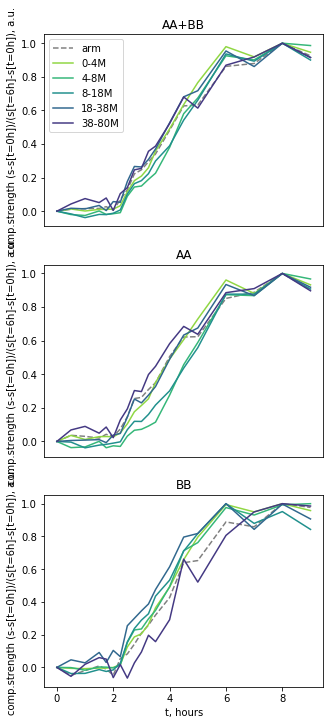

In [194]:

# quantifying strength over time and with the distance ...
gs = plt.GridSpec(nrows=3, ncols=1)
plt.figure(figsize=(5, 12)) #width, height

a_dfs = {}

titles = ["AA+BB","AA","BB"]
for i,a in enumerate([sad_str,sad_AA,sad_BB]):
    ax = plt.subplot(gs[i])
    a_df = pd.DataFrame(a)
    a_df.columns = band_names
    # store dataframes ...
    a_dfs[titles[i]] = a_df
    
    # extracting float time from the label data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaYAAAFNCAYAAAD7K7jAAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nOzdd3hU1dbA4d+eyaT3DklI6L2HoohSVKQpKiKgUi1XvVdAUdR7UdSLYvsExasIKnYQsAGCDbDRCR0SQg8kJKT3MjP7+2MCJBBqMpkkrPd55pk5da8zCouzZp+9ldYaIYQQQgghhBBCCCGEEKK6GBwdgBBCCCGEEEIIIYQQQoirixSmhRBCCCGEEEIIIYQQQlQrKUwLIYQQQgghhBBCCCGEqFZSmBZCCCGEEEIIIYQQQghRraQwLYQQQgghhBBCCCGEEKJaSWFaCCGEEEIIIYQQQgghRLWSwrQQQgghhBBCCCGEEEKIaiWFaSFqOKXUGqXU/Y6OQwghhBBVS3K8EEIIUTtIzhbCPqQwLUQdopTqpZTSSqmnzrPdQymVq5T6sRJtHFZKFZSeJ0MptVwpFVFm+3ylVHHp9hyl1Bal1A1X2p4QQgghqifHCyGEEOLKKaXGKKUspfk4Vyl1UCn1cJntUaW5/NT2ZKXU/5RSJkfGLYQjSWFaiLplNJBe+l6RoUARcLNSqt75TqKUmqaUmnaBdgZrrT2BekAy8M5Z218r3e4DvAd8o5QyXtolCCGEEKICVZLjhRBCCGFX67TWnqX3w0OB15RSHc/ax7d0e1vgGuDR6g5SiJpCCtNC2JFSaopS6nhpz+E4pVRfpVRXpdQ6pVSmUipJKTVbKeVc5piblFKxSqkspdRsQF1iW+7YEt+jQFOlVHQFu40G3gd2APdU9vq01oXAYqDVebZbgS8BfyCksu0JIYQQNUVdz/FCCCFEXVGdObssrXUMsBdoeZ7tKcAvnOd+WoirgRSmhbATpVRz4J9AF621F9APOAxYgElAILZfR/sCj5QeEwgsAf5Tuv0A0OMSm7wTyAUWAT8Bo86KpwHQC/ii9DWKSiq9Ub4bWH+e7cbSdg5h61kthBBC1HpXQ44XQggh6gIH5OyybXcBmgGbz7O9fmk8Fd5PC3E1kMK0EPZjAVyAVkopk9b6sNb6gNZ6i9Z6vdbarLU+DMwBTo3BPADYo7VerLUuAWYCJy6xvdHAQq21BVsv5RFnjVU1Ctihtd4DfAW0ruCRokv1nVIqE8gGbgJeP2v75NLteaXXMLU0LiGEEKIuqMs5XgghhKhLqjtndy/thZ0LbAQ+A+LP2ie19H75OLZ75sWVukIhajEpTAthJ1rr/cBEYBqQopRaoJSqr5RqppRappQ6oZTKBl7G9issQH0gocw5dNnl8ymdfLA3tl5SAN8DrsDAMruNOrVda50I/E6ZcSpLY8osTZBPA0+fWlZKLTurySFaa19sCf6fwO9KqdAy298o3e4GRAOvK6X6X+w6hBBCiNqgtuV4IYQQ4mpVnTm71Hqt9akxpEOB1qXnLiuw9H7ZHfgbWHmFlydErSeFaSHsSGv9pdb6OiAS0MCr2CYDjAWaaq29gWc5M15VEhBx6nillCq7fAH3YfvzvFQpdQI4iO2mdVTpea4FmgLPlCbeE0A3bD2unEpjHVSaQH2BGcCMU8ta60HnuT6L1vobbL9CX1fBdq213oUt2Q48e7sQQghRW9WmHC+EEEJczaoxZ5/dbjK2IUEGn2d7ATAfuKZ0+BAhrjpSmBbCTpRSzZVSfZRSLkAhUICtgOuFbQiMXKVUC+DhMoctx/b47R2lN5OPYfuV9WJGAS8AHcq87gQGKqUCsPWaOjWpwqntbbD9QnvFPZmVzW2AH7ZJHSrapwW2ovXuK21HCCGEqEmuhhwvhBBC1AXVnLPPbjsAuJ3z3AuXxnQftmFC0i73/ELUBVKYFsJ+XLD1PE7FlmiCsf0KOxkYCeQAc4GFpw7QWqcCd5Uel4atB9TfF2pEKdUdiALe1VqfKPP6AdgPjACGAe+ctf0QtvGuruRR36WlY2ZlA9OB0Vrrssn2KaVUrlIqD/gZ+BjbmF1CCCFEXVCXc7wQQghRl1RLzi7jmtJ74VxsnbdOAv86a59TY1AnY5t48dbS4UKEuOoo+X9fCCGEEEIIIYQQQgghRHWSHtNCCCGEEEIIIYQQQgghqpUUpoWoJZRS7596JOis1/uOjk0IIYQQV05yvBBCCFE7SM4WomrJUB5CCCGEEEIIIYQQQgghqpX0mBZCCCGEEEIIIYQQQghRrZwcHcDlCgwM1FFRUY4OQwghRB21ZcuWVK11kKPjqAskZwshhLAnydlVQ/K1EEIIe7pQvq51hemoqCg2b97s6DCEEELUUUqpI46Ooa6QnC2EEMKeJGdXDcnXQggh7OlC+VqG8hBCCCGEEEIIIYQQQghRraQwLYQQQgghhBBCCCGEEKJaSWFaCCGEEEIIIYQQQgghRLWqdWNMV6SkpIRjx45RWFjo6FBqLFdXV8LDwzGZTI4ORQghxFVMcvaFSb4WQghRE0i+vjjJ2UIIUXl1ojB97NgxvLy8iIqKQinl6HBqHK01aWlpHDt2jIYNGzo6HCGEEFcxydnnJ/laCCFETSH5+sIkZwshRNWoE0N5FBYWEhAQIAnzPJRSBAQEyK/dQgghHE5y9vlJvhZCCFFTSL6+MMnZQghRNepEYRqQhHkR8v0IIYSoKSQnnZ98N0IIIWoKyUkXJt+PEEJUnt0K00qpj5RSKUqpXefZrpRSbyul9iuldiilOtkrFkeKiooiNTUVAE9PTwdHI4QQdc93W4/TY8YqGj69nB4zVvHd1uOODknUQpKvhRDCznZ8DW+1gWm+tvcdXzs6IlFLSc4WQgj7qs57bHuOMT0fmA18ep7t/YGmpa9uwHul70IIIezk08nPUpjWkRJnf0zF6bgGbGXUGy87Oqwr9t3W4zzzzU4KSiwAHM8s4JlvdgIwpGOYI0MTQgghxCk7voalj0FJgW05K8G2DNBumOPiqmWUUh8Bg4AUrXWbCrYrYBYwAMgHxmitY6o3SiGEELVZdd9j260wrbX+QykVdYFdbgM+1VprYL1SylcpVU9rnWSvmE75butxXv8pjsTMAur7uvFkv+ZV8uUOGTKEhIQECgsLmTBhAg8++GAVRCuEEFXj08nPkpfVE6uLCwAlLgFYsnoy/4lnufXFaVi1RmvbZC5WDRrbu9WqAbCWrq9wP6ttfdn9dJl3je08p/bXuvx+usx5T62H8u2dbrdMe9N/3Hs6YZ5SUGLh9Z/ipDBdR9gjZ0u+FkKIaqQ1/DrtTFH6lJIC+O1FKUxfnvnU0M5fco8thLga1dSOX1prLFZNiUVTbLFSYrFSbLa92z7rM58tVkosmpLS7S8s3U23gxsZs2cFQQWZnHTzZX6r/rz+k3PtKkxfgjAgoczysdJ1di1M27Py/9FHH+Hv709BQQFdunThzjvvrHS8QghRVQrTOp4uSp9iNbpQlNGVbi/8TImh7oyTl5hZcPGdRI1nr5wt+VoIIaqQ1pCfDplHbD2hM4+Wvsp8Ls6p+NisY9Ubay1XUzt/yT22EOJqdN6OX48+SdtxD1Bs1ZRohdmqKbFqiq1QohUlVislVii2aIo1FJuhRGuKrZpii23fEguni8ZnCspniswlFislpcXl8+1T2m/ssvVK2MKEbYtxtZQAEFKQyYRti3kbgD5V8t2V5cjCdEUVkAq/NqXUg8CDAA0aNLjgSV9Yups9idnn3b71aCbFFmu5dQUlFp5avIOvNh6t8JhW9b15fnDrC7YL8Pbbb/Ptt98CkJCQQHx8/EWPEUKI6lLi7F/herOzNxOzrLhYMnD2AkOYL7p5OKYgdwxGA0qBQaly70opDKXLtnr2meXz7acos2wov1x2Pyg9r+Hc487eb+j7a0nOLjrnmur7utnlOxRVy1E5W/K1EEJcBq0hL7W0yHx28bm0AF2SV/4YF2/wbQB+kdCwJ2xfAIWZ557bJ7x6ruHqYZfOX3KPLYQQ5zpfxy9zXnfc77kN90qc24pCl97zamVAq9Llc94Np5dtN+KGM5+VAWWwvWNQqLPfDQplMNhe6sznkvh9mKzln0p2tZQwLnYl8FwlrqpijixMHwMiyiyHA4kV7ai1/gD4ACA6OvoKa/42ZyfMi62/VGvWrOHXX39l3bp1uLu706tXLwoLCyt1TiGEqCrJMTtAW0EZz9nmVJKNpeQvTOZICq0NKCkwwv4kDNqCr1sRwQ08qd85itDmQfgGu9uSWw3xTP+W5XroALiZjDzZr7kDoxJVxR45W/K1EEKcxWqFvJTSHs5HbMXms3s+m896EsnV11Z4DmgCjfvYPvtE2N59G4Cbb/n9wzqXH2MawOQGfav+BvcqZ5fOXxcj99hCiKtNYdLx83b8KnL147dejxOkdtHMIxsP/zAs3uEYDUaMgBGNUYEBbVtWoNBoq5XSMSxBW0uXseVpbUWf2ma1ovXFtp1ZBo0+9Vlr2/YLbMuN21vhdQXkV/ADcxW4osK0UipGa92pkm3/APxTKbUA27hXWVXxiNHFfnXtMWMVxyt4xDvM142FD11zxe1mZWXh5+eHu7s7sbGxrF+//orPJYQQVanweBI/vbkePKJQ1hK0wXR6m8FShJvfRu74xy38te1D1h1+l+zkIBqcbEBQXiQWYyTxeQ2I3XcQOIiTMhMYoAhpHky91vUIjvLG088FpRxTrD71eKg9xjSsKy4lZztqMiVH5GzJ10KIq47VCrknygyvceRM0TkrwbbOctbTR+4BtkJzUAtoevOZgvOpArSr9+XFcGoc6d9etA3f4RNuK0pfReNLV9E99MXYpfOX3GMLIYSNtaiI+P+9QeHHX+DS6QWKXAPO2cdgzifDxw2VdxupuZBvPUC9gs30bVBAvdZdoVEvCG5l691cA8X36Ys58dzUYapXzy7tXVFh+lISqlLqK6AXEKiUOgY8D5hKj38f+BHbDe5+bDe5Y68klsv1ZL/mduldd8stt/D+++/Trl07mjdvTvfu3SsbqhBCVJo5M5PvJ39Ojk9ncvy/pn6x/3knZ7ilyY3cYi6mJP5nNu2Yz6qTX/O30YRvspE2x0JomtMMU1E9crIi2JGi2f53GgCuJgtB4R7Uax1KcEMfQiK9cfU0XSisKjWkY5gUoi/gEm+C51MDJ1OyR86WfC2EqA0uazIlqwVyks4a27lM8Tn7OFiKyx/jEWQrMoe0geYDzi08u3hW+TUt9/RgVkR9TvgbCPUIZYKnBwOrvJWaqxqK0mCnzl8XI/fYQoi6TmtN5i8/c2j687glZ7G7KSin71HW0WjDmaeSDZYiPHzX8o/Xp7M5bgd//xFD8T43sk7ezTcnoWDPQcLcZtLHYychzVvbitSNetnybw0RPGkiSVOfQ5d5QkW5uhI8aaJd2rPbUB5a6xEX2a6BR+3V/vnYq3edi4sLK1asOGf94cOHT3/Ozc2tVBtCCHE5rIWF/PToLFJ9epLh/iMTnn0ZL8+zHze6q/yikzOmloO4tuUgri3KRccuZ8/Oz1jlt5Ov3I9x0MlEZAr0TAmkdVoTnNK8yDEGkZYZScLBfNv4VYCXlyKkiT8hjf0IjvQmqIEXJpdzhxERNUNNnUzJHjlb8rUQoqY732RKX0ycxD1jupw1vnNp4dlqLn8SzxDbTW5YJ2g9pHSYjcjSwnM4OFdm5MvLt/zgcqatnUahxXaTm5SXxLS10wAY2OhqKk9XTk3t/CX32EKIuqxo/34OTvs3bN7ByUDYc1sxLVyDsPaaTOHCYyirE1qZzvkhuUuL9nRp0R6rtrIhdivr/t5FYZwr6ekjWZwORWlHCIv5k97G6QQHup0pUje8HtwrHiakOvgMHgxAylszMScl4VSvHsGTJp5eX9UuWphWSuVwZlwqZ2yJL09rfZnPb9Uc0rtOCFHXabOZ9Y+9ymGvnuQ4bWbQ/YMqKEpfhIsnqv3dtG5/N63zUvnX7m9J2LmAVaY4VjUr4nOXNKxoWhUFMCivKd2Ou2I9ZCE9x4ls7ygSTkayf6utTYXGL9SNkEZ+BEd5ExLljX+YB0ZjzXx8qbayY862y2RKl0JythDianO+yZSy8m5m6qLNWAzFWI0+WJxaYXVqgdXditWksZg0VhNYTKBNVixGM1ZtxpJ9BJ13EGuypfwIxGeNwqUqGJ747HUVDd1V0XFn25W6iwbJbel2dBCexX7kOmewocEyZsXMqpOFaXvl45ra+QskXwsh6h5LVhbJ77xNxpdfke+s+fEmJ64LO0lgbg9O3jSDm+sHs4R0+oxrSYvup4a5uOuc8xiUgWtaduaalp2xWC2sjd3M+rW7KYgzkZo+gkWMoDg/kYiT6+i1YQqBTslQr92ZQnWDa2zzMlQjn8GD7VaIPttFC9Naa6+yy0qpIUBXu0UkhBCiUrTW7PnPm2zX3ShUh4i4sYgOrXpV7qQegdD1ASK6PsDojCOM3rWE9J1f83v+UVZ5FDIrIIOiAI1XZy9u8utOn2xFjyP7yd0ez8mEPLLcw8lJi2T/8UbsXWtLqkajIjDCi+CG3oREehEc5V3jJlesbeyYsx0ymZIQQlyNzjeZkjY445XVDidtwslqwqgv/0kkq9GM1cmM1Wgp/Vz6bixd52Q+d32Z/S1OZ60zmM8cY7SAQaPPSg8aTYPkttxwcDgmqzMAXsX+3HBwOL+z4PK/oFpA7qGFEKL20hYLmYsWk/TWm+jsHH7toMi6xoXHMo/yVs69NBn0OKOuieLPhfswOhlo1D7oks9tNBjp2aobPVt1w2w182fsejb8vZeifc4kp97JQu6kxPMkDU7u4vrj3xL49ywwukBE6djUjXpD/Q5gqDtPI1/2UB5a6++UUk/bIxghhBCVd/T/3mNtclNKnHPJabeSJ4YsqtoG/CKh5+P493yc25N3c/vOReTvXMy6klRWexayqmQ132DGVM9E907d6RPalx7ZoZh2HyB/yzLSdx8mE3+yvSPJyW7CnsPh7CxNR86uRoIivQmJshWqgyMdO7libVeFOdsukykJIYQoT2uNwVqE1eh6zjaXonTaJS5iTaf+/OIeSUJ6ASbApMHTyUgTf3ca+rnTwMedcE9XQjyccTcaKCmyYi62UFJswVxsxVxkKbdccnrZijmvzOdiy3l+gjw/g5PC5GzEydmIk7MBk4sRJ5OR44dTMVrLzz9hsjpz7bHbKvFt1R5yDy2EELVD/qZNJE2fTnFsHHsjFD8M92O8IZXojEweKnqSm28dyX3dI7FaNfu3pBDZNgBntysbJdnJ4ETvVtfRu9V1lFhK+D12LRv+3kvxfhdMx3qzkN6YvTOJDEnguoxVBK56CVa9BC4+0LDnmR7VAU2gFt8vX8pQHneUWTQA0Vz2P1GEEEJUh5RPv+T3GHeKPV3Z3eJtZo//zr4NhrSGkNa493mOvgkb6LtzEebd37JN57HK249VbOLP43+iULQNa0uf7n3oFf4ELVM1+VtiKNgaQ96WBWRmmMn2iiTHrzG5+c1JivPDim2YDzdvZ0KivAmO9Cp9Lz+54r4NJ1j3/QFy04vw9Hfhmtsa06xbqH2vu4ayY852yGRKQghxNdFa8+fXsViNriir5ZzJlAJKfic0K5mhC1/jnlYt8Rw1luPtu7MvtYDYEznEnchhRWIGafHJp48L8HCmeagXzUK8aBHqdfqzh8vFb6K11lhKrOcUsE8XrovKF7Ft20/tX/4Yo7Xi9twLa+3okBck99BCCFG7lCQmkvz66+SsWEmGjxPzhxgI69GJd7b/RAEBDC6cxrgh/binWyQAifsyyM8upml0SJW0bzKauLH1DdzY+gaKLEWs3vsXG9fuxbzfHaf4tiykLRaf+4lqmMO1njsJTFoGsctsB3uHQcMbSgvVN4BX7boXvpSyftlBRczAYWyTIAkhhKhBslasZM33J8gJbMf6JnN46c7XMDmf2+PKLgwGiLwGIq/Bqf+rRB9YTfTORTwZu5x4ilnlH8LqzKPMPDmTmTEzifKOok/TPvTuM4J2Qa9gSTlJQUyMrVgds4C8uP3kutcnxyeKvLC2pOU34PAON06NKOEd6EpIlDcY4MDmZKxW2/rc9CJWfbob4GotTl9Rzq6pkykJIcTVZPOPh9m5Oomw47+T5XGEIreBlDj7n55M6fa5s7EWF5O9dClp8z4k7emn8IqI4KaxY7jrjjswuNpyfmpuEXEncog9kcO+EznEJuewcFMCBSWW021F+LvRPMSb5qGeNA/1pkWoFw0DPTCVmftBKVXa87nyjwt/8uzf5KYXnbPe07+a/p1S/eQeWgghagFrYaEtp86bi9li5pvrDGzqE8q/vZvSffMX7HVpz4isR5hyx7WM6HpmmML4TcmYXI1EtQ2o8phcjC7c0qYvt7TpS35JPqti/2Dz2jjMB9wxbGtIAjdh9b2Ohq2c6R5ygoDMX1H7VsD2L20nCGppK1A36gWRPcC1Zv8IrGzzI9Qe0dHRevPmzeXW7d27l5YtWzoootpDvich6q689RtY/d/vORJ+I5vClzDsmlYM6OuQuW/KK86DuBWwcxHs/5UTSrM6JIpVPoFsLkrBrC0EuAbQK6IXfRr0oVu9brgYXbDk5lGwfRsFW2LIj4mhYPt2Soo1OV4R5Ia3Iy+0FZnGIPKLKr5Z9nCzMuatG68oZKXUFq11dGUuW9hIzr4y8h0JcfXZ/lsCfy2KJ/DkOjzTv6L3yvW4u3ied39ttZK7ahWpc+dSuH0HRn9//Efdh9+IERh9fM7Z32rVHMsoIPZEtq1onWwrWh9MzcNitd0PmoyKxkGeNC/tWd08xPYe5utW6SG19m04weovYjEXW0+vc3I20PueFpX6IVlydtWQfH3l5HsSonbSWpPz008kv/Ya5sQktrVx54Pri7i5yzAmHN6De9wKVnv056H0Ebx0R0fu7nKmKG0xW/n4qb+IahvIjWNbVVvMucW5/Lp3DVvW78N6wJPQ7EYYMKB9CmnYMYCuTQ0EFqxFHVoDR9aBuQCUEcI6nxn2I7wLODlXW8ynXChfX9FAKEqpQVrrZZULq24ZN24cy5YtIzg4mF27dgEwbdo05s6dS1CQbSD0l19+mQEDBrBmzRp69+7NvHnzGD9+PABbt26lU6dOvP7660yePNlh1yGEqH0K9+xh43MfcaTR3ewL+Iu24Wk1oygN4OwBbYfaXvnphO7+lhE7FzNi71qyDYo/w1qz2uTHikM/siR+Ce5O7vQI60GfBn3oGd2ToB49ANAlJRTGxlEQs4X8LTHkx7yHJTWVVTfMrnA8rbz82jvGVlWTnH0uydlCiJpkz1+J/LUoHq/8GJrHfkn2u89esCgNoAwGvG68Ec++fcnftIm0efM4OXMWaR/MxXfYMPzHjMYUeqbgazAoGgS40yDAnZtbn1lfZLZwICWPfck5pcOBZLP5cAbfbzszjYCXixPNzhoOpHmIF34el35je6r4fDUPvSX5+PJJvhZC2ENhXBzJ018mf+NGMiN8mTnSQG6bUN5o/y86//JfdPJuPvf9B1OTe/LqHe0Z1iWi3PEJe9IpyjfTJDq4WuP2dPZkSPtBDGkPWUVZ/LJ3NVvW70Md8kavcebwGgP4NKNRpx5E39OQQL0bdeh3OLgG/nwD/ngNTO4Qee2ZQnVwa9vTzw50ZSN0QxdAkmoZY8aM4Z///CejRo0qt37SpEkVJsG2bduycOHC00lzwYIFtG/fvlpiFULUHcUJCWyf+DJ7o0aR7BGHJXwZk+7929FhVczdH7qMt70yE/DetYSBOxczcMcqipWRjQ27sMonhNXJMfxy5BeclBOdQzvTO6I3fSL6UK9tG9zatsF/9Gi01pQkJPD3cxsocj338SmXonQHXGCNJTn7LJKzhRA1RfymZFZ/EYun2kfnTfPZcEsDxvW655KPV0rh0bUrHl27UhgbS9q8D0n/7DPSv/gCn8GDCRg/DpfGjc97vIuTkVb1vWlVv/xjvtmFJew7kUNccs7pYUF+3JnEVxuPnt4n2MulXM/qFqHeNA3xxNVU8dNMe5wtfOBdRKK1gPre4ONsodklX2mdIPn4Mkm+FkJUJXNGBifffpvMhV9j9XBj0WAfvm+dx71txvFI0DW4LRqDLs7jDf8X+V9iI167sx13RUecc559m5Jx9TAR0crfAVdh4+Piw9AOQxjaAdIL0/l572/EbNiP8ZAv1tVOHFydDd7FNOk8kI43TyAoyII68jecKlT//B/bidwDoeH1ZwrVfrYxtNnxNfz2ImQdA59w6PsctBtml2u5osK01vr5qg6kWtnhC77++us5fPjwJe/foEEDsrOzSU5OJjg4mJUrVzJgwIBKxSCEuLqY09KI/cdktje4l1yXNHY3mcecOxdjcDJd/GBH842A6ybaXil7cd65iOt2LuK6g+v5j5Mru5pczyr/UFbnHWHGxhnM2DiDlv4t6d3AVqRu5tcM5wYNaJrxOnuCB2A1upw+tcFSRNOMP4C7HHd9NYjk7HNJzhZC1ASHdqTy68d78PLMpPmqdzkSorn9pc+u+HyuLVoQ9sbrBE2cSPrHH5O5ZAlZ33yDZ9++BNw/HveOHS/5XN6uJqKj/ImOOnPTrbUmJafodM/quBO5xCVn89n6IxSZbUN0GBREBnicLlafem0/msm/v9t1epzr45kFPPPNTgCGdAy74muuTWp9Pr4YyddCiBpKm81kLFjIyXfewZqbS2yvKF5td4SQ0MZ80uMl2p3YB5/djtUzhCnuL7I4wYs3hrbnzs7h55yrpNjCoR2pNO8agtHo2J7Gp/i7+jO8410M7wgn80+yMvYXtm7Yj/PhAKyrjexfnYnyLqFJp3Dad59KcP/XUDlJcLC0SH1wDez+xnYyv4a2v8MTNoCl2LYuKwGWPmb7bIfi9CUVppVSbYBWwOnZKbTWn1Z5NNVhx9e2L7SkwLZs5y949uzZfPrpp0RHR/Pmm2/i5+d3etvQoUNZtGgRHTt2pFOnTri4uFzgTEIIcYYlN4+DD/2LLYFDKDDBL63e54WOTxIY3NDRoV2+4Ja2m5c+U+HYJgw7vqbd7m9oF5vGRFcfDje/idUBYazKPcR720zRCfUAACAASURBVN7jf9v+R5hnGL0jetOwr6bxt19yNPJWilz8cSlKp8GRH9D3NnX0VTmM5OwrJzlbCFFdEmLT+emDXfgEKcI2P49boRnjq0/g5xlY6XM7h4cROvU/BD76CBmff0HGF19w5LffcIvuTOADD+Bx/fVXNGa0UooQb1dCvF25oVnQ6fUWq+ZIWt7pntVxJ3LYl5zDz3tOYL3AdEYFJRZe/ymuzham61Q+vhjJ10KIGipv/XqSp79MUXw8RR2a8VoPJ/b4HGdcmwf5R9sHcf7r/+D3V7FEXMPDxZP49aiZ/xvWnts7nluUBji8IxVzkYWm0SHVfCWXJsg9iPs6jeS+TpCUm8RPsb+ybeN+XI4GYf7dQPyadJSXmSadQmjXfQAhtw9HAZyMO9ObOm4FcFYCLymw/fjoiMK0Uup5oBe2pPoj0B/4C6iZSXXF03Bi5/m3H9sElrNmhC4pgO//CVs+qfiY0LbQf8Zlh/Lwww8zdepUlFJMnTqVJ554go8++uj09mHDhnH33XcTGxvLiBEjWLt27WW3IYS4+ujiYhIee4zNxuvIcwtkect3Ge7bkmu7D3d0aJWjFER0tb1uecX2C+7ORUTtXcbY4lzGetUnteUAfg+MYFV2PF/HfU2xTzE9ulgYuWYzAdmQ5g1f9lIc9Emml6OvxwEkZyM5WwhR4yUdyOLH/+3AJ8iFxomP4XXAzB/9w3mw7/gqbcfJ35+gx/5FwPhxZC5eTNr8T0h46B+4NGtGwP3j8e7fH2Wq/FNWRoOiUZAnjYI86d+23un1hSUW4pNziUvOYfKi7RUem5hZUOn2a6Jal48vRvK1EKKWKT52jJRXXyPnl18w1K/Hb/+IZo7vVpr7t+CrHi/R0isSvn0I9nyHud1IRqcMZ93RXP5vWIcL/mAavykZDx9n6jX1rcaruTL1POsxJvo+iIaEnARWxv7C9k0HcD8aivkPiP89DYOXhaadQmjTLZKQLg+iuj0E03zZl9+Tdbn3kmsNxNOQyjWen9OMv+wS56X0mB4KtAe2aq3HKqVCgHl2iaY6nJ0wL7a+EkJCzvyC8sADDzBo0KBy20NDQzGZTPzyyy/MmjVLkqYQ4qK01crxKc+w7WQDMsJasKbxl0Q7n2T88G8dHVrVMpqg6Y22V3E+7FsBOxcTuPkT7rSWcGdAU/Lb3EG3owv4u7WRv1uXP1zlJTkmbseTnH2FJGcLIarDyaM5LJu9HQ9fFxq5z8e4MYeDoQYGPv/hFfVivhQGDw/8R4/Gb+RIspYvJ23ePBKfmkLKzJkEjB2H7513YHB3r/J2XU1G2ob70Dbch7d+2cfxCorQ9X3dqrzdGqJu5eOLkXwthKghrPn5pM6dS/qHH4HRSMboAUyN2ES63sWj7f7J+DbjMeWdhI/7Q9J2ivq8wH17urL5SAZv3d2B2zqcvyhdlF/Ckd1ptL0hHIPBPjnbXiK8InigyzjoAoeyDrEi7md2bDqI17EwSv7QxP2eisHTSrPOoXgW38+WnL5obXviJNcazK85j4J7gF3mhriUwnSB1tqqlDIrpbyBFKCRHWKpGhf71fWtNrZHi87mEwFjl1dpKElJSdSrZ+s18O2339KmTZtz9nnxxRdJSUnBaKx4khAhhDhFa03yjBns2ZHP8aYD2VnvV1y81/Hs8NW23sZ1lbM7tLnT9spPh70/wM7FuP/+OvXC65FkOjeVhVou8Oxw3SY5+wpJzhZC2Ft6Uh4/vL0NZzcj7XskUjjrV5yLnCmYMp5w3wZ2b1+ZTPgOGYLPrbeSu+Z30ubNI3n6dFLffRe/e+/F756ROJUZEqEqPdmvOc98s/P0GNMAbiYjT/Zrbpf2aoDalY8vRvK1EKKG01qTvfxHUt54A/OJE7j0v4kPexbzQ87PtPZtzXs9XqSZXzNI3ApfjYCiHAqGfs6ov/zZciSDmcM7cmv7+hds4+C2k1jNmqZdauYwHpeqoU9DHun6ELqLJj4znpVxP7Nt82F8jkdQ/IcFJ33u2Pxau7Aqe5jDCtOblVK+wFxgC5ALbLRDLNWj73Plx78CMLnZ1lfCiBEjWLNmDampqYSHh/PCCy+wZs0atm3bhlKKqKgo5syZc85x1157baXaFUJcPdLmzSN+WQzx7R4m0XcHcWHfM7vrW3j6BDs6tOrj7g+dx9heWceY8EEXpgX6U2g4M/GEq9XKhLQMh4XoYJKzL4HkbCFEdcs6WcAPM7eiDIqbRoVS8Oa9OB105bd+ITzcb2K1xqIMBrz69MarT2/yY2JImzuP1NmzSfvwQ3yHDiVgzGhMYVU77vOpx6Jf/ymOxMwC6vu68WS/5nV2fGnqWj6+GMnXQggHKti9m+TpL1MQE4NLq1YcfuIOpuUuoDCvkEmdJzGq1SicDE6w+1v49mHwCCL/vhWMWpbL1oRMZg3vyOCLFKUB4jen4B3kRnCkVzVclf0ppWjm14xm3Zuhu2n2pO/hp7hfMH7aFsW5Hd/M+a4VnKUK4tD60nuVKaWiAG+t9Q67RHMJoqOj9ebNm8ut27t3Ly1btrz0k9hhxuDa4LK/JyFEjZG55BviX55NTJcpZLqnsqj1mzzj148773jF0aE51lttWG5OY5afLyecjISaLUzIyGSgUwBM2nVFp1RKbdFaR1dxpNVOcnbtJflaiLolN6OIb9/cQlGBmdsndSDl49so+DaJE14GGi1aRIvg1hc/iZ0VxceTNu9DspYvB63xGTQQ//HjcW1mj75RVac25OyakI8vRvL1lZOcLYTjmNPSODlzJpmLl2D088PlkXG8FryZP5L+on1Qe17s8SKNfBqB1vDH67B6OkR0I3fIfEZ/fZhtCZm8PbwjA9vVu2hb+dnFzH/6bzr1a0D32xpXw9U5zozHFuNV7H/O+hzndJ5+e+gVnfNC+fpSekyfprU+fEUR1DTthl0VSVIIUTfkrF7NkZdeY2e3ZylytvBti/cYag7gzttfdnRojtf3OQYufYyBxxLPrDO5Qb/K9dCpCyRnCyGE4+VnF/PDrK0U5JZw28SOJK1/B8u6I5gKXUj6z50MqAFFaQCXpk2p/+oMgiY8Rvonn5CxaDFZ3/+A5w03EPDgA7h37uzoEGutOpOPL0bytRCimuiSEtK/+ILUd/+HtaAAv1GjWNcvnNdi38WcYmZKlymMaDECo8FYOhHro7BrCbQbTvbNbzD60x3sPJbF7BEdy03aeyEHYlLQ1to/jMeliGv6J+339sdkdT69rsRQTFzTP7FNoVC1DBffRQghhKPkb93K0cefYlfnxyh08uD7Zu/QwZLFE/ctqdvjSl+qdsNg8Nu2MQxRtvfBb8uNkRBCCIcryi9h6TvbyEkrZNCj7aBoL8E/zcb5oAu/9fblnlv/7egQz2GqX5+QZ56h6arfCHzsXxTs2MGRe+7l8IiR5KxahbZaHR2iEEKIq1jun39x8LYhpMx4Fbf27fH4ag5TOx/guZ2v0jKgJd/c+g33trrXVpTOOQHzB9qK0n2fJ7v/O4z6pLQoPfLSi9IA8ZuS8a/vQUB9TzteXc0wdODNrG2yhBzndDSaHOd01jZZwtCBN9ulvcvqMS2EEKL6FO3fz9F/PExc61FkmkL5s+FHuLoc5tne8zG5ezs6vJpDeugIIYSoYYoLzSybvZ30xDwGPtKOkAgTif8dx8ktPiQHw7VT3sTVyT5jNVYFo68vQY88QsDYsWQu+Yb0jz/m2COP4tykMQHjxuMzaCDK2fniJxJCCFGjZS1dSspbMzEnJeFUrx7BkybiM3iwo8M6R/GRIyTPeJXc1asxNWhA2P9ms7xeMm/FTEShmNp9KkObDcWgSvvfJm23TXJYkAF3f05W1C2M+mgju49n8e49nejXOvSS285JLyTpQBbdbqu9c9hejoGNBsIQmBUzixN5Jwj1CGVCpwm29XYghWkhhKiBSpKSOHr/AxwOu5Ekz9bEh/3CwYCtvFxvPA2adHN0eEIIIYQ4D3OJhR/f20ny4Rz6PdCaBq0D2D1nLComH1OhK3ufvInHG9SOydkMbm7433sPfsPvJnvFStLmzSPp2Wc5+fbb+I8eje9dd2H09HB0mEIIIa5A1tKlJE19Dl1YCIA5MZGkqbYhEWtKcdqSm0fanPdJn/8JymQi6InHybu9N49t/i9bNm7h2vrX8vw1z1Pfs8zkhXuXwTcPgJsfjPuJLN+WjPpwA3uSsvnfPZ24+TKK0gDxm5MBaBpd94fxOGVgo4F2K0Sf7bKH8lBK7S19/dMeAQkhxNXOkpnJ0QceINHUiAPBfcgKPsBvEcsYZ23GjbdMdnR4ohaRnC2EENXLYrHy09zdHI/LoO+oFjTuGMyhPxcQvnk56qArK3u6M/6Olxwd5mVTTk74DB5Ew+++JeKDOThHRJDy6qvs79uXlFmzMKenOzrEGk3ysRCiJkp5a+bpovQpurCQlLdmOiiiMnFYrWR+9x0H+/cnbe48vAcMIGrFcpZf68zQlSPYl76PF699kfdvfP9MUVpr+PNNWHgPBLeCB1aT5dOS+0qL0u/d0/myi9JgG8YjOMobnyC3Kr5KAVfQY1pr3VIpFQB0t0M8QghxVbMWFJDwyKOkpin2droH5V/AwobvMiDfyEMPfOXo8EQtIzlbCCGqj9Wq+e3jPRzekcr1w5vRvHs98k8ewXfFZA5uCSA5CNo+8QI+Lj6ODvWKKaXwvP56PK+/noLt20mbN4+09+eQ/tHH+N55J/7jxuIcHu7oMGscycdCiJrInJRU8frERLJ/+hn3Th1xCgqq5qigYMcOTkyfTuH2Hbi2a0f47HdIivRi3Non2HFyBzeE38DU7lMJ8SjTg7mkEJY+BjsWQpuhcNtsMkuM3PvhevadyOX9ezvTt+Xl93jOOJFHakIu193VtAqvUJR1yT2mlVIeSikjgNY6TWu93H5h1T7jxo0jODiYNm3anF43bdo0wsLC6NChAx06dODHH3+s8NipU6fSrl07OnTowM0330xiYuLpba+88gpNmjShefPm/PTTT6fXR0VF0bNnz3Ln6dChQ7n2hRC1izabOf74E2TsOcyurhNx8jLwVcRLtCgu4skhC1CmmjsWpahZJGdfmORsIURV01rz+xexxG9O4ZrbG9O2VzhYLSTNH0PyNmdMBbBhXBf6Na2ex2Krg1v79oS/8w6Nli/He/AgMhYt4kC/Wzj+xGQKY2MdHV6NIPm4ciRfC2FfTvXOP/nf8QkTiO95PftvupnEKVPIWLCQwn377DoJrvnkSRKfeZbDw+6mJDGReq+8QviXn/GFYRNDlw7lSPYRXun5Cu/0ead8UTo3BT4ZbCtK9/4P3DmPzBIj98zbwL4Tucy578qK0gDxm1NAQZPOwVV0leJs5y1MK6UMSqmRSqnlSqkUIBZIUkrtVkq9rpSSnwvKGDNmDCtXrjxn/aRJk9i2bRvbtm1jwIABFR775JNPsmPHDrZt28agQYN48cUXAdizZw8LFixg9+7drFy5kkceeQSLxXL6uJycHBISEgDYu3evHa5KCFFdtNYkPf88mX+sZU/f57AoJ1aEvwZO2Uxu9SSB9Vs4OkRRg0nOvjySs4UQVUlrzd+L9rPn7ySiB0TRqV8kAHHfTCc4fjf6oAvLezjz0LDXUEo5ONqq59KoIfX/+1+a/PoL/qNHk7t6NYeG3M7R+x8gb/0GtNaODrHaSD6uWpKvhbCv4EkTz5nIVrm6EvrKy0R+9SXBTz2Fa4vm5P71NyemTePQrbexr/s1HH3wQVLff5+8DRuxFhRUOg5dXEzahx9y4Jb+ZC1bRsD942m8YgXJN7TknhX3MitmFr0ievHdbd8xqNGg8rn0xC6Y2wdO7IS7PoEbniQjv4SRczcQn5LLB6M607vFlRWVtdbEb0omrJkvHr4ulb5OUbEL9ZheDTQGngFCtdYRWutgoCewHpihlLq3GmKscssPLufmxTfT7pN23Lz4ZpYfrPwP19dffz3+/v5XdKy3t/fpz3l5eaf/kH3//fcMHz4cFxcXGjZsSJMmTdi4cePpfYcNG8bChQsB+OqrrxgxYkQlrkAI4UgnZ84ic8m37O8/jawCZ3Y1XEK851EedupCl57jHB2eqPkkZ18GydlCiKq0cekhtq9KoF2fcLoObghAatw6ImNmsX9LEEcDIeKxxwn1uPxxLWsTU0gIIU89SZM1qwmaNInCvXs5OmYMh4fdTfbPP5P5/ffE9+nL3patiO/Tl6ylSx0dsj3U2Xx8MZKvhah9fAYPxrlpEzAYQCmc6ten3ksv4nf77bh37EjAuLGEv/MOTf/6k8Y/raTeK6/g3a8fJYmJnJw5i6OjRxPXpSuH7hpG8iuvkL1yJSXJKZcVQ86aNRwcfCspr7+Be5cuNF76A36TJjBn/6cMXzac5Pxk3rzhTf6v1/8R6BZY/uC4FfBRP7CaYdwKaD2E9LxiRs7bwP6TucwdFU2v5lfe0zk1IZfM5PyratJDR7jQGNM3aq1Lzl6ptU4HlgBLlFImu0VmJ8sPLmfa2mkUWmwDvCflJTFt7TQAu8w4OXv2bD799FOio6N588038fPzq3C/f//733z66af4+PiwevVqAI4fP0737meGIQsPD+f48eOnl4cOHcqYMWOYPHkyS5cu5YsvvuCzzz6r8msQQthX+mefkzZnDsf6P01irjdF7Q6y2mM1I3LdGfmPDx0dnqgdJGdXAcnZQojLFfPzETb/eJiW19bjuqFNUUphLczBvGgch7YFYMq38ssDzXm1TZ2sRVbI6O1N4EMP4j96FFnffUfaRx9z/LEJoJRtYips45cmTX0OsBVG6pA6mY8vRvK1ELVTSXIKRbFxBIwbS/DkyefdTymFc2QkzpGR+N4+BABLZib527ZRELOVgpgYMhYsJP2TTwEwhYXh1qkT7p064tapEy5NmqCMRrKWLiXlrZmYk5JwCgrC4OdHcVwczg0bEjH3Azx79mR32m6mLr+b+Ix4BjYayJQuU/BzPevPuNaw9m345Xmo3wGGfwXe9UjLLeKeeRs4lJrHvFHRXN+scuNjx29OxmBQNO4ow3jY04UK020v4VGzEmBn1YVTea9ufJXY9POPabbj5A6KrcXl1hVaCnnu7+dYvG9xhce08G/BlK5TLjuWhx9+mKlTp6KUYurUqTzxxBN89NFHFe47ffp0pk+fziuvvMLs2bN54YUXKnzsrex/E39/f/z8/FiwYAEtW7bE3d39smMUQjhW9o8/kvzyy6T1GU98QQR+HRSvu75Ft3wzE4f/CMbLnqNWXJ0kZ5eSnC2EqC67/jjOum8O0CQ6mF73tkAZbH/m4z95lHpH08g4GMCya408dPfrGA1GB0db/QyurvgNH47vXXcRf11PLBkZ5bbrwkJS3ppZ1wrTtTIfX4zkayHqpqxvloDFgu9dd132sUZfX7x69cKrVy/ANhxHYWws+TExFMRsJW/9OrJLn4wxeHriVL8+xQcPgtkMgDklBVJS8Bo0iLCXp1Ns1MzcMpP5u+cT4BrAO33eoVdEr3MbNhfBskmw7QtoNQSGvAfO7qTmFnHP3A0cTstj3uhoejatXFFaWzXxm5OJaO2Pq2ed+z2xRrlQxeN3YBNwoczaEIiqyoDs7eyEebH1lREScqa7/wMPPMCgQYMAGDt2LFu3bqV+/frnTNYwcuRIBg4cyAsvvEB4ePjp8a0Ajh07Rv369cvtf/fdd/Poo48yf/78Ko9fCGFfeevWcXzK0+R1HchOOhPS3IN3nP5BkNnCU11m4B4Q4egQRe0hObuSJGcLIS5H3IYT/P5VHFFtA7hxbCsMpUXphD8/p8mRH9ge04DUwBI8/3E/Tf2u7mGFldGIJTOzwm3mpKRqjsbu6mQ+vhjJ10LUPtpiIWPRIjyuvQbnyMhKn085O+PWrh1u7drBmDForSk5doyCmBjyY7aSuWTJ6aJ0WQUxMWzP3MNza5/jUNYhbm9yO5O7TMbb2fvcRvJSYeF9cHQt3PA03DAFDAZSc4sYOXc9R9Pz+WhMF3o0CTz32Mt04mAWuelFdL+tcaXPJS7sQoXpTVrrPhc6WCm1qorjqbSL/ep68+KbSco79x9A9Tzq8fEtH1dpLElJSdQrneX022+/PT2b78cfl28nPj6epk1t/2D94YcfaNHCNsnZrbfeysiRI3n88cdJTEwkPj6erl27ljv29ttvJykpiX79+pWbaVgIUbMV7N7NsX/+C3OTDmz1H4SPrwsLPV8gx6mYKW430yx6iKNDFLWL5OxKkpwthLhUB7ee5LdP9hLWzI9+D7bBaLRN21N48jB+vz3F7u0RuOSV8N2ocN7q/LCDo60ZnOrVw1zB33tOpX/v1iG1Mh9fjORrIeqevL/+wpyYRMhTl//kwqVQSuEcEYFzRAQ+t91G5tdfV7hfSWIio1aMItQjlDk3zuHasGsrPmHKXvjybshNhjs/hLZDATiZYytKJ2Tk89HoLlxbBUVpgPjNKRhNBhq2r5rzifM7b2H6Ygn1UvepaSZ0mlBu/CsAV6MrEzpNqNR5R4wYwZo1a0hNTSU8PJwXXniBNWvWsG3bNpRSREVFMWfOnAqPffrpp4mLi8NgMBAZGcn7778PQOvWrRk2bBitWrXCycmJd999F6Ox/GOAXl5eTJlin79IhBD2UXz0KAkPPoTFL5jtrR7EUKTZ1XQpsSVHeSjPnwGj3nJ0iKKWkZx9eSRnCyGu1NHdafw0bxfBkV4MeLgtTqbSP+dWC8nz78M9yYDpgJnvuyvGDXsFF6OLYwOuIYInTSRp6nPowjN/nytXV4InTXRgVFWvrubji5F8LUTtk7Hwa4wBAXj16V0t7Z3vB8pUbxjWfBgTO03E09mz4oPjf4FFY8HZHcb8COGdAUjJKWTk3A0czyjg4zFduaZxQJXEarVY2b8lmai2gTi7ytCa9qYqGmPpnJ2UCgMiKVPI1lr/Yce4zis6Olpv3ry53Lq9e/fSsmXLSz7H8oPLmRUzixN5Jwj1CGVCpwl2mZShprnc70kIUfXMqakcHjESc24+ewa/RnJiET4Dc5iR/Cw35lmZMeoPnL3kV1lHUkpt0VpHOzqOKyU5u/aTfC1EzZQYn8nSt7fhG+rObRM74upxZszJA4ufI2rr2+z4pRFppgLWvjyU5254yYHR1jzlJr2qV4/gSRMrPb50Tc7ZNSkfX4zk6ysnOVvURiXJyezv3YeA8eMJfuLxamlzzYcv4jvzK1zKTA9b6ATxD/Zl2GOzKz5Ia1j/Hvz8bwhpAyMWgE8YACnZhYyYu57EzEI+HtuF7o2qpigNkLAnnR/e3sYtD7WRiQ+ryIXy9UVL/0qpV4G7gT2ApXS1BmpkUr0UAxsNvCqSpBCiZrHk5nL0wQcpSU3l2Oh3SIotpO1dwTx1ZAKNLWae6P2+FKVFpUjOFkII+0g5ks2yd7fjFeDK4H91KFeUzoj7i8hd7xCzswXuOVl8cb8/s6550oHR1kw+gwfXtYkOz6su5uOLkXwtRO2RuXgxWK34Drv8SQ+v1Ms+f9Gov2LkGk1ANqR5w5e9FAfr72NYRQeYi+HHyRDzCbQcDLfPAWcPwFaUHj53PSeyCpk/tgvdqrAoDbBvczLOrkYi21TteUXFLqVP+hCguda6yN7BCCFEXWUtLubYv/5FUdw+sh+bzb6tRXS4JZyXjoxFKQtPhAwnrFUvR4cpaj/J2UIIUcXSjufyw9vbcPUwceuEDrh7O5/epguzKFk0nmMnAvHcl8UP3RQjh06reNImcTWRfCyEqJG0xULm4iV49OiBc0REtbS5O3U3SXlJJLU28nfr8ttU3olzD8hPh69HweE/oedk6P1vMNjmc0jOLmTEB+tJzi7kk3Fd6RLlX6WxWkqsHNx6kkYdgs4M1yXs6lIK0wcBEyBJVQghroC2WkmcMoX8deuxPP46m7daadwpiE8KXuG4MZunCiK4bvDzjg5T1A2Ss4UQogplJufzw6xtGJ0M3DaxA55+ruW2H/zkYSLyT5K4vSnp/jmcGNGbGxvc6KBoRQ0i+VgIUSPl/vEH5qQkQp5+2u5tpRakMitmFt/t/w4DBqxYz9kn1CO0/IqT++DLYZCdCHfMhXZn+lOfyLIN35FSWpSOruKiNMCR3WkUF5hp2iWkys8tKnbewrRS6h1sjxvlA9uUUr9RJrFqrR+zf3hCCFG7aa1Jnv4yOStWYnr0Wf7Y7UVwA3cONtvAuiObuStbc8/9X4NSjg5V1GKSs4UQourlpBfy/aytWK2a2x/vhE+Qe7ntSX/Op3HScv6O7Ypf5jE+GuPBmz2fQ0lOv2pVRz5WSt0CzAKMwDyt9YyztvsAnwMNsN3vv6G1/riy7Qoh6obMhV9jDAq066SHxZZiPt/7OXO2z6HYWszY1mOJ9I5kxsYZF54kdf9vtkkOnZxhzDKI6Hp6U1JWASM+WE9qbjGfju9K58iqL0oDxG9OxtXTRFgLP7ucX5zrQj2mT81+sAX4oRpiEUKIOidtzgdkfPEFbvc+wJrERri6Q/0hJmasn0XHomL+NWgBBjd53FdUmuRsIYSoQvnZxfwwaxvF+WaGPN4J//oe5bYXnTyA929Psz25Cf57jrGsi2LwbU8S4iE9rK5yds3HSikj8C5wE3AM2KSU+kFrvafMbo8Ce7TWg5VSQUCcUuoLrXVxVccjhKhd/p+9+w6PqtoaOPzbyaRXkgAhBEjonQABBQSpFpqoiOWKCgIWVMCKBUTvVdSrn3ABFbAgYAEUBAQFpAjSpEonoab3Xiczs78/AoGQDums93l4wpyzzznrULIya/bZKycykrTt2/EcPx5lY1PyAWWktWZr6FY+3v8xoamh9PXty8vdXqaJaxMA7A32RTdJ3bsAfp8K9drAwz+Ae+O880YkZfLwwj0kXCpKd2lcMUXjnGwzF47E0frWBlhbW1XINURBRRamtdbfVmYgQghR2yT99BOxs2bhNPQe9lr3JjsjMtCA0AAAIABJREFUgzueb82Y7UNx1WZeaj6ROv6dqzpMUQtIzhZCiPKTlZ7DmtmHSEvMYvgLAdRt7JJ/gNlE7KLHcDYq1DEHoj2yODkygJdaVV4TKVE9VUI+7g6c0VqfA1BK/QjcQ26TxbwwABeVO3XfGUgATBUclxCiBkj66WfQGvcHyj9fBScG89G+j9gTuYdmbs2YP3A+PRv2zDem0Cap5hz47TXY/xW0Gpy7fIedc97u8KTcmdKJ6blF6c4VVJQGOH8kFpPRIst4VLIiPwJQSrkppT5QSp1SSsVf+nXy0jb3ygyyJhg7diz16tWjffv2edtmzJhBw4YNCQgIICAggPXr1xd7jo8//hilFHFxcQBcuHABBweHvOOffvrpvLF+fn707t073/EBAQH5ri+EqDqpW7YQOf1tHHv14kTzR4gJSWXQmDa8vvsZkqwymUw7Og2U1RVE+ZCcXTaSs4UQRTFmmVg75x8SozMY/ExHGjQv+C00ZNXb+KYf4+iF2zDExfPFEANv3v4uVkpmV93sKiEfNwRCr3oddmnb1eYCbYAI4CgwSWtdcGHXGkDytRDlR5tMJP30E0633Yat77XfNq5fcnYy7+99nwfWPsDx+ONM7T6VFcNXFChKFyozEZben1uU7jUJHlyarygdlpjBQwt2k5hhZMm4Wyq0KA0QvC8G5zp2NGjmVqHXEfkVt5THcmAL0FdrHQWglPIGngBWkPv4kLjkiSee4LnnnuOxxx7Lt33KlCm8/PLLJR4fGhrKpk2baNy4cb7tzZo14/Dhw4Uek5qaSmhoKI0aNeLkyZPXH7wQolxlHDxI+JQXsW/XjsjBr3B2Uzg972vOdzFfcdwSzLgUA8OfWVzVYYraRXJ2GUjOFkIUJsdoZt28I8SGpHLXhPY0alNw/cqU03/S8NhnbE24Fe+Dx1gXqOgz5CmauTergohFNVTR+biwBcz1Na/vBA4D/YFmwCal1A6tdUq+Eyk1AZgAFMhn1YXkayHKT9r27Ziio6n/1pvlcj6TxcSKoBXMOzyPVGMqD7R8gIkBE6ljX0zx+Mhy2PwuJIeBS32wWHKL0yM+h4BH8g0NTcjg4YV7SM7MYemTt9CpUcXOtclKzyHkeDwd+/mirKRXRGUq7mN9P631h5cTKoDWOupSc4XqmblKKXntWoL7D+Bkm7YE9x9A8tq1N3zOPn364OFx/YuvT5kyhY8++qhMzVJGjRrFsmXLAPjhhx94+OGHr/v6QojykR0cTOgzz2Lj7U3WM+9zYFM4bXo1ILrJOX6K+J6+6dlMGLUCZeNQ1aGK2kVydhlIzhZCXMtssvD7/GNEnEli4Jg2NA2oW2CMzkjEtGIcITn1qHc0h1gPA3uGN2Nch3FVELGopio6H4cBja567UvuzOirjQFW6lxngPNA62tPpLVeoLUO1FoH1q1b8N97WUm+FqJ6S1y2DEPdurj07XvD59odsZsH1j7A+3vfp3Wd1qwYtoK3bn2r5KL02hcgORTQkBoF6TFw25RCi9IPLdhDSmYO342r+KI0wLnDsVjMWpbxqALFFaYvKqVeVUrl/a0opeorpV4j/+NDRVJK3aWUOq2UOqOUmlrIfjel1Fql1D9KqeNKqTFlv4WySV67lshp0zFFRIDWmCIiiJw2vVwSZ2Hmzp1Lx44dGTt2LImJiYWOWbNmDQ0bNqRTp04F9p0/f57OnTtz++23s2PHjnz7Ro4cycqVKwFYu3Ytw4YNK/8bEEKUWk5kJCHjJ6BsbbCZMYdtK0PxaeFOy6F1eHfnFBqZcpgcMA0H7xZVHaqofW44Z1dHkrOFEJXBYraw6evjhByPp+8jrWjZzbvgIK0JXfIULjnxRMT0wSoykrl3a97s+y621raVH7Sorio6H+8DWiil/JVStsBDFGyyGAIMuHxtoBVwrhyuXSTJ10JUbzkREaRv34HbyPtvqOlhaEooL2x5gQmbJpBpymRWv1ksvGMhLeu0LPngze9CTmbB7f/8kO9lSHxuUTot28T342+lo2/lrEoYvC8at3oOBftKiApX3FIeDwJTgT8vJTQNRJOb+EaVdOKq6hgc9f77ZJ88VeT+zH/+QRvzn15nZRH55lskLV9R6DF2bVrj/cYbZY7lmWeeYdq0aSilmDZtGi+99BJff/11vjEZGRm89957bNy4scDxDRo0ICQkBE9PTw4cOMCIESM4fvw4rq6uAHh4eFCnTh1+/PFH2rRpg6OjY5ljFEKUD1NiIiHjxmNJS8Nj3jes/SkKlzr2DBrfhodWDidHGXnRvhfNeo6u6lBF7XRDObuqSM4WQlQ1bdFsXXKKswdj6TWyOe16F77uZsyOr2kcuYG1GSNo9tdOfu9qRcdBD9G5njQxFvlUaD7WWpuUUs8BGwBr4Gut9XGl1NOX9n8B/BtYpJQ6Su7SH69preNu5LqSr4Wo2ZJ++gmAOiNHXtfx6TnpLDiygCUnlmCwMjCpyyRGtx2NnbVd6U+SHFbi9tyi9G4ycsx8N+4W2jesnLWe05OzCT+dSNe7/cr0hIUoH0UWprXWicBrl35dj2rZMfjahFnS9htRv/6VRwDGjx/P0KFDARgzZgyHDh3Cx8eHDz/8kPPnz+d9khsWFkaXLl34+++/8fb2xs4u9z96165dadasGUFBQQQGBuad98EHH2TixIksWrSo3OMXQpSOJTOTsKefISc0lPqfLeC339OxmDVDJnbkra1vcVFF8XKKE/0nflHVoYpaqhxydrUkOVsIUZG01uxYFsSpPVF0G+pPwMDCV1owxgTjsuUN/ja1pcWhCOLrGNh4lyfLu0yq5IhFdVcZ+VhrvR5Yf822L676fQRwR0Vdv9CYJF8LUW3lNj38Gac+vbFpWLamhxZtYc3ZNcw+OJu4zDiGNxvOpC6TqOdYr2xBRB0FK2uwFFLuc/MF4GJ8Og8t2EPmpaJ0O5/Ka0B49mAMWiPLeFSR4mZM51FK9ddab7n8tZTnLqxj8C3XjJlL7qfHEYAL8GBhHYPL0pihpE9dg/sPyH3E6BoGHx+aLCnfZmSRkZE0aNAAgFWrVuV18/3mm2/yjYuJicn7vZ+fH/v378fLy4vY2Fg8PDywtrbm3LlzBAcH07Rp03zH3nvvvURGRnLnnXcSUch9CSEqls7JIXzyFDKPHKHBp7PYcciO5OhEhr7QifWRG9mctJERKdk8Mno9WF//Y1NClNZ15uwqITlbCFGV9qw+x9E/wwkY2IhuQ/wKH2QyEv/taBy0NVapPdBhvzHnEStevv0tXGzlcV9RtJqUj0si+VqImitt2zZMMTF4vz29TMcdjjnMB39/wPH443T06sj/+v2PDnU7lO3iWsOBRfDba2DjBKYsMGdf2W/jAAOmcyEutyidbTLz/bhbaevjWrbr3KDgfdF4+jrj0cCpUq8rcpWqMA18DHS56mtplFvHYK31AmABQGBg4LXnKJN6UyYTOW06OivrSqD29tSbMvlGTsvDDz/Mtm3biIuLw9fXl3feeYdt27Zx+PBhlFL4+fkxf/78Mp1z+/btTJ8+HYPBgLW1NV988UWB5g8uLi689lqtmiAnRI2htSZy+tuk/fkn3jPe5miyHyHHw+j7r1ZkeCUya+0M2uUYebb3/2FTp1HJJxSifFxPzq6WJGcLISrKgd8vcPD3i7Tt7UPP+5sX+ehu+C/TaJh+kpVWE2mz8Rc2dTXg02cQAxoPqOSIRQ1Ua/JxSSRfC1F9JS5bjqF+fZxvv73Q/evOrWP2wdlEpUfh7eTN4+0e52jcUdadW0c9h3q8f9v7DGk6BCtVXIu6QmSnwtrJcOwnaNYf7l0A57bmrjWdHJY7U3rAdM77DOGhBbvJMWu+H38rbRpUblE6JS6TqHMp3DqiacmDRYVQWpdc51VKHdRad1FKHdJal2ohNaVUD2CG1vrOS69fB9Baz7xqzDrgA631jkuvtwBTtdZ/F3XewMBAvX///nzbTp48SZs2bUoTFpDbnCHm01mYIiMxNGhAvSmTcbsJmhqU9c9JCFG8mE/+j/iFC/GaOJGoDiPY/mMQnQY2oss9DRm29A6ydQKfugym2wMfV3WoogyUUge01oElj6yerjNn3wXMJne9yi+11h9cs98NWAo0JvdD7Y+11t8UONE1JGdfH8nXQlSsI1tD2bEsmBbd6jNwTFusrAovSqed3ILjsvtYxwBa704nLjWKNyY4sHzUGuo61q3kqEVhqnPOvp58XFUkX18/ydmiOjOGhXN20CC8nnmGui88X2D/unPrmLFrBlnmrHzbrbFmbIexjOswDkeb61hnPeoYrHgcEs5BvzfgtpfAqmBh+2xsGg8v2IPZkluUbuVd+U8iHdxwkd2rzjL6Pz1w9XKo9OvfLIrL16WdMX098joGA+Hkdgx+5JoxlzsG76isjsEAbsOG3RRJUghRcRIWLyZ+4ULcH3yQjP4Ps2PeEfw6eNLj3maM/XkssSqJGeledHviw6oOVYhiVVWz4tKSnC2EKE8nd0WwY1kw/p28GPBEmyKL0jo9npyfx3NeN6CpqT2mi8uZ/bAVz/Z8U4rSQhRC8rUQ1U/STytAKdwfKLzp4eyDswsUpQE8HTx5ocsLZb+g1nBwMfz2Kti7w+Nrwe+2QoeeiUnjkYV7sGjNDxNupWX9qlkeK2hfNN5NXaUoXYUqrDBdVR2DhRCioiWvW0f0+zNxGTQQ2/Ev8uvHh/Bo4MSgJ9sxd89CDmYe4IkUEyPG/Jzb5EGI6q1aNisWQojyduZADFuXnKJRmzrcOa491tZFPJasNRFLJlA3J5G/vN6l+eefs62rLXbdA7i/xf2VG7QQQghxHXRODkk//4xznz7YXFqX/VpR6VGFbo/NjC37BbPTYN2LcGQZNO0L9y0E5/xNEn85FM5/N5wmIikTpcDR1ppVz/aiRRUVpRMi04kPS+O2US2q5PoiV0XOmK6WHYOFEOJGpO3cScTU13EMDKTOjJms/PQI1rbWDH62Awdjj7IoeC49M7MYe8eXWLnIjCpRI5Rbs2IhhKiuLhyNY9NXx/Fu6sbdT3fE2qbotTLjty+gYdQfLHEcS4/160l0t2NpP83SnjPKvsamEEIIUQVSt27FHBuH+6hRRY7xdvImMj2y0O1lEn0id+mO+DPQ703o/VKBCVq/HArn9ZVHycwxA7mTq3PMmuMRKVVWmA7eF41S0LxrvZIHiwpT2p+s0i59Ta2oQIQQorrLPHac8OdfwM7fnwb/m8OGb06TnmRk8DMdMDtm8/IfT1HXbGJSo8eo07rw5hJCVIKy5uyyNCv2AQKAuUqpQjuTKKUmKKX2K6X2x8Zex2wLIYQoZ+GnE/l9wTE8fZ0Z8lwnbOyKfprJFH0K563T2EVHehrrkXP+PJ/ekc1j3Z7G382/EqMWtYC8hxZCVJmkZcsxeHvj3Kd3kWNauBecKWxvbc+kLpNKdxGt4eASWNgfspLhsdVw+6v5itJaa46EJTHtl2N5RenLsk0W/rvhdOmuVc601gTvj6Zhqzo4udlVSQwiV6lmTGut+1z9VQghbjbGCxcInTABa3d3fBcsYPuaCCLPJHPHuHbU83Ph/u/vJ0NlMCPHj7ZD3qrqcMVN7DpydhjQ6KrXvuTOjL7aGHKbFWvgjFLqPNAaKNCsWGu9AFgAuc2Uyha9EEKUr6jzyaz77AiuXg4Me6ETdg7FvP0xZZOweDTW2paslpMwvvc2OwMdyezcmLHtx1Ze0KJWkPfQQoiqYgwLI33nTryeew5lKDzvbbiwge3h27nV+1Yupl4kKj0KbydvJnWZxJCmQ0pxkXRY9xL88wP43w73f5m3dEe2ycyecwlsOhHFHydiiEopuI71ZRFJmdd1jzcqNiSV5JhMutzZpEquL64osTCtlFqitR5d0jYhhKitTLGxhIwbDxYLjb78kqOHMzm9J4ruw/xpEVifaZve44zpDJOSLAx46gdQhTdSEqKiXWfOrrbNioUQ4kbEhaXy65x/cHC15Z5JATg42xY7PmrVG3inB/Flg3/T74dFJLnbs7CPkQU9Z2BjbVNJUYvaQN5DCyGqUtLyFWBlhfvIwvsinE06y7Sd0+hYtyOfDfys7Dku5iQsfxzigqDv69DnFZKzLGw9FM6mk9H8eTqWtGwTDjbW9GnpxcttW/HJxtNEJhcsUPu4V03TweB90VhZK5oGyPKbVa00S3m0u/qFUsoa6Fox4dR8ZrOZzp07M3ToUABmzJhBw4YNCQgIICAggPXr1xd57Jw5c2jVqhXt2rXj1Vdfzds+c+ZMmjdvTqtWrdiwYUPedj8/P3r3zv9YRkBAAO3bty/nuxLi5pO8di3B/Qdwsk1bgvv1Jyc6mkYL5hOW7MSeX87Rolt9Agf7se70FlaH/8jgtAweuXcpysG9qkMXN7cy52yttQm43Kz4JLD8crPiyw2LyW1W3PNSs+LN1IJmxZKvhajdEqPSWTP7MAZba+6ZFICTe/GP6Wac3Ij38S/52fpu7kwxYjxzllmDshnR6RE61e1USVGLWkTeQ5cTyddClI3OySFp5Uqc+/bFxrvgWtFpxjQmb52Mg8GB/7v9/8pelD70HSzoB5mJxN67jG9sHuSRr/bR9T+bmLzsMHvPJTCsUwO+fiKQQ9MHMX90ICO7+vLaXa1xsMm/lJaDjTWv3NnqRm73umiL5syBGBq388TeST54rmpFzphWSr0OvAE4KKVSLm8GjFx6RFcUNHv2bNq0aUNKSkretilTpvDyyy8Xe9zWrVtZvXo1R44cwc7OjpiYGABOnDjBjz/+yPHjx4mIiGDgwIEEBQVhbZ37Hzo1NZXQ0FAaNWrEyZMnK+7GhLiJJK9dS+S06eisS5/omkwoW1sij4Tyx94EvJu60v+x1oSmRvDOrpdoZjLybJspODbpUrWBi5vWjebsm7FZseRrIWqvlLhM1sw+DMA9kwNw9SphNlZ6HKafn+K0xZem3SeQ9vLz7A90I6qDC190eaESIha1hbyHLn+Sr4Uom9TNWzDHxeE+6oEC+7TWvLXzLUJTQ1l4x0LqO9Uv/YmNGej1L6EOf0+IWyBTmcSuH0zACZrXc2Z8n6YMalufAF93rKwKPkE8onNDAP674TQRSZn4uDvwyp2t8rZXpsizyaQlZtPjvmaVfm1RUJEzprXWM7XWLsB/tdaul365aK09tdavV2KM5S5obxTfvrGTeU9v4ds3dhK0N6pczhsWFsa6desYN25cmY/9/PPPmTp1KnZ2ubM56tXLXZtn9erVPPTQQ9jZ2eHv70/z5s35++8rS3qOGjWKZcuWAfDDDz/w8MMPl8OdCHHzsGRlkXX6NCm/byDui/lETH2dyDfevFKUviQLB7ZsM2HvYsPdT3dEW1kYv2oMVhh51aoTTfpNrKI7EEJydllJvhai9kpPzmb17MPkZJsZPimAOt5OxR+gNVFLnsQuJ5W/O87E7fNPyXZ3ZG7vNN665S2cbEo4Xoir1OZ8XBLJ10JUD0nLl2HwaYBz74JND7869hWbQzbzYtcX6ebdrVTnM5os7N+3i+j/64k+/AOzTffRP2YyJoe6vDm4DVtf7ssfL97Oa3e1pkvjOoUWpS8b0bkhO6f25/wHQ9g5tX+VFKUhdxkPg40Vfh28quT6Ir8iC9NKKW+A4hLo5TE1SdDeKLZ+d4q0hGwA0hKy2frdqXJJnJMnT+ajjz7Cyir/H+vcuXPp2LEjY8eOJTExsfC4goLYsWMHt9xyC7fffjv79u0DIDw8nEaNrvSk8vX1JTw8PO/1yJEjWblyJQBr165l2LBhN3wfQtQ22mzGGBJC2vbtJCxeTNS77xIydizB/ftzOqAz5+8ZQfjkycTOmkX6rl3onJx8x5utbPmnw9OYsGHoxE44utoy+ddXiSCSl5MN9Bj9jawrLaqU5OyykXwtRO1ydUFs8eu7SE3IYuhznfDydSnx2KTtn+EdtY3FLk8yKOQs2cFnmD3ISO/Wd3F7o9srIXpRm9TWfFwSyddCVA/GkBDSd+3GfeRIlHX+ZTN2RexizqE53OV3F6PbXlnu/pdD4fT6YAv+U9fR64Mt/HIonOTMHFYfDue57w/y9r+n0fbXERgy45nt/QE+I95l75t3sPzpHozv0xR/r5r1Aa7ZbOHMwRj8Onlha19i2z1RCYr7W1gPlPRcemnGVKody4OIC00rcn/0+WTMJp1vm8loYcuSkxz/K6LQY7waOdN7VMtir/vrr79Sr149unbtyrZt2/K2P/PMM0ybNg2lFNOmTeOll17i66+/LnC8yWQiMTGRPXv2sG/fPkaNGsW5c+fQWhcYq64qgHl4eFCnTh1+/PFH2rRpg6OjY7FxClHTJa9dS8ynszBFRmJo0IB6UybjNmwYWmvMcXEYL1wg+8IFjBcuYLxwEeOFC+SEhOQrNlu5uGDr749jYCC2fn7Y+flh6+eHbZMmWDk5Edx/AGEmH842HU62nQdWlhwsVgY6R6zAs+Fgvjm4nO1Jf/Cv5AyGP7webGtWMha1kuTsS0rK2ZKvhahdLhfETEYLABaLxtqgSInNxLupW7HHmqOO47h1Bn/qzgy8dSSJT43hSHcvglpbWN19amWEL2qfGpmPSyL5WoiaIWnFCrC2xv3+/E0PI9IieG37azR1a8o7Pd/J+zf/y6FwXl95lMwcMwDhSZm8uPwwWoMd2XzosIR71BYS63bH6eFvmOLhW+n3VN7CTyWSlZZDi8AyLGMiKlRxhelOl9bFUsDl796Xv2PrS79PKezA6uzahFnS9tLauXMna9asYf369WRlZZGSksKjjz7K0qVL88aMHz8+r2nDmDFjOHToED4+Pqxfvx5fX1/uu+8+lFJ0794dKysr4uLi8PX1JTQ0NO8cYWFh+Pj45Lv2gw8+yMSJE1m0aNEN3YMQ1d21az+bIiKImPo6MbP/hyUpCUvalR+YlY0Ntn5NsGvqj0v/frmF50u/rD088v0Aeq30US9x6oAVFmtbACzWtiiLCcch93As9jRz/nmPLsYsxnZ/B9v6ld+sQYhCSM4uJcnXQtQuu1efzStKX2Y2aXavPkvLW4qZmJqTSdKS0Vi0A8n9P0Z/9G9y3Bz5tGcirwX+Gy8HebxXXJdamY9LIvlaiKqnjUaSVq7KbXpY/0rRNduczZRtUzBZTMzqNwtHmysftvx3w+m8ovRlFg0d7KJZXucL7JOCoPfL1On7OljXjtnFwfuisXUw0KSdZ1WHIi4p8l+W1tq6qH3VWUkzm799Y2feI0ZXc/aw496Xrv+D65kzZzJz5kwAtm3bxscff8zSpUuJjIykQYMGAKxatSqvo+8333yT7/gRI0awZcsW+vbtS1BQEEajES8vL4YPH84jjzzCiy++SEREBMHBwXTv3j3fsffeey+RkZHceeedREQU/om0ELVBzKezCqz9jNmMOTYW95EjrxSf/f2xaeBd4PGl0vonxA2Ldf7vE9rKwOGLjny97klcLTm85NyXerc+er23IkS5kpxdepKvhahdCvseUdz2y+JWTcUr/SzzGn7IA//sIj4oiHkPOdHO/xZGNB9REaGKm0BNzcclkXwtRPWXunkz5vh46jw4Km+b1pr39rzHifgT/K/f/2ji2iTfMRFJmQy3+otXDcvxUXFEaC+2WAK4nx04GJ3h0Z+g+cDKvpUKY8oxc+5wLE271MPapsiVjUUlK/EjD6VUL+Cw1jpdKfUouY8dzdJah1R4dBWgxz3N8j3uB2CwtaLHPRXTjfPVV1/l8OHDKKXw8/Nj/vz5hY4bO3YsY8eOpX379tja2vLtt9+ilKJdu3aMGjWKtm3bYjAYmDdvXl7H4MtcXFx47bXXKiR+IaoTU2Rkodu10Yj3tLfK5RoZKcai3+QmZpNCEh+mOdPx8bnlcj0hypPk7Osn+VqImic+Ig1lBdpScJ+zh12Rx2WdWI/XiUX8aD2UUYE9iHvsUYJu8WF/syRW9phe7FNVQpRGbcvHJZF8LUTVS1y2HBsfH5x69crb9lPwT6w6s4oJHSfQr3G/Asc87vw3r+Z8iaMyAuCr4njM6g8u4IPT05vB1afAMTVZyLEEjFlmWsoyHtWKKmyNpXwDlDoCdAI6AkuAr4D7tNZV0g0kMDBQ79+/P9+2kydP0qZNm1KfI2hvFLtXnyUtIRtnDzt63NOs+Ef9aomy/jkJUd0E9e6DOTa2wHaDjw8ttmy+oXNnpho5uDGEY3+GFXgk+LJU2wTcm77G+Me2YO3RpNAxouZTSh3QWgdWdRzXQ3J27SD5WoiShQclsv7zo2itsZg0ZlP+gli/f7Uu/HtFajRps7oTkuNG8oNrqP/mFDJiIhj3WDrjek1mXIdxlXgX4kZV15xd3fJxSSRfXz/J2aI6MF64wNm77qbu5El4Pf00AEdij/DE70/Q3bs78wbMw9qq4AMdye+3ws1YsElphkMDHF87VeFxV7bfFxwjIjiRJz7ohZW1zJiuTMXl69IsEmPSWmul1D3AbK31V0qpx8s3xMrV8hbvmyJJClHbGLy9CxSmlb099aZMvu5zZqYZObQxhKPbwjDnWGjRvT5eDZ35+9fz+QrUOVZG0ur/zLP9ZklRWlRnkrOFELVe8P5o/lh0AjcvB4Y+14mos8mlK4hZLMR+9yTOpgx2dvqcEVvXEXfqFF8+4kFDn1Y83q5Gf7sU1Uuty8clkXwtRNVJvNT00O2++wCIz4xnyrYp1HOsx4d9Piy0KJ2VY8bFGF3o+RwzCxarazpjlokLR+No27OBFKWrmdIUplOVUq8DjwJ9lFLWgE3FhiWEEPllBQWRffQoTgMGkH3yJKbISAwNGlBvymTchg0r+/nScji0KYQj28IwGc20CKxPtyF+1PF2AuD38H2oQ1Y4G91Is03kWMPVvNO8Ia6dyn4tISqR5GwhRK2ltebwH6Hs+vkMDZq7MfiZjtg72eDq5VCqgljq9jnUjdrBPOdneayVH2Fvv8bFW/3Y6hfBdz2xMyBIAAAgAElEQVTfwcZKvl2KciP5WAhRKSxGI8krV+HSvx829ephsph4ZfsrJGcns+TuJbjZuRV63JwtwTxs8cTXKq7gTjffCo668p3/Jy53Ilo3WcajuilNYfpB4BHgSa11lFKqMfDfig1LCCHyi/9iPlaOjjR87z9Yu7tf93my0nM4vCmEI1vDyDGaadG1HoFD/PFo4JQ35p0tS1jJJ1i6XulQbGPRLHV/mbdv6C6EqHCSs4UQtZLFotm5IpgjW8No1qUuA8e0xWBT+j5zloh/sN/2b/7QgdzxyKvEPvck2tWJd24J5ZHWo2nv1b4Coxc3IcnHQohKkbppE+bERNxHPQjA7IOz2Re1j//0+g9tPAtfZiYoOpX5f56jpe8D+MZ8nn+njQMMmF7RYVe64P3ROHvY4d208EK9qDolFqa11lHA/wEopYZqrX8FFld0YGWltZZGJcUoaS1xIaqz7LNnSfntNzzHj7/uonRWeg7/bA7lny2h5GSbad6lHoFD/PD0cS4wdt35OVgM5nzbcqwU6y58xts8cV3XF6IySM6u+SRfC1GQyWhm0zcnOHcolk4DGtHr/uYoqzJ8DzFmkLz0cYzaiaSBn9Bp9Q/EnTzJ4tENcK3rxvOdn6+44MVNqabk45JIvi6e5GxRHSQtW46Nry9OvXqy4cIGFh1fxIOtHuSe5vcUOt5i0by56iiudorBhv1gcACHOpAamTtTesB06Diqku+iYmWl5RB6PIFOAxqV7ecHUSlKM2P6au8Cv1ZEIDfC3t6e+Ph4PD09JXEWQmtNfHw89vb2VR2KENcl7ov5KAcHPMY8UeZjszNyOLw5lCObQzFmmWnWpS7dhvjj2bBgQfqyTOsMoOD3kizrjDJfX4gqJDm7hpF8LURBWWk5rPvsCFHnk+k1sjkBAxuX+RwJq17BPf0C/9fgIybWc+DC518Q3bMl63zP8dmtn+Fo41gBkQuRp1rm45JIvi6e5GxRHWSfP0/G339Td8oUzqWcZ9rOaXSq24nXur1W5DErDoSy70Iiv3Q+iM3JfXDvAuj0YCVGXfnOHorBYtGyjEc1VdbCdLXMSL6+voSFhRF7TVM0cYW9vT2+vrVvnSBR+2WfP0/KunV4jh2DoU6d0h+XacqdIb05FGOmiWad6xI4xB8v36IL0tGpqTz167tQxA/f3iZzoduFqKYkZ9dAkq+FuCIlLpO1c/4hNT6LO8e1p3nXemU+h/HYGjxOLuVb6xE88dAjRI19HJydmH7LRQb7D6a3b+8KiFyIfKplPi6J5OuSSc4WVS1p+QowGDAMG8TkrS/gYHDgk9s/wca68CXt49OymfnbKUb4ptMpeC60GlLrZkcXJnh/NO71HfFqVHQtQFSdshamn6qQKG6QjY0N/v7+VR2GEKICxH8xH2Vnh8eYMaUab8w08c+W3IJ0doaJpgF16TbUDy9flyKPMVs0c3bs4Kugf4NtFN0ycjhqb02W1ZVuvfYWC0+n3/DtCFGZJGcLIWqsmIsp/DrvCBaTheGTAvBpcR1LeaVEYFo1kVMWf/wffB9+/I6sEyf4+fFmWNySeLXbq+UfuBAFVct8XBLJ10JUb5bsbJJXrcK5fz/ePjWL0NRQFt6xkPpORc8Kfm/9STKzjcy0+gxl4wBDPy1yUlZtkZ6UTXhQEt2G+MvTH9VUkYVppdSLRWy/7aqX6Vrr+eUelRBCAMaLF0n+9Vc8HnsMg6dn8WMzTRzZGsbhP0LIzjDh38mLbkP8qdu46II0wL4Lcby0YS4Jtr9gsHHi9bZv8eAfL/Orwcz/6rgRZbDG22TmueR0hg/6uDxvT4hyIzlbCFGbXDwWz+8Lj+HgZMPQKZ3zNSguNYuFhO+exN6UzfYOHzDOOp3z8+aR1Ksdy3xO85/A/+DpUPzPFkKUleRjIURlSd24CXNSEnu6u7IldDWvBL5CN+9uRY7fdSaOlQfD+bblbhxCDsH9X4FL7V/a4syBGNDQIrDsT12JylHcjOlXgM8p/tGjpwFJqkKIChE3fwHKYMBz7JXZ0kF7o9i9+ixpCdk4e9jRbbAfGak5uQXpdBN+Hb3oPrTkgnRMShYz1u9ma/wcDM7BtHG9lS8G/QfP5U+AxcTQW19l6P6vIDkstwnEoI9visecRI0lOVsIUSuc2BnBtu9O49nQiaHPdcLJze66zpO+7VM8onfxf44v8MzQfkSOfhTl5Mj0W0O4tcGtDG82vJwjFwKQfCyEqCRJy5ZhblCX98xruNvvbka3HV3k2GyTmbd+OUZv93j6hC+ANsOg/f2VGG3VCdoXjVcjZ+p4X8eH3KJSFFeYXqK1fre4g5VS8jcrhKgQxtBQklevxuPRf2GoWxfILUpv/e4UJqMFgLSEbLYuPQ1Akw6edB/qT70mrsWf12Rh0a7z/G/3Kqi7AjtnM68EvsUjbUehNr4FIbvgvi+h4wPQe0rF3qQQ5UdythCiRtNa8/ev59m/7gKN23pw54T22NqXddXBS+cKP4jd9vf4zXILgx97mfQli8k6dowN4zqQ5HCe6T2my+O8oqJIPhZCVLjsc+fI2L+fXwY64u/ejBk9ZxSb1z7fdpaLcSms9lmAynKBIbV/CQ+A5NhMYi6k0OO+ZlUdiihGkT/taa1LXHStNGOEEOJ6xC9YgLK2xmPsk3nbdq8+m1eUvpqjqy1DJ3Yq8Zx/BsUyY+1BIgw/Yuu9n+Zubfi030f4ufnB8VWwey50n5BblBaiBpGcLYSoycxmC9u+O82pXZG07tmAvv9qhbW1VckHFiY7jdTvHidVu5PQ/7/0T4/l/Jw5ZNwWwFd1j/FiwIs0cmlUvjcgxCWSj4UQlSHux+8xWSu2dzKwsN8sHG0cixx7LjaNz7aeZZbvn7jEHYUHFoFz3coLtgoF748GoEVg7V+ypCYrcRqCUsoOuB/wu3p8SZ8ECyHE9coJDydp1S/UeeghbOpfWQsqLSG70PEZKcZizxcSn8G/151g87l9uDRajp0hnnEdxvNMwDPYWNlA7Gn4ZSL4doc73ivXexGiMknOFkLUNMYsExsWHCPkRALdhvjRbeiNNSdKXvUSLumhzK3/X6b2asvFf+Uu4TGjZzhtPNoU+6izEOVF8rEQoqKYs7KI/XkFB1vAG3d9SBPXJkWO1Vrz1i/HaG8TxtCEb6Hdvbm/bhLB+6Jp0MwNFw/7qg5FFKM0z8etBpKBA0DhVSEhhChHcQsWopTCc9yT+bY7e9gVWpx29ih8/clMo5nPt53hi+3B2Hhuxdn/D+o71Wdm72/oWr9r7qDsVFj2KNg6wqhvwWBb7vcjRCWSnC2EqDHSk7P5de4/xIen0290a9r28rm+Ex1ZDpvfRSeH4gZsUd0YN3o0iYsXk3XkCLue6kGI4QDf9/wcg9X1LQ8iRBlJPhZCVIjN3/6bRulGbO8fTt9GfYsdu+pQOH+fjWZvva9QZncY/EnlBFkNxIenkRCRTp+HWlZ1KKIEpfnJzFdrfVeFRyKEEEBOZCRJK1fiPvJ+bLy98+3r1L8RO386k2+bwdaKHvfkXzNKa81vx6J4b91JItLD8Gn5Cyk6mMFNh/DmLW/iYutyeSCsfg7iz8Bjq8H1Ot8QC1F9SM4WQtQICZHp/DrnHzLTcxjybEeatPe8vhMdWY5p9fMYzFl53eZuU0fQf33F+dkLMPXuyqw6f/NE2zG082xXbvELUQLJx0KIcnck9gjpP60iqa4DDz38n2LHJmUYeW/dSd713Ihnykl4cCk4XWeurYGC90ejFDTrUq/kwaJKlWbxtl1KqQ4VHokQQgDxCxcC4DV+fIF9Gcm5S3Y4uefOkHb2sKPfv1rT8pYrBeyg6FT+9eVenv3uAFau+/FqNQ9tiOLD3h/yQe8PrhSlAfZ8Bid+gQFvg3+fCrwrISqN5GwhRLUXcSaJlf89gMlk4d4XO19/URrI+G06BnNWvm025mzC3p+DcnDg/d7xNHTx5dmAZ280bCHKosLysVLqLqXUaaXUGaXU1CLG9FVKHVZKHVdK/VkRcQghKldcZhwfLn+O1qGaxo8+icFgU+z4D347RYOsYB7O/BE6PABthlVSpFVPa03wvmh8W9fB0VWeiK7uipwxrZQ6CuhLY8Yopc6R+xiSArTWumPlhCiEuFnkREeTtOIn3O+9Fxuf/LOXc4xmTuyMoFmXutw1oeDP+cmZOcz6I4jFuy/i5GAksNvvnE7bSVevrrx/2/v4OF8zG/riLtg4DVoPhV6TKvK2hKhwkrOFEDXF2YMxbPr6BC6e9gx7vhOuXg43dD77zKgC2xKCnDDGKo5ODOSY/pP5PebjYLix6whRGhWdj5VS1sA8YBAQBuxTSq3RWp+4aow78Blwl9Y6RCkl0wWFqOFMFhOvbn+VwL2JYDBQ/4GHix2/70ICP+87z18eX6OUB9z9USVFWj3EXEglJS6LwMF+VR2KKIXilvIYWmlRCCEEEL/wS7TWeE6YUGBf8N/RZGeY6NjPN992i0Xz04EwPvz9FAkZRgZ1SeWMXsjZ9AQmdZnEmHZjsLayzn+y1ChY8QTU8YMRn8ENNFkSopqQnC2EqPb+2RzKXz8F4+3vxpBnO2LvXPxsr9KItHjQ0Co+73V2ijWxR13J9rUw0/UvhjUdRk+fnjd8HSFKqaLzcXfgjNb6HIBS6kfgHuDEVWMeAVZqrUMAtNYxFRyTEKKCzTowi8Ohf/PicVtc7+iLwcOjyLFGk4U3Vh7ldadfqZ8RDA99D45Fj6+NgvdHY2VQNA2oW9WhiFIosjCttb549WulVHOgE3Dy6k9khRCiPOTExJC0fDluI+7B1rdhvn1aa45sDcOzoTN7U9P5+INDRCRl4uVsh72NFaGJmXRu4swdbfax7uKPNHFtwpwB/yt8LUlzTm5ROjsVRv8C9m6Vc4NCVCDJ2UKI6kxbNDtXnuGfP0JpGlCXQWPbYrC1LvnAEuw6G8cZS2ces/rj0nUg8m93sNZMG+yFi501r3R75YavI0RpVUI+bgiEXvU6DLjlmjEtARul1DbABZittV5cDtcWQlSidefWMfvgbCLTIwEYE9kU6/Rg3Ec9WOxxC3ecwzb2KE/Y/wwdH4LWQyoj3GrDYtGc2R9Nk3ae2Dne+AfgouIVt5THVuABrXWcUmo0MA3YDsxQSi3QWs+prCCFELVfwldfo81mvJ56qsC+yDNJxIen4d6nPm+sOkZmjhmA2LTcJufDAxWRtnP59eIpRrUcxUuBL+Fo41j4hTa9DSG74f6voH7bCrsfISqT5GwhRHUTtDeK3avPkpaQjcHWCpPRQod+vtz2QAusrG78SaV1RyJ5edkBfrc5wfkLXmQfsUFnACj2tvHggmcKM7vPpI59nRu+lhClVQn5uLD/PPqa1wagKzAAcAB2K6X2aK2Drol1AjABoHHjxjcYlhCiPK07t44Zu2aQdVUPhWZ/nsXYsC6Ot3Qv8riQ+Aw+33yCDS5fYmVbF+7+oDLCrVYig5NITzbSolv9qg5FlFJxS3nU1VrHXfr9C0APrXW8UsoR2APIm1whRLkwxcWRuGwZbsOHY9uoUYH9R7aGYedoYP6F6LyidC6NTZ3dbE37DQ8HF+b0n0PfRn2LvtCxlbBnHnR/CjqMLPf7EKIKSc4WQlQbQXuj2PrdKUxGCwAmowUra0V9P5dyKUov3n2Bt9ccZ0rdQ7gfSST8QF1Ujilvf0BwAmPCWzPE/+aaJSaqhYrOx2HA1T8s+wIRhYyJ01qnA+lKqe3kztrOV5jWWi8AFgAEBgZeW9wWQlSh2Qdn5ytKN4rVtAyz8MtdRjoVsQyl1pq3Vh/jeeuVNDSeh5HLweHm+3A2eH80Bjtr/Dp4VXUoopSsitmXo5S6/Dx9GpB+6ffZwI0/eyeEEJfEf/0N2mjE6+mCs6VTE7I4dziOtr18CE3JxOB6CKdmH+DceirOraZh770GU3pTfh7+c/FF6djTsPo58O0Od/yn4m5GiKohOVsIUW3sXn02ryh9mcWs2bP63A2dV2vNxxtOM331cQa18uI565XEHPfMV5QGsDPB4I0JKOkhISpfRefjfUALpZS/UsoWeAhYc82Y1UBvpZThUkH8FuBkOVxbCFFJotLzN/YdeMhCjjX82iq9iCPg1yORJAXvYbzVGgh4FFreWdFhVjtms4WzB2Px7+iFjZ28BaopipsxPQXYqJT6GTgObFFK/Q70Br6pjOCEELWfKT6exB9+wG3YUGybNCmw//j2cLTWOLd3x3D6EHYNVqKscnJ3KhPaYo1TTje8HIr5RDQ7FZY9CraOMOpbMNhW0N0IUWUkZwshqo20hOwybS8Nk9nCm6uOsWx/KA8F+jLd+g/i1sRiSnUpdLyOjr3uawlxAyo0H2utTUqp54AN5Ba6v9ZaH1dKPX1p/xda65OXrnkEsABfaq2P3ei1hRCVY0vIlnyvbXM0fY5p9rZSONVtUOgxyZk5fLD2MD84LkQ5ecOd71VGqNVO6IkEstJzZBmPGqa45ofblFI9ye3q6wIcIPeT3ue11qcqKT4hRC2XsGgROjsbz6eeLrDPlGPm+F8R1G/lzrifDmNXf8OVovQlysqMfb2NwGuFX0Dr3JnS8WfgsdXg6lMBdyFE1ZKcLYSoTuwcDWRnmApsd/awu67zZRrNPP/9QUJ272euIZTW8/dzMTQUlAvK1hZtNBY4xtCg8DfvQlSkysjHWuv1wPprtn1xzev/Av8tj+sJISqH1polJ5bw8f6PaejUkNisWLLN2fQ4qXHKhj+72jOpy6RCj/14w2lGZ31PY0MIDP8ZHNwrOfrqIXh/NHaOBhq39ajqUEQZFDdjGq11MvB5JcUihLjJmBITSfjue1wHD8auqX+B/WcOxJCVlsO6xCRyrC0om6RCz5OSU8ysqN3z4MQvMOhd8O9TXqELUe1IzhZCVAeRZ5LIzjChVO5nw5cZbK3ocU+zMp1LWyzE7v6btXO+Y/Tp/dTLTAKDAdu2jfH0TsLluf/x17GTuM/6AburPrfOtoHof91Oi3K6JyHKQvKxEKKsTBYTH/z9ActOL2Ng44G83/t9toRsYfbB2Qw6FEZUXQMPP/QuQ5oW7J1wODSJY3//wTu266DL49B8YBXcQdUzGc2cPxxHi8B6WBuKW7VYVDel+ttSSr169VchhCgPCYu+RWdm4vVMwdnSWmsO/hFCig0Ek8O/BoUUeR5vJ+/Cd1zYCZumQ5th0POF8gpbiGpNcrYQoqqkJ2fz+4JjuNV14PZHWuXNkHb2sKPfv1rT8pYi8vVVtMlE+u7dRL7zDqd73078k2MIPLINp7ZtaDBzJi3/3ErjniHU6d0aQ/eRvOe6gy/uVsS65q5ZEOsKX9yteN/trwq+WyGKJ/lYCFEaacY0ntvyHMtOL2NMuzF80vcTHAwO3HbcwtzZWbSM0PhkO3LbiYI9Sk1mC2//vJ9PbefnPhl8E/dSunA0npxsM81lGY8ap9gZ01d5CPjoqq9CCHFDzElJJC5diuvdd2HXrOAMqqAT8SSGpXPI2cQjd1zg26C5tPVoy7nkc/k6FNtbF/FIU2oU/DQGPPzhns9AGiCJm4fkbCFEpTObLGxYcAxjtpnhkwLwbOhMu94NSz4Q0EYj6Xv2kLJxI2l/bMaclAT29uyr34adLQfzxIuP0qNDo9zBBxZBUggM/oTgpDNEZUQR1c6ane3yn1Nd0zhKiCog+VgIUayo9Cie3fws55LO8XaPtxnZciQAyWvXEjltOjor932vJSWFyGnTAXAbNizv+G92XmBI3Nf4GSLgnl/A3rXyb6KaCN4fjaOrLQ1b1qnqUEQZlbYwfVmZKjtKqbuA2eQ2ZvhSa/1BIWP6ArMAGyBOa317GWMSQtRACYsXY0lPx/PpgrOlkzNy+Pbbo3gpTYfB5/n+zFwGNh7IR7d/xMYLG5l9cDZR6VF4O3kzqcukgo80mXNgxRO5TQ8fW31TJ2hxU5NPY4QQlWbnimAizyZzx7h2eDZ0LnG8JSuL9L/+yi1Gb92GJTUVKycnnPv1I7ZzD8afsgV7e74d0522PpfyuMkI2z9GN+zKCksiH617AyussGApcP4in6YSovJJPhZCFHA8/jjPb36eTFMmnw38jJ4+PQGwZGcTPfODvKL0ZTori5hPZ+UVpsOTMtmyaS3fGdaju45FNetX6fdQXRgzTVw8Gk+73j5YWcm33JqmrIXpUlNKWQPzgEFAGLBPKbVGa33iqjHuwGfAXVrrEKVUvYqKRwhRfZhTUkhYvASXO+/EvmXLfPtSs3IYt2AvvVMsZLVMZHnoXAY1GcSHfT7ExsqGIU2HFLq2Vj6b3oaQ3XD/V1CvTQXeiRBCCCFO7Y7k6J/hBAxqTIvA3Edok9euJebTWZgiIzE0aEC9KZNx6d+ftO3bc4vRf25HZ2Rg5eaGy6BBuNwxCKeePdlyJpGJ3x/Ex92BxWO708jD8cqFDi8lOTWcGS068cfe/9DLpxd9G/Xlk/2flO5pKiGEEKIa2BKyhak7plLHrg7z756PX44biStWkLbtT9J37UJnZhZ6nCkyMu/37606wEyrz7G4+mK4493KCr1aOvdPLGaThRayjEeNVGGFaaA7cEZrfQ5AKfUjcA9w4qoxjwArtdYhAFrrmAqMRwhRTSQsXoIlLQ2vZ5/Jtz3TaObJRfuxvZiONTascfyMO/3uZGbvmdhY2ZTu5MdWwp550P0p6DCyAqIXQgghxGWxIals+/40DVvVoceIpkDBR5BNERFEvDY1d1ktsxlrT0/chg3LLUZ3746yyc3xy/eF8vqqo7T3ceXrJ7rh6Wx35UKmbA7s+oSpjRsTl3CCl7q+xGPtHsNKWeFi61Ly01RCCCFEFdNas/jEYj7Z9zEDspsyOfY2LBPe5MzRowAYfBrgfu+9pPz+O+aEhALHGxo0AGDD8Si6np2LnyES7l0Ldi6Veh/VTfC+aFw87anvL09K10QVWZhuCIRe9ToMuOWaMS0BG6XUNsAFmK21XlyBMQkhqpg5NZWExYtxGTQQ+1at8rZn5ZiZsGQ/By8k8LzFQIj7CXq2CeT93u9jsCrlt6qYU7D6OWh0y03d+EEIIYSoDJlpRn774igOzjbcOa4dVta5fdVjPp1V4BFkLBasnJzw/fwzHLt2RVlb5+3SWjNv6xk+3hhEn5Z1+fxfXXCyu5L7zRYzCzZM5AtXRUMHD5YMmEN7r/Z5+0v1NJUQQghRhYwZaSxe/Arpf/7JVxfscE4MIkMF49CxI3UnT8a5X1/sWrZEKYVD54B8H/ACKHt76k2ZTFq2iVWrlvOZ4XfM3cZj7d/nhuIK2hvF7tVnSUvIxtnDjh73NCtVs+LqIjPVSOjJRDoPaoySvlI1UmkL09sufd1ahnMX9i/i2jaiBqArMABwAHYrpfZorYPynUipCcAEgMaNG5chBCFEdZO4dCmWlBS8nrkyW9posjDxu4PsCI7j0WZRGA74Y3drBtPLUpTOToXlo8HWER5YBAbbirkBIaq/bZe+liVnCyFEmVjMFjZ+eZyMFCP3vdIFB5creffqR43zHZORgVP37vm2mS2ad9ce59vdF7m3c0M+GtkRm0sFbshtDDV1+6sciDvEEO3IWyPW4HyTzwwTNca2S18lHwtxk8qJiSFt2zaStmwmdedf9MqxYLIz4N7nNlz69sP59j4YvLwKHHd5Helrl8RyGzaMmb8c4PWcOeS4NsJu0Ds3FF/Q3ii2fncKkzG3V0NaQjZbvzsFUGOK02cPxaItmhbdZGXgmqrEio9Syk5r/SLA5a+XtmWXcGgY0Oiq175ARCFj4rTW6UC6Umo70AnIV5jWWi8AFgAEBgZeW9wWQtQQ5rR04hd9i3O/fti3bQuAyWxhyrLDbD4Vw+Dex1FbPclxSWfaA1NKX5TWGlZPhPizuc0OXX0q8C6EqL6uN2dLs2IhRFntXXOOsFOJ9H+sNfWa5H901lC/PqaoqALHXH4E+bJsk5kXl/3DuqORTOjTlKl3tc7XtGhLyBam75qO0ZjBe7HxDL/v+5v+cWVRM9zAe2ghRA2mtSbrxAnStm4jbds2so4dAyDR3cDfHaHVsMe4876XsLIteRKV27BheQXqy46FJ+Nz4AMaWcdiNXI92DrdULy7V5/NK0pfZjJa2L36bI0pTAfvi6aOt2OpGi+L6qk0VZ/dQJdSbLvWPqCFUsofCAceIndN6autBuYqpQyALblLfXxaipiEEDVQ4nffYUlOxuvZZwGwWDSv/nyEdUcjGdTzCCcvbGdk2iv0HNkMG0Mp15QG2D0PTqyGQe+Cf+8Kil6IGqHMOVuaFQshyurswRgObgihXZ+GtOlZ8MNgm8aNCxSmLz+CfFlKVg5PLT7A7nPxvDm4DeP7NM3bl23O5pP9n/DDqR9oU6c1H0Uexc8zAPzl8zBRY1zve2ghRDVWaGPfQYNI3707rxhtiokBpXDo2BHLhId532Yj5zxMfNLv/+jp0/O6r222aH5YtpT3rDeSHfgUdk2u/1yXpSUU/llZUdurm7TELCLOJNF9qL8s41GDFVmYVkp5k7tOtINSqjNXluZwBRyLOu4yrbVJKfUcsIHcGVhfa62PK6WevrT/C63/n737jq6i2h44/p170ytppJJAgNB7L0pRsaIidnwoz5/lWeHZUIqAT0FBBQUEURARKQJSBEWld0OTQICETkJ6Jf2W8/vjAiakEJKbkIT9WYuVl7kzZ84sH+w7e87srY5qmvYbcAgwY1mldbhSVySEqJHM2dmkzpuHc59bcWzTGqUUo1cdZsX+WPp2O8DutCUMzX4HG3sdLXsFln/gMzvgj7HQYiD0fK3qLkCIGqySMVuaFQshyi31QjYb5h/Ft5EbtzzatNjn2bt2kfvXXzj36UN+dHSxV5ABEi/m8czccKISLjL1sfY82OGfuH8q/RRvbn2T6LRohrYcyusGJ+z2/w4PzrE0TxSiBqvsPbQQouYqtbHvu++B0YjOyS5rxogAACAASURBVAnnXr1w6Wcp0bEl+yAjt47E08GTBbfNoIlHk0qdf/H2o7yY/jlZriG4DBhnhSsCF0/7EpPQLp72Jexd85zYlwgKmnb2vdFTEZVQ1orpO4FnsJTg+JR/gmom8F55BldKrQPWXbVt1lW/TwYml2+6QojaKm3xYkzp6fi89BJKKT745Sg/7jlLr8772Je5jEGBD+MaHkjznv7YO5azhEdmHPz0DHg2ggdmyg2ruJlVJmZLs2IhRLnk5xr5dXYENvZ67n6hDXobXZHPzTk5xI0Zi11ICEHTpqJzcCg2xunkbIbO3UNKVgHfPtOFPmE+gOX15xXRK5j01yScbJ2YcdsMbvXtAtPaQcNb5I0oUVtU+h5aCFEzldrY18GBwFmzcOraBZ2dHUopvo/8nk/3fkpr79Z80f8LvB2L15G+HvEZeeg3vE+gLhnt0V8tfZWsoMcDjdn0wzGMhn/KeehtdfR4oLFVxq9q0eEJ+AS7Us9XnvvVZqVmf5RS84H5mqYNVkotr8Y5CSHqGHNODinfzsW5d28c27VjyvrjzN1xiq4dwjmUvYJBTQZxf+ZQ9hhP06ZvUPkGNRksSemCLHh6NTi4XfMQIeqqSsZsqzUrBmlYLERdpcyKP+dFkpmUywMjOuBcr/hqqsSpUzHExBDyw4ISk9KHYtIZNi8cBSx6rjvtGtQDILMgkwm7JrD+zHq6+XdjYu+J+Dj5WEp1ZSXAw/Oq+vKEsAq5hxai7iq1sW9uLi69e1n2MRuZuGciS6OWckfIHXzY+0McbRwrfe4lS7/nde13Mjq8gHtIj0qPd1lYNz8yknL565fTV7b5NnStFfWl0xNySDx7kZ6DK7cSXdx4utI+0DTtPoCyAurlfYQQoixpS5ZiSk3F++WXmL4xmumbounQbg9H81YwuOlgxnYby5GtFwhq7oFnwDUaOBxaCp+3hg+84fxuaP8k1G9RPRciRA1VyZhd3mbFvymlspVSycDlZsXFKKW+Vkp1Vkp19vHxKe8lCCFquH2/neHMoWR6PdKEgKb1in2es38/aQt+wOPJJ3Hq3LnY51ujknj869042ulZ9mKPK0npg4kHeWT1I2w4u4HhHYfz9R1fW5LSBTmwfSo0uhUa9qry6xPCGuQeWoi6y8av5GTt5ca+WQVZvLLhFZZGLWVY62FM6TPFKknprREnGRzzMWmOIbjfM77S411Nb2tJCz7zcS9a9wkk/nQm2ek1v8Z09N4EAJp2ltY3tV1Z78tP1jQtlpJXUl32EfCLdackhKhLzLm5pHz7Lc49e/BjljtTfo+kTeudnChYY0lK9xjL6QPJZKXlc8tjYWUPdmgprHkNDLn/bDu4EBp0g7aPVu2FCFGzVSZmS7NiIUSZzh5OYc+a04R18y3xzSZzfj5xo0Zj6++Pz3//C8DKA7FMXn+cC+m51HOyJT3HQHN/N+YP60J9NwdMZhNzD89lxsEZ+Dn78d3d39HOp9Dzrr3fQnYi9JWqQaJWkXtoIeoox7ZtuXjVqunLjX3jsuJ4eePLnEo/xfs93ufhsIcrfb7w1bMJ2j+ZW1QSAJFBj+JhW/lE99Vio9Lx8HPC2d2eDncEc2TbBf7ecL5Gr0RWShEdnoB/E3dcPIq/oSVql7IS0wnAZ9c4PtqKcxFC1EHpP/2EKTmZ/S+M5H9rI2nRchtnTOt4JOwRRncfjU7TcWhTDK6eDjRse43aWxsmFE1Kg+X3DRMkMS1udhWO2dKsWAhRloykHP6YewTvIBf6DmleYtf75OkzKDh9mgbffIPexZmVB2J5d0UEuQYTAGk5BnQaDO0RTH03BxJzEnlv23vsid/D3Q3vZkyPMbjauf4zYEG2ZbV0aD+w4ivLQlQDuYcWog4qOHuWrE2bsG/bFlNycpHGvjE9Qnll3ZPkGfP46vav6BFQ+bgVvno2rfeNxlEruPKYKzTqG8JXN6TL/S9UevzLzCYzcSfSr5TucPN2pEmn+hzeGkvHu0JwcLa12rmsKSU2m7T4HPo8cY2FbaJWKKvGdN9qnIcQog4y5+eTMucbslu2Z0SkomnzLcSo33is2WO81+09dJqO5JgsLkSn02NQY3S6azQvzIi5vu1C3CQqG7OlWbEQoiSGfBO/zooADe5+oQ22dvpi++QePkLK3Lm4D37oSo3NyeuPX0lKX2ZWMH3jSQL8zzB6x2jyTflM6DmBB5s8WDzZ/dccyEmGftIrTtQucg8tRN2jlCJ+wgdotrY0+PJLbH3/KR2x4dwGRv72DJ4Onsy5ew5NPKyzyrjB/smWpHQhjloBDfZPBismppPOZWHINxEY9k+Jro53BhMdnsDhrbF0vruh1c5lTdHhCWg6jcYdpYxHXVBqjenLNE17XdM0N83iG03T9muaNqA6JieEqN3Sf1qGMSmJDzy706jpJuK133i82eOM6jYKnWb55ydicwx6Wx0tewVce0DH4jUtAXAvZ8NEIeo4idlCCGtRSrHph2OkXMhmwLOtcPMu/vqwKiggbtQobDw98X3nHQBMZkVsem6xfdGMJNsv5ZWNr+Dr5Mvi+xYzqOmg4knp/CzY+QU0vg0adK2KSxOiykk8FqLuuPjrr2Tv2IHP8OH8nh3OgGUDaDu/Lb0W9WL4puE09WjKwnsXWi0pDVD/UvmO4tuTrXYOgNioNIAivSO8g1wJbuXFoY3nMRaYSjv0hlFKEb03gQbNPXB0tbvR0xFWcM3ENPBvpVQmMACoDwwDJlXprIQQtZ65oIALM2dx2DuUtB6nSdL/zpPNn+S9bu9duQnNyzYQtSeesK6+OLhc4zWhjFgoyAXtqn+2bB3htrFVdBVC1DoSs4UQVnFoYwzR4Ql0fyCU4JZeJe6TPGcO+ceP4zd+HHo3N3aeSObeL7YBYON2AOfGk3BpPhLnJh/iHDoZO88dDGkxhIX3LiTUPbTkE//1NeSkyGppUdtJPBaiDjBdvEj8xIk4tGrFru7ujNs5jrjsOBSKzIJMdJqOR8IewdvxGiUpr8Pa/acwlFLcIFGz3nmgaH3pwjrdFUzuRQPHdsWVcuSNk3A6k4speTTt4nujpyKspDyJ6cvLGO4B5iml/qbsZg5CCMG+r+ajT03mt771SLPZwFMtnmJk15FFVkYd3RmH0WCmbb9rrHhWCtb+FzQNBnwA7g0AzfJz4BdSX1qIf0jMFkJUWuzxNHYsP0Foex863hlS4j55UVEkz5qN2733ktauOy8s2MuT3+whK9/IbZ3O4+C/Ap1dOpoGOtuLaLYZ9PR+iJFdR2Kvty9xTPIyLaulmw6AoM5VeIVCVDmJx0LUAUmfT8WUkorfuHFM+/tL8kx5RT43KzNf/f2V1c63ev9Z7H9+FlvNSIEqmpzOVXac7/iW1c51ub50YJhHsc/8m9TDt5EbB/44h9lktto5rSE6PAG9jY7Q9j43eirCSspqfnjZPk3TfgcaAe9qmuaKpfGREEKUaM/xePK/m0tcgDt/Nfmbp1r8i7e7vF0kKW02Kw5vicG/iTveQa5ljAYcXg5Rv8GAD6HHK5Y/QoiSSMwWQlRKVloe6785TL36jtz2dIsSmx0qo5G4UaPRubiwpPsjzPpsCzZ6jbfubMazvRtx/6pJaDpDkWM0DU7n7ir75H/Nhtw06DvSmpckxI0g8ViIWi43IoK0RYvwGDIExzatid8fX+J+8dklb79eqw7EYPj5Fe7X7yf/zskcSlI02D+Z+iqZRM2b853esmrjw8v1pQPCipfL1DSNjneG8OusCE7uT6oxq5PNZsWJfYmEtPHCzrE86UxRG5Tnv+SzQHvglFIqR9M0LyyvIgkhRDEHzqXx44SZvJibzuz7dQxt9Qxvdn6z2I3t2cMpZCbn0WPQNWpxZSfDr29DYCfo/p8qnLkQdYLEbCFEhZkMZn6dfRijwczdL7Yp9aYv5bv55EVEML33M6zdl8zgjkG8fVczfN0cMCszcdklv/pb5s17XgbsnA5hd1livhC1m8RjIWoxZTQS9/772Hh74/P6awC42buRkZ9RbF8/Z79Kn2/lgVgSl7/N8zZbKbjlHex7PE8XuNLo0O/SH2u6XF+6pBXTAI3aeuPh58S+9Wdp0rl+iQ+qq9uFqDRyMgto2rlmJMqFdZSamNY0raFS6oxSygzsv7xdKZUCpGiW/1cGKqViqmGeQogabOWBWCavP86F9Fz0ZgNzo1YTFQAd7xvGfzu/UWIQi9h0Hud69jRqf406Wb++Y3m194EZoNNX0RUIUbtJzBZCWMPWJVEknsnk7hfa4OHnXOI+e7cfxO7zaYT7tSK+Y29WDWxFuwaW1VZRaVFM2DWh1PHLvHnfMxvy0mW1tKjVJB4LUTek/biI/MijBH7+GXpXV/bG7yUzPxMdOsyFXn5w0DvwesfXK3Wunw/EcGz5/3jXZi2GTs9i1//dyk6/XC7Xl3ZyK7mBoKbT6DAghI3fH+VcZCohrUruN1GdosMTsLXX07DNjZ+LsJ6yVkxP1jRNB6wC9gFJgAPQBOgH3Aa8D0hQFeImtvJALO/9Ph/N61ec/dLpf1CHz8UCdj7eh3dKSUqnxWdz/mga3e4PRa8vo9T98V/h8DLo+x7Ub1GFVyFErScxWwhRKUe2xRK5/QKd7gohtEPxuo0xaTlMXBdJn5ljCdXb4Dt2DMv6tUXTNHKNucz6exbfH/keVztXHgl7hDUn1xSpxVnmzXtuOuyaDs3uhYAOVXWJQlQHicdC1HKGhASSpk3DuXdvXO+6i3OZ5xi+eTgN3RsytOVQvj70NfHZ8fg5+/F6x9e5N/TeCp9rxf4Ydi2fxmTbRRhbDML23imW2ldV7HJ96Wbdyl6HHdbVl7/WnOLA+rM3PDFtMpo5eSCJRu29sbGTBWt1SamJaaXUI5qmtQSGAP8G/IEc4CiwDvhQKZVX2vFCiJvDh1sWoqu/DE1nQG9SPLS7gBP+Gst0DRlZSlCN2BSDzkajZe+A0gfOTYdfRkD9VtB7RBXNXoi6QWK2EKIy4k9nsHVJFMEtPel6f2iRz3IKjHy1+SRfbz3FPSe30yblNF4TPqBz/3YAbIvZxod7PiQ2K5ZBTQbx307/pZ5DPTr5dmLa/mnlu3nfM8tSykNWS4taTuKxELVfwkcTUUYjfmPHcNFwkVc2WvobTe8/nWC3YB4Oe9gq51m2L4b1K+Yy2/YbTI36YTP4a9CVsWjLisqqL12Y3kZH+9uD2f5TNPGnMvALda+W+ZXkfGQq+TlGKeNRB5VVysNfKRUJjKrG+Qghapkc5zXccjSPJzcrvDMt7cZ3hylyXdYCxW8wC3KNHNsdT9POvqW+NgTAH2MhKwEeXwg2ZewnhJCYLYSosJzMAn6bfRiXevbc8WwrdDrLQ2WzWbHq71gm/XqMhMx8hoTY8tTaX3Hu1QufRwaTlJPEx+Efs/7Mehq5N2LunXPp4tflyrj3ht5bvlVkuWmwawY0vw/821bVZQpRLSQeC1G7ZW3ZwsX16/EZ/jpakD9v/vky5y+e5+s7vibYLdhq5/lp73mWrVjCArsvIKA9+sd/qNZ73mvVly6sRS9/wteeZv/6s9zznxsXp6PCE7B3tqFBC88bNgdRNcoq5TFX0zQPYDPwG7BdKWWsllkJIWqNW6JSeOFXhUOhfx3u3A9nfFNK3P/orjgM+Sba9A0qfdBTW2D/fOj5mjRAEqJ8JGYLIa6byWRm/ZzD5GcbeOjtTjg42wKWRsbj10Ry8Hw6bYPcmflkB3wmvE2upuE7fhxLjy9l6v6pFJgKeKX9KwxrPQw7fQVvqHfNhPxM6Fs9NTWFqGISj4Wopcy5ucR/8D/sQkPxGDaMiX99zK64XUzoOaHIg9fKWrr3PN+tWMMy+0+x8WyIbsgysHex2vjlca360oXZOdjQpl8Qe9eeITUuG0//kntQVCVDgYnTh5IJ6+qL3qZ6VpWL6lNWKY+7NU1zAPoCg4ApmqadwxJgf1NKnaueKQohaqozydk8uUXDwaiKbHcwwpCtxQOGMisOb4nFt5Ebvg3dSh60IBtWvwqeodDvvaqYthB1jsRsIURF7FpxkgvR6dw+rCU+DVyJz8jj49+O8fOBWOq72jPlkXY81CGQzJ9/Jm7nTrQ3X+Dfh97hUNIhuvl3Y0z3MYS4hVR8AjmpsPsraHE/+LW23oUJcYNIPBai9kqeNRtDTAzB8+ez+NQylhxfwrDWwxjUdJDVzrE0/DwzVvzBKsdPcHSuhzZ0JThXb+3m8taXLqxtvyAO/n6OA3+c47ah1d/76cyhZIz5JsKkjEedVNaKaS7Vv/rt0h80TWsE3A1M1zTNTynVteqnKISoiQqMZl5bvJeJmeYSP/fKNBXbdv5oKukJOdw+rGXpA2/8ENLPwjPrwNbRWtMVos6TmC2EuJaoPfHsWnWSrNR8HJxtyMs20rZfECEdffhiQzRfbT6JSSle7teYl/o2wdneBkNCIvGTJpLa3I9XbOfhmunOR70/4r7Q+0pscHxdds2AgixZLS3qFInHQtQ++SdOkDJ3Lu4PPsj+wHw+2fgJ/Rv0Z3jH4VY7x5Lwc0xZvo1fXD7B3VazJKXdy3iLuIqUt750YY4udrTsHcDhrbF0G9gIFw+HKpxhcdHhCTi52+HftPxzFrVHmYnpwjRNcwbOKaVmAjM1TZOir0LcxD7/M4pT2UvItwVHQ/HPbf2LNzY8tDkGRzc7mnSqX/Kg58Nh90zo/Cw07GXlGQtx85CYLYS4WtSeeP5ccBR16S2nvGxLdYEYjIz8dAux6bnc08aPd+9uQQNPJwCUUhwZ+Rpabjbj+uRyf9PBjOg4gnoOVrgxzE6xND1s9SD4lvHAWohaTOKxEDWfUoq4cePQOTmR9fxg3tr6CmEeYUy8ZSI6zTplIxb/dY6PVuxmjesU6pOJNmQN+DSzytjX63rqSxfW7vYGRGyJ5eCG8/R+uGlVTK1E+TkGzh5Joc2tQVf6YIi6pazmhzrgcSwdhbsABYCdpmlJWDoKfw1EV8ckhRA1y84TyazbsJjJezZZktI2NmD8p3ye5uBA/RFFny5nJOVw9nAKne9pWHJdKGM+rHoZ3ALh9nFVOn8h6hqJ2UKIa9n4U9SVpHRhpzdfwK25PZ8+2o7uof+8TpyUk8RPM1+n366/WXuPN5OenEonXyv2fdj1paV8V5/ijZKFqK0kHgtR+2T8vJLcvftwHfMO/3dgNE42TnzZ/0ucbJ2sMv6Pe84x/ud9rHL/gmDDebQnl0DQjeujdD31pQtz83IkrIsvR7ZdoPPdDa/0pahqpw4mYTYqmnaRMh51VVmPfzYBjYF3AT+lVJBSqj5wC7AbmKRp2lPVMEchRA2Sml3A0o+/YOpvS/DO1lN/1pcETPwIm4AA0DRsAgLw/2AC7gMHFjkuYnMsOk2j9S2BJQ+8dQokH4eBU8GhlPrTQojSSMwWQpTJmFVy/zU3pfHLq72vJKXNysySY0sYsvA+Ov14gMwmvrw26Q/rJqWzk2HP19D6Iajf3HrjCnHjSTwWohYxpqWR+Mkn2Hdoz7vuf5KSm8KX/b/Ez7n89ZfLsnDPWcb8fJDFHrNpln8Y7aHZ0OQ2q4xdEaZL9aWvd7X0ZR0GBGPMNxGxOcbKMytd9N5E3LwdqN/QtdrOKapXWaU8bldKFXtBXymVCiwHlmuaVj2PSIQQNYIpJ4cNw4bzwqFtHA3W0erLOXg16wFQLBFdWEGekaM742jc0QfnevbFd4iPgO2fQdvHoekdVTV9IeoyidlCiDJd1My4qeJrUjI1hf7Sq7HHU48zYdcEDiUfYsKmergV2BD6+Rzs7KxcS3LnF2DIgT7vWHdcIW68Ko/HmqbdBUwD9MA3SqlJpezXBUsy/DGl1LLKnFOIuipxyhRMWVn8fL8HB1O28WmfT2nl3coqY/+w+yyjV0awwPsHOmTtgnumQOvBVhm7opLOXbzu+tKFeQW60LCNF4c2xdD+jmBs7fRWnmFROZkFxBxLo+OA4Mr3tRA1VlmJ6Tbl+A9vACKsNx0hRE2VHx3NkRdeoeWFcyzvqdHkjVE0u5SUvpaovxIoyDXSpl+D4h+ajLDqFXD0gLsmWnnWQtw0JGYLIUpVkGcEnQ5lUmj882+FAcVhLx05hhxm/T2L7yO/x93enWk2Q/DfPx/v117FvqmV60hmJcFfc6DNIzesvqYQVahK47GmaXpgBnAHEAOEa5q2WikVWcJ+HwPrK3IeIW4GOXv3krF8Befv78wPBdt4tcOrDGg4wCpjL9h1hjGrjvBV/dXckrneUraq63NWGbsyLkSlA9dfX7qwjneGsGLKfo7uiKNtv6pt3nhyfyLKLGU86rqyEtNbgHCgrMjaCGhozQkJIWoWpRQZK34mbsIE8jU9nz5ui/et/RnV8olyHx+xOQafYFf8Qkso0bFrOsQdhEe+AydP605eiJuHxGwhRIkK8oz8Mv1v3MwQbmskzKjHTWlkaordLmZ635HNoFWDuJB9gcFNB/N602dJfmgI+ubN8X6uCm6id0wFY56slhZ1VVXH467ACaXUKQBN0xYDDwCRV+33KpYV2l0qeB4h6jRVUED8+PEY63vwXtMD3Bc6kOfaWCfmfb/rDGNXHeGTgM3cnboEuvwf9K0Z/RRio9IqVF+6MP8m9fBv4s7BP87R6tYA9HrrNIgsSfTeBDwDnPEKdKmyc4gbr6zEdLhSqn9ZB2uattHK8xFC1CDm7GziJ0wgY9VqogKb8unAdGwC7JjZa3y5X6WJjUon9UI2/Yc2L35M8gnYPBGa3wctH6yCKxDipiExWwhRjCHfxNoZh4g/lcmREDv2sJP9Pr9j1qehM7sT4OLHgjPHCXUP5bu7vqOTbycuvDcKY2oqQbO+QrO1cgWgiwkQ/i20eRS8m1h3bCFqhqqOx4HA+UK/xwDdrho/EBgE9EcS00KUKGX+fPKjT/DFYw60COzAuJ7jrFIqYv7OM7y/+ghjgw7yaPLX0OohuPsTqAFlKCz1pTNo1q3y9bM7Dghh7cxDnNibaJXxSnIxNY+4Exl0uz+0SsYXNUepielrBdTy7iOEqJ3yjh8ndsR/KThzhog7HmNc45PYeJxlXp+5uNu7l3uciE0xODjb0rTzVa/fmM2w+lWwsYd7P60RwVqI2kpithDiaoYCE2tn/k3ciXS0Ht78HrMat6CVGFQ+GqD0GcTmZjAgZACTbpmErd6WrO07yFixAq/nn8exlXVqbBaxYxqYCqDP29YfW4gaoBricUlfmNVVv08F3lFKmcpKtGma9jzwPEBwcHAlpiRE7VIQE0vS9BkcbGHP+ba+LOw3FXt9CX2QrtN3O04zbk0kb4ScZFjipxDaDwbNBl3V1mEur8rWly4spLUXngHO7F9/lrCuvlVS/zl6bwIATbvUt/rYomYpa8X0FZeeuoYU3l8ptbWqJiWEuHGUUqQv/YmEjz5C5+ZKyvhPee/EXzh6HOQ/7V6ik2+nco+VmZLL6b+T6DAgBJurGyPs/RbO7YQHZoBr1TxlFeJmJDFbCGEsMLFu5iEuRKXT4sFGPL/1KPXC/iRf5RfbNyI5Alu9LaasbOLGjsEuNBTvl1+y/qQuxltif7vHwaux9ccXooapongcAxRu2hIEXLhqn87A4kuJIm/gHk3TjEqplYV3Ukp9DXwN0Llz56uT20LUSUopLkwYR74ysGCAM9P7T8fL0avS487bcZrxayJ5OTSBVxI/RPNvB4/9ADYVL5lhbdaoL32ZptPoeGcIf86L5OzhFBq28a70mFeLDk+gfkM33H2crD62qFmumZjWNO1j4DEsdatMlzYrQG5yhahjTFlZxI99n8x163Du1Qu7MRN4bNEmnPxX06F+J55v+/x1jXdkaywArfsEFv0g/Rz8Oc7yFLn9ECvNXgghMVsIYTSYWDcrgpjjadz6VHPeCj+Bu6MdBaSWuH98djwASZ99hjEunpCFC9HZV37lWDHbp4LJALe+af2xhahhqjAehwNNNU1rBMQCjwNPFt5BKdWo0Dy+A365OiktxM0q8/ffyd26nSW36Xl34Kc08ah8Walvt5/mg18i+XeTLN5Meh/NvQEMWQb2NasusjXqSxfWpHN9dq86yf71Z62emE6Lzyb5fBa9HpayXzeD8qyYfhBoplQJSyyEEHVGXmQkMSNGYDgfg8/w4Xj83/8xdP4uDJ4LcLWz5+NbJ6G/jteQjAUmjmy/QKP2Prh6OvzzgVLwywjLz4HTpISHENYlMVuIm5jRYOLXWRGcP5pK/3+14Of0dI7FX2TeM10Yc9CNjPyMYsf4OfuREx5O2o8/4jH0Xzh17GD9iWVegL1zof0T4Cm1IsVNoUrisVLKqGnaK8B6QA/MVUod0TTtxUufz7Lm+YSoS0xZ2ZwaN4r4+tD6P+9wS9AtlR7zm22n+N/ao/yrmZkxKWPQ7F3hXz+Dc+VXYVuTNetLX6bX6+hwRzDblkQTdyId/yaVLxFyWfTeRNAoXg5U1EnlSUyfAmwBuckVog5SSpG2aBGJEyeh9/Qk5Pv5OHXuzJytp9ibsRA7r1g+7D0NP+frC2JR4QnkZxtp2zeo6Ad/L4YTf1qaQHiEWPFKhBBIzBbipmUymPlt9mHOHUml37+ak+Fnx5w1pxjSLRgbl+Nk5mei03SYlfnKMQ56B4a3/A8XRozGNiiI+sOHV83ktn8OygS3vlU14wtR81RZPFZKrQPWXbWtxIS0UuoZa59fiNpq9wevUy8tm1Nj7uSlVk9VaIyVB2KZvP44F9JzcXO0ISPXyGMt7JiQ/haaqQCGroZ6Da49UDW7XF86sFnly3gU1qJXAOFrz7D/93Pca6XEtFKK6PAEApvWw7leFbzBJWqcUhPTmqZ9ieV1oxzgoKZpGygUWJVSr1X99IQQVcl08SJxo8dwcf16nPvcSsCkSdh4eHA4NoMp21diF7idJ5o9Qf/g6+vRopQiYnMMngHORZsrXEyA30ZCg+7Q5TkrX40QNy+Ji9i+kwAAIABJREFU2ULc3ExGM7/NOczZwyn0HdKMoE4+3D11GyGeTjzU3cx/Nr5Bc8/mPNbsMWYfmk18djx+zn683vF1Oi2LJPXsOYK/m4fOqQrqOGbEwr7voP2T4NHQ+uMLUYNIPBaiZtq37Sfqrd5BRC8/nn9icoWa9a08EMu7KyLINViq82TkGnHXcng3ZQJaboIlKV2/ubWnbhWX60sHNLXeqmYAWzs9bfsF8dea06TEZuEVWPnyJckxWaQn5NDutpqX4BdVo6wV03sv/dwHrK6GuQghqlFuxGFiR4zAEBdH/bfexHPYMDSdjux8Iy8v2Yyd31IauzfljS5vXPfYcSczSD6fRd8hzYoG/V/fAkMu3P8l6HRWvBohbnoSs4W4SZlMZtbPOcyZQ8n0eSKMVrcE8sbSv4nPzGPm0yH8d+tLeDp4MvP2mXg7ejM4bPCVY3MPHeLMd29T79FHce7e3boTO7QUNkyAjPOW331aWHd8IWomicdC1DBn006T8P54vJ313PXxAmx1thUaZ/L641eS0gD2FDDb9lNcMqPhqaXQoIu1pmx1sVFpePg7W62+dGFt+gSx//dzHPjjHLc/07LS40WHJ6DTaTTpWN8KsxO1QamJaaXU/OqciBCieiilSFuwgITJU7Dx8SbkhwU4dfinnuT41YdJdJiHk62Jz/pOwV5//a/PRGyKwd7JhrCuhcp/RK6GyFVw21jwCbPGpQghLpGYLcTNyWQy8/s3Rzj9dzK3Ph5G6z5B/BoRx/L9MTzfx4cvI9/BpEx8dftXeDsWbUxkLiggbtQobHx8qP+WlRsSHloKa16zPIy+bOMEcPaGto9a91xC1CASj4WoWTLyM/hh0tM8dMGE/YSR1PMOuvZBpbiQnsv9uu28bbOUAC2ZfOywp4DhBa/wRZPbrThr67pSX7q79epLF+bgYkur3gFEbIqh68BGuHk5VngsZVZE702gQUtPHFwq9gBB1D6lLlnUNM1d07RJmqYd0zQt5dKfo5e2WXf9vxCiWpgyMoh59VUSPpqIyy23ELpiRZGk9NpDcaw88wM2zicZ1f1dQutdf4OirLR8Th1IonlPf2ztLzVLzEmFtW+AX1voKW8wCmFtErOFuPmYTWb++DaSUweS6P1oU9r0DSIxM4/3fo6gVaAjEeapxGfHM73/dBq5Nyp2fMqs2eRHn8Bv/Dj0rq7WndyGCUWT0mD5fcME655HiBpG4rEQNYfBbGDsmte487ckTB1b0eiRoRUfy2RmsN1OJtl+Q5AuGZ0GjloBRvR4OpWndduNc6W+dJh160sXdrnsxt9/nq/UOPGnMshKzadpZ1ktfTMp6136pUAa0Fcp5aWU8gL6AenAT9UxOSFExWWsWUN0/9s42qIl0f1vI2n6DE4PeoisLVupP/IdgmZMR1/vn+/Hsem5jFy7GnufPxgQcieDmgyq0HmPbIvFrBRt+hR6Gv37aMhJgQemg16efApRBSRmC3ETMZvM/DEvkpP7E+n1cBPa9W+AUoq3lx8ip6AA3yY/EZlyhI9v/Zj29dtfOa7wd4PkmTNx7NgR1759rT/BjJjr2y5E3SHxWIgaQCnFpD2TaP1jOI4mPU0/rFhdaYDcAhMvLNjHcBbjpBUU+cxOM/G27RJrTLnKVFV96cJcPR0I6+ZL5I4L5GYVXPuAUkTvTURvq6NRex8rzk7UdGUlphsqpT5WSsVf3qCUildKTQKCq35qQoiKylizhrgxYzFeuABKYbxwgeTp0zHl5NBw4Q94PfNMkcBsMiteXbwD5bMQX2c/xvV8v0KB22Qwc2RbLA1be+Huc+kVnhN/wsGF0Hs4+Lez1iUKIYqSmC3ETcJsVvz53VFO7E2kx0ONaX+75a/4wj3n2Hw8kc6dNhOeuJ33ur7HbcG3XTnu6u8GAHmRR8hYs8b6k3RwK3m7e8VfoRailpB4LEQN8OOxHzm6fjG9IxX1X3gR+0bF3xwqj/ScAp76dg+bjycSqEspcR+n3PgSt9cUVVlfurAOA0IwFpiJ2FSxh9Bmk5kT+xJo2MYLO4eavQpdWFdZiemzmqa9rWma7+UNmqb5apr2DlC59flCiCqV+PlUVF5ese06Bwcc27Yttn36xmgiDXPR22byWd/JuNpV7JXeE/sTyb1ooE2/Szee+RdhzXDwDoNb367QmEKIcpGYLcRNwGxWbJx/lOjwBLo/GErHASEAnE7O5sO1R2katodDmev5vzb/x2PNHytybEnfDVRePomfT7XuJPfMhrwM0PRFt9s6WvpMCFG3STwW4gbbFrONz3d9zGsbHLANCcHr+ecqNE5cRi6Pzt5FREwGM57siFYLH7peri8dGFb1lYQ8/Z1p1M6bQ5tjMOSbrn3AVWKPp5N70UDTLr7X3lnUKWU9hngMGAlsuRRYFZCApbuwdC0RogYzxsWVvD0hodi2fWdTmbFvIfZ+EbzWcThtfYonrq8lak88u1adJCs1H02nkZt56fWdDRMsr+3+ez3YOlz3uEKIcpOYLUQdp8yKTQuOcnxPPN3uD6XTXQ0BMJrMjFhyENt6e4nXr+T+xvfzWoei/RyMycmWldIlKO07Q4XsXwC/vg3N77P82fSh5XuAe5AlKS2ND0XdJ/FYiGq29tRapu2fRnx2PN6O3mTkZ/DsAQ/ckxLxnzsWnb39dY95IjGLp+f+RUauge/+3YWeiUv+eeiqCiVda/hD1+qoL11YxztDOP13MpHbL1ypO11e0XsTsHXQE9LKq4pmJ2qqUhPTSqk04J1Lf4QQtYje2xtTUlKx7Tb+/kV+z8wz8PJPv2Hvu4Yuvt0Z1nrYdZ8rak88mxYew1hgBiw3zpt/PI6WeoKwv76Gbi9CcLeKXYgQolwkZgtRtymzYtMPxzi2K56uAxvR+Z6GVz6bufkkEal7cAn+ie7+PRjXY9yVclzmggLSFiwgeeZXpY599XeDCotYBqtfhca3wcNzwcYe2j9hnbGFqCUkHgtRvdaeWsu4nePIM1neCErKTcI/RdFnUz5u992Hc8+e1z3mwfPpDJv3F3qdxuLnu9M6dimsfw9aPghhd8Om/9Wah67VUV+6ML9QdwKa1uPgn+do3ScQvU1ZRRr+YTKYOXkgidD2PtjY6a99gKhTyvX/Ek3T+hf+KYSoubJ27MCUnl5su+bgQP0Rw6/8rpRi5Ir9XHSbh6udM5/0mYhOK1/gKGzXqpNXktKXGQvM7Po1EeoFQ/8x138RQogKk5gtRN1y+YHv0Z1xdL6nIV3u/adO5t/n0/ly+yZcg38kzDOMz/t9jq3eFqUUFzds4NR9A0mcPAXHzp3weetNNIeiby9d/d2gwo6thRXPQ0hPeOwHS1JaiJucxGMhqt60/dOuJKUBUIr/W28mz8aM7zvXX0pya1QST87ZjYuDDcte7Enr+JWw7k1odi8M/gbaPw4jDsO4dMvPGpyUhuqrL11YxztDyErLJzq8+NvapTl7JIWCXKOU8bhJlTcLNeWqn+WiadpdmqYd1zTthKZpI8vYr4umaSZN0x6+nvGFEEWlr1zJ+RdexD40lPqjR2ETEACahk1AAP4fTMB94MAr+y7fH8uGxG/Q2cfzSZ+JeDt6V+icWan5JW83uMPAaWDvUqFxhRAVVqGYLYSoeZRSbFkcReT2C3S6K4SuA/9JSucWmHht2Z84NpiHj5MnM2+bibOtM3nHozj3738T8/IraDY2NJjzNcGzZ+P97LP4fzChzO8GFXLiT/jpGQjoAE8uATunyo0nRN0h8ViIKhafXbTxYO8jijZnFQv7aNj4+FzXWKsOxvLs/HBCvJxZ/mJPGsaugTWvQ5M74JF5oLe15tSrXHXWly4suJUnXoEu7F9/FmVW5Tomem8CDs62BDWvnpIjoma53laXWrl31DQ9MAO4A4gBwjVNW62Uiixhv4+B9dc5FyHEJUopUmZ/TdLUqTj16E7QF1+gd3XF66mnStz/THI2Y/9chJ3fboa2HErvwN7XfU6zWXHg97Olfu7ikAuNK3mzK4SojHLHbCFEzaOUYtviKI5sjaXjncF0eyD0SokOgPFr95DsPANXex2zB8zCI09P3OTxpC9Zis7VFd9Ro/B4/DE0239upN0HDqx8IrqwMztg8VPg0wyeWgb2FWueLEQdJ/FYiCpQYCrAydaJ9gczeXKzwjsTzBrE1YMjvQKua6x5O04zfk0kXRt58s3TnXE7sRpW/gca3QqPLaiVbwJVd33pyzRNo+NdwfzxbSRnIpJp1K7sBwSGfBNnDiXTrLs/ev31v8Etar/rTUxfj67ACaXUKQBN0xYDDwCRV+33KrAc6FKFcxGizlImE/EffED64iW4DRxIwIf/Q7Mr/VWdAqOZl5ZsQO/zE2H1WjC84/W/wpuVlsef30USezyd+g1dSYnNxmT4p5yHjZZPj8EtK3Q9QgghxM1OKcX2pdFEbIml/e0N6P5g4yJJ6T+Pnmd1wv+wdczgq76zcf95KydnzMSck4PHE0/g/crL2HhU8Y1ozF748VFL2a5/rQRHWeUkhBCiehxJOcLo7aNpfzCTF9cp7I2W7XoFXhfh3Yu3lGscpRSf/h7F9E0nGNDSly+e6IDDiXWw/Dlo0B2eWGRpcFgLVXd96cKadKzPnlWn2PfbWRq29S7yHeZqpw8lYSwwE9alfjXOUNQkVZmYDgTOF/o9BijSAU3TtEBgENAfSUwLcd3MubnEvvEmWRs34vXcc/iMGI6mK/sp45Tfj3JaNwcnW/i83xRsr/OVpFMHktj4w1FMRkX/oS1o3sOP6OWr2LXZSJaxHi66ZHp0SCDslrsrc2lCCCHETUkpxY5lJzi0KYZ2/RvQc3CTIjd0yVk5vLnlbfT255lm/yxuz44l8cwZnHv1wnfkO9g3bVr1k4w7BD88BM7eMHSl5acQQghRxQwmA7MPzeabiG/wcvDig90e6I2pRfaxM0Hgwi3wbNljmcyK0SsjWPTXeR7v0oD/Pdgam5N/wk/DILAjDFkKds5VeDVV60bUl75Mp9fR/vZgti6OIu5EOgFNS394HR2eiHM9e/wbV38CXdQMVZmYLumRyNUFZqYC7yilTGU9QdE07XngeYDg4GCrTVCI2syYlkbMi/8h99AhfMeMxnPIkGses+NEMvOPzsHO+wzje00k2K38f58M+Sa2L4smctsF6oe4cse/W1HP1wkOLSXs+GuEeef+s3OiIxzyr/HNIIQQFpqm3QVMA/TAN0qpSaXs1wXYDTymlFpWjVMUok6L2hPPrlUnyUrNx9ZBjyHPRNt+QfR6pGhS2mw28+TPI/HLjuC9Pxvgc3g2hIQQ9NVMXPr2LXNFktUkHYcFg8DOFYauBrfre11aCCGEqIjjqccZtX0Ux9OOc3/j+3m7y9tceL9Hifsa4+LKHCvPYOL1xQdYfySBl/s15s0BzdBObYIlT4FvKxhSu8tTXa4v3ay73w2bQ4ue/oSvPc3+9edKTUznZRs4dySFNv2C0HRS9ehmVd7EdNalnxevY+wYoEGh34OAC1ft0xlYfOlLtDdwj6ZpRqXUysI7KaW+Br4G6Ny5c/mqpwtRhxWcO8f5557HEB9P0Jdf4Hr77dc8JjW7gNd+Xoadz0bubTSQ+0LvK/f5ks5f5I9vj5CWkEPHO4PpOjAUvc2lldkbJoAht+gBhlzLdklMC3EjXFfMlp4QQtxYUXvi2bTwGMYCS0ksQ54JTadRv6FrsUTzeysnctdvf3LnAbBxTsH7nXfwHPJkmSW8rCr1FHz/AGg6GLoKPEKq57xC1E4VuYcWQlzFYDbwbcS3zP57Nu727nzR7wv6BffDmJaGZmeHys8vdoyNv3+p42XmGXhu/l72nE7l/YEtGdarEZzZDoueBO+m8K+fwbF2r969UfWlC7Ox09O2XwP2rD5FckwW3kEuxfY5dTAJs0kR1sX3BsxQ1BTlSkwrpW4t/LOcwoGmmqY1AmKBx4Enrxr3SmtxTdO+A365OikthCgqNyKC8y/+B4xGgufNw6ljh2seo5RixLKd5Hv8gL9zIGN7jC7XuZRZ8ffG8+xaeRJHZ1vuf709DZp7Ft0pI6bkg0vbLoSoUhWI2dITQogbaNeqk1eS0pcps2L3qlM062a5sVYGA799NpLBi9bhlA/1HnkU3+GvY+PpWdKQVSMjBuY/AMY8eGYdeDepvnMLUQtV8B5aCFFIdFo0o3eMJjIlkrsb3c17Xd+jnkM98iIjiXn1NZTBALa2YDBcOUZzcKD+iJL7KCVezOPpueFEJ1xk2uPteaB9IJzbAwsftTxsHboKnKoxtlaRG1lfurDWfQLZv/4s+9efZcCzrYp9Hh2egLuPIz7BtXd1uqi8a7a81DRtQXm2XU0pZQRewbKy6iiwVCl1RNO0FzVNe7EikxXiZpe1ZQtnhz6NztGRkEWLypWUBliw+yx/XZyJ3jabaf0/xcnW6ZrHZGfk88v0v9mx7AQhrbx4fEy34klppUpvBuEeVK65CSGsp4Ixu6SeEIFXjXG5J8Ssys5RCFFUVmrxlV6Ft2dt287he++k4bx1nPZ2wm7uAgInjK/epPTFBJh/P+SlW1aS+UqDYyHKUtF7aCGEhdFs5JuIb3jsl8eIy4rjs76f8cmtn1DPoR4Zq1dz5oknUSYTDRcvIuCjD7EJCABNwyYgAP8PJuA+cGCxMc+mZPPwV7s4k5zNt890sSSlY/fBwofB1c+SlK4jPRNuZH3pwhycbWl1ayAn9iWSmVz0LevsjHxij6fRtItv9ZQiEzVWeVZMF3mscelV3k7lGVwptQ5Yd9W2Em9qlVLPlGdMIW5W6cuWEff+OByaNaPB7FnY+PiUuf/4jQtYfnoOZn0ayuSIjWsub3R+i5Ze176ZPBORzMbvj2LIM9HnyWa0uiWg5GCxYQIYckBnA2bjP9ttHeG2sdd7iUKIyqtIzLZaT4hL55S+EEJcBxdP+xKT0y5ues6/8CJZW7aQ7KExf6AX/QbNoWmPFtU7wZxUWPAgXIyzJKUDyvdQXIibXIXvoYW42Z3KOMWY7WM4lHyIO0LuYFS3UXg5eqEMBhI+mUzaggU4delC4NTPsfHywrFt2xIT0YUdjs3gmXnhmMxmfnyuGx2CPSyNfBcMAkcPeHqNJTldB9SE+tKFtevfgEMbz3Pwj3Pc+kSzK9tP7k9EKWjaWcp43OxKTUxrmvYu8B7gqGla5uXNQAGX6j0LIaqeUork6TNInjED5969CZw6Fb1L2d2Bx29cwE9nP0ezMaABmk0uSmmciueqr8lFGQ0mdq44ScSmGLyCXBgwohWeAaWca8/XsP0z6PQMhPSyJKkzYiwrpW8bK/WlhahGlYzZVusJAdIXQojr1aRTfQ7+cb7INr0yEvzX92RdjGDZ7c4sb+1IW8cxDO3RvHonl5dhuWlPOQlDlkJw9+o9vxC1jNxDC1FxJrOJH47+wBf7v8DR1pFPbv2EuxrehaZpGJOSiBkxgty9+/B8+mnqv/Ummk35WqbtOpnCc9/vxc3Bhu+f70mT+i6QEGnpmWDnaklKuwdee6BaoibUly7MxcOeZt39iNwZR+d7G11ZxR0dnoBXoEvp+QZx0yj1b7JSaiIwUdO0iUqpd6txTkKIS5TBQNy4cWQsX4H7Qw/hP34cmq3tNY9bfnoOmo2hyDZNU6w48w3jGFriMSkXsvjj2yOkxGbTrn8Dug8KxcZWX/IJIlfDr29Ds3vgnk9BbyOJaCFuoErGbOkJIcQNosyKs3vOYFOQg95sIN/eA/v8VBqfWk2DYBOj7vDmmDkdXfwLfDqkT/W+6lqQbam5mXAYHv8RQvtW37mFqKXkHlqIijmbeZYxO8ZwIPEAfRv05f0e7+PtaCmrkXPgALGvD8eUmUnAlCm433dvucf97XAcry06SIiXE98/2xV/d0dIjrYkpfV28PTqOtfIt6bUly6swx3BHN0ZR8TmGLrdH0pmci7xpzLp/mDojZ6aqAHKWjHtp5SKLyugXt6naqYmxM3NnJ1NzIgRZG/dhvdLL+H96ivlviE169NKfDffrE8rtk0pxeEtsexYfgI7Bz33vdKOkNZepQ9+dics/z8I6gyDv7UkpYUQN1RlYrZSyqhp2uWeEHpg7uWeEJc+l7rSQlSRE/sSScvU0/LkcvwSwot8lmSw5fgdNmSde5aZD9+Oj6t99U3MkAeLnoCYv+DhuRB2Z/WdW4haTO6hhbg+ZmVm0bFFTN03FVudLR/1/oj7Qu9D0zSUUqQvWUr8hx9i6+dHwyWLcWjW7NqDXvLjnnOMXhlB+wb1mPtMF+o52UHqKZg/EFCWldJejavu4m6Q2ONpeAbc+PrShXn4ORPa3oeIzTF0GBDMiX2JgJTxEBZlZZTWAR2vcXx59hFCXCdjcjLnX3iRvGPH8JswHo9Hy78a+URiFsrojmabUewznano6zy5WQVs/P4YZw4lE9zKi9ueblF2AEs8Boseh3oN4IklYHftJopCiGpRqZgtPSGEqH5Go4ldSyNxzorFN2Fvsc/d0gxkxwxhcKve3NmqGutEGgtg6VA4vQUenAWtBlXfuYWo/eQeWohyOn/xPGN3jGVvwl56B/ZmXI9x+DpbEpXm/HziJ0wgY/kKnG+9hcDJk9G7u5drXKUU0zee4NM/oujbzIeZQzriZGcD6ecsjXyN+fDMWvAJq8rLuyFMJjMXTmbQoobUly6s44AQTh1I4vt3d5Kfa0Sn14g/mYGbt+ONnpq4wcpKTLe7VBdL458mSJcXYapL/zuzpAOFEBWXf/o05597HmNKCkEzpuPat2+5j913NpV/L9iC5qdDKSi8wFqZbXm40XNXfj9/NJU/v4skL9tA70eb0rZfUNkrsjNi4YfBYOMAT60A5zJWVQshqpvEbCFqkZx9+9j75TouOvSi7Zlf0Ir1G4VUFyf8bLswdmAZzSGszWSEFc9B9Hq49zNo/0T1nVuIukHisRDXoJTip6ifmLJ3CjpNx4SeE3iwyYNX7kUNFy4Q89rr5B0+jPdL/8H75ZfR9KWUmARWHohl8vrjXEjPxb+eA429ndl2IoWHOgTy8cNtsdXrLPey8wdCfqZlpbRvy+q63GqVdPYixnwTATWkvnRhGYk5aBrk5xoBMJsUmxYeAyCsW81LpIvqU1aN6dL/5gshqkTOgQPE/Ocl0OkI+X4+jm3alPvY9UfieW3pVhyDv8HOLpuunoPZGb8Rsz4NncmDhxs9x/v9/4XJaGb3qlMc/OMcHv7ODHy1Hd5BrmUPnpsOCx+2NEEatrbO1eESoraTmC1E7ZB7+AhJ06aRuWM3UT0m4O1aQKv/Pk7c+KPo8v/pDZFvq2Nu8wf49JH2uNhXU8kssxlWvwKRK2HAh9Dl2eo5rxB1iMRjIcoWlxXH2J1j2R23m+7+3ZnQcwL+Lv5XPs/evYfYESNQBQWWRVq33VbmeCsPxPLuighyDSYALqTncSE9j75h3kx5pB06nQYXE+D7+yE7BYauAv92VXqNN1JslKV0Z02qL33ZrlUnUVc9hzcWmNm16qQkpm9y1/ymq2laL+CgUipb07SnsLx2NFUpda7KZyfETeTihg3E/vcNbPx8CZ4zB7vg4HIfu2DXGcat24l76Fz0tplMv20m3fy7AeOK7JcWn80fcyNJOneR1rcG0vPhJtjaXeP7szEfljwFyVEwZFmdDuRC1HYSs4WomfKjo0n64ksu/vEHOnd30p8YQ36sG3c/14FdNjtZf7eOhzeCVyakuMGPt+qx6+lP10ae1TNBpWDdG/D3Iug3Cnq+Uj3nFaKOkngsBKw9tZZp+6cRnx2Pn7MfPQJ6sP7MeszKzJjuY3gk7JErq6SVUqR+N5/EKVOwa9iQoC+/xD600TXOAJPXH7+SlC4sOjHLkpTOTrYkpTPj4F8rIKiT1a+zJrkQlV7j6ktflpWaf13bxc2jPEswvsLySlI74G3gW2AB0KcqJybEzSRt0SLiP/gfDq1b02DWV9h4lu9GVCnFJ+uPM2vHX3g1mYeNbR6zbv+a9vXbE7Unnl2rTpKVmo+Lpz0NWngSHZ6A3lbH3S+2IbS9z7VPYDbDzy/AmW3w0Bxo3K+SVyqEqGISs4WoQQrOniVp+gwyf/kFnZMT3i+/jPNjQ9j2cQTBrdwIDPNg2LJpxLUwsalF4a/lCj/TT8BzpQ1tPUrB76Nh71zo9Trc+lbVn1OIuk/isbiprT21lnE7x5FnygMgLjuOFdEraOTWiJm3zyTINejKvuacHOJGjyZz3a+4DhiA/0cfoXdxLtd5LqTnlrI9D3JS4fsHIe0MDPkJgrtX+rpqsppcXxrAxdO+xCS0i2c1NncWNVJ5EtNGpZTSNO0BYJpS6ltN056u6okJcTNQSpH02eekzJmDS9++BH72KTqn8jUULDCaGbn8ECuPHMC76Tzsbc3MHvANrbxaEbUnnk0Lj2EsMAOWp5BHd8RRz8+JB17vgItHOf7xVwp+HwVHfoY7JkDb8jdgFELcMBKzhagBDHFxJM/8ivQVK9BsbfF69t94PvssNh4e7Fl9ivxsI90faAxAfHZ8iWMk5JS83eo2T4Jd06Hr83D7+KINKoQQFSXxWNzUpu2fdiUpXdj/s3ff0VVU2wPHv+eWtJteIBA60qX3BCsKAiqoD+yCwhOxYH8/+1Ns2MEKgmJBRfChNBUVESUBpDfpPY1Aem6SW8/vjxtCQgoJKUCyP2vlJXfmzJwza/nYd/ac2SfflV8sKW0/dIj4+x/Atm8fEY8+Qti4ceWve3SKyCAfkjJL9tMmyA2zr4fju+DmOdDy4jO7kPPIuVxfGqD/8NbFchQAJi8D/Qu+D4n6qyKJ6Wyl1JPAbcDFSikjYK7ZYQlRd2UuWkTKO1NwJiWhfHzQeXkE33gjkc8+gzJVrI5kdr6DCbM3EHdkK2FtZmHxMvPxoJm0DfGsLLxqwb5i/+Cf4LS7KpaUBs9N6uoPoe8EiJ5Y4esTQpxVErOFOIucx4/6sllZAAAgAElEQVRzfPrHZMyZgwZCbrqJsPF3Y27QAIDcLDublh3hgp4NiGgWQGpeKsXXSDsp0FyBN5uqKnYqrJgM3W6Dq16TpLQQ1UfisajXynroWnR79h9/kPj4f1AGA01nfIx/TEyl+kjJzkefWrQYCDPb+cZvCiRvhxtnwwXl16muK87l+tJwcoHDom919x/eWupLiwolpm8EbgHGaq2TlVLNgDdqdlhC1E2ZixaR9Oxz6HzPU12dlwcmE749e1Y4KZ2Slc+YWWvZk/kPYW0+I8jbwsxBM2kR1KKwTZXrN22Z53mtt+MIGPyK3KgKcf6QmC3EWeDKyCD1k09Jmz0bbbcTdN0IIiZMwBwVVazdup8O4nK46XttK/Kd+UxcPhHtBo0JZXAWttNuM7aUwdU/0C1zYdkkyIwHnyDIz4BO18O174LBUP39CVF/STwW9VqkJZIka1Kp27XbzfGPPuL4+x/g3aE9Td59D68mUaWcpWyJGXncOnMNWflO3uu0h9773qeBPkaKCsfPEkBgxmEY+Rm0u6qarujcdy7Xlz6hbd9ISUSLEk6bCdNaJwNvAyilrtZaLwa+qOmBCVEXpbwzpTApXcjp5NiUKQRfe81pj9+bksPoT/8m3b2T4FafE+YbwieDPyHKv3ggr1L9pv1/wA8ToPkAuG663KgKcR6RmC1E7XLl5JD2+eekzfoMt9VK4NChhN9/H94tSy7YlHU8j+1/JtAhuhGBDXx49I/H2XJsC3mJt4Jy4h2xFGXOQDuCsR0bjDWrU/UOdstcWDQRHAX1OPMzQBmgzSAwnGYhZCFEpUg8FvXd1a2uZsbWGcW2+Rh9eKjd3cTfdz85y5cTNPxaIl94AYOPT6XOfSjVyi0z1pCV52DxpYm0WjUZyAMFkRz3LHjYexx0vLYar+jcdq7XlxaiPBWbonnSJGBxTQxEiPrAmVTyqXF524tadzCNcV+sw+C7B9+oWTTyb8yMK2fQ0NKwRNuulzcl9ru9xbZVqH5T0haYcxuEt4GbvgJz5b4kCCHOKRKzhagh7rw80r/+htQZM3BlZOB/xUAiHpiIT7u2ZR6zdvEBlFJ0u6oZE5a8TFzqL9iODsGY1xWb040zq3ux9lHBvtU76GWTTialT9BuWP4ydLu5evsSQhQl8VjUK1prViWuItAciJ/Zj6O5R4m0RPJY2I20fmwmOQkJNHzmGUJuvaVS9aTBM1Hr1pmrsTndfP3vfrSaF1MytgHsXgrD3qqmKzr3nev1pYUoT2UT0/I+vxBVYIqIwJmSUnJ7o0blHvfztmQenLORsAZ7yQ/5jBZBLfj4yo8J8w0r0VZrzZEd6Sijwi/AC2tGBes3pR+Cr/4FPoFw63fge27WphJCVJjEbCGqmbbbSZ83j9Rp03EeO4YlJoaIhx7Et3Pnco9LTcxh15pk/LuEMuSbqVgD5xLoHMBbN/yH5CwbT87fSp7DVdje12zk8cHtqnfwmfGV2y6EqC7VGo+VUlcBUwEjMFNrPfmU/bcC/1fwMQeYoLXeXJ1jEKI8Sw8tZVvqNqbYr6fZNytxJjkxBufgypmKKziI5p9/hl/PnpU+7z+JWdz+yRqUUsy5ux/tIwMlthU41+tLC1Geyiamx9fIKISoB7TWGIKC4JTEtPLxocHDD5V53OdxB3l+0XZat9jLcd9ZdAjpwLQrpxHkHVRq+73rUji8PZUBI9vQdWDTig0uNw1m3wDOfLhrKQRVrsaXEOKcJDFbiCooulixKTISy4AB5MbG4khMxLdnT6Lefgu/3r1Pex6tNUu+2oFdwWvJsRhazqFtYA++uXYqXsaTdSDfWLqLxIw8Ggf78vjgdozoXs2xOLAxZCWU3B7UpHr7EUKcqtriccEiih8AVwLxwFql1EKt9T9Fmh0ALtFapyulhgAfA32rawxClMfhcvDuhnf514EGRP2wEGdBGUtXejooRdj4e84oKb3pSAajP/0bPy8jX43rS6sIf3DawDsAbFklD6hnse18qC8tRFlOWzxWKTVSKRVQ8HGwUmq+UqpHDY9LiDone+kv2PfsIXD4cEyNG4NSmBo3ptGLkwi6pmR9abdbM/mnnfx34Xa6tN/DMd9P6RrRlRmDZpSZlM63Ovhr7m4aNA+g82UVDMb2XPj6Rsg4DDfPgQYdqnKZQoizSGK2ENXjxGLFzsRE0BpnUhKZ8+ahDQaazphB89lfVigpvf5QGuPeiSN7Xzb/BOfg12Y2rYJbMmvYe8WS0iO6RxH7xOUcmDyM2Ccur/6ktNYQWMo5zb4w8Lnq7UsIUZPxuA+wV2u9X2ttB+YAw4s20FrHaa3TCz6uBupXhk6cVfN2z+NI9hFu+D2/5NpKWpP26aeVPuffB9K4beYaAn1NzB3f35OUTtoMH1/mSUqrU9ZJqGex7UR96SiZLS3OUxWZMf2s1nqeUmoAniezbwEfIU9dhagwV46Vo6++infHDjR++SWUqfz/69mdbv7vf1v4fmMC0d13sTV/Fv0j+zPlsin4mf3KPC5u/l7yrU6ufbA9BkMF3hp0OeF/YyF+LYz6HJpHV/bShBDnFonZQlSDUhcrBnC78L9owGmP35GUxZtLd7FsZwq35vmAt4HErp/ghxcfDHyfQK/AGhh1Of6eAfF/Q8cRkLDe84pzUBPPjXuXUbU7FiHqh5qKx1HAkSKf409zzrHAT1XsU4gKybHnMH3LdK7LaYcxZXupbSqytlJRf+05xr+/WEfjYF++HtePSH8j/DEZ/nwD/MLh5m89yellk+ptbJP60uJ8V5HE9ImCd8OAaVrrBUqp52tuSELUPcc/+ADn0aM0mTrltEnp7HwHE2ZvYOXe4wzqv5NVGZ9xaZNLefPSN/E2epd5XMKudHbEJtFjcDPCmwSU2a6Q1vDjY7DrRxjyBnQcfvpjhBDnOonZQlSDshcrTi73uMOpubz96y4WbE7E39vE412bw4oUDl64mmRHAp8M/oQmAbU8efHwGlj6JLQdAv+aBYbTvjAphKi6morHpc080aU2VOoyPInpUp+mKaXuBu4GaNasWTUMTdRnWmsWfvMiE2en0PFIiifWuN0l2p1ubaWifvvnKPd+tYFWERa+HNuXCOse+OYeSN4KXW6EqyaDX6incT1KRJ9K6kuL811FEtMJSqnpwBXAa0opbypQAkQI4ZG/ezdpX3xB8MiR+HbrVm7bo1n5jJm1lj1Hs7jmku38kfIlg1sM5tWLXsVsMJd5nNPhYvlXOwkM96HXsJYVG9ifb8L6WTDgYeh7d2UuSQhx7pKYLUQ1MDVq5CnjUcr20qRk5fPe73v55u/DmIyK8Re3ZvzFLfn13S0k+eXxi+VbXh/wGl0jutb00IvLSYF5oyGoKVw3TZLSQtSemorH8UDRRWSaACX+sVJKdQFmAkO01qmlnUhr/TGe+tP06tWr1OS2EKejtSZnxQqS33+P7tv+wRrsQ8OnHkH5Wzg66cVibx+dbm2lohZvSeShOZvo1DiQz8f0IHjDu/DHa+AbDDd+BR2urqlLOu9IfWlxvqtIYnoUcBXwptY6QynVCHi8ZoclRN2gtSb5hUkYAwKIeOThctvuTclm9Kdryci1ce1lm/g1cQ7Xtr6WSdGTMBqM5R67/qdDZKbkce3Ebpi9ym8LwIYvYflL0OUmGPjfylySEOLcJjFbiGoQcvPNHHvrrWLbSruhzsxzMH3FPmbFHsThcnNj76ZMHNiGhoE+7NuQwrFD2fzVej4P9LqfwS0G1+YleMp1fXcX5GXAuF89N/NCiNpSU/F4LdBGKdUSSABuAm4p2kAp1QyYD9yutd5dDX0KUYJ2u8letozUj6aR/88/WMMsfHOViYnPzCM0/AIADGbzyUWEGzWiwcMPlbq20qm+Wx/Pf77bTM/mIXx2dSCWr4dC4kbodD0MfRMsYTV9eeeNE/WlO/SLPNtDEeKMlZmYVkr5a61ztNa5eAIbAFrrJCCpaJuaH6YQ56fMHxaQt349jV56EVNI2TWf1h5MY9zn6zAZ4apL1vBL/P+4sd2NPNX3KQyq/MkVqQk5bPj5EO36RdK0Y+jpB7X7F1j0ILS+HIa/D6oCtaiFEOc0idlCVC/bzp1gNmMKC8V5NKXEDXWe3cVncQeZtmIfmXkOhndrzMNXtKVFuAUAt8vNb99tIc03hY79ohh74djav4hlL8DBv2DENIjsXPv9C1EP1XQ81lo7lVL3A0sBI/Cp1nq7Uuqegv3TgOeAMOBD5fme79Ra96rKdQlxgna5yPr5Z1KnTce2Zw/m5s0wPfMQ4x0fckPHm2lekJQGCLrmmgoloouavfoQz/ywjYtah/BJ29V4zXoVvANg5GfQ6bpqvprzn9SXFnVBeTOmFyilNgELgPVaayuAUqoVcBmep8AzgO9qfJRCnIdcmZmkvPEGvt26EXT99WW2+3lbEhPnbCIq2JsePX7jlyOLGN1xNI/2ehR1mqSxdmuWz96Jl6+JmH9dUG5bAOLXe17pjbwQRn0BxrLLgwghzisSs4WoJrb9+8n68UfCxo2lwaOPFtvncLn5du0R3l22h5RsG5e3b8Bjg9rRsXHxxQyX/rIaZ5qBjD67mRz97GnjebX7ZwHEvQu9xkK3m2u3byHqtxqPx1rrH4EfT9k2rcjf44BxZ3p+IUqjnU4yFy8mdfrH2A8cwKt1axq/8TqBQ4bw0J+PYkryYXyX8VXqY+Zf+3lpyQ5uaW3jJZ7FsHwddLgGhr0D/hHVdCV1i9SXFnVBmYlprfVApdRQYDwQo5QKAZzALmAJMFprXf4KMELUYylTpuDKyCDy009QRWo6/rAxgTeW7iIxI49AXzOZeQ66NwugefuF/HJkKRO6TmBC1wkVuond9mcCRw9kccWYDvj6n6amVOo++HokWCLglnmeJ89CiDpBYrYQ1ef4R9NQPj6s6XUVkyf/TmJGHo2CfRjYvgF/7jnOodRcejUP4f1betCnZck3lfanHmDrz8k4g/J59paHMNf2Q+Dje+CH+yCqJ1z1au32LUQ9J/FY1DXabidjwQJSP56B48gRvNu3J2rKFAIGXYkyGNiYspHfj/zOfd3uI8z3zEpsaK157/e9TPl1J281ieX6o7NQJh+44RO48AZ5w7ccUl9a1AXl1pgu7WmsEOL08rZuJWPOt4Tcfhs+7dsXbv9hYwJPzt9KnsOzUHdmngODwYkh8kuWHVnNwz0f5q4L76pQHznp+az6YR9NO4TQtu9pakrlpMDsglnbt82HgIZndF1CiHOXxGwhqs524ABZS5aQNvQG/vPbkcJ4nZiRz5erD9Mo0JtPx/TisnYNSn2AnJGfwVtffEpH22X0Hx1FsE8tz2Cy5cC3t4HJy/NmlMm7dvsXQkg8FnWC22Yj47vvSJ35Cc6kJHwuvJCGTz6B/2WXFcY/rTVvr3ubcN9w7uh4xxn1o7XmtZ938dOfsfwWMotWx7dC2yFwzRQIkLrJ5ZH60qKuqMjih0KIStAuF8kvTMIUHk7ExInF9r2xdFfhTS4Ayo531Gx2Z+/myT5PckuHW6ioP+fsRrs0l9zSvvTZ1VvmwrJJkBkPBhNoYOzPEF6Bkh9CCCFEPZQ6bRrKy4uXLD3Is7lK7FcGxeXtS3+4a3fZefiXR+m0bzhBrUz06NGupodbnNaw8AE4vhtu/x6CmtRu/0IIIc577rw80r/9lrRPPsV57Bi+3bvTaNILWAYMKHHP+fuR39l0bBPP9nsWP7Nf5ftya15ctA333zP41WcOZre3Z12ErjfJLOkKOFFfOqqd1JcW5zdJTAtRzTLmziV/2zYav/UmRn//YvsSM/IwBW7EO2IpypwB2gjKRX7iDZVKSu/feIwDm4/T/7rWBEX4lmywZS4smgiOPM9ntwOMXpC2H5rI2idCCCHEqewHD5K5aDGhd9zBzozSy28kZeSXul1rzX/j/oveEoKv058rR3aryaGWbs002D4fBj4HrS6t/f6FEEKct1w5VtK/+Zq0WZ/hSkvDr29fGr/xBn59+5Q6CcrpdjJ1w1RaBLbg+jZlr6dUZn9uzZtzljJ45/P0M+9At74Sde27ENi4Oi6nXpD60qKukMS0ENXImZpKyjtT8OvXj8ChQ0vs9w/fjA6bjzI4PBuUC+02Euxb8SfMtjwnK+bsIrypP92uaFp6o2WTTialT3DZPdu7jKpwX0IIIUR9cXzadJTZTNjYu2gwYzNHs2wl2jQOLuVhMDBtyzR+27WcMUdfpFW3CBq2DCy1XY05tAp+eQbaDYOYh2u3byGEEOeNzEWLSHlnCs6kJEyNGhF+z3icx46R9sWXuDMzsQwYQPi9E/Dr0aPc83y/93sOZB5gymVTMBkql1ZyOF18P+NF7k/+EJPZhB72Hqr77TJLupJO1Jf2DZD60uL8VqF/QZRSRqBh0fZa68M1NSghzlcpb7yJOy+PyOeeLfmq086juIN+wnAiKV1AGVx4N1gK/KdCfaz+fh95WXaGTuiCwWgovVFmfOW2CyHqDInZQlSe/fBhMhctIvS2W1Fh4fiZjSXa+JqNPD64ZHmOJfuX8OGmD7nN+gjKaaTvta1qY8gnZR+FeWMguBlc9xEYyvhuIISoVRKPxbkmc9Eikp59Dp3vefvHmZhI8nP/BcD/8ssJv2c8vl26nPY8uY5cPtz0Id0iunF508srNQbb8YPs++RORuVt4EhoX5qO/gSCy5hsJcpUWF+6f6OzPRQhquy0iWml1APAf4GjgLtgswZO/y+WEPVI7tq1ZP7wA2Hjx+PdqvhN6fbETO7/eiPGVhmlHpvlOFahPpL2ZrDtzwS6Xt6Uhi3KmI2VfdRTU9rtKLlP6k0KUadJzBbizByfNh1lMhE6diwf/bGXA6m53NqvKX/sPE5iRh6Ng315fHA7RnSPKnbchqMbeDb2WfoHXETQ2ha06deQ0MaW2hu4ywHf3Qn5mXD7fPAJqr2+hRBlkngszkUpb75VmJQuyhgRQdMPP6jweb7850uO5x3nnUvfKX2toxOKrnkU1ARni0twb5lPc7eLuI7PED3qMZklfYYK60u3lTIe4vxXkRnTDwLttNapNT0YIc5X2uEgedIkzI0bE37P+GL7kjLzuPOzNfhG/I69jLgbaTn9Srouh5vls3fiH+pNn2tblt4obT98eZ3nb6M3uIq8hmz29dSdFELUZRKzhagk+5EjZC5YQMgtt/CPzYspv+3hmq6NeWl4Z9SIsm+YD2cd5sHlD9LYvzHXZ47nAGn0vrqM+FxTfnseDsXC9TOgYafa7VsIUR6Jx+Ksc9vt5G3YgDU2DmtsLM6jR0tt5zp+vMLnTMtPY9b2WVze9HK6NShnPYVT1zzKPIJp82z2uxuz6/JPuObS6MpcijiF1JcWdUlFEtNHgMyaHogQ57O0L2dj27OXJh9+gMH3ZP1Jq83JmM9XkBvyCcpvJ90iurEzbSf5rpNPqn2MPjzY48HT9rHhl0OkJ+cy7L4uePmU8n/d5K3w5fWemdJ3/exJUhd5Qs3A56S+tBB1n8RsISrp+PTpKKMR3zvG8NC3m2gQ4M1LIy4sdxZYpi2T+5bdh0bzWpd3WPFWPJ0viSIwrPQa1DVi+/ew6n3o/W+J70KceyQei1qntca+dy85sbFYY+PIXbcOnZcHJhO+3bpiCAjAnZ1d4jhTo4qXg5i+eTr5znwe7Hma+9fS1jwCmlg0bSUpXWVSX1rUJWUmppVSjxT8uR/4Qym1BCicfqm1fruGxybEecGRnMyx99/H/7LLCLj8ZI0tl1tz1zc/EO/7LmbvbJ7s8wyj2o3ixwM/MnXDVJKtyURaInmwx4MMazWs3D7Sk62s++kgF/RqQIvO4SUbHIqDr28Cb38YvQgatIcmveRGVYh6QmK2EGfGHp9A5g8LCLnxRiavPc7BVCvf/LsfQb7mMo9xuBw8/MfDJOQkMGPQDOIX2jCaDfQc0qL2Bn5sF/xwHzTpDYNfqb1+hRDlkngsapszNRVr3CqssbFY4+JwpqQA4NWyJcHXX48lJga/Pn0w+ltK1JgGUD4+NHj4oQr1dSTrCHN3z+W6NtfRKqj89RR0ZjylPd71zUuu8LWJ0kl9aVHXlDdjOqDg9+GCH6+CH/DUxxJCAEdfnQwuFw2ffqrY9rH/+4Dt+hOC/IKZNuhzukR4SsoNazXstInoorRbs3z2TsxeRgaMbFOywa6fPIseBTWF27+XxSOEqJ8kZgtxBlKnT0cpxbZLhvPNj4e555LW9GsVVmZ7rTXPr3qetclreWXAKzSztWX1+rX0GtoCv8BamrVky4Zvb/OU6Br5OZhktpQQ5xCJx6JGuW028tav98yKjluFbccOAIxBQfhF98c/JgZLdDTmxo1LHBt0zTUApLwzBWdSEqZGjWjw8EOF20/n3Y3vYjaYubfrvadtm4k/wZScnX2UcE5fxFKUR+pLi7qmzMS01voFAKXUSK31vKL7lFIja3pgQpwPcv5aSfbSpUQ89CBeTTwLC9pcNsYsfIptub8Q6d2Zude/T6hP6Bn3sSMuiaS9mVx2e3ssQd7Fd278ChY+AI26wK3fgaWU2dRCiDpPYrYQledISCDjhx/wHn4dj/+RxIVRgTxyZdtyj5mxdQYL9y1kQtcJXNP6Gha9uwlvi4luVzarnUFrDQvuh9S9cMcCCIo6/TFCiFoj8VhUN601tt27C+tE565bh7bZwGzGr3t3Ih56CEtMDD4dO6CMxtOeL+iaayqciC5q2/Ft/HzwZ+7ucjcRfhHlN969FH+dgwuFUZ18HpOrvXjVMZKple5dFCX1pUVdU5Ea008C8yqwTYh6xW2zkfzSi3i1aEHoXXcBkJCTwLifJhKfu5sormbhqBfxMlXk/2als2baiJu/l8ZtgukQfcqrOrHvwq/PQstL4KavwDug9JMIIeoTidlCVNDxGTNAa94K70deqospN3bHy2Qos/3PB37mvY3vMazVMCZ0nUDC7nQO/5NG9PUX4O175rG+UlZ9AP/8AFe8AC0vrp0+hRBnQuKxOGPOY8ewxsVhjYsjJy4O1zHP4oRerVsTfOMoLNHRWHr3xmCx1Mp4tNa8s/4dQrxDuLPTneU3PrgSPfcOdtKSLxyXM9H0A41VKok6jNedo1gfeGWtjLkuS5D60qKOKa/G9BBgKBCllHq3yK5AwFnTAxPiXJc6cyaOQ4dp9uknGLy8WJmwksdX/B/Z+XYa2u5h/tjxVUpKA6ycuwen3c2lt7Y7uQiT1vDbfyF2KnQcDtfPAJN3+ScSQtRpErOFqBxHUhIZ/5vP0QGDWJLs5sURF3JBA/8y229K2cTTK5+mR4MeTIqeBMDqH/ZhCfam86W1NGv5YCz8+hy0vxpiTr9oshCi9kk8FmfCnZ9P7rr1hXWibbt2AWAMCcHSvz+WmBgsMdGYI89OEYyVCSv5O/lvnujzBP5eZcdKEjagv76J46ZIbs/5DznGIObaT67B5Gs28urgdrUw4rrL5XKTtDeDDtElS7UIcb4qL2uWCKwDrgXWF9meDTxck4MS4lxnP3yY1OkfEzh0CL79+/HRpo/4aPNH4GhEQPpdfHPPcPy8qpaUPrjlOHvXp9D32paERBY8DXc5YfGDsHE29LoLhr4JhtO/siWEqPMkZgtRCakFs6Wf8uvJwPYNuK1vyVIcS/YvKVysWKEI9g5mymVT8DJ6cWDLcZL3Z3Hpre0wedVCHM5K8qwnEdoSRnwIqrQlpYQQ5wCJx+K0tNuNbdcuz6zo2Fhy161H2+0osxnfnj2JeOQRLDHR+HTogDKU/SZPbXC5Xbyz4R2aBjRlVNtRZTdM2QmzbyDbEMDVGY9x/YCudI4K4o2lu0jMyKNxsC+PD27HiO5Sgqoqjh3Kxml3S31pUaeUV2N6M7BZKfW11tpRi2MS4pymtSb55Zc9Xxwevpd7l91LbEIsfva+WBOG89k9l9IgwKdKfdjznaz4ZhchjSx0H9Tcs9GRD/8bCzsXwyX/B5c+KTemQghAYrYQleFITiZ93nfEtemPPTSC1/7V5eRbSQWW7F/C83HPk+/KB0CjsTqtxCXGMaTFUFb/sI+gBr4ly2zVBJfDk5S258DoheATVPN9CiHOiMRjURbH0ZTCRLR11SpcqakAeLe5gJCbb8YyIAa/nj0x+Pmd5ZEWt3j/Yvak7+GNi9/AbDSX3ij9IHw5gny3gauzHqdXl048PbQDBoOSRHQ1k/rSoi6qyJTODUqpU1cQzsTzJPglrXVq9Q9LiHNX9m+/YV3xJ+4HRnPzmvs4lneMZu7b2XmgE5+O6UO7yKrXel6zcD85GTauf+xCjCYD5GfCN7fAoZUw5HXoO74arkQIUQdJzBbiNFJnzMTtcjO9yUW8dkMXwv1LlsOaumFqYVL6BJvLxtQNU7ngWE/SEq0MGtcJg7EWZrL9+hwcWQ03fAINOtR8f0KI6iDxuJ5z5+WRu24d1pWxWONise3ZC4AxLOxkeY7o/pgbNjzLIy2bzWXj/U3v0ymsE4NaDCq9UVYSfDEchy2X661P06hFB94e1RWDQSZQ1QSpLy3qoookpn8CXMDXBZ9vAhSewPoZUOaSrkqpq4CpgBGYqbWefMr+W4H/K/iYA0woeMosxDnJnZvL0VdeJb9FJHf7zyVYhxHt+xyL15l55brOXNL2NCsUV8DRA1lsWR7PhRdH0ah1EOSkwOzrIWWH56a087+q4UqEEHXUGcdsIeoDx9EU0ubOY2nTXgwa2I2BHUpPCCRZk0rdnpJ9jL8X7Se8qT8X9GhQk0P12PodrP4Q+t4j8V+I84vE43pGu93k79iBNdazaGHe+vVohwPl5YVfr54EjRiBJToa73btznp5jor6esfXJFuTeTnmZQyqlDHnpsGX1+HKOcYd9qdxhrfn4zt64W2SUpM1QepLi7qqIonpGK11TJHPW5VSsVrrGKXUbWUdpJQyAh8AVwLxwFql1EKt9T9Fmh0ALtFapxcsFPEx0LfylyFE7Uj+4PCXoa0AACAASURBVD2cSUm8fLuR7o2i6eJ9H2/+FM/4i1txSyn1KSvL5XKzfPZOLIFe9BvRuuC1qOsgOxlu/hbaXFH1ixBC1GVnFLOFqC8Sp03H7XSyut/VfD60Y4n9+c58Xl/7epnH98kYRNbxfK5+oCuqpmeDpeyAhROhaV+48sWa7UsIUd0kHtcDjuRkTyL6RHmOdE+ZBe927Qi57TYsMTH49eqJwadqZR7PhkxbJjO2zmBA1AD6NOpTsoEtG2bfgE7bzwPqSQ54t2f+nX0I8i2j3IeoMqkvLeqqiiSm/ZVSfbXWawCUUn2AE0uxlreycB9gr9Z6f8Fxc4DhQGFiWmsdV6T9aqBJJcYuRK06tDmW7Fmf8WcXxSVDx9PGfD0TvtrEVZ0i+b+r2ldLH5t/O0JqQg5DxnfGO3OnZ6a00wZ3LICmpXwhEEKI4s40ZgtR5zmOppA1bx5/NOvJc3dfie8pixbuz9jPY38+xp70PVzS5BLWJK0pVs7DnwC6xw8isk0wzTqG1uxg87Pg29vAywIjPweTvLIrxHlG4nEd5LZasa5dW1ArOg77vn0AGMPD8b/4IizR0fj174+5QS28UVPDZm6dSY49h4d6PFRypyMPvrkZnbSZ53ye4K+8jsy7pzeNg31rf6D1iNSXFnVVRRLT44BPlVL+eF4/ygLGKaUswKvlHBcFHCnyOZ7yZ0OPxfPKkxDnnD+PrCD1/+6nqZfiwmdfJyTkIkZNX0WXqCDeubFbtdTQyjyWy9+LD9CqWwStQvfCrBs9N6R3/Sw1JYUQFXVGMVtKb4n6YPWrUwhxufAfdzcXRhVfQHDB3gW8vOZlfE2+fHTFRwyIGsCS/UuYumEqydZkIi2RjLY/SoZV0W9E6xKLJVYrrWHBvZB2wLPYYWAtLLAohKhuZ3oPLc4h2uUi/58dnhnRsbHkbtoEDgfK2xu/Xr0IvuEGLDExeLdtU7NxoZYl5iTy9Y6vuab1NbQLbVd8p8sB8+5EH1zJe0GP8+3xznx+Vy/aRwaencHWI1JfWtRVp01Ma63XAp2VUkGA0lpnFNk9t5xDS/uX+dQFIDwNlboMT2J6QBn77wbuBmjWrOrlEoSoKJfbxbQt09j21YdMPOjG+8kHadx0ICM+iCXU4sWM0b1KzLg6E1pr/vhqFwaj4qLeCfDlaAhqArd/D8Hy37wQomLOJGZL6S1RHxzcfYiAXxeztUN/7rjh5Nv1uY5cXlr9Eov2L6J3ZG8mXzSZBn6emW7DWg1jWKthAORbHcx+dhUtugR71n+oSXHvwY5FMOglaFHqV2MhxDmuCvfQ4ixzJCZijYsjJzaW3LhVuDIzAfDu0IGw0XdgiY7Gt2dPDN4lF86tK97f+D4A93e7v/gOtxt+mAC7f+LbiAd5+0g33ru5K/1bh52FUdYvUl9a1GWnTUwrpbyBG4AWgOnEk0Ct9aTTHBoPNC3yuQmQWMr5uwAzgSFlrU6stf4Yz00wvXr1KjW5LUR1y8jP4Im/nmDj/pV8tMKMd+c2hI+8k1EfryHP7mL2vX1pEFA99cJ2rUkmfmc6Fw/Iwn/xXRDZGW77H1jCq+X8Qoj64QxjtpTeEnWa0+Xm1/++RbTbSczzj2MseMtpV9ouHlvxGIezD3Nvt3u5u/PdGA2lP2ze+MthbHlO+g1vVTOD3DIXlk2CzHhAQ+Me0P/+0x4mhDg3VeEeWtQyV46V3L//9syKjovDfuAAAKaICPwvuwxLTAyW/v0whdeP+7JdabtYvH8xYzqNoZF/kTd2tIYfH4Ot8/it8T08sb8vzwzrwDVdJVFaG6S+tKjLKlLKYwGe1YPXA7ZKnHst0EYp1RJIwLMS8S1FGyilmgHzgdu11rsrcW4hatT249t5+I+HOZ53nHf39MI3Zy0Nnn2O++ZsZk9KDp/d2Zu2DQOqpa+8bDux8/YSGZHLhXvGQKuL4aavwLt6zi+EqFfOJGZL6S1Rp328YB39t/xBzoAr6NSlHVpr5u6ay+trXyfIO4iZg2bSO7J3mcdbM21s+f0IbXs3JCzKv8x2Z2zLXFg00VOz84SUHbB1HnQZVf39CSFqw5neQ4sapl0u8rdtK5wVnbdpMzidKB8f/Pr0JvjGUfjHxOB1wQV1qjxHRb2z/h0CvAIY23ls8R3LJsG6T9jUbDTjdl/E2AEtGXdRDT2sFSUU1peWxLSogyqSmG6itb6qsifWWjuVUvcDS/HUrPxUa71dKXVPwf5pwHNAGPBhwT/6Tq11r8r2JURVFa0jGegVSLY9m4aWhnzR6nmMrz5J8M03MXk/rNh9jFev78xFbSKqre+V8/Zgz7Vxqc8TqM7XwvUzwFR3Xw0TQtSoM4nZ1VZ6q6CNlN8S54wNh9NJmzULL7eTjk89TJY9i+fjnufXQ78yIGoALw94mVCf0hcy3L0mmVUL9pGT5skpRTSroQfGyyYVT0oDOPM82yUxLcT56ozuoUXNsMcnFM6Itq5ejbugPIdPx46E3XknlphofHv0wOBVv2v3rk5aTWxiLI/2fJQg7yJlq1a+Ayvf5mCLkYzYOYhhXRrz9ND6uQZS0e8G/qHe9B/emrZ9I2u834TdGYRFWfD1r9//jYq6qSKJ6TilVGet9dbKnlxr/SPw4ynbphX5exyehSGEOGuW7F/C83HPk+/KByDTnolBGRjX6S4sz3+FIzSUn/sMZ/byw9xzSWtu7lN9iZbD21LY/fdRelm+I6zfFTDsLSjjNWIhhKiAM4nZ1VZ6C6T8ljh35NicPDvrL14+EIdlyFB2++fw+KIJHLUe5ZGejzC602gMylDqsbvXJLP8q5047e7CbWsW7scvwKt6b0DzsyDzSOn7MuOrrx8hRG0743toUXWunBxy16zBGhtLTmwsjkOHATBFRhIwcCCWmGgs/ftjCi39wWR95NZu3l73No0sjbi5w80nd6z7FH57nmPNr2bwnhH0bRnGWyO7YjDUv9nkp343yEmzsfyrnQA1mpwurC8dI2VTRN1UkcT0AGCMUuoAnteQFKC11l1qdGRC1JKpG6YWJqVPcGs32z97l86b0zk+8Skm/XGEoZ0j+c/gdmWcpRIK6kg60o+xInUqwUYHPa9qClc8BfXwdTEhRLU6k5gtpbdEnTRp0Xb6rfsJL5eDNYMbM/mnO2jg14DPhnxG14iu5R67asG+YklpAKfdzaoF+6rn5tPtgo2z4feXym4TJKXchTiPyT10LdJOJ3lbt2KNjcMaF0fe5s3gcqH8/LD07k3orbdhiYnGq1WrelmeoyJ+PvAzO9J28MqAV/A2Fry9u/U7WPwI2c0GMujgLTQP9+fjO3rhY66fE6lq/LtBGaS+tKjrKpKYHlLjoxDiLEq2JpfYFpCruXppOu4u3fl3YhhdmwTx9qhuVX8yvGUuu+fMYVXGM+S4IwBFT8t3mBpeKklpIUR1qHTMltJboi76eVsSP8fu4qtDq9jTswEvJc9iYLOBvBD9QvHXk0thz3cWlu84VVnbK2X/Clj6NBzdCk37Qu9xEPtO8XIeZl8Y+FzV+xJCnC1yD13D7EeOeMpzxMZiXb0Gd3Y2KIXPhRcSNm4clpho/Lp1Q9Xz8hwVYXfZeXfju7QLacewVsM8G3f9DN+PxxbVl2FJY/H29uGzO/sQ5Gs+u4M9S3Kz7OV+N1j+5Q6i2ocQ1TYES1D1luUsrC/dRhLTom46bWJaa31IKTUAaKO1nqWUigBqYOUXIc6OCL8IUnJTim27dbkbXzs81XwI4QE+zKimJ8O75y9hedo4nPgUbttsvZrQ+d/SVupICiGq6ExjtpTeEnVJcmY+T8zfyrhjP2Jw2JjRM4On+j7FTe1uKnemnNaa/RuPsXLenjLb+IdW4WYzdR/88gzs+hGCmsG/ZkGn6zwPpkNbempKZ8Z7ZkoPfE7qSwtxHpN76OrnysrCunq1p050bByOI54ySKbGjQi8ajCW6Gj8+vXDFBJylkd6/pm7ay4JOQlMu2Kap8TVgb9g3micDS5kZNZDpNsNzJvQm8bBvmd7qLUuN8vOxl8Ps+2PsstrGc0G9m08xj+xSQCENrYQ1S6EJu1CiGobjLdf1ZL5Ul9a1HWnTUwrpf4L9ALaAbMAMzAbiKnZoQlR87TWhHqHFktMt43XXL5F83OPzuy3NGD+mN5EBFTPU89VKUOKJaUBnPiwKmUIbaulByFEfSYxW9R3brfm0Xkb8TItZsCWNWy+0MIbd3xJh7DyF2nKSMnlr293c3h7GmFN/Gkf3YhNvx4u9squyctA/+GtKz+ovHRY8Tr8/TGYfGDgf6HfvWAu8n2gyyhJRAtRh0g8rjrtcHjKc6z0LFqYt2ULuN0Y/Pzw69uX0NGjsURH49WyhZTnqIJsezbTt0ynb6O+RDeOhoT18M1NuIObM979JDvTNJ/d1ZP2kYFne6i1qmhC2uV007ZvJGGNLfy9+ECJ7waX3dqeC3o35PiRbOJ3ppOwK50dsYlsXR6PUp7Fk6PahdCkfQiNWgdj9q74hDepLy3qg4qU8rgO6A5sANBaJyqlamhZciFq1+L9i9mZvpNhLYexIWUDKdlJTPjVQHqAL580uZlpt/akTcNq+M/d5YTfJ5HjvrjU3Z6yHkIIUWUSs0W99t6K9Wywv8ate3fj44Ahkz4lpJyktNPhYsPSw2z4+RAGk2LAyDZ0vjQKg9FASAM/Vi3YR06aDf9Qb/oPb125GpIuB6ybBX+8AnkZ0ON2uOwZCGhYDVcqhDjHSTyuJK01jkOHyCmYEZ27ejVuqxUMBnw6X0jY+Lvxj4nBt2tXlLl+lpOoCbO2zSLDlsHDPR9GHdsJs29A+4XxdMAklu1w8e7N3YluHX62h1lrSktI9xrSguCGfgBYgrzL/G7QoHkgDZoH0mNwc1xON0cPZBG/y5Oo3rzsCBt/OYzBqGjYMpAm7UNp0i6Ehi0DMZpKX4gZpL60qB8qkpi2a621UkoDKKUsNTwmIWrF8bzjTP57Ml0junLFpvYM+/xPwqxOFDC/VT+eHdmTAW2qIQhnJcJ3Y+FwHGZDfxzukrOv/f3dpRwohBCVJjFb1FvfbvuNGfufJcRgY8RGLwIHX0pIh7LXGTu0PZU/5+wm61gebXo3JOaGC7AEn4zRbftGntliRlrDnl/hl6fh+G5oeTEMfgUiO5/JZQkhzk8SjyvAlZGBdfWagvIcsTgSEgAwR0UROGwYlpgYLP36Ygwqf20AcWaOWo/y5T9fMqTlEDopP/jiKrTRm3ej3uSb9Q6eGdaBa7vWj5m6p0tIn1DR7wZGk4HGbYI9daGvbonD5iJpXwYJu9KJ35nO2iUHWLv4ACYvA40uCKZJwYzq8KYBheta7V6TzIo5njXH//p2Dy67u0YXWRTibKlIYnquUmo6EKyU+jdwFzCjZoclRM3SWvPy6pfJd+Zzw86ehH3yNj4uR+H+oYdWk7b6D+h9R9U62rcc/jcOHHlsvuBLHMneKKXR+uTrZiaTpv9IuVkVQlQLidmi3nG6nUxd/x6fbZ+FQTfko9QrMOZ9R/iEe0ttn52WT+y8PezbeIzghn5c+1A3mrYPrZ7BpOyApU/Bvt8htDXc9A20GyILHAtR/9RYPFZKXQVMxbNg8Uyt9eRT9quC/UOBXGCM1npDdfRdVdrhIG/zZnJiY7HGxpG/bZunPIe/v6c8x9i78I+JwdysmZTnqAUfbf4Ip3Yysc1N8OUIcNn4rvN03vnTwV0xLRl3UauzPcQaVyIh3SeSXkNLJqSryuxtpFnHMJp1DAMg3+ogcU9G4YzqVd/vA8Dbz0TjNsF4+RrZu/4YLodnAps1w8byr3YCSHJa1DkVWfzwTaXUlUAWnhpZz2mtf63xkQlRg5YeWspvh3/joR4PET7mk2JJaQAflwOvz6bBA2eYmHa74M834I/JENGOfZ2ms/LbNFp2DadV9wjWLNx/5q8GCyFEGSRmi7puyf4lTN0wlWRrMpGWSO7oeAdLDy5l07FN2DN68370o/jcOwbLoEH4tCu+eoPL5WbzsiOsXXIQ3Jp+I1rRbWAzjOayX6GtMOtxWP4yrP8MvANg8KvQexyYZKEiIeqjmorHSikj8AFwJRAPrFVKLdRa/1Ok2RCgTcFPX+Cjgt816ovHniI/tTsOr1DM9jR8wjZy+xsvYz9wEGusp0507po1uHNzwWDAt0sXwidMwBITjW/nzlKeo5YUjaMaTUzDPjSZPwGsx1nRfyaPL3UyrEsjnhlW/toM57vaSkiXxcdiplW3CFp185T0tGbaSNidTsLOdOJ3pZN1PL/EMU67m1UL9knuQNQ55SamCwLfUq31FYDc2Io6IS0/jVfXvEqnsE6M7jSaXdY3S20Xak0/sw5yjsH8f8P+5dDlJhI7PM+vH+wismUgg8Z2wuRlpH2/RlW4AiGEKElitqjrluxfwvNxz5Pv8tysJVmTeG3taxgxk5dwE7ddOIJua5ZzPCeH8PuKz5ZO3JPOim92k5ZopUWXcC4a1YbAcN+qD8ppgzXTPQ+j7Vbo/W+49Anwq6YZ2EKI804Nx+M+wF6t9f6CvuYAw4GiienhwBdaaw2sVkoFK6Uaaa2Tqnkshb547CmsmRfh9vaUQ3J4h+HKvIjfrryTJvFrADA3a0bgtdd4ynP07YsxsH4tpncuODWOAqxL/psl+Zk0v3ga437S9GkZylsjuxaWk6hrznZCuiyWIG/a9o6kbW9P0vmDe34vtV1Omq02hyVErSg3Ma21dimlcpVSQVrrzNoalBA1afKayWTZs5g5aCY65ThuZcCgS9Z4TrOEVP7kh1bBd3dCbhpc8y5pjW7gxzc3EBDmw7B7u2LyqvgKvEIIURkSs0VdN3XD1GI30ye4nL608h3A4zGNiX/xCwKuvAKfdu0Azw1o3P/2smtNMgFhPgy9twstu1TD+hFaw45F8OtzkH4A2gyCQS9BRLuqn1sIcV6r4XgcBRwp8jmekrOhS2sTBdRYYjo/tXthUvoEt9GbQ02GsbH9Rva3MJEemo5B/YSKX4pKUBiUAYMq+G0wFPutlEIpQ8GPAk7+rZSnDYX7T/6Utk0pIyiFUkbPsQZjQVvPb1XwWSnP2zMK5emnyG8ApRQGDCe3qYK2pbQrdo6CtkWPPVGm5NR2pW4v5XyF7U7ZVuYYCn5P/ntyiThqU/B2ZDNSfvWiZbgPM27vhY+57t2znqsJ6bL4h3qXmoT2Dy25XpUQ57uK1JjOB7YqpX4FrCc2aq0n1tiohKghyw4v46eDP3Fft/tolm7i4Lhb0AYDdm3Ay+0sbJdvNGMfc0/FT6w1xL0Lv70AIc1h3G9Yfdux6PV1GEwGrnmgKz7+8nqaEKLGScwWdVayNbnU7dqYxZQbu5M750vc2dmE33svbrdm+58JrF6wH6fdRc8hzek5pAXm6nhAnLgJlj4Nh1ZCRAe4bT5cMLDq5xVC1CU1FY9Lm8aqz6ANSqm7gbsBmjVrVqVBObxKf0vE5h3Kxo4KbbCh7KDRnPhfl9JFhlXkt6KglSrcU/ijin5WFDuDOqVt0eMVuE/prfB4Vfq2E8e7Aa3UKccW/6FE3+eXFEcmFm8Tn93ZhyC/unXPer4lpE/oP7w1y7/aidN+cgKdyctA/+Gtz+KohKgZFUlMLyn4Kep8+7dWCDJtmby0+iXah7bnVtWPQ7feitOtefTi+7nIK4fLVv6PUGs6aZYQ7GPuYWBF60vnpcP3E2D3T9DhWhj+PnZtYdFbG8i3Ornuke7V87qwEEKcnsRsUWdFWiJJspac8BdoiqBdgGLv51/gf/nlZPpEsWLyOo4dzqZJ+xAuvqktIZGWyne4ZS4smwSZ8RDUBKInQtIm2PS1p1THsLehx2gwVuTrtBCinqmpeBwPNC3yuQmQeAZt0Fp/DHwM0KtXryqNzWxPw+EdVnKHUgzc+y5t+zSkZe+G+DTwIc/uxmp3kmt3kWt3YrV5fhd+zneQb7Nhs9mw2e3k22w4HHZsNjt2ux27w4bD4cBud+By2jHhwogbEy5MylX42Yzz5PaCfX5G8DNpfE0aX6PG1+jG2+j529ug8Ta48Ta48TJovJULs8GNl3JjxoVZuTHhxqw85zXiwqhdGLQT5XKB2wFup2etIbcT7bKj3U602412O9BuZ8F2p2e7dqK1u0TC261O/IeiTpMEL56Yd6tTE+OnHK9gbGQDjplKxqwGTjcf3NWbxsHn5z3r7jXJrFqwr9gaTk06hJ6XCekTTtSRPvW6pL60qIsq8k06WGs9tegGpdSDNTQeIWrM62tfJyM/gw+D7iFxzFhUcDBP9/s3tuCGPDxxAAE+j1b+pAnrYd4YyEqCq16DvuNxuTQ/vb+ZtEQrw+7rQoPmUj9NCFFrJGaLOklrjQ8NOfVNdO02M6jJGNJnz8aW6yS+423sfH0dfoFeDBrXiQt6Nih85blStsyFRRPBkef5nHkEfnocMED0A3DxY+ATVOXrEkLUWTUVj9cCbZRSLYEE4CbgllPaLATuL6g/3RfIrMn60gA+YRtxZV6E23iyzIDBZcPbsp0mHa/in5VJbP0jgbAofzpEN6Jtn4b4BlR9cViXW5PnKEhs21xFEt4ucm1OrPYiSe+Czxl2J4l2V2FC3Gp3kWd3Ys09+dnuLFnmsSxGg8LPy4iflxGLlwk/byN+Xib8/Ao+F+zz8zZh8SrYd+KzWWExK/xMYDG7Pb+N4GvSeCnXyUS360TS+5Qfl6MwEV4sMV6s/cmk+aNxk3k+PJR8w8lFf33cbh5OT6d95Pl5z7p7TXKxmcU5aTZ++3wHoEFDmz4N6TWkxZk9oD7L2vaNlES0qBcqkpgeDUw9ZduYUrYJcc76M/5PFu5byDN5A1GPvYy5RQs+vuYhthzM57ubuhHgU8lXlrSGtTNh6VPg3xDu+hma9EJrzfIvdxK/M53L72hP806lzBwQQoiaIzFb1Dlaa95a9xYHrJtwZLXH6JOMMmegHcHYjg3mr8NhXLJ6NXsHvITjn3y6Xt6UPle3xMu3CjOZl006mZQuKqAhDHrxzM8rhKgvaiQea62dSqn7gaWAEfhUa71dKXVPwf5pwI/AUGAvkAvcWZU+K+KON1/hi8eeIj+1Ow6vUMz2NHzCNnLHm68AkG91sHfdUXbEJbFy3h7i5u+lRZdwOvRvRLNOoRiMhtP0UDqjQeHvbcLf2wQB1Xc9TpebXIeL3CKzua22k0lvq91ZmOjOK/zs+X3ic5rVzpG03ILPnuOd7opPTDcb1ckktpcRi/eJv034efkUSYJ7tlkKkt1+XkYsvkXaep9MmF+68iOeP57G1JBgkk1GIp0uHkzP4DL3+fugddWCfcXKXQBot8bkZWDUU73Py4S0EPVNmd/YlVI343n62lIptbDIrkAgtaYHJkR1ybZn88KqF7hlZxhdfvgFn+7d2XTPM8z5cT+PDWpL92aVXOTQlg0LJ8L2+Z7Fjq6b7nmlF1i9YD+71iTT55qWdIhuXANXI4QQJUnMFnXZR5s/4vN/Psee1p+Wh6/j4nwzgVqRpTQbvZz0y87mn+b/okGkmcvGdSe8iX/VO82ML317dul1roUQAmonHmutf8STfC66bVqRvzVwX3X0VRknktAnjSz8y8di5sJLmnDhJU1ITchhx6okdq9JZv/GY/gFetGubyTtoxsR2ujcSCKajAYCjQYCKzt56TTsTvfJRHZhGZNTZm4Xm8l9MiF+YjZ4SnZ+idnhrgomvK81XMdk80yGWU9WdsnVXrxuvpHnq/VKa09pCwQCOO1uSUoLcZ4obypJHJ73JcOBt4pszwa21OSghKhOb619k4t+PcqIP134X3IJrude5unpa+nTMpQJl15QuZMlb4N5oyFtPwz8L8Q8BAWvQm1bEc+Gnw/RcUBjeg1tUf0XIoQQZZOYLeqkWdtm8dHmjxhxwQj2/nQJffMU5oIFqYK04hKbGYPBQhf9NzHP/R/KcAZlO04Vv84T292ukvuCmlT9/EKIukzi8WmERfkz4F9t6H9daw5tTWVHXBKblh1h46+HadgykA7RjbigV0O8q/LWyznKy2TAy2So1gUGtdbYnO7CBPeps7uL1vF+aQnggP+Y5tJYpZKow3jdOYpFtj7nbWLaL8iL3Ex7ie3+od6ltBZCnIvK/Ndea30IOKSUugLI01q7lVJtgfbA1toaoBBVERe/koCP5jF0nSZo+LWEvzCJkZ+sw2hQTLmxG8bK3MBunA1LHgWfYBi9CFoMKNy1f9Mx/pyzm+adw7jk5rZnVs9SCCHOkMRsURfN2TmHt9e/zVUtruL5/s/z3tw/MZ+ydphC4eXMo+fEoVVPSrucsPJt+GOyp3603QquIjOxzL4w8Lmq9SGEqNMkHlec0WigVbcIWnWLIDfLzq41yexclcQfX+1i5dw9tOoRQYf+jYhqG1I9Dx3rKKUUPmYj/9/efYfHUd37H3+f2aYuWZZky70XwAYbGWNTExNqjFMIF0IKuYBJpaVcSALp5XdTSUJCqAECISRAKKbGgQvGBTeMwXLHXbIly0VttWXO749dy5Il2bLa7kqf1/PsMzNn2jmW7K/nu2fOSfN5yM88+rjdD761hWf3n8mzoTOblQ9O0UkPd6ytoqEu3KLc63eYMWd0AmokIh3Rnq8h3wDOMsb0A+YDy4D/Aq7qzoqJdFZN3X423XIjF79ryfncVRTf+m1+9eoGVm3fzx+vmtr+WYdDdfDCN+CdR2Hk2fDJ+yGrqHF3+eYDvHL/+xQOy+aCa0/q8BhpIiJdQDFbeoVnNj7DT5b8hHOHnMtPz/op/1y+E2+DC7RMTjQE8kifPLlzN9y3BZ66HrYvhkmXwyW/hPUvx8aaPrAj1lN61h0w+fLO3UdE+grF4+OQkeNnykeGccp5Q9mztZrShWVsWLqb9Ut2k90/jQmnD2TCjGJyClIzgZosvnnBeG57ajX14cNvBKX7PHzzgvEJrFXHrFtSzn8eLiVvQAYnnDGId+Zvo6aqLGD04wAAIABJREFUgaz8ADPmjNakgSIppD2JaWOtrTPGXAP83lr7v8aYld1dMZHOcOvqWPr5T1Cyuo7I3CsYdPN3WPJBFXe9vpHLS4Zw8aTi9l2ocgM88TnYUwpnfwvOvRUcT+Pu/bvrmHfXu2TmBbjkKyfjC3iOcjERkW6nmC0p7+UtL3PHwjs4vfh0fnnuL5m/ppLbnlzNjZ50vK2MrpGZ3YnYay28+0TsjShj4BP3weT4uKiTL1ciWkQ6SvG4A4wxDBiRw4AROZx52Rg2r6pg7cIylr6whaXztjB4fD8mzixm1JRCfH49dx2vj00ZDMAvXl7Hrv31DMpL55sXjG8sTwXWWpa/uJUlz25m8Lg8LvriJAIZPk6eNTTRVRORDmpXYtoYM4PYt7vXHMd5IgkR3b+f0ms+S9GaMt7575lcecv3OFAX5ua/v8OI/pl8b/aJ7bvQe0/GJjn0BuAz/4Qx5zXbXXugged+/w4YmP21k8nIOfqrUyIiPUAxW1LaGzve4NY3buXkwpO580N3suyDam5+7B2uIhNv1MUYi7WHe007bpiZnzq5Yzer3w/zbonF+2EzYpMZ9xveRS0RkT5O8biTvH4P46YNZNy0gVRXBVm7qIy1i8r494Nr8P/Nw5iSAUycWcyAkTkaRvE4fGzK4JRKRDflRl3+72/rWbNgF+NOG8CHPzsRj09vK4ukuvYExxuB24CnrbXvG2NGAa91b7VEOiZcXs7Wa67BbtnMw1cW8v2bf4+1ltuefpfKmgae+tIZZAZa+bV/94kmr+sOhvwx8MHrMPR0uOyBWFkToWCEeXe9S92BEHNumUJeUUbPNFBE5OgUsyVlLS5bzM2v3cz4/PHcNesuNpSHuOEvy7iyPkD/epdTxocIPf8Em4ZeREMgn0BDFaO3vcCAPSFg9vHdbMtb8PT1UF0GH74dzry52RtRIiKdpHjchbLz05h2yUhKLhrBro37KV1Yxvq3y1mzYBf9BmYwYUYx408fSGauJrzrrULBCC/f+z7b3t/LqRcOZ/qcUfpCQqSXMNbaYx+VREpKSuyyZcsSXQ1JQg2bP2DbtddQX1XJTz8R5etz/8K0gdP4+9Jt/M+Tq7n1ogl88ZxWJkF49wl47gYI1zcvH3s+XPEYeJrPmhyNurzwx3fZvqaKi780mRGTC7qxVSLS04wxy621JYmuR2+gmC3ttXLPSq5/9XoGZw3mwQsepPKgl2v/sJALq7zkYjjv6hPgW58msmtXi3O9gwYx9j/z23ejaBhe/xm8+WvIHwWfvBcGn9rFrRGRnqKY3TVSMV6HghE2Lt/D2oVllG06gHEMw07MZ+KMYkZMLsDjVU/a3qL2QAPz7nqXyh01nHPlOE48KzV7fIv0ZUeL1x16ncgYM9dae0/nqiXSdepXv8f2uXOJ2Ci3X2mZds6VTBs4jU0VNXz/2TXMHN2fuWeNav3k+T9smZSG2LjSRySlrbX836Pr2PZ+FedeNV5JaRFJeorZkuzW7F3Dl//9ZYoyirj3/HupDQb4xl0LubTCQ3aGl9lfOZmBo3IpLStr9fxIG+UtVG6Ep66FXSth6ufggp9BIKsLWyIi0jbF467lT/NywhmDOOGMQewrr2XtonLWLS7jpdV7ScvyMe602FAfBUOyE11V6YSqXbU8/4dV1NeGufhLkxgxSc/fIr1NR8e50jsTkjRqFy1ix1e+itMvj19c4SXYL4+bT72ZUMTlpsffIeBz+PXlp+A4bfzaHtjR7vKlz39A6cIySi4eoW9qRSRVKGZL0tq4byPXv3o9Of4c7jv/Pkw0m+/8ZiEf3g3ZBel84sYp5BamA+AtHkhkV8sktLf4GBMaWwsrHoKXbovNG3H5I3DCpd3RHBGRo1E87ib9BmYy4+OjmX7pSLaX7qN0YRnvvbGTd/+zg4KhWUycOYhxpw0gLdN37ItJ0ti5fh8v3r0ax+vw8VumUDQ8J9FVEpFu0KHEtLX2z11dEZGOOPjSy+z65jfxjxjBizdOY9nOJ/jzzD+T6cvkZy+WsnrnAf782VMZmJvW+gXWvQTGxB5aj5Q7pNnmmgW7WDpvCxNmDOS02SO7oTUiIl1PMVuS1daDW7nu1evwOT7uO/8+Mpx8vvfThUyrsGQPz+byG6Y0JhGstfhHjWqRmDZpaRTdfFPbN6ndGxuua+3zMOpc+NifIGdQ9zVKRKQNisfdz/E4DD+pP8NP6k+wJsz6peWULizjzb+v560nNzByciETZxYz9IT8tjstSVJYv7Sc+Q+VkluQzke/ejI5BemJrpKIdJNjJqaNMf2B7wNnABZYAPzQWru3e6smcnT7Hv875T/4AelTplDz469xz4Lr+eTYTzJz0Eze2ljJn/9vM5+ePowLThzY8uT6/bGeU6seg+zBUF8JkYbD+33pMOuOxs0tqyt5/bF1DDshn3M/M0ETLYhIUlLMllSxq2YX175yLVE3yoMXPkg/70B+8cOFjNnnkntiHld+6ZRm44NW/O531C14i8yzzqRh0yYiZeV4i4spuvkmcme3MfHhxvnwry9DfRWc/xM4/cvgaMxREel+iseJl5blY/KHhjL5Q0Op2F7N2oVlrH97N5tW7CEzL8D40wcycUYxeQM0iX0ysday8pVtLHp6E4PG5nHRFyepp7tIL9eeHtOPA28An4xvXwX8HTivuyolcjTWWvbefTcVd/6OrHPOofBX/48r519NQXoBXy/5OlW1IW554h1GF2Zy+yUntLzAhn/Ds1+Dmt1w9jfh7G/Bmn/Fxpo+sCPWU3rWHTD5cgB2bznIy/e+R8GQLC6YexIejx5qRSRpKWZL0quoq+C6V66jNlTL/RfcT5EZzB+/t5Ci6ig5pxVw1RcmNfsCuPKee9n7p7vJ+9RlDPzhD4/95XA4GIvpi++CwgnwmX/CwEnd3CoRkWYUj5NI4dBsCv8rm5mfGMOW1ZWULipj5ctbWfHSVopH5zJhZjFjTi3Cn9bRkU6lK7hRlzf/voH33tjJ2JIiZn3+BDw+PXuL9Hbt+Zc331r7oybbPzbGfKy7KiRyNNZ12f2zn7PvkUfInXMpxT/+MXe992c27t/IXbPuIsuXxdzHl7OvNswDV08j3e85fHLwILzyHVjxcOxB9YpHYfDU2L7Jlzcmops6UFHHvLtWkZ7t55KvTNZ/VkQk2SlmS1LbF9zH3FfnUlFfwT0fuYcBoWHc/+PFBOqj+M8q4rNXNU8gV/31USp+/WtyLrmEgd///rGT0ntK4clrYfd7cNpc+MgPY29BiYj0LMXjJOTxOYyeWsToqUXU7m9g3ZLYUB+vPbKWN/++njFTi5gws5hBY/P0hmwPCzdEeeW+99iyei9TLxjG6XNGYzTcikif0J4s22vGmCuAJ+LblwHzuq9KIq2zoRC7vv0dDj7/PPmf/zxF//Mt1u1fz/2r7+fS0Zdy9pCz+evirby6ZjffvWQiJw7KPXzyptfgma9C9S444yY49zbwtTHudFx9dYjnfrcK17XM/trJZOYGurmFIiKdppgtSetg6CDXv3o926u386fz/kTBvmE8+oe3CUVcfOcWcd0VzZPS+598it0//jFZs2Yx6Oc/w3g8bVyZ2FwRb98Dr9wOaTnw6X/AuPO7uUUiIm1SPE5ymXkBpl4wnCnnD2P3BwcpXVjGhmW7Wbu4nJyCNCbOLGb86cVk5x/9mVE6r+5giHl3raJiWzVnXzGOSecOOfZJItJrGNvapG9NDzCmGsgE3HiRA9TG1621tkenRi0pKbHLli3ryVtKghx47jn2/Oa3RMrK8A4cgJOTS2jdOgpvuYX+111LxEb49LxPU1lfyb/m/Is9+x1m/2EBp43sz1+unhab0KKhBl69A5bdD/3HxiY9GjrtmPcOh6I885uVVO6oYc5NUygenXvMc0SkdzDGLLfWliS6Hh2hmC3Jqi5cx/WvXs97e9/jzg/dSdGOscx/uJS9uNizCrnjisnNeqcdfPFFdn79G2TOmMGQP/0Rx+9v++LVu+GZL8PGf8PYC2DOXZBV2AOtEpFES9aYnWzx+FgUr2PCDVE2r9xD6aIydq7bDwaGTujHhJnFjDq5EK//KF+QSofsK6/lud+vor46xPnXnsTIyQWJrpKIdIOjxetj9pi21mZ3fZVEju7Ac89Rdvsd2GAQgEhZOZSVk3PZJymYex0AD7z7AGur1vLbD/2WNE8WNzy+kEy/l19+anIsKf3Bm7EH1f3bYcZX4cPfbdfrvG7U5ZX73mf3loNcNHeSktIikjIUsyUZNUQbuOE/N/Bu5bv84uxfElgxhPkvlLLVGyU0PZ9f/1fzpHT1a6+x85vfIn3qFIb84ffNk9LvPtF8TogT5sCqv0GoFi75FZRcA3r9WkQSTPE4NfkCHsafHuspfbCyntJFZaxdVMar968hkOFlbMkAJswspmh4tob66AK7Nu7nhT++i+MxfOyWqQwYkVTf14hID2nXgLnGmMnAiKbHW2uf6qY6SR9lXZdoVRWRykp2/+znjUnppuoWLgJgw74N3P3u3Vw44kJmDZvFj55fQ2nZQR64uoSiQBRe+Ba8/WfIHwVfeBGGzzjqvdcvKWfRM5uoqWrAF/AQbohy9hXjGDVFPa5EJLUoZksyCUfD3PL6Lbxd/jY/Pv0nMH8Qy5ZuYbU/QnByLvdcOSX2ZXJc7aJF7LzxJtImTGDo3XfjpDf5QvndJ+C5GyBcH9s+sB0W/QFyhsRifeH4Hm6diEjbFI9TW05BOtNnj+K0S0ayY/0+1i4so3RRGe+9sZP8QZlMnFnMuNMGkpFzlDd6pE0blu1m/l9Kye6fxuyvnUxOgeaDEOmrjpmYNsY8AEwG3ufwq0gWUFCVdnEbGohUVBKp2EOkooJIZWVsWVFBtKLycNnevRCNHvVakbIyIm6E29+6nRx/DrdNv43X1+3h/gUf8PkZw/lw+mb405dg3wcw/Ysw6w7wZx71muuXlPPao2uJhGK/3uGGKMYxBNI10aGIpBbFbEkmETfCrW/eyhs73uA7k+8g8uwgNmzazVsZERrGZPLXz5Xg9zqNx9etWMn2L38F//DhDL33HjxZWc0vOP+Hh5PSTRmUlBaRpKJ43HsYxzB0Qj5DJ+Rzdl2YDcv2sHZRGW/9cyOLntrE8En9mTCjmOGT+uPxOMe+YB9nreWdV7ez8KmNFI/J5eIvTiYty5foaolIArUn83a6tfaEbq+JpBRrLe7Bg40J5khlJZE9Fc0Tz/Gle/Bgyws4Dp7++XgLC/EWFBCYOCG+Xoi3sJDyH/2IaGVli9O8xcU8vOZh3t/7Pr845xe4kUy+8Y83mVTk53bfX+HBuyFvGFw9D0ac2a62LHpmU2NSurF9rmXRM5sYN31gh/58REQSRDFbkoJrXb638Hu8svUVbhl9K+GnhlBVdZCXcyKEBqXx96tPI73JWJ3177/P9uuvx1dUxLAH7sfbr1/zC+56J9ZDujUHdnZjS0REOkTxuBcKZPg46ezBnHT2YKp21VK6qIx1S8r5YFUl6dk+xk0fyMQZxfQfnHXsi/VBrmtZ8MQGVr++gzGnFjHr6ol4fRq3W6Sva09iepEx5gRr7Zpur40knI1EiOzdG0syV1Y0Tzwf0cPZhkItzjdpaYeTzaNHk3n66XgLC2Jl8XJvYSGe/HyMp+0gZEMNzcaYPnRte/2nuWvlXcwaNovzh53PNQ8tY2RwDY9mPoj37c0w7Vo47wcQaP9/BmqqGo6rXEQkiSlmS8JZa/npkp/y7KZn+XLhN4g+NZSICfOvfmHqc7w8+d+nkZtxuHdUw4YNbL/mWjzZ2Qz7y4N4C+PDaNXvg3f/ASsfhvLVbd8wd0g3t0hE5LgpHvdy+YMyOeOTYzj9Y6PY9n4VaxeWsfo/O1j17+0UDc9m4sxixk4bQCBDvYEBwqEor97/Ph+squSUjwxj5sdHYxyN0y0i7UtMP0QssJYDDcRemLTW2sndWjPpUm5tbYthNCIVlS0Tz/v2gbUtzvfk5cWTywVkjCjBU9A02RxfFhXiZGZ2yUQQubNnA7DnN78lUlaGt7iYgptu4Gvef5B+MJ3vnv5dHl2wnumbfsdc7zwcBsNn/wWjP9Tue4SCEd5+7oM292flBzrdDhGRHqaYLQkxb/M87lxxJ+W15WT4MqgN13KN/xaYNwxfvpdHfPXsdxyevGY6RTlpjeeFtm5l239fAz4vwx58AN+AAbDpNVj5CJQ+D9EGKD4ZLv4lOF54+bbmw3n40mPDdomIJBfF4z7C43EYObmAkZMLqDsYYv3b5axdVMb//W09C/6xkVFTCpk4o5jBE/o1m1OhL2g6j5PjMbhRy1n/NY7JH9IXyiJyWHsS0w8AnwVWc3h8LEkC1nWJ7tvXPMncNPFceTgBbevqWl7A54v1YC4owDd4MOmnnNLYo7lZL+f+/TH+np/UIXf27MYENcAjax5h1dJV/PTMn1KzYQ0z5n+RMd6d2Kmfh/N/DGntm8XXWsumFRUseGI9tQdCDBqfx+7NB4mGD/96e/0OM+aM7vI2iYh0M8Vs6XHzNs/j+wu/TzAae8upNlTLaTsuwbdjOAVjcrgvepDd9RGeuG4Gw/sfnvchXFbG1i98ARsOM/yP/4v/g8fh6b/C/m2QlgenXg1TPgPFTfI4/szYWNMHdsR6Ss+6AyZf3sMtFhE5JsXjPigjx88p5w3j5FlDqdhWzdqFZaxfupsNS3eT1S/AhBnFTJgxkNzCjERXtdsdOY+TG7U4XkNahuZxEpHm2vOvwjZr7bPdXhNpdGiywGhlBeGKCqJt9XJuY7JAJyurMcGcfuJJzZLMTXs6e3JzMU5qTNCw7eA2frfid5w96Ewu3LQCZ+FvqTR5HPjk4+ROuqjd19m/p443H1/PtjVVFAzN4sLrJzFwVG6zb3Oz8gPMmDNa40uLSCpSzJZuF4qGqA5VUxOuoSZUw/8u/V+GlJ/I9G0fJSvUj4gTwucG2FK8ipd8p7L1QJBHrpnOxOLDXyBHKirYdvXVuPurGHZFMYFnZwMWRp0Ls74HEz4KvrSWN598uRLRIpIKFI/7MGMMRcNzKBqew8zLxvDBqkrWLixj2YtbWPbCFgaNzWPizGJGTy3CF+idYywvfLrlPE5uRPM4iUhL7UlMrzXGPAY8R+w1JACstZpR+Dg0ThbYWpK5svmQGu6BAy0vcGiywIJYb+bA+PHNx20uOrzupKf3fAO7wbzXb+fOzU9T7oAPMMbDHRtX4ttdyj8iZ1N8xW8586T29WqOhKOseHkbK17aiuM1nHn5WCadMxgnPnPyuOkDFSBFpDdQzJY2WWtpiDY0JpRrwjXNEsyH1puVhaubHxuqIeQ2n2NiTMWpnLP5Cnxu7O0qnxsgaiJszFhF6e7x3Pu5EqaNyG88PrJuEdu+eCPhioMMO7eSdG8YzvkWnHIV9Bveo38mIiLdRPFYAPD6PIwtGcDYkgFUVwVZtzg21Mf8h0p54/H1jDm1iIkzixk4OrdLhsRMtOqqICtf2Ubtfs3jJCLt057EdDqxYHp+kzILHDOoGmMuBO4EPMB91tqfH7HfxPdfDNQBV1trV7Sv6h338De+TXDvFML+fHyhKtL6r+Rzv/xph64VmyywKp5Y3tMsyRytrIxPIhgra3WywECgMcEcGDWKzOnTY0nmgiN6OefnY7x957WXea/fzvc/eJqgJxacQ4DPRllcv5tnQt9g5MxP8ql2JqW3rdnLG39bz4GKesaUFHHmZWPJzNP40SLSK3U4Zktys9YSjAabJ4tbSxw3SSC3lmSOuJH4BcGxHnzRAD43gDfqx+cG8EX9ZJtcskwOmWTRj0KKySTdzcBv0/C7afiifjxRP07UixP2UFsexbHNe3x5rJfTtl/K1f99Mh+aUAT1++G9J4kufojtf9tJaL+PoZ+bSMZlX431knZ6Z48xEemzFI+lhez8NEouHsGpFw2nbOMBSheVsWH5HkoXlpE3IIMJMwYyfnoxWf1S71l1/+46lr+8lfWLywHwBhwiDS1HsdE8TiJypGNmOq21X+jIhY0xHuAu4CPADmCpMebZI2YmvggYG/9MB/4UX3abh7/xbWoPnIUbiP2DGA70J3rgLB7+xrebJafdurrmEwPuqWi1d3O0qqr1yQJzcxt7MacPn9p8ksAmYzg7WVnd8s2otRbXjeJGw0TdENFoA9FoGNcNE41G4ssQUfdQWRjXjRJ1w/FPBDcaImqjuNHI4TIbiS3dKBE3fo6NxM+NNu6P2mh8X3x5qMy6jctI02OsSzT+ca3Lc3VbCB4xzEjYGH6Xk4Hfcy5/unD8Mf8MavY18NY/N7Bx+R5yi9K59IZTGHpC/jHPExFJVR2N2dK9rLXUR+pb9EI+VoK5JlRDdUM19Q0NNNSHMVEHXzSA1/XHE8r+I7YDZJBFus0jyw6iwKbjiyeSva4fT8SHiXgwYQcbMeC2//8fxoAv4MEX8OCNL30BD74sD/Vle1s9JzuUy5zczfDUD2DNM7jBBrYvHErwQBpDfvUzMi+6tKv+iEVEkorisRyNMYZBY/MYNDaPsy4fy6YVseT04n9tZskzmxl6Qn8mzixm5OQCPL7kHnqzckc1y1/cysYVe/B4HU48ZzBTPjKMsg37m40xDZrHSURad8zEtDFmCPB74Axi3/IuAG601u44xqmnARuttZvj13kcmAM0TUzPAR621lpgsTEmzxhTbK0tO/6mtE9w75TGpPQhridAQ+VUllx8Bv6DQXzVDXgaWo7d7DqGcLaPhmwvoWwvwdFegicXEMzyUJ/lUJ/loS7TUJdpCHstrg0StVtx7RaiNkoUi7vPJbrP4q5ziWJjiVgsUWtjy/h6lEPbxPcTL2uyNMT3N1keKkuR14C81uIAnvjSAbwW6tqYsbjCa3jqylMIeNvuWeVGXVa/vpMlz23GjVhOmz2SKecPw+tTbywR6d06GrOT9Q2nZGCtpS5S12ov5OpQNbXh2th2Qw219fXU1tcTrA/REAzREAwTCkWJNLh4ot5YEjneM7lpD+VDSeWAHUimm05efL8n6sWJeDG0P6Y7XhNLGPubJI+bJpP9rW+3foyDP+DFG3DweJ02v0i/96aXCQV9LcqzPHvhoesgkIN70hXs+Mcu6svXMPiXvyD7oos7/DMREUl2nXiGlj7Gn+Zl4sxBTJw5iP176li7qIy1i8p5+d73CGR6GTdtIBNnFlM4LDvRVW2mbNMBlr+0ha2r9+JL8zD1/OGcPGsoGTmxYb2y48Nkah4nETmW9owN8SDwGPCp+PZn4mUfOcZ5g4HtTbZ30LI3dGvHDAaaJaaNMXOBuQDDhg1rR5XbFva33mM2lJbP8iHfxdpaXGoJe+oIemuo89dSE6jjQHotB9NrqffVEvTVEfTWEvLUEPUE8QAO8cSqBU8o9nEsOJhY4pUm6za+NCZeZvDElz7jkIbBYxwcE1t6MHiNE1tv+nEcPHjwOA4OTvwcB4/jwWM8sfX40ut4cEy8vHG/J3as442ve3EcD17jxXG88WO9OB7v4TLn0NIXu47HHy/zNS69jg/H48Xj8cfKPb7Y8Y3LAB6PD8fxQRuTL57/wEmUtZJHHhCFMUVtB+XyzQd4/bF17N1Rw7AT8zn7inF9YtZjEZG4447ZyfqGE3R+6C3XutSF65olkw/UH6S6ppaa+jpqauuoCwaprw8SPJRIDkaIhKJEGixu2GLDBm/Uh7fVHsp+vNH++Nxicl0/ucfRNscXe83V6/cQSPfiD/haJpKPTC4fsX3o4/gcPH4H4zFgokQjEdxo/E2mSATXjcTefopGsW4ENxLFtWHcaBT3UFk0SjAaob469jaT60Yg6uK6Eazrxo5xoxCN4tooNhoBG8W6Lqf6X2Zp8AtEODxZoZcg0zIfhY/fgx1zITu/9R1ql79H8U9+Qs7FSkqLSK/X0Wdo6cPyijI4fc5oTps9ih2lVZQuKmPNgl2sfn0H/YdkMXFGMeOmDyA9y5+Q+llr2VG6j+UvbWHn+v2kZfqYfulIJp07hEBGyy+oNY+TiLRHexLThdbaB5ts/8UYc1M7zmutW82RY1605xistfcA9wCUlJS0HDfjOPhCVYQD/VuUO5E60k70Em3IIRrKwxs0BEKQ22CwdWD2tX49ayDiNYQ9EPJAgwNBB4LGUmcglua2VFuXautSa12CJnZeZ/k9Dn5v/NNkPXBE2ZHbsXVPbGkcAubIfU3WvQ4Bj4PjbeNeh67jdfC00cu5Iz6afT6P1LzcbDiPNNdlds4FrR4frAmz6OmNrHmrjMy8ABfOPYlRUwp7xQQSIiLHoSMxOynfcGpt6K3IwXP4/Vd/BFMKaAhFCIdcwhFLNAxuBGzEwUYcTNSLiXrxRH3NeiZ73QAe6wHS4p98vEB2/HMki4v1hLFOGOOEMU4ExwnjMRG8vjq85iB+E8FnwnicMB4TwmMamiwb8NKA1wniIYTX1OM1ITwEcYji4GJsbOk0uJgGF+fQNi6OdTGH1uMfj22y3mTpNS3HcewxGZBFPYtqPkONW0CWU8mMrL8yJn0B9qSn2PU/t1Izfz4Dvvtd8j75icTVU0Sk53T0GVoExzEMO7E/w07sT7A2zIaluyldWMaCf2xg4VMbGTG5gIkzixl2Qj6Op/uH+rCu5YN3K1n+4hb2bK0mM9fPGZeN4cSzBuML6K1kEemc9iSmK40xnwH+Ft++Emh9MMHmdgBDm2wPAXZ14JguldZ/JdEDZ+F6Dg/n4UQbyMxbyOdubr0XlutaQnURgrVh6mvCBGvDBA8tm643LasO40YtscEpINZn+jB/uhd/phdfuhdvugdPmhdPugcTcDB+Dzbg4PocXL8h6jWEPYYwllDUJRSJfRqarIcibrN9oahLQ8SlOhhhbyv7mq53Fa9jWk9ue5okx5vt87SZPL/v/QuYEKhgb+EKKryGwoilf8VU/m4+yg1N7mldy9rFZSx8ahMNdRFOOW8o0z46En9K/ebXAAATMElEQVRa35koUkSkiY7E7C57w6krtTb0lnV8OJEzYGlsVqn0xh1hjG3A2BDQgDENOARxnGocE8TrBPE5Qfy+IAGnnnRPPVlOPVmmngyC+EwQn2nA59TjNQ34TRCvCeIhjIuhSaqYqGmaEnZwMbgmtm7xNK67ONhDx5rYuuXQ0oNr/ESMgzWeWJnxxD440KQcJ7ZOfD/GAefwujEO1ontx4l9zKF142CcQ+sejBPbNo43dpwTKyP+xtShMsfxNh7reOLHebyN+2JlsaXH8eJ97OOMy3iTcRlvNvt5ldlC+P73Ofj88xTecgv5n7mqu35dRESSTUefoUWaScv0MencIUw6dwh7d9ZQurCMdUvK2byygoxcP+Onx4b66Dcws8vv7UZdNizbw4qXt1K1q5acgjTOvWo8E04vTvqxr0UkdbQne/ffwB+A3xDrzbwwXnYsS4GxxpiRwE7gCuDTRxzzLPDVeO+s6cCB7ux9BfC5X/70uF8NdhxDWpaPtCwfeQPadx9rLeGG6FES2JH4eohgbYTaylqCtWHCrYxtfYjX75CW6SM3y0daZqw+aZnxT27zsvT40pfmOWqvYWttm0nrhvinZTI72uyY0FES5Ecmz4Nhl4P1kWbHxe4RbbzWobkk3w5eAQeuAOAgsAkw1DfWfe/OGv7vsXWUbTrAwFG5nPPp8RQMyWrfD0hEpHfqSMzusjecoOuG32pr6C2s5WT3HwRCDfiD9XiCNTjBBkywAYJBqAtCOHzsGzgOJiODcGYGkaxcGjKz8GRl4WRl4cnOwpOVjSc7O7YdL3cys/BkZeI/tJ2djZOREUvu9mFLp95G1vLvkm5CjWV1rp89u07Dv+Cf9P/i9RTMvS6BNRQR6XEdfYYWaVP/wVmc+amxzPj4aLau3kvpojLe+fd2Vr6yjYGjcpgwo5ixJQPwp3euk1Y07LJ2cRkrXt7Kwcog+YMyOe8LJzC2pKhHemiLSN9yzH+xrLXbgOOeNt1aGzHGfBV4mVh34Qeste8bY74Y33838AKxiZQ2EptMqUdmL26ZhP5Uq8d1hjEGf5oXf5qXnIL0Y58QFw27LRPZTXpqNzQpq9gWjJXVRdpID4DjMQQymyer0zK9pGX5CDQriyfeM30E+qXhdOGwHMfDWkvEtZz9v69RdiDYYv+gvHRCwQhL521h1fztBNK9fOizE5g4oxiToDqLiCSLDsbsLn3DqauG32pr6C1fqIozH7z7qOfaUIhobS1ubS1uTQ1uTQ3Rmhrcmvh27RHbjWW1hMt301BdTbS2FltX1666OpmZsUR1VhZOViaezKzm2/GkdrPtI5LdTlYWxpuab/tMu/R6lgJDV/yCIlvJHlPA7r1n4l+whH6f+yyFN96Y6CqKiPSojj5Di7SHx+swakoho6YUUnuggfVLdlO6cBevP7qOBU9sYNTUQibOHMTgsXnH9Ywcbojy/ps7eefVbdQeCFE0PJszLhvLyMkFetYWkW5zzCcgY8xDxGYQ3h/f7gf8ylp7zG98rbUvEEs+Ny27u8m6Bb5yvJXuzTw+h8y8AJl5gWMfHHdoqJH6eO/rNocXqQmzf09dY1lsqJFWGAikew/3wG6avG7aU7tZUtuL19f58aWMMfg8hv+5cAIPPPY+p9c45FjDQWNZnOly5dhB/O0HS6jZ18AJZxQz4+NjSMtqOdGCiEhf1MGYnZRvOLU19FZa/5Uc6wtl4/fj9fuhX79O1cFGo43J7cZEdm0rie6aGqK1Tbarqwnv2d0kEV5L4+tAR6t3enrrie3WEt2Nye4jEt1ZWTj+np8UaZwZxJ43hrOvzI+TlYW/egl5n7qMAbfdpvkeRKTP6cwz9FGumQ/8HRgBbAEut9buO+KYocDDwEDABe6x1t7Z0XtK8svMDTDl/GGc8pGh7N5ykLULy9iwdDfrl+wmu38aE2YUM+H0gY2d5dYvKWfRM5uoqWogKz/AjDmjGT6pP6tf38Gq+TsI1oYZPC6PWVefwJAJ/RTDRaTbtadrzuRDARXAWrvPGDOlG+skx6npUCPt1WKokRZDjkTiw4yEqTsQompnO4YaCXhivbGbJLDTM30EmiSw049IdLc11MgJIQ8X1vuw8Qf5XGu4oNah6tVd9B+cxfnXnkTx6Nzj/8MSEendjjtmJ+sbTh0ZequrGY8HT04OnpwcOvMVqHVd3Lr6xqR2e3pwR2uqcWtqCW+roqGmJtYDvKYGom3H4cZ6+3yHhxo5nh7cRyS6TVpaux5IDzz3HGW334ENxt50cqurweMhvaRED7Qi0ld1xzP0rcB8a+3PjTG3xrf/54hjIsDXrbUrjDHZwHJjzKvW2jVHXkx6F2MMA0fmMnBkLmd8aiybV1awdlEZS5//gKXPf8Dg8f3IG5DOukXlRMKxeaZqqhr490OlGAfciGX4pP6ceuEIPWeLSI9qT2LaMcb0O/RtbPyb2tR811QadeVQI/VNktoNTcqqq9o31EiL3teZXjYs34ONHHGShUCGl8u/XaKxrUREWtehmJ2sbzj1xNBbPcE4Dp6sTDxZmTCgnZNVtMJaiw0Gj92Du7aGaHV1s0R3uLy8WVK8XeNwezyxMbYPDVXSRqK76i8PNSalG0WjVNz5O/LmzOlwe0VEUlh3PEPPAc6Nrz8EvM4Rien420xl8fVqY0wpscmKlZjuQ3x+D+OnD2T89IEc3FvPusXllC4sY+e6fS2Ota7F43W47DslFA7NTkBtRaSva09w/BWw0BjzT2LpxcuBn3RrrSRpdelQI017aR8x1Eg42HqPsIa6iJLSIiJtU8zuxYwxseE+0tPxFhZ26lpuKHR4fO3WEt3Vh/cdGn/brakhWrmX8JatjT24WySkm4iUdetoLyIiyaw74vGAQ8NoWWvLjDFFRzvYGDMCmAIs6eR9JYXl9E9n2iUjKbloBH/88mutHhMJuUpKi0jCtKcX1cPGmGXAhwEDfEKvAsnx6MhQIw99+y1qqhpalGfltz8hLiLS1yhmS3s5fj9Ofj7k53fqOjYcZuNHzidSXt5in7e4uFPXFhFJVR2Nx8aYfxMbH/pI3zme+xtjsoAngZustQfbOGYuMBdg2LBhx3N5SUHGMWTlB/SMLSJJp12vE8WDqB5spcfMmDOa1x5dSyTkNpZ5/Q4z5oxOYK1ERJKfYrb0JOPzUfT1W5qNMQ1g0tIouvmmBNZMRCSxOhKPrbXntbXPGLPbGFMc7y1dDOxp4zgfsaT0o9bap45yr3uAewBKSkqOPUOvpDw9Y4tIMtJY0ZKUxk2PdRQ4csbgQ+UiIiKSHHJnzwZgz29+S6SsDG9xMUU339RYLiIiXeJZ4PPAz+PLZ448wMRmnL0fKLXW/rpnqyfJTs/YIpKMlJiWpDVu+kAFSRERkRSQO3u2EtEiIt3r58ATxphrgG3EZwQ2xgwC7rPWXgycAXwWWG2MeSd+3rfjkxyL6BlbRJKOEtMiIiIiIiIiScxauxeY1Ur5LuDi+PoCYmNai4iIpAQn0RUQERERERERERERkb5FiWkRERERERERERER6VFKTIuIiIiIiIiIiIhIj1JiWkRERERERERERER6lBLTIiIiIiIiIiIiItKjlJgWERERERERERERkR6lxLSIiIiIiIiIiIiI9ChjrU10HY6LMaYC2NpFlysAKrvoWslCbUodvbFdalPq6I3t6qo2DbfWFnbBdfq8LozZ+n1NHb2xXWpT6uiN7VKbjk4xuwvoGfuY1KbU0BvbBL2zXWpT6uj2Z+yUS0x3JWPMMmttSaLr0ZXUptTRG9ulNqWO3tiu3tgmiemNP9ve2Cbone1Sm1JHb2yX2iSppjf+fNWm1NAb2wS9s11qU+roiXZpKA8RERERERERERER6VFKTIuIiIiIiIiIiIhIj+rriel7El2BbqA2pY7e2C61KXX0xnb1xjZJTG/82fbGNkHvbJfalDp6Y7vUJkk1vfHnqzalht7YJuid7VKbUke3t6tPjzEtIiIiIiIiIiIiIj2vr/eYFhEREREREREREZEe1icT08aYC40x64wxG40xtya6Pl3BGPOAMWaPMea9RNelqxhjhhpjXjPGlBpj3jfG3JjoOnWWMSbNGPO2MWZVvE0/SHSduooxxmOMWWmMeT7RdekqxpgtxpjVxph3jDHLEl2frmCMyTPG/NMYszb+d2tGouvUGcaY8fGfz6HPQWPMTYmul3Sd3hazFa9Th2J26lC8Tg2K2b1bb4vXoJidKhSvU4tidvLr6Xjd54byMMZ4gPXAR4AdwFLgSmvtmoRWrJOMMWcDNcDD1tqTEl2frmCMKQaKrbUrjDHZwHLgY6n8szLGGCDTWltjjPEBC4AbrbWLE1y1TjPG3AKUADnW2o8muj5dwRizBSix1lYmui5dxRjzEPCmtfY+Y4wfyLDW7k90vbpC/N/3ncB0a+3WRNdHOq83xmzF69ShmJ06FK9Tj2J279Ib4zUoZqcKxevUopidWnoiXvfFHtOnARuttZuttSHgcWBOguvUadbaN4CqRNejK1lry6y1K+Lr1UApMDixteocG1MT3/TFPyn/7ZAxZghwCXBfousibTPG5ABnA/cDWGtDvSVgxs0CNukBt1fpdTFb8Tp1KGZLovSBeA2K2b1Nr4vXoJidKhSvJZH6QMzu9njdFxPTg4HtTbZ3kOL/EPcFxpgRwBRgSWJr0nnx13HeAfYAr1prU75NwG+BbwFuoivSxSzwijFmuTFmbqIr0wVGARXAg/FXwu4zxmQmulJd6Argb4muhHQpxewU05viNShmpxDF69SjmN27KF6noN4UsxWvU4pidmrp9njdFxPTppWylP82rTczxmQBTwI3WWsPJro+nWWtjVprTwGGAKcZY1L6tTBjzEeBPdba5YmuSzc4w1o7FbgI+Er8db5U5gWmAn+y1k4BaoHeMgagH7gU+Eei6yJdSjE7hfS2eA2K2SlE8TqFKGb3SorXKaa3xWzF65SimJ0ieipe98XE9A5gaJPtIcCuBNVFjiE+RtSTwKPW2qcSXZ+uFH+943XgwgRXpbPOAC6NjxX1OPBhY8xfE1ulrmGt3RVf7gGeJvaaYirbAexo0oPgn8SCaG9wEbDCWrs70RWRLqWYnSJ6c7wGxexkp3idchSzex/F6xTSm2O24nXyU8xOKT0Sr/tiYnopMNYYMzKe/b8CeDbBdZJWxCcxuB8otdb+OtH16QrGmEJjTF58PR04D1ib2Fp1jrX2NmvtEGvtCGJ/n/5jrf1MgqvVacaYzPiEIMRfxTkfSOkZua215cB2Y8z4eNEsIGUnOjnCleiV4N5IMTsF9MZ4DYrZqULxOiUpZvc+itcpojfGbMXr1KGYnXJ6JF57u/sGycZaGzHGfBV4GfAAD1hr309wtTrNGPM34FygwBizA/ietfb+xNaq084APgusjo8XBfBta+0LCaxTZxUDD8VnNnWAJ6y1zye4TtK6AcDTsf+74QUes9a+lNgqdYmvAY/GHxo2A19IcH06zRiTQWwW+OsTXRfpWr0xZitepxTF7NSgeJ1CFLN7p94Yr0ExO4UoXqcOxewU0ZPx2liroZ9EREREREREREREpOf0xaE8RERERERERERERCSBlJgWERERERERERERkR6lxLSIiIiIiIiIiIiI9CglpkVERERERERERESkRykxLSIiIiIiIiIiIiI9SolpkSRkjMkzxny5ncfWdHd9REREpHWK2SIiIslP8VokOSkxLZKc8oB2Bc3uYIzxJOreIiIiKUYxW0REJPkpXoskISWmRZLTz4HRxph3jDG/ONbBxpifGGNWGWMWG2MGxMuGG2PmG2PejS+Hxcv/Yoy5rMm5NfHlucaY14wxjwGrjTGZxph58eu+Z4z5r+5pqoiISEpTzBYREUl+itciSUiJaZHkdCuwyVp7irX2m8c4NhNYbK09GXgDuC5e/gfgYWvtZOBR4HftuO9pwHestScAFwK7rLUnW2tPAl7qSENERER6OcVsERGR5Kd4LZKElJgWSX0h4Pn4+nJgRHx9BvBYfP0R4Mx2XOtta+0H8fXVwHnGmP9njDnLWnugi+orIiLSVylmi4iIJD/Fa5EeosS0SOoLW2ttfD0KeNs47tAxEeJ/940xBvA3Oaa28WBr1wOnEguePzPG3NGVlRYREemDFLNFRESSn+K1SA9RYlokOVUD2U0LjDFrj/MaC4Er4utXAQvi61uIBUOAOYCvtZONMYOAOmvtX4FfAlOP8/4iIiJ9gWK2iIhI8lO8FklCbX3rIyIJZK3da4x5yxjzHvAi8P8Ac5yXuQF4wBjzTaAC+EK8/F7gGWPM28B8mnyDe4RJwC+MMS4QBr50nPcXERHp9RSzRUREkp/itUhyMoffThCRZGWM+SgwylrbnskVREREJEEUs0VERJKf4rVIclBiWkRERERERERERER6lMaYFhEREREREREREZEepcS0iIiIiIiIiIiIiPQoJaZFREREREREREREpEcpMS0iIiIiIiIiIiIiPUqJaRERERERERERERHpUUpMi4iIiIiIiIiIiEiPUmJaRERERERERERERHrU/wf16nekpCqYMQAAAABJRU5ErkJggg==...
    times = a_df.index.str.strip('T').to_series().apply(lambda x: float(x)/10**(len(x)-1))
#     times = a_df.index.str.rsplit('-',n=1).str.get(1).str.strip('T').to_series().apply(lambda x: float(x)/10**(len(x)-1))
    # plot ...
    for j,c in enumerate(a_df.columns):
        ns = normalize_strength(a_df[c],0,None,True)
#         ns = a_df[c]
        if j:
            ax.plot(times,ns,'-',label=c,color=cm.viridis_r(j/len(a_df.columns)))
        else:
            ax.plot(times,ns,'--',label=c,color="grey")
    ax.set_title(titles[i])
    ax.set_xlabel("t, hours")
    ax.set_ylabel("comp.strength (s-s[t=0h])/(s[t=6h]-s[t=0h]), a.u.")
#     ax.set_ylim(0,1.01)
    if i<len(titles)-1:
        ax.xaxis.set_visible(False)
    if not i:
        ax.legend(loc='best')

plt.show()
#plt.savefig("2019July_saddlesByDistance_{}arm_quantType.pdf".format(chrom))

In [197]:
a_dfs['AA+BB']

,arm,0-4M,4-8M,8-18M,18-38M,38-80M
T0,0.984615,0.989434,1.003599,1.001458,0.968299,0.973071
T05,0.992038,0.998824,0.988900,0.990403,0.982244,1.001220
T1,0.994768,0.990248,0.984944,0.975195,0.979341,1.022241
T15,0.995344,0.997015,1.004702,0.988292,0.995544,1.006708
T175,1.002018,0.997111,0.989592,0.987583,0.971260,1.024511
T2,0.988814,0.998347,0.992579,0.993127,1.013865,0.976361
T225,1.029033,1.012591,0.997069,1.006585,1.010467,1.041714
T25,1.067375,1.072168,1.069098,1.071524,1.109494,1.065039
T275,1.128876,1.119450,1.109342,1.114139,1.180817,1.134226
T3,1.144781,1.138937,1.113662,1.126386,1.178440,1.140029


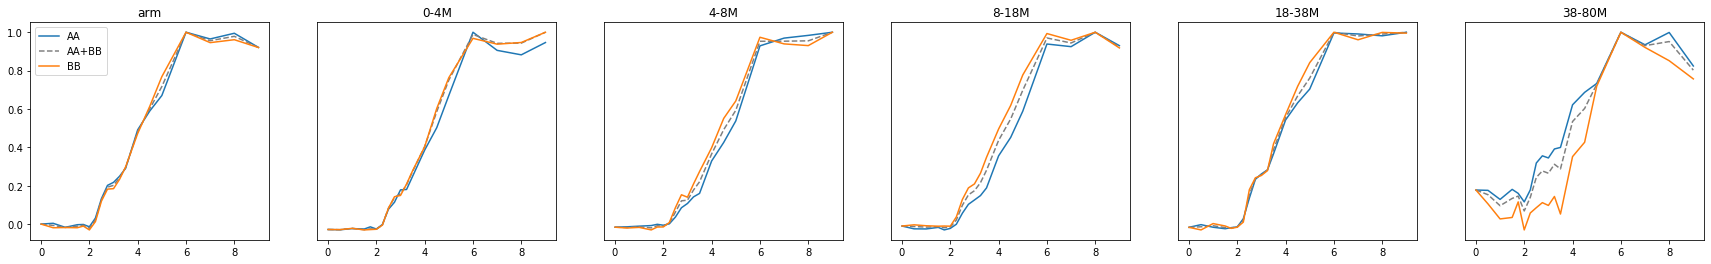

In [169]:

gs = plt.GridSpec(nrows=1, ncols=6)
plt.figure(figsize=(30, 4)) #width, height

for i,dist in enumerate(band_names):
    ax = plt.subplot(gs[i])
    
    aabbdf  =a_dfs["AA+BB"]
    aadf  =a_dfs["AA"]
    bbdf  =a_dfs["BB"]
    # extracting float time from the label ...
    # times = aadf.index.str.rsplit('-',n=1).str.get(1).str.strip('T').to_series().apply(lambda x: float(x)/10**(len(x)-1))
    times = aadf.index.str.strip('T').to_series().apply(lambda x: float(x)/10**(len(x)-1))
    # plot AA ...
#     ns = aadf[dist]
    ns = normalize_strength(aadf[dist],0,None,True)
    ax.plot(times,ns,'-',label="AA",color="C0",)

    # plot AA BB ...
    ns = normalize_strength(aabbdf[dist],0,None,True)
#     ns = aabbdf[dist]
    ax.plot(times,ns,'--',label="AA+BB",color='grey')

    
    # plot BB ...
    ns = normalize_strength(bbdf[dist],0,None,True)
#     ns = bbdf[dist]
    ax.plot(times,ns,'-',label="BB",color="C1")

    ax.set_title(dist)
    if i:
        ax.yaxis.set_visible(False)
#     ax.set_xlabel("t, hours" if i>=3 else "")
#     ax.set_ylabel("comp.strength (s-s[t=0h])/(s[t=6h]-s[t=0h]), a.u." if i%3==0 else "")
    if not i:
        ax.legend(loc='best')
#     ax.set_ylim(0,1.01)
    
plt.savefig("2019July_saddlesByDistance_{}arm_quantDist.pdf".format(chrom))

## not cleaned code underneath it

In [196]:
# generate a dict with all of the matrices (turned pandas.df), extracting the "name" from the filename
tcs = {f.split('__')[0]:pd.read_csv(f,sep='\t',index_col=0,comment="#") \
          for f in tcs_files}


coars_factor = 4
coars_dict = {0:coars_factor,1:coars_factor}
tcs_coarsed = {tp:numutils.coarsen(np.sum, tcs[tp].values, coars_dict) for tp in tcs}

NameError: name 'tcs_files' is not defined

In [18]:

def get_checker(shape,set_of_xy,alpha,the_cmap='Blues'):
    """
    describe it

    Parameters
    ----------
    shape : tuple
        A tuple describing the shape of the output checkerboard mask
    set_of_xy : array_of_tuples
        Where in each tuple we would have a pair of index lists to
        be intersected.
    alpha : scalar
        transparency for the areas corresponding to intersected indices
        or in other words in the area we want to highlight
    the_cmap : string
        name of the matplotlib cmap to be used for highlighting desired
        areas of the heatmap

    Returns
    -------
    checker : image
        A proper RGB image with alphas channel set such that the
        highlighted areas are alpha-transparent, and non-highlighted
        ones are fully transparent.

    """
    # add some check here ...
    # ...
    # THIS IS HOW WE MAKE A CHECKERBOARD MASK ON TOP OF HEATMAP-SLICE:
    checker = np.zeros(shape)
    # combine all of the areas we'd like ot highlight
    for x,y in set_of_xy:
        xv,yv = np.meshgrid(x,y)
        checker[xv,yv] += 1
    # define transparency, by clipping non-zero values,
    # i.e. the ones that we'd like to highlight to the desired
    # alpha level
    alphas = np.clip(checker,0,alpha)
    # cmap of choice ...
    cmap = plt.cm.get_cmap(the_cmap)
    # checker is already normalized between 0 and 1
    # so, just turn into RGB:
    checker = cmap(checker)
    # blend in an alpha chanel:
    checker[...,-1] = alphas
    return checker

In [19]:
lads_for_saddle.nonzero()

(array([  3,   4,   5,   6,  17,  22,  23,  24,  25,  29,  30,  31,  33,
         34,  35,  36,  37,  38,  45,  46,  47,  48,  49,  50,  51,  52,
         66,  67,  68,  69,  70,  84, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178, 179, 180, 194, 202, 223, 225,
        226, 227, 228]),)

chr14


/home/abramok/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


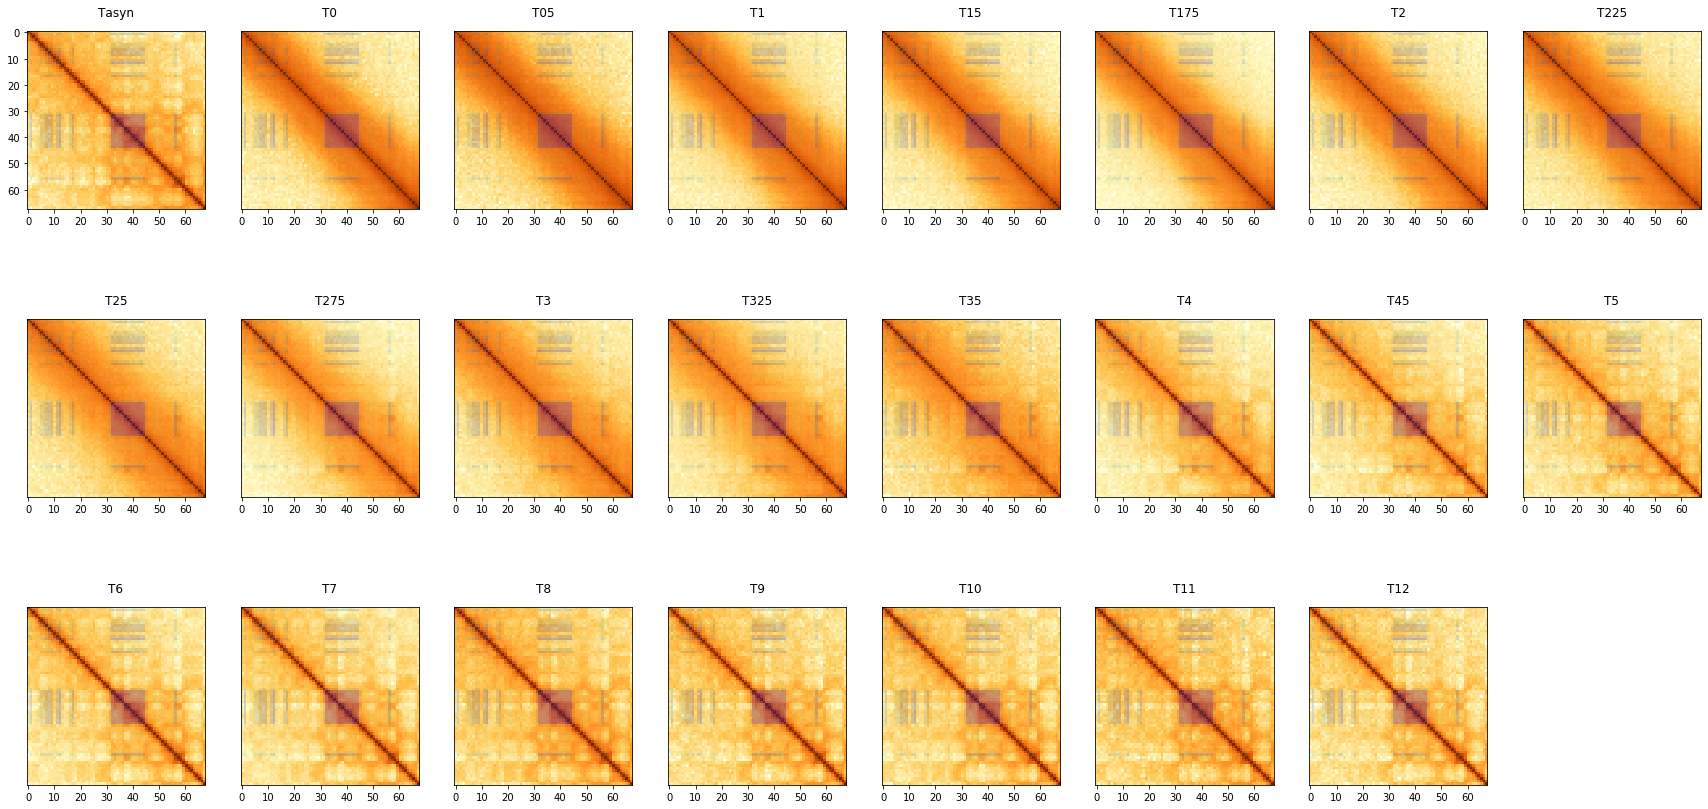

In [20]:
# observed time-course:
print(chrom)


gs = plt.GridSpec(nrows=3, ncols=8)
plt.figure(figsize=(30, 15)) #width, height

opts = dict(
#     vmin=0,
#     vmax=1000,
    cmap='YlOrBr')


coars_factor = 4
coars_dict = {0:coars_factor,1:coars_factor}
# tcs_coarsed = {tp:numutils.coarsen(np.sum, tcs[tp].values, coars_dict) for tp in tcs}


for i,tp in enumerate(tcs_ordered_keys):
    ax = plt.subplot(gs[i])
    matrix = tcs_dict[chrom][tp][centro_idx:,centro_idx:]
    matrix_coarsed = numutils.coarsen(np.sum, matrix,coars_dict,trim_excess=True)
    #
    checker = get_checker(matrix.shape,
                          [(lads_for_saddle.nonzero(),lads_for_saddle.nonzero()),],
                          0.2,
                          the_cmap='winter_r')
    checker_coarsed = numutils.coarsen(np.mean, checker,coars_dict,trim_excess=True)
    img = ax.matshow(
        np.log(matrix_coarsed),  
        **opts)
    #
    ax.matshow(checker_coarsed)
    #
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(tp)

    
# plt.show()




/home/abramok/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


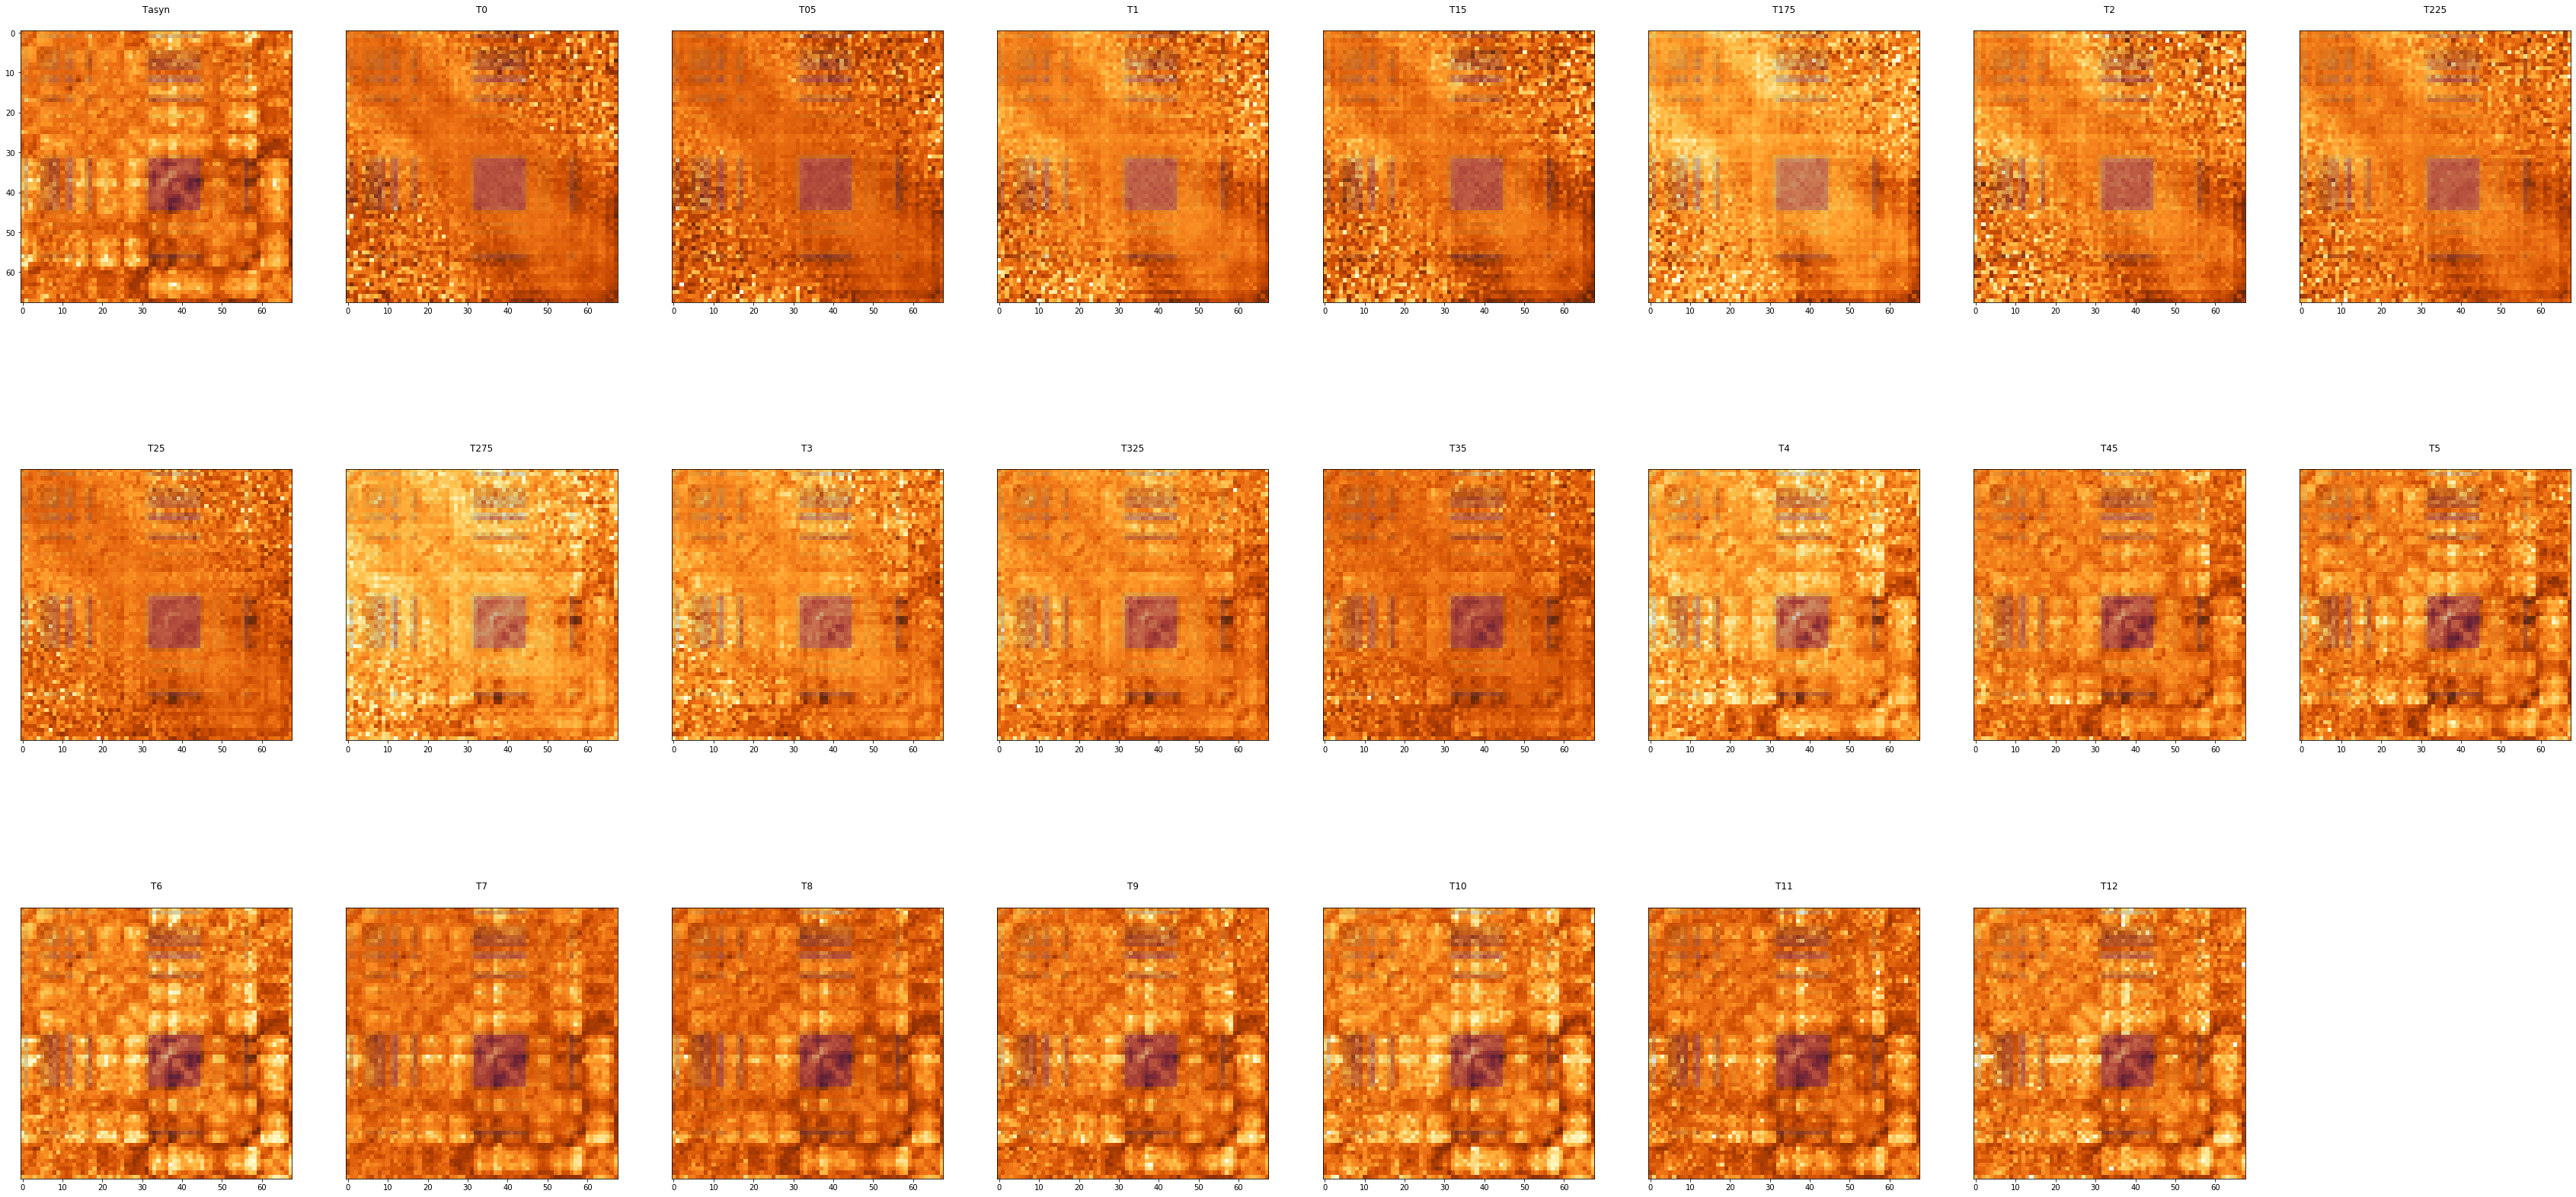

In [21]:
gs = plt.GridSpec(nrows=3, ncols=8)
plt.figure(figsize=(2*30, 2*15)) #width, height

opts = dict(
#     vmin=-2,
#     vmax=3,
    cmap='YlOrBr')



coars_factor = 4
coars_dict = {0:coars_factor,1:coars_factor}
# tcs_coarsed = {tp:numutils.coarsen(np.sum, tcs[tp].values, coars_dict) for tp in tcs}

for i,tp in enumerate(tcs_ordered_keys):
    ax = plt.subplot(gs[i])
    matrix = tcs_dict[chrom][tp][centro_idx:,centro_idx:]
    matrix_coarsed = numutils.coarsen(np.sum, matrix,coars_dict,trim_excess=True)
    #
    checker = get_checker(matrix.shape,
                          [(lads_for_saddle.nonzero(),lads_for_saddle.nonzero()),],
                          0.2,
                          the_cmap='winter_r')
    checker_coarsed = numutils.coarsen(np.mean, checker,coars_dict,trim_excess=True)
    #
    mask = numutils.infer_mask2D(matrix_coarsed)
    OE,_,_,_ = numutils.observed_over_expected(matrix_coarsed, mask)
    #
    img = ax.matshow(
        np.log(OE),  
        **opts)
    #
    ax.matshow(checker_coarsed)
    #
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(tp)


# for i,tp in enumerate(tcs_ordered_keys):
#     ax = plt.subplot(gs[i])
#     mask = numutils.infer_mask2D(tcs_dict_coarsed[tp][64:,64:])
#     OE,_,_,_ = numutils.observed_over_expected(tcs_dict_coarsed[tp][64:,64:], mask)
#     img = ax.matshow(
#         np.log(OE),  
#         **opts)
#     ax.xaxis.tick_bottom()
#     if i > 0:
#         ax.yaxis.set_visible(False)
#     plt.title(tp)

    
# ax = plt.subplot(gs[i+1])
# plt.colorbar(img, cax=ax)
    
# plt.show()

/home/abramok/miniconda3/envs/cooler-env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


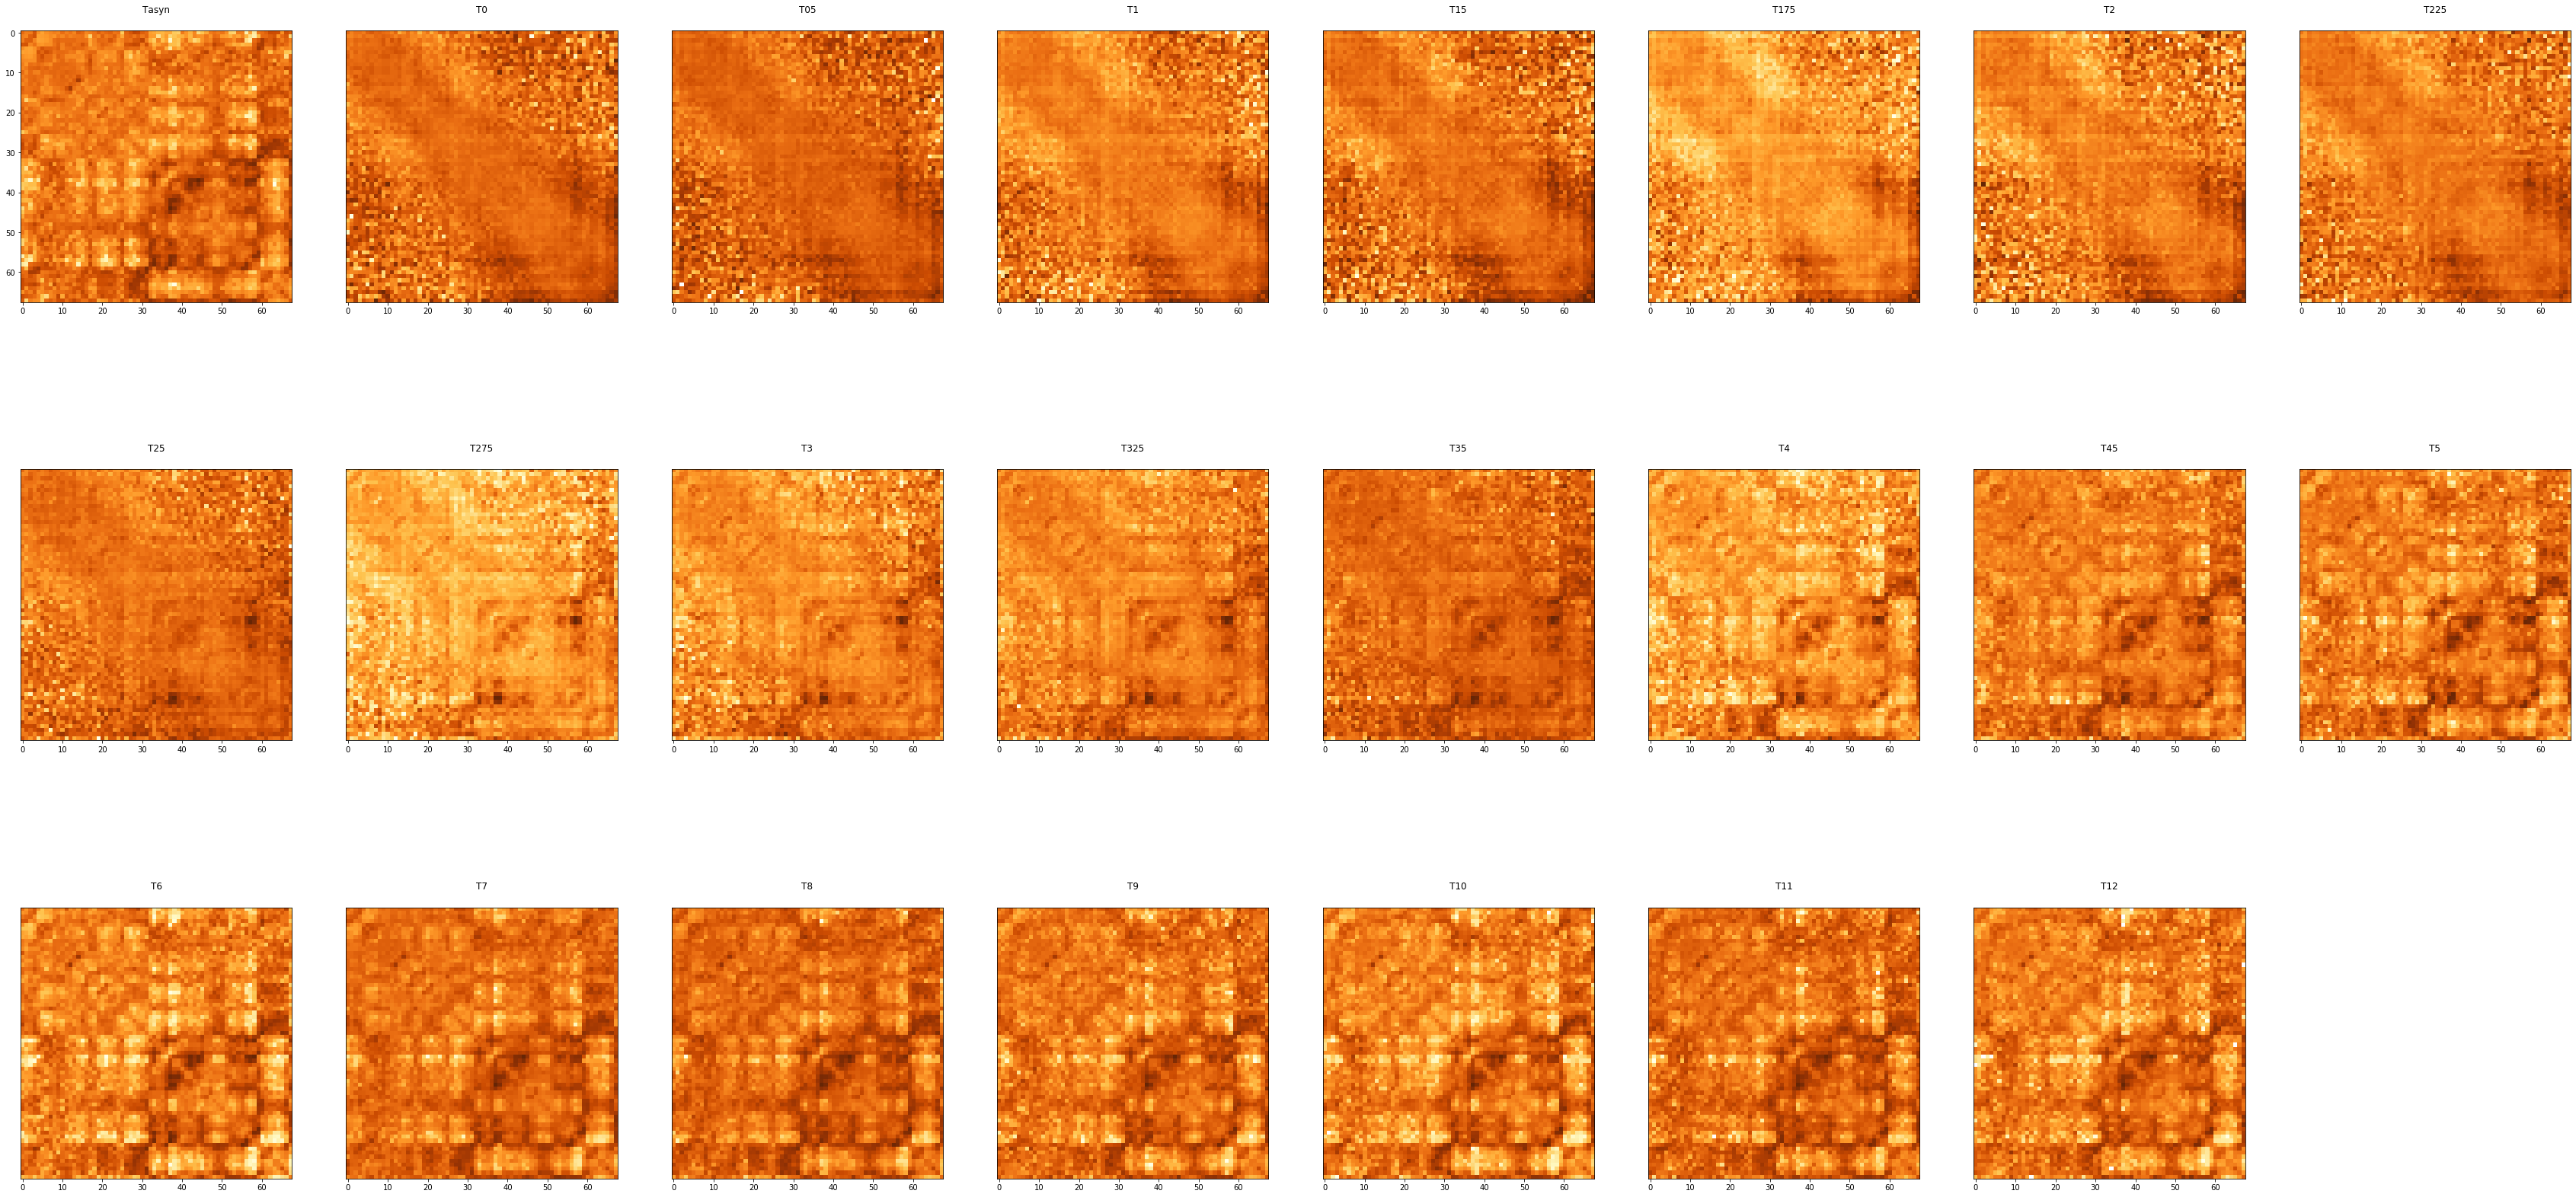

In [22]:
gs = plt.GridSpec(nrows=3, ncols=8)
plt.figure(figsize=(2*30, 2*15)) #width, height

opts = dict(
#     vmin=-2,
#     vmax=3,
    cmap='YlOrBr')



coars_factor = 4
coars_dict = {0:coars_factor,1:coars_factor}
# tcs_coarsed = {tp:numutils.coarsen(np.sum, tcs[tp].values, coars_dict) for tp in tcs}

for i,tp in enumerate(tcs_ordered_keys):
    ax = plt.subplot(gs[i])
    matrix = tcs_dict[chrom][tp][centro_idx:,centro_idx:]
    matrix_coarsed = numutils.coarsen(np.sum, matrix,coars_dict,trim_excess=True)
    #
    checker = get_checker(matrix.shape,
                          [(lads_for_saddle.nonzero(),lads_for_saddle.nonzero()),],
                          0.2,
                          the_cmap='winter_r')
    checker_coarsed = numutils.coarsen(np.mean, checker,coars_dict,trim_excess=True)
    #
    mask = numutils.infer_mask2D(matrix_coarsed)
    OE,_,_,_ = numutils.observed_over_expected(matrix_coarsed, mask)
    #
    img = ax.matshow(
        np.log(OE),  
        **opts)
    #
#     ax.matshow(checker_coarsed)
    #
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(tp)


In [199]:
# # extracting bins would require more effort for .matrix files ...
# bins = c.bins()[:]
# genecov = bioframe.tools.frac_gene_coverage(bins, 'mm9')


cis_eigs = cooltools.eigdecomp.cooler_cis_eig(
    c,
    genecov,
    regions=None,
    n_eigs=5,
    phasing_track_col='gene_count')


# Plot eigenvectors to confirm successful eigenvector decomposition.

plt.figure(
    figsize=(15,2)
)

##############################################################

loc_eig = bioframe.slice_bedframe(cis_eigs[1], 'chr1:10M-60M')
plt.plot(
    loc_eig['start'],
    loc_eig['E1']
)
plt.axhline(0,ls='--',lw=0.5,color='gray')
plt.ylabel('E1')
plt.xlabel('chr1 position, bp')

NameError: name 'cooltools' is not defined

In [ ]:
mask = numutils.infer_mask2D(tcs['TB-HiC-Dpn-R2-T8'].values)
OE,_,_,_ = numutils.observed_over_expected(tcs['TB-HiC-Dpn-R2-T8'].values, mask)

In [ ]:
OE,_,_,_ = numutils.observed_over_expected(tcs['TB-HiC-Dpn-R2-T8'].values, mask)

In [ ]:
plt.imshow(np.log2(OE),cmap="YlOrBr")